# A Cognitive Model or Harmonic Types (Simplified Amortization)

In [1]:
from google.colab import drive
drive.mount('/content/drive')
%cd /content/drive/MyDrive/Thesis/probabilistic_harmony_model

Mounted at /content/drive
/content/drive/MyDrive/Thesis/probabilistic_harmony_model


In [2]:
!pip install pyro-api==0.1.2
!pip install pyro-ppl==1.8.4
!pip install pitchtypes==0.4.0

     ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 730.7/730.7 kB 4.3 MB/s eta 0:00:00


In [3]:
import torch
import torch.nn as nn
import pyro
import pyro.distributions as dist
from pyro.infer import SVI, Trace_ELBO
from pyro.optim import Adam

from pyro.distributions import *
#from collections import Counter
import pyro.infer
import pyro.optim
import pyro.util
pyro.enable_validation(True)

import matplotlib.pyplot as plt
import tqdm

import numpy as np
import pandas as pd
import scipy.stats as stats

import os.path as path
from datetime import datetime
import json

import utils

import gc

In [4]:
gpu = torch.cuda.is_available()

gpu_n = 0

torch.set_default_dtype(torch.float64)

#torch.autograd.set_detect_anomaly(True)

device = torch.device(f'cuda:{gpu_n}' if gpu else 'cpu')
print(device)

cpu


In [5]:
def save_rng_state(name):
    fn = name + '-' + datetime.today().isoformat() + '.state'
    state = pyro.util.get_rng_state()
    with open('rng-' + fn, 'w') as f:
        print(state, file=f)
    torch.save(state['torch'], 'torch-' + fn)

In [6]:
# set random seeds
pyro.set_rng_seed(0)
#torch.set_deterministic(True)
#torch.set_num_threads(1)
#torch.set_num_interop_threads(1)

# fix the range of pitches we consider
fifth_range = 2*7                  # 2 diatonics
npcs = 2*fifth_range+1             # around C: Cbb to C## on LoF
utils.set_fifth_range(fifth_range) # used to make helper functions work correctly

# **1. Amortization**



## Step 1: Model

**Notations:**
- $h$: probablity distribution of chords (harmony)
- $\Phi$: chord profile for all chord types, where each $\phi_i$ conntains weights for each chord
- $npcs$: range of line of fifths, which is the number of pitches we consider
- $n_{harmonies}$: number of different chord types
- $n_{chords}$: length of dataset (how many chords we observe in the dataset)

**Generating Process:**

For all $i$:

- $\phi_i \sim Dirichlet(0.5, npcs)$
- $h \sim Dirichlet(0.5, n_{harmonies})$

    For each chord j:
    - Choose chords: $c_i \sim Categorical(h)$
    - Choose pitches: $p_j \sim Multinomial(\phi_{cj}, N_j)$

where $p_j$ and $N_j$ are observed, other variables are unobserved.

In [7]:
def simplified_chord_model(npcs, nharmonies, data, subsamples=500, **kwargs):
    # parameters priors:
    # distribution of the harmonies
    p_harmony = pyro.sample('p_harmony', dist.Dirichlet(0.8 * torch.ones(nharmonies, device=device)))
    # distribution of notes in the harmonies (chord profiles)
    with pyro.plate('harmonies', nharmonies):
        chord_profiles = pyro.sample('chord_profiles', dist.Dirichlet(0.8 * torch.ones(npcs, device=device)))

    # Sampling the data:
    nchords = len(data['c'])
    subs = torch.arange(min(nchords, subsamples), device=device) if subsamples is not None else torch.arange(nchords, device=device)

    with pyro.plate('data', nchords, subsample=subs) as ind:
        # sample a chord type based on the harmony distribution (to be inferred)
        c = pyro.sample('c', dist.Categorical(p_harmony))

        # sampling pitches for the chord based on the selected chord type profile
        pitches = pyro.sample('pitches', dist.Multinomial(1, probs=chord_profiles[c], validate_args=False), obs=data['pitches'][ind])

    return {"p_harmony": p_harmony, "chord_profiles": chord_profiles, "c": c, "pitches": pitches}

## Step 2: Amortization Guide for Inference


In [8]:
# simpler
class AmortizationNetwork(nn.Module):
    def __init__(self, input_dim, hidden_dim, output_dim):
        super().__init__()
        self.fc1 = nn.Linear(input_dim, hidden_dim)
        self.fc2 = nn.Linear(hidden_dim, output_dim)

    def forward(self, x):
        x = torch.relu(self.fc1(x))
        x = torch.softmax(self.fc2(x), dim=-1)
        return x

In [9]:
# # with regulation
# class AmortizationNetwork(nn.Module):
#     def __init__(self, input_dim, hidden_dim, output_dim):
#         super().__init__()
#         self.fc1 = nn.Linear(input_dim, hidden_dim)
#         self.fc2 = nn.Linear(hidden_dim, output_dim)
#         self.dropout = nn.Dropout(p=0.5)

#     def forward(self, x):
#         x = torch.relu(self.fc1(x.float()))
#         x = self.dropout(x)
#         x = torch.softmax(self.fc2(x), dim=-1)
#         return x

In [10]:
# # more complex
# class AmortizationNetwork(nn.Module):
#     def __init__(self, input_dim, hidden_dim1, hidden_dim2, output_dim):
#         super().__init__()
#         self.fc1 = nn.Linear(input_dim, hidden_dim1)
#         self.fc2 = nn.Linear(hidden_dim1, hidden_dim2)
#         self.fc3 = nn.Linear(hidden_dim2, output_dim)
#         # self.dropout = nn.Dropout(p=0.5)

#     def forward(self, x):
#         x = torch.relu(self.fc1(x.float()))
#         # x = self.dropout(x)
#         x = torch.softmax(self.fc3(x), dim=-1)
#         return x

In [11]:
def amortization_guide(npcs, nharmonies, data, subsamples=500, **kwargs):
    # for the distribution of the harmonies
    # initialize alpha parameters with more information, assuming some harmonies might be more probable
    alpha_h = pyro.param('alpha_h', (torch.ones(nharmonies, device=device) * 0.8), constraint=constraints.positive)

    pyro.sample('p_harmony', dist.Dirichlet(alpha_h))

    # for the chord profiles
    with pyro.plate('harmonies', nharmonies):
        alpha_phi = pyro.param('alpha_phi', (torch.ones([nharmonies, npcs], device=device) * 0.8), constraint=constraints.positive)
        pyro.sample('chord_profiles', dist.Dirichlet(alpha_phi))

    # for chord types
    net = AmortizationNetwork(input_dim=npcs, hidden_dim=128, output_dim=nharmonies)
    # net = AmortizationNetwork(input_dim=npcs, hidden_dim1=128, hidden_dim2=64, output_dim=nharmonies)
    net.to(device)
    pyro.module("net", net)

    nchords = len(data['c'])
    subs = torch.arange(min(nchords, subsamples), device=device) if subsamples is not None else torch.arange(nchords, device=device)

    with pyro.plate('data', nchords, subsample=subs) as ind:
        # Use NN to predict parameters for the chord types
        chord_features = data['pitches']
        chord_type_params = net(chord_features[ind])
        pyro.sample('c', dist.Categorical(probs=chord_type_params))

## Step 3: Data and Conditioning
**Data Format**


In [12]:
# def to_device_and_dtype(tensor, device):
#     return tensor.to(device).float()

In [13]:
def simplified_chord_tensor(notes):
    """Takes a list of fifths and returns a vector of counts for fifths."""
    chord = torch.zeros(npcs, device=device)
    #chord = torch.zeros(npcs).float()
    for fifth in notes:
        index = utils.fifth_to_index(fifth)
        chord[index] += 1
    return chord
    #return to_device_and_dtype(chord, device)

def simplified_annot_data_obs(chords):
    """Helper function to turn a list of chord dictionaries into a dictionary of observation vectors."""
    obs = {}
    obs["pitches"] = torch.cat([simplified_chord_tensor(c['notes']).reshape((1, -1)) for c in chords], dim=0)
    obs["c"] = torch.tensor([c['label'] for c in chords], device=device)
    obs["n"] = torch.tensor([len(c['notes']) - 1 for c in chords], device=device)
    return obs
    # obs["c"] = torch.tensor([c['label'] for c in chords]).long()
    # obs["n"] = torch.tensor([len(c['notes']) - 1 for c in chords]).long()
    # return {k: to_device_and_dtype(v, device) for k, v in obs.items()}

**Loading the Dataset**

The data is loaded from a TSV file that. The resulting dataframe is converted to the observation format that we pass to the model.

In [14]:
def load_dataset(filename):
    filename = path.join("data", filename)
    print("loading dataset...")
    df = utils.load_csv(filename)
    sizes = df.groupby(['chordid', 'label']).size()
    type_counts = sizes.groupby('label').size().sort_values(ascending=False)
    chordtypes = type_counts.index.tolist()
    df['numlabel'] = df.label.map(chordtypes.index)

    # check if precomputed tensor data is available:
    prefn = filename + "_precomp.pt"
    if path.exists(prefn) and path.getmtime(prefn) > path.getmtime(filename):
        print("using precomputed tensor data.")
        obs = torch.load(prefn, map_location=device)
    else:
        print('extracting chords...')
        chords = [{'label': numlabel, 'notes': [row['fifth'] for index, row in grp.iterrows()]}
                  for (_, numlabel), grp in tqdm.tqdm(df.groupby(['chordid', 'numlabel']))]
        print('converting chords to tensors...')
        obs = simplified_annot_data_obs(chords)
        torch.save(obs, prefn)

    print(len(chordtypes), "chord types")
    print(len(obs["c"]), "chords")
    return df, obs, chordtypes

In [15]:
def get_init_params(df, nharms, npcs):
    init = dict()

    # initialize params for harmonies
    init['harmonies'] = torch.tensor(df.groupby('numlabel').size().sort_values(ascending=False), device=device) + 0.5

    # initialize params for chord profiles
    init['chord_profiles'] = torch.zeros([nharms, npcs], device=device) + 0.5
    for (numlabel, fifth), grp in df.groupby(['numlabel', 'fifth']):
        init['chord_profiles'][numlabel, utils.fifth_to_index(fifth)] += grp.fifth.count()

    chord_sizes = df.groupby('chordid').size()
    init['sum_chords'] = torch.tensor(sum(chord_sizes), device=device)
    init['n_chords'] = torch.tensor(len(chord_sizes), device=device)
    return init

After inferring the parameters we save them for easier inspection and reuse.



In [16]:
def save_params(params, nharmonies, npcs, name):
    # Save the PyTorch parameters
    torch.save(params , path.join("results", name + '.pt'))

    # Save the parameters in a JSON file for easy access
    with open(path.join("results", name + '.json'), 'w') as f:
        json.dump({'params': {key: val.tolist() for key, val in params.items()},
                   'nharmonies': nharmonies,
                   'npcs': npcs},
                  f)

## Step 4: Inference

In [17]:
def infer_amortized_posteriors(npcs, nharmonies, data, nsteps=5000, lr=0.01, step_size=100, clip_grad=0.1, plot_loss=True, save_as=None, collect_history=False):
    pyro.clear_param_store()
    pyro.set_rng_seed(1625)

    svi = pyro.infer.SVI(model=simplified_chord_model,
                         guide=lambda npcs, nharmonies, data: amortization_guide(npcs, nharmonies, data),
                         optim=pyro.optim.Adam({"lr": lr, "betas": (0.95, 0.999)}),
                         loss=pyro.infer.Trace_ELBO())

    losses = []
    alpha_h_history = []
    alpha_phi_history = []

    for step in tqdm.trange(nsteps):
        loss = svi.step(npcs, nharmonies, data)

        # check for NaNs and infs in gradients
        for name, param in pyro.get_param_store().items():
            if param.grad is not None:
                if torch.isnan(param.grad).any() or torch.isinf(param.grad).any():
                    raise ValueError(f'Gradient for {name} has NaN/inf values.')

        # apply gradient clipping
        for p in pyro.get_param_store().values():
            p.register_hook(lambda grad: torch.clamp(grad, -clip_grad, clip_grad))

        losses.append(loss)

        if collect_history:
            # collect parameter histories
            alpha_h_history.append(pyro.param('alpha_h').detach().cpu().numpy())
            alpha_phi_history.append(pyro.param('alpha_phi').detach().cpu().numpy())

        if step % 100 == 0:
            print(f"Step {step} : loss = {loss}")

    # plot the loss
    if plot_loss:
        plt.figure(figsize=(12, 5))
        plt.plot(losses)
        plt.xlabel("Iteration")
        plt.ylabel("Loss")
        plt.title(f"SVI Convergence ({save_as})")
        plt.show()

    # save inferred parameters
    params = {name: value.detach().cpu().numpy() for name, value in pyro.get_param_store().items()}

    if save_as is not None:
        save_params(params, nharmonies, npcs, save_as)

    return params, (alpha_h_history, alpha_phi_history) if collect_history else params

## Step 5: Plotting

In [18]:
def plot_param_histories(alpha_h_history, alpha_phi_history):
    # Plot alpha_h history
    plt.figure(figsize=(12, 5))
    plt.plot(alpha_h_history)
    plt.title('Alpha_h parameter history')
    plt.xlabel('Iteration')
    plt.ylabel('Alpha_h values')
    plt.show()

    # Plot alpha_phi history (for simplicity, here we just plot the mean over the pitch classes)
    alpha_phi_mean_history = np.mean(alpha_phi_history, axis=-1)  # Compute the mean over pitch classes
    plt.figure(figsize=(12, 5))
    plt.plot(alpha_phi_mean_history)
    plt.title('Mean Alpha_phi parameter history')
    plt.xlabel('Iteration')
    plt.ylabel('Mean Alpha_phi values')
    plt.show()

In [19]:
def plot_amortized_inference_results(params, nharmonies, npcs, save_as=None):
    # Extract harmony and chord profile parameters
    harmony_params = params['alpha_h']
    chord_profile_params = params['alpha_phi']

    # Normalize the parameters
    harmony_normalized = harmony_params / np.sum(harmony_params)
    chord_profile_normalized = np.array([cp / np.sum(cp) for cp in chord_profile_params])

    num_subplots = nharmonies + 1

    fig, axs = plt.subplots(num_subplots, 1, figsize=(12, 3 * num_subplots))

    # Plot harmony distribution
    axs[0].bar(np.arange(len(harmony_normalized)), harmony_normalized)
    axs[0].set_title('Harmony Distribution')
    axs[0].set_xlabel('Harmony Types')
    axs[0].set_ylabel('Probability')

    # Plot chord profile parameters for each harmony
    for i in range(nharmonies):
        axs[i + 1].bar(np.arange(npcs), chord_profile_normalized[i])
        axs[i + 1].set_title(f'Chord Profile for Harmony {i}')
        axs[i + 1].set_xlabel('Pitches')
        axs[i + 1].set_ylabel('Probability')

    plt.tight_layout()
    if save_as:
        plt.savefig(f"{save_as}.png")
    plt.show()

# **2. Experiment**

In [20]:
dcml_df, dcml_obs, dcml_chordtypes = load_dataset('dcml.tsv')
dcml_init = get_init_params(dcml_df, len(dcml_chordtypes), npcs)

loading dataset...
using precomputed tensor data.
14 chord types
113771 chords


  0%|          | 0/400000 [00:00<?, ?it/s]<ipython-input-17-390aaa289ab3>:19: UserWarning: The .grad attribute of a Tensor that is not a leaf Tensor is being accessed. Its .grad attribute won't be populated during autograd.backward(). If you indeed want the .grad field to be populated for a non-leaf Tensor, use .retain_grad() on the non-leaf Tensor. If you access the non-leaf Tensor by mistake, make sure you access the leaf Tensor instead. See github.com/pytorch/pytorch/pull/30531 for more informations. (Triggered internally at aten/src/ATen/core/TensorBody.h:489.)
  if param.grad is not None:
  0%|          | 3/400000 [00:03<102:17:39,  1.09it/s]

Step 0 : loss = 3727527.740960735


  0%|          | 104/400000 [00:08<6:22:29, 17.43it/s]

Step 100 : loss = 2805236.191972534


  0%|          | 204/400000 [00:13<3:28:57, 31.89it/s]

Step 200 : loss = 2469952.244083894


  0%|          | 307/400000 [00:17<4:06:01, 27.08it/s]

Step 300 : loss = 2293638.647615851


  0%|          | 405/400000 [00:20<3:34:06, 31.10it/s]

Step 400 : loss = 2213390.735199535


  0%|          | 507/400000 [00:25<2:33:39, 43.33it/s]

Step 500 : loss = 2109245.2056202563


  0%|          | 607/400000 [00:27<2:27:51, 45.02it/s]

Step 600 : loss = 2067250.4760864412


  0%|          | 709/400000 [00:29<1:49:44, 60.64it/s]

Step 700 : loss = 2060594.381787307


  0%|          | 814/400000 [00:30<1:42:45, 64.75it/s]

Step 800 : loss = 2007187.070298749


  0%|          | 912/400000 [00:32<1:44:23, 63.71it/s]

Step 900 : loss = 1946914.6848270206


  0%|          | 1010/400000 [00:33<1:43:13, 64.42it/s]

Step 1000 : loss = 1924871.647634827


  0%|          | 1108/400000 [00:35<1:43:25, 64.28it/s]

Step 1100 : loss = 1918664.3497441006


  0%|          | 1213/400000 [00:37<1:47:39, 61.74it/s]

Step 1200 : loss = 1903255.4013916133


  0%|          | 1310/400000 [00:38<2:04:58, 53.17it/s]

Step 1300 : loss = 1909258.2902243098


  0%|          | 1407/400000 [00:40<2:27:42, 44.97it/s]

Step 1400 : loss = 1898541.8393078449


  0%|          | 1507/400000 [00:43<2:15:39, 48.96it/s]

Step 1500 : loss = 1902549.6216599075


  0%|          | 1609/400000 [00:45<1:47:50, 61.57it/s]

Step 1600 : loss = 1865728.2568215008


  0%|          | 1707/400000 [00:46<1:45:06, 63.15it/s]

Step 1700 : loss = 1902166.293021573


  0%|          | 1812/400000 [00:48<1:45:45, 62.75it/s]

Step 1800 : loss = 1857143.5736239613


  0%|          | 1910/400000 [00:49<1:47:05, 61.95it/s]

Step 1900 : loss = 1886155.0270736231


  1%|          | 2008/400000 [00:51<1:45:23, 62.94it/s]

Step 2000 : loss = 1859646.4963578188


  1%|          | 2113/400000 [00:53<1:43:55, 63.81it/s]

Step 2100 : loss = 1826945.6914836485


  1%|          | 2210/400000 [00:54<2:05:33, 52.81it/s]

Step 2200 : loss = 1863905.7219733645


  1%|          | 2307/400000 [00:56<2:23:24, 46.22it/s]

Step 2300 : loss = 1851151.4050046622


  1%|          | 2407/400000 [00:58<2:22:46, 46.41it/s]

Step 2400 : loss = 1835975.5226279558


  1%|          | 2510/400000 [01:00<1:41:38, 65.18it/s]

Step 2500 : loss = 1822198.7381360417


  1%|          | 2608/400000 [01:02<1:43:47, 63.81it/s]

Step 2600 : loss = 1840946.0678969724


  1%|          | 2713/400000 [01:04<1:43:17, 64.11it/s]

Step 2700 : loss = 1834079.6824789662


  1%|          | 2811/400000 [01:05<1:46:20, 62.25it/s]

Step 2800 : loss = 1839457.8604154584


  1%|          | 2909/400000 [01:07<1:43:43, 63.80it/s]

Step 2900 : loss = 1823218.7668939272


  1%|          | 3014/400000 [01:08<1:43:25, 63.97it/s]

Step 3000 : loss = 1834927.2776313843


  1%|          | 3105/400000 [01:10<1:47:18, 61.64it/s]

Step 3100 : loss = 1828511.0892402423


  1%|          | 3206/400000 [01:12<2:17:32, 48.08it/s]

Step 3200 : loss = 1829948.9318179127


  1%|          | 3308/400000 [01:14<2:21:32, 46.71it/s]

Step 3300 : loss = 1815986.866898046


  1%|          | 3412/400000 [01:16<1:50:11, 59.98it/s]

Step 3400 : loss = 1844655.949661781


  1%|          | 3510/400000 [01:18<1:45:07, 62.86it/s]

Step 3500 : loss = 1806933.410966724


  1%|          | 3608/400000 [01:19<1:43:41, 63.72it/s]

Step 3600 : loss = 1811890.9733460005


  1%|          | 3713/400000 [01:21<1:44:01, 63.50it/s]

Step 3700 : loss = 1802352.069857793


  1%|          | 3811/400000 [01:23<1:47:26, 61.46it/s]

Step 3800 : loss = 1829075.438713269


  1%|          | 3909/400000 [01:24<1:47:03, 61.66it/s]

Step 3900 : loss = 1812348.7976572001


  1%|          | 4007/400000 [01:26<2:04:06, 53.18it/s]

Step 4000 : loss = 1805137.3407958285


  1%|          | 4109/400000 [01:28<2:28:20, 44.48it/s]

Step 4100 : loss = 1815686.7154921899


  1%|          | 4210/400000 [01:30<2:17:24, 48.01it/s]

Step 4200 : loss = 1818424.8403706031


  1%|          | 4313/400000 [01:32<1:47:36, 61.28it/s]

Step 4300 : loss = 1807998.3977762694


  1%|          | 4411/400000 [01:34<1:44:40, 62.98it/s]

Step 4400 : loss = 1794232.069441742


  1%|          | 4509/400000 [01:36<1:48:28, 60.77it/s]

Step 4500 : loss = 1818730.1235721554


  1%|          | 4614/400000 [01:37<1:45:21, 62.55it/s]

Step 4600 : loss = 1804769.0731513991


  1%|          | 4712/400000 [01:39<1:43:18, 63.77it/s]

Step 4700 : loss = 1800119.7710435274


  1%|          | 4810/400000 [01:40<1:44:11, 63.21it/s]

Step 4800 : loss = 1811880.4014712055


  1%|          | 4907/400000 [01:42<2:11:47, 49.97it/s]

Step 4900 : loss = 1803334.7950678216


  1%|▏         | 5009/400000 [01:44<2:28:58, 44.19it/s]

Step 5000 : loss = 1809128.802382348


  1%|▏         | 5109/400000 [01:46<2:23:29, 45.86it/s]

Step 5100 : loss = 1809143.3611857812


  1%|▏         | 5208/400000 [01:48<1:45:17, 62.49it/s]

Step 5200 : loss = 1806138.5262292975


  1%|▏         | 5313/400000 [01:50<1:45:02, 62.62it/s]

Step 5300 : loss = 1804791.2271154127


  1%|▏         | 5411/400000 [01:52<1:43:42, 63.41it/s]

Step 5400 : loss = 1797708.6059081354


  1%|▏         | 5509/400000 [01:53<1:46:42, 61.62it/s]

Step 5500 : loss = 1801933.223652137


  1%|▏         | 5607/400000 [01:55<1:45:09, 62.51it/s]

Step 5600 : loss = 1818427.3089781604


  1%|▏         | 5711/400000 [01:56<1:46:22, 61.78it/s]

Step 5700 : loss = 1800652.9020655914


  1%|▏         | 5807/400000 [01:58<2:19:45, 47.01it/s]

Step 5800 : loss = 1807478.5899134693


  1%|▏         | 5907/400000 [02:00<2:23:46, 45.68it/s]

Step 5900 : loss = 1793257.8393903251


  2%|▏         | 6007/400000 [02:03<2:21:00, 46.57it/s]

Step 6000 : loss = 1806679.8088704785


  2%|▏         | 6110/400000 [02:04<1:45:21, 62.31it/s]

Step 6100 : loss = 1803855.467749433


  2%|▏         | 6208/400000 [02:06<1:49:26, 59.97it/s]

Step 6200 : loss = 1797213.3330266245


  2%|▏         | 6313/400000 [02:08<1:47:36, 60.98it/s]

Step 6300 : loss = 1793470.6589226082


  2%|▏         | 6407/400000 [02:10<2:20:37, 46.65it/s]

Step 6400 : loss = 1792109.0530951924


  2%|▏         | 6509/400000 [02:12<1:52:02, 58.54it/s]

Step 6500 : loss = 1802723.9711497086


  2%|▏         | 6605/400000 [02:14<2:06:54, 51.66it/s]

Step 6600 : loss = 1800596.0195033108


  2%|▏         | 6707/400000 [02:16<2:32:18, 43.03it/s]

Step 6700 : loss = 1819871.2889450141


  2%|▏         | 6807/400000 [02:18<2:25:27, 45.05it/s]

Step 6800 : loss = 1794302.679693694


  2%|▏         | 6907/400000 [02:20<1:48:32, 60.36it/s]

Step 6900 : loss = 1805425.3564604148


  2%|▏         | 7012/400000 [02:22<1:46:30, 61.49it/s]

Step 7000 : loss = 1795323.0888919001


  2%|▏         | 7110/400000 [02:23<1:44:59, 62.37it/s]

Step 7100 : loss = 1789798.3551835432


  2%|▏         | 7208/400000 [02:25<1:45:18, 62.16it/s]

Step 7200 : loss = 1793994.363620261


  2%|▏         | 7313/400000 [02:27<1:49:03, 60.01it/s]

Step 7300 : loss = 1798288.7003731257


  2%|▏         | 7411/400000 [02:28<1:41:49, 64.26it/s]

Step 7400 : loss = 1816143.3660174555


  2%|▏         | 7509/400000 [02:30<2:14:47, 48.53it/s]

Step 7500 : loss = 1797538.86896729


  2%|▏         | 7608/400000 [02:32<2:45:52, 39.43it/s]

Step 7600 : loss = 1808958.3505287925


  2%|▏         | 7708/400000 [02:35<2:21:53, 46.08it/s]

Step 7700 : loss = 1791885.387691555


  2%|▏         | 7806/400000 [02:37<2:29:56, 43.59it/s]

Step 7800 : loss = 1806231.731202502


  2%|▏         | 7909/400000 [02:39<2:26:25, 44.63it/s]

Step 7900 : loss = 1790557.0588213245


  2%|▏         | 8010/400000 [02:42<1:51:33, 58.56it/s]

Step 8000 : loss = 1802668.433648923


  2%|▏         | 8112/400000 [02:43<1:45:12, 62.08it/s]

Step 8100 : loss = 1797520.267192169


  2%|▏         | 8210/400000 [02:45<1:46:34, 61.27it/s]

Step 8200 : loss = 1797349.0963508675


  2%|▏         | 8310/400000 [02:47<1:50:37, 59.01it/s]

Step 8300 : loss = 1799541.5866142046


  2%|▏         | 8413/400000 [02:48<1:44:52, 62.23it/s]

Step 8400 : loss = 1794673.168092065


  2%|▏         | 8508/400000 [02:50<2:21:56, 45.97it/s]

Step 8500 : loss = 1791911.5930952546


  2%|▏         | 8608/400000 [02:53<2:17:50, 47.32it/s]

Step 8600 : loss = 1800762.3254266402


  2%|▏         | 8708/400000 [02:55<2:29:47, 43.54it/s]

Step 8700 : loss = 1800526.0755739869


  2%|▏         | 8812/400000 [02:56<1:45:22, 61.88it/s]

Step 8800 : loss = 1789947.3527137642


  2%|▏         | 8909/400000 [02:58<1:47:11, 60.81it/s]

Step 8900 : loss = 1790585.6560891774


  2%|▏         | 9007/400000 [03:00<1:44:00, 62.66it/s]

Step 9000 : loss = 1796232.4129574965


  2%|▏         | 9112/400000 [03:01<1:47:09, 60.79it/s]

Step 9100 : loss = 1797612.688662455


  2%|▏         | 9212/400000 [03:03<1:42:11, 63.73it/s]

Step 9200 : loss = 1794839.8435620295


  2%|▏         | 9310/400000 [03:04<1:42:59, 63.22it/s]

Step 9300 : loss = 1791835.6969897836


  2%|▏         | 9409/400000 [03:07<2:25:35, 44.71it/s]

Step 9400 : loss = 1799202.1593758874


  2%|▏         | 9509/400000 [03:09<2:26:34, 44.40it/s]

Step 9500 : loss = 1794942.98236286


  2%|▏         | 9610/400000 [03:11<1:56:09, 56.01it/s]

Step 9600 : loss = 1785234.0670873001


  2%|▏         | 9707/400000 [03:13<1:48:05, 60.18it/s]

Step 9700 : loss = 1793139.2131965007


  2%|▏         | 9812/400000 [03:14<1:43:26, 62.87it/s]

Step 9800 : loss = 1788168.0794916232


  2%|▏         | 9910/400000 [03:16<1:45:49, 61.44it/s]

Step 9900 : loss = 1796124.5627583205


  3%|▎         | 10008/400000 [03:17<1:43:11, 62.99it/s]

Step 10000 : loss = 1790209.8360470617


  3%|▎         | 10113/400000 [03:19<1:44:41, 62.07it/s]

Step 10100 : loss = 1790401.9418012595


  3%|▎         | 10204/400000 [03:21<1:43:16, 62.90it/s]

Step 10200 : loss = 1804326.7191800366


  3%|▎         | 10309/400000 [03:23<2:18:33, 46.87it/s]

Step 10300 : loss = 1798728.3692556676


  3%|▎         | 10406/400000 [03:25<2:19:04, 46.69it/s]

Step 10400 : loss = 1790896.0074015916


  3%|▎         | 10510/400000 [03:27<1:51:09, 58.40it/s]

Step 10500 : loss = 1785828.7200940049


  3%|▎         | 10613/400000 [03:29<1:45:07, 61.74it/s]

Step 10600 : loss = 1785189.5243784867


  3%|▎         | 10711/400000 [03:30<1:49:13, 59.40it/s]

Step 10700 : loss = 1797779.4905631875


  3%|▎         | 10809/400000 [03:32<1:44:45, 61.92it/s]

Step 10800 : loss = 1787808.5348112057


  3%|▎         | 10907/400000 [03:34<1:43:47, 62.48it/s]

Step 10900 : loss = 1788506.719378826


  3%|▎         | 11012/400000 [03:35<1:42:03, 63.53it/s]

Step 11000 : loss = 1789577.7789335381


  3%|▎         | 11108/400000 [03:37<2:14:41, 48.12it/s]

Step 11100 : loss = 1790772.7920724647


  3%|▎         | 11209/400000 [03:39<2:28:32, 43.62it/s]

Step 11200 : loss = 1786768.2328370474


  3%|▎         | 11309/400000 [03:41<2:23:01, 45.29it/s]

Step 11300 : loss = 1791154.94892952


  3%|▎         | 11408/400000 [03:43<1:45:22, 61.46it/s]

Step 11400 : loss = 1797332.0720728924


  3%|▎         | 11513/400000 [03:45<1:46:43, 60.67it/s]

Step 11500 : loss = 1791358.0212295484


  3%|▎         | 11611/400000 [03:47<1:44:47, 61.77it/s]

Step 11600 : loss = 1798554.420250381


  3%|▎         | 11708/400000 [03:48<1:46:56, 60.52it/s]

Step 11700 : loss = 1797033.365657711


  3%|▎         | 11813/400000 [03:50<1:43:16, 62.64it/s]

Step 11800 : loss = 1789664.3286818224


  3%|▎         | 11911/400000 [03:52<1:44:12, 62.07it/s]

Step 11900 : loss = 1791908.9290936526


  3%|▎         | 12008/400000 [03:53<2:21:35, 45.67it/s]

Step 12000 : loss = 1791000.8521996066


  3%|▎         | 12109/400000 [03:56<2:23:50, 44.94it/s]

Step 12100 : loss = 1791122.1051258217


  3%|▎         | 12209/400000 [03:58<2:29:00, 43.38it/s]

Step 12200 : loss = 1793913.1751607736


  3%|▎         | 12309/400000 [04:00<1:49:01, 59.27it/s]

Step 12300 : loss = 1792371.5598820606


  3%|▎         | 12413/400000 [04:01<1:42:30, 63.02it/s]

Step 12400 : loss = 1792899.2592100836


  3%|▎         | 12511/400000 [04:03<1:45:20, 61.30it/s]

Step 12500 : loss = 1792297.856705137


  3%|▎         | 12609/400000 [04:05<1:42:24, 63.05it/s]

Step 12600 : loss = 1792030.2065412693


  3%|▎         | 12712/400000 [04:06<1:47:07, 60.26it/s]

Step 12700 : loss = 1786612.9482981763


  3%|▎         | 12810/400000 [04:08<1:44:32, 61.73it/s]

Step 12800 : loss = 1800116.9292180338


  3%|▎         | 12910/400000 [04:10<2:19:38, 46.20it/s]

Step 12900 : loss = 1790468.434348504


  3%|▎         | 13006/400000 [04:12<2:19:44, 46.16it/s]

Step 13000 : loss = 1789447.9489900297


  3%|▎         | 13106/400000 [04:14<2:27:35, 43.69it/s]

Step 13100 : loss = 1803263.714313998


  3%|▎         | 13209/400000 [04:16<1:45:33, 61.07it/s]

Step 13200 : loss = 1789077.2686089054


  3%|▎         | 13312/400000 [04:18<1:48:16, 59.52it/s]

Step 13300 : loss = 1793261.772599029


  3%|▎         | 13408/400000 [04:19<1:46:20, 60.59it/s]

Step 13400 : loss = 1792279.9153305679


  3%|▎         | 13513/400000 [04:21<1:41:54, 63.21it/s]

Step 13500 : loss = 1802068.2789121997


  3%|▎         | 13611/400000 [04:22<1:41:45, 63.28it/s]

Step 13600 : loss = 1798545.5577299814


  3%|▎         | 13709/400000 [04:24<1:44:55, 61.36it/s]

Step 13700 : loss = 1798158.0929596762


  3%|▎         | 13809/400000 [04:26<2:22:33, 45.15it/s]

Step 13800 : loss = 1792721.3310361472


  3%|▎         | 13909/400000 [04:28<2:19:19, 46.19it/s]

Step 13900 : loss = 1792242.0699853152


  4%|▎         | 14012/400000 [04:31<2:02:44, 52.42it/s]

Step 14000 : loss = 1791398.302824186


  4%|▎         | 14108/400000 [04:32<1:48:59, 59.01it/s]

Step 14100 : loss = 1792797.300573832


  4%|▎         | 14212/400000 [04:34<1:42:55, 62.48it/s]

Step 14200 : loss = 1793016.5074481843


  4%|▎         | 14310/400000 [04:35<1:45:12, 61.10it/s]

Step 14300 : loss = 1794888.5837828307


  4%|▎         | 14407/400000 [04:37<1:47:30, 59.78it/s]

Step 14400 : loss = 1796515.455835199


  4%|▎         | 14508/400000 [04:39<1:43:13, 62.24it/s]

Step 14500 : loss = 1790395.4339624916


  4%|▎         | 14606/400000 [04:40<1:45:38, 60.80it/s]

Step 14600 : loss = 1796818.8408329184


  4%|▎         | 14710/400000 [04:43<2:18:51, 46.24it/s]

Step 14700 : loss = 1790226.3766103012


  4%|▎         | 14810/400000 [04:45<2:18:31, 46.34it/s]

Step 14800 : loss = 1795863.1471387683


  4%|▎         | 14912/400000 [04:47<1:53:48, 56.40it/s]

Step 14900 : loss = 1791263.0080223584


  4%|▍         | 15009/400000 [04:49<1:44:03, 61.66it/s]

Step 15000 : loss = 1795368.0265135746


  4%|▍         | 15113/400000 [04:50<1:47:04, 59.91it/s]

Step 15100 : loss = 1785025.981813674


  4%|▍         | 15210/400000 [04:52<1:47:34, 59.62it/s]

Step 15200 : loss = 1791392.5943516612


  4%|▍         | 15307/400000 [04:53<1:43:58, 61.66it/s]

Step 15300 : loss = 1795993.6855988982


  4%|▍         | 15412/400000 [04:55<1:46:51, 59.98it/s]

Step 15400 : loss = 1792049.1596854944


  4%|▍         | 15508/400000 [04:57<2:19:42, 45.87it/s]

Step 15500 : loss = 1792684.0760534666


  4%|▍         | 15608/400000 [04:59<2:26:10, 43.83it/s]

Step 15600 : loss = 1787989.7421923946


  4%|▍         | 15708/400000 [05:01<2:19:45, 45.83it/s]

Step 15700 : loss = 1788205.1790109116


  4%|▍         | 15807/400000 [05:03<1:43:48, 61.68it/s]

Step 15800 : loss = 1790101.5942252344


  4%|▍         | 15912/400000 [05:05<1:45:37, 60.61it/s]

Step 15900 : loss = 1789127.7680679364


  4%|▍         | 16008/400000 [05:07<1:49:09, 58.63it/s]

Step 16000 : loss = 1793756.5294661988


  4%|▍         | 16109/400000 [05:08<1:44:21, 61.31it/s]

Step 16100 : loss = 1801911.2293259853


  4%|▍         | 16211/400000 [05:10<1:47:03, 59.75it/s]

Step 16200 : loss = 1790508.047072141


  4%|▍         | 16307/400000 [05:12<1:44:33, 61.17it/s]

Step 16300 : loss = 1791557.1853230158


  4%|▍         | 16406/400000 [05:14<2:18:11, 46.26it/s]

Step 16400 : loss = 1791362.74958566


  4%|▍         | 16506/400000 [05:16<2:22:36, 44.82it/s]

Step 16500 : loss = 1795155.122865027


  4%|▍         | 16606/400000 [05:18<2:37:37, 40.54it/s]

Step 16600 : loss = 1789926.0284545773


  4%|▍         | 16713/400000 [05:20<1:43:59, 61.43it/s]

Step 16700 : loss = 1789873.4312516684


  4%|▍         | 16811/400000 [05:22<1:44:41, 61.01it/s]

Step 16800 : loss = 1788689.8302465961


  4%|▍         | 16909/400000 [05:23<1:45:57, 60.25it/s]

Step 16900 : loss = 1790727.8305859289


  4%|▍         | 17010/400000 [05:25<1:44:02, 61.36it/s]

Step 17000 : loss = 1790051.7836022484


  4%|▍         | 17107/400000 [05:27<1:46:11, 60.09it/s]

Step 17100 : loss = 1782790.4636478927


  4%|▍         | 17209/400000 [05:28<1:43:08, 61.85it/s]

Step 17200 : loss = 1786463.9848898877


  4%|▍         | 17308/400000 [05:30<2:22:32, 44.75it/s]

Step 17300 : loss = 1797923.0442592094


  4%|▍         | 17408/400000 [05:33<2:21:32, 45.05it/s]

Step 17400 : loss = 1785273.379958573


  4%|▍         | 17511/400000 [05:35<1:50:27, 57.71it/s]

Step 17500 : loss = 1783877.3862794053


  4%|▍         | 17607/400000 [05:36<1:44:25, 61.03it/s]

Step 17600 : loss = 1784494.9303126703


  4%|▍         | 17713/400000 [05:38<1:45:37, 60.32it/s]

Step 17700 : loss = 1791916.9103992358


  4%|▍         | 17810/400000 [05:40<1:47:00, 59.52it/s]

Step 17800 : loss = 1794513.6676077235


  4%|▍         | 17913/400000 [05:42<1:45:15, 60.50it/s]

Step 17900 : loss = 1788812.01872988


  5%|▍         | 18010/400000 [05:43<1:42:48, 61.92it/s]

Step 18000 : loss = 1790587.1646848933


  5%|▍         | 18108/400000 [05:45<2:17:27, 46.30it/s]

Step 18100 : loss = 1786169.079905323


  5%|▍         | 18208/400000 [05:47<2:25:04, 43.86it/s]

Step 18200 : loss = 1788042.473601459


  5%|▍         | 18308/400000 [05:49<2:19:06, 45.73it/s]

Step 18300 : loss = 1788531.6127093688


  5%|▍         | 18413/400000 [05:51<1:44:04, 61.11it/s]

Step 18400 : loss = 1788573.7341808397


  5%|▍         | 18511/400000 [05:53<1:44:39, 60.75it/s]

Step 18500 : loss = 1780901.3409585326


  5%|▍         | 18609/400000 [05:55<1:40:19, 63.36it/s]

Step 18600 : loss = 1791098.327520877


  5%|▍         | 18707/400000 [05:56<1:45:18, 60.34it/s]

Step 18700 : loss = 1783879.9704639004


  5%|▍         | 18810/400000 [05:58<1:44:37, 60.72it/s]

Step 18800 : loss = 1793952.5322815836


  5%|▍         | 18908/400000 [05:59<1:43:40, 61.26it/s]

Step 18900 : loss = 1791011.561213674


  5%|▍         | 19009/400000 [06:02<2:17:42, 46.11it/s]

Step 19000 : loss = 1792531.3966889891


  5%|▍         | 19109/400000 [06:04<2:13:35, 47.52it/s]

Step 19100 : loss = 1786003.5044058529


  5%|▍         | 19209/400000 [06:06<2:23:29, 44.23it/s]

Step 19200 : loss = 1793432.2423556545


  5%|▍         | 19312/400000 [06:08<1:43:12, 61.47it/s]

Step 19300 : loss = 1791679.933674518


  5%|▍         | 19410/400000 [06:09<1:42:56, 61.62it/s]

Step 19400 : loss = 1788176.7311666724


  5%|▍         | 19507/400000 [06:11<1:45:09, 60.30it/s]

Step 19500 : loss = 1792078.3718757534


  5%|▍         | 19612/400000 [06:13<1:45:30, 60.09it/s]

Step 19600 : loss = 1787158.411188755


  5%|▍         | 19710/400000 [06:14<1:43:35, 61.18it/s]

Step 19700 : loss = 1788529.2523891376


  5%|▍         | 19807/400000 [06:16<1:44:01, 60.92it/s]

Step 19800 : loss = 1795494.4016385796


  5%|▍         | 19910/400000 [06:18<2:21:45, 44.69it/s]

Step 19900 : loss = 1791383.6975265015


  5%|▌         | 20006/400000 [06:21<2:50:59, 37.04it/s]

Step 20000 : loss = 1790137.4213528205


  5%|▌         | 20107/400000 [06:24<2:55:26, 36.09it/s]

Step 20100 : loss = 1791824.7606029809


  5%|▌         | 20207/400000 [06:26<2:16:40, 46.31it/s]

Step 20200 : loss = 1788825.0952961794


  5%|▌         | 20312/400000 [06:28<1:46:39, 59.33it/s]

Step 20300 : loss = 1785986.8240430406


  5%|▌         | 20407/400000 [06:30<1:46:45, 59.26it/s]

Step 20400 : loss = 1793273.2401022632


  5%|▌         | 20512/400000 [06:31<1:47:12, 58.99it/s]

Step 20500 : loss = 1796551.6493968554


  5%|▌         | 20609/400000 [06:33<1:41:56, 62.02it/s]

Step 20600 : loss = 1794902.0979016037


  5%|▌         | 20707/400000 [06:35<2:17:09, 46.09it/s]

Step 20700 : loss = 1790328.2548502106


  5%|▌         | 20807/400000 [06:37<2:28:39, 42.51it/s]

Step 20800 : loss = 1785950.471302634


  5%|▌         | 20907/400000 [06:39<2:25:24, 43.45it/s]

Step 20900 : loss = 1788736.6218575647


  5%|▌         | 21012/400000 [06:41<1:44:05, 60.69it/s]

Step 21000 : loss = 1788715.8926046502


  5%|▌         | 21108/400000 [06:43<1:49:05, 57.89it/s]

Step 21100 : loss = 1785479.6147847762


  5%|▌         | 21210/400000 [06:45<1:42:54, 61.34it/s]

Step 21200 : loss = 1789396.6893526812


  5%|▌         | 21307/400000 [06:46<1:45:21, 59.90it/s]

Step 21300 : loss = 1790140.263168548


  5%|▌         | 21412/400000 [06:48<1:43:20, 61.05it/s]

Step 21400 : loss = 1789180.4088620902


  5%|▌         | 21510/400000 [06:50<1:43:29, 60.96it/s]

Step 21500 : loss = 1791218.6493156236


  5%|▌         | 21606/400000 [06:52<2:18:59, 45.37it/s]

Step 21600 : loss = 1790606.5313333955


  5%|▌         | 21706/400000 [06:54<2:16:48, 46.09it/s]

Step 21700 : loss = 1793954.9364777885


  5%|▌         | 21807/400000 [06:56<2:26:30, 43.02it/s]

Step 21800 : loss = 1788780.0904939508


  5%|▌         | 21913/400000 [06:58<1:44:08, 60.51it/s]

Step 21900 : loss = 1786303.2746766265


  6%|▌         | 22011/400000 [06:59<1:41:19, 62.17it/s]

Step 22000 : loss = 1794435.0220395206


  6%|▌         | 22108/400000 [07:01<1:43:15, 61.00it/s]

Step 22100 : loss = 1793845.0410571378


  6%|▌         | 22206/400000 [07:03<1:42:20, 61.53it/s]

Step 22200 : loss = 1794654.2715376914


  6%|▌         | 22313/400000 [07:04<1:41:25, 62.06it/s]

Step 22300 : loss = 1781654.2651615525


  6%|▌         | 22409/400000 [07:06<1:47:31, 58.52it/s]

Step 22400 : loss = 1788129.691286685


  6%|▌         | 22507/400000 [07:08<2:20:01, 44.93it/s]

Step 22500 : loss = 1793696.6862956155


  6%|▌         | 22608/400000 [07:10<2:20:08, 44.88it/s]

Step 22600 : loss = 1786286.2813106347


  6%|▌         | 22709/400000 [07:13<1:49:08, 57.62it/s]

Step 22700 : loss = 1796156.0924776439


  6%|▌         | 22807/400000 [07:14<1:46:57, 58.77it/s]

Step 22800 : loss = 1785474.0609068933


  6%|▌         | 22907/400000 [07:16<1:44:10, 60.33it/s]

Step 22900 : loss = 1787834.9070243384


  6%|▌         | 23014/400000 [07:18<1:42:27, 61.32it/s]

Step 23000 : loss = 1783740.7628480198


  6%|▌         | 23112/400000 [07:19<1:41:07, 62.12it/s]

Step 23100 : loss = 1792643.267833792


  6%|▌         | 23210/400000 [07:21<1:43:51, 60.46it/s]

Step 23200 : loss = 1800503.7492333015


  6%|▌         | 23309/400000 [07:23<2:14:27, 46.69it/s]

Step 23300 : loss = 1790866.3833539481


  6%|▌         | 23409/400000 [07:25<2:26:10, 42.94it/s]

Step 23400 : loss = 1792500.1952007413


  6%|▌         | 23509/400000 [07:27<2:21:31, 44.34it/s]

Step 23500 : loss = 1795583.15409015


  6%|▌         | 23607/400000 [07:29<1:47:12, 58.51it/s]

Step 23600 : loss = 1794004.732277806


  6%|▌         | 23710/400000 [07:31<1:42:22, 61.26it/s]

Step 23700 : loss = 1785062.1353310384


  6%|▌         | 23813/400000 [07:33<1:41:23, 61.84it/s]

Step 23800 : loss = 1792808.5072588772


  6%|▌         | 23909/400000 [07:34<1:47:22, 58.37it/s]

Step 23900 : loss = 1787449.4621628087


  6%|▌         | 24013/400000 [07:36<1:40:45, 62.19it/s]

Step 24000 : loss = 1790751.918268376


  6%|▌         | 24113/400000 [07:38<1:43:42, 60.40it/s]

Step 24100 : loss = 1791206.702609733


  6%|▌         | 24209/400000 [07:39<2:15:58, 46.06it/s]

Step 24200 : loss = 1789312.7989767632


  6%|▌         | 24309/400000 [07:42<2:21:24, 44.28it/s]

Step 24300 : loss = 1786868.7341202488


  6%|▌         | 24409/400000 [07:44<2:25:55, 42.90it/s]

Step 24400 : loss = 1790350.4409175043


  6%|▌         | 24511/400000 [07:46<1:42:29, 61.06it/s]

Step 24500 : loss = 1787733.9887897652


  6%|▌         | 24613/400000 [07:47<1:45:05, 59.53it/s]

Step 24600 : loss = 1787402.9547978193


  6%|▌         | 24710/400000 [07:49<1:41:53, 61.39it/s]

Step 24700 : loss = 1784296.7413604646


  6%|▌         | 24808/400000 [07:51<1:46:44, 58.58it/s]

Step 24800 : loss = 1794364.428680411


  6%|▌         | 24911/400000 [07:52<1:42:23, 61.06it/s]

Step 24900 : loss = 1788716.56569704


  6%|▋         | 25009/400000 [07:54<1:42:26, 61.01it/s]

Step 25000 : loss = 1790573.3686455176


  6%|▋         | 25106/400000 [07:56<2:22:21, 43.89it/s]

Step 25100 : loss = 1790874.5177667094


  6%|▋         | 25206/400000 [07:58<2:17:14, 45.51it/s]

Step 25200 : loss = 1788177.7592774266


  6%|▋         | 25312/400000 [08:01<1:52:46, 55.37it/s]

Step 25300 : loss = 1788772.5797156836


  6%|▋         | 25408/400000 [08:02<1:47:13, 58.23it/s]

Step 25400 : loss = 1782515.702162532


  6%|▋         | 25512/400000 [08:04<1:41:00, 61.79it/s]

Step 25500 : loss = 1785576.472716626


  6%|▋         | 25609/400000 [08:06<1:44:04, 59.95it/s]

Step 25600 : loss = 1794711.081739391


  6%|▋         | 25708/400000 [08:07<1:46:35, 58.53it/s]

Step 25700 : loss = 1792444.5395179563


  6%|▋         | 25808/400000 [08:09<1:42:54, 60.60it/s]

Step 25800 : loss = 1789006.4387489483


  6%|▋         | 25908/400000 [08:11<2:11:04, 47.57it/s]

Step 25900 : loss = 1787362.9868253681


  7%|▋         | 26008/400000 [08:13<2:23:20, 43.48it/s]

Step 26000 : loss = 1786049.71118124


  7%|▋         | 26108/400000 [08:15<2:19:28, 44.68it/s]

Step 26100 : loss = 1789879.856632305


  7%|▋         | 26209/400000 [08:17<1:49:21, 56.97it/s]

Step 26200 : loss = 1789639.6466026858


  7%|▋         | 26311/400000 [08:19<1:42:24, 60.82it/s]

Step 26300 : loss = 1790306.5808067308


  7%|▋         | 26408/400000 [08:21<1:42:04, 61.00it/s]

Step 26400 : loss = 1793657.5496741754


  7%|▋         | 26509/400000 [08:22<1:44:16, 59.70it/s]

Step 26500 : loss = 1801024.318642994


  7%|▋         | 26613/400000 [08:24<1:41:36, 61.24it/s]

Step 26600 : loss = 1780685.2075898654


  7%|▋         | 26710/400000 [08:26<1:45:45, 58.83it/s]

Step 26700 : loss = 1794128.1281521711


  7%|▋         | 26807/400000 [08:27<2:16:39, 45.52it/s]

Step 26800 : loss = 1786229.6142191498


  7%|▋         | 26907/400000 [08:30<2:21:58, 43.80it/s]

Step 26900 : loss = 1792871.1654307074


  7%|▋         | 27007/400000 [08:32<2:22:20, 43.67it/s]

Step 27000 : loss = 1787178.5260046776


  7%|▋         | 27111/400000 [08:34<1:43:27, 60.07it/s]

Step 27100 : loss = 1787623.1977246297


  7%|▋         | 27211/400000 [08:36<1:44:41, 59.35it/s]

Step 27200 : loss = 1782437.699301696


  7%|▋         | 27309/400000 [08:37<1:45:08, 59.08it/s]

Step 27300 : loss = 1789568.1676193506


  7%|▋         | 27409/400000 [08:39<1:41:30, 61.17it/s]

Step 27400 : loss = 1794828.4491646357


  7%|▋         | 27507/400000 [08:41<1:42:26, 60.60it/s]

Step 27500 : loss = 1793050.4156913292


  7%|▋         | 27612/400000 [08:42<1:45:45, 58.69it/s]

Step 27600 : loss = 1790569.8192315092


  7%|▋         | 27710/400000 [08:44<2:11:21, 47.24it/s]

Step 27700 : loss = 1788900.4086461058


  7%|▋         | 27810/400000 [08:47<2:21:10, 43.94it/s]

Step 27800 : loss = 1793450.0725832963


  7%|▋         | 27909/400000 [08:49<1:53:33, 54.61it/s]

Step 27900 : loss = 1798601.6257818271


  7%|▋         | 28009/400000 [08:50<1:46:32, 58.20it/s]

Step 28000 : loss = 1785346.1781268436


  7%|▋         | 28111/400000 [08:52<1:42:38, 60.38it/s]

Step 28100 : loss = 1791421.7673041013


  7%|▋         | 28208/400000 [08:54<1:41:33, 61.02it/s]

Step 28200 : loss = 1792548.288071809


  7%|▋         | 28306/400000 [08:55<1:45:12, 58.89it/s]

Step 28300 : loss = 1785547.5665649888


  7%|▋         | 28413/400000 [08:57<1:44:28, 59.28it/s]

Step 28400 : loss = 1790855.970478718


  7%|▋         | 28508/400000 [08:59<2:15:00, 45.86it/s]

Step 28500 : loss = 1787245.464458826


  7%|▋         | 28608/400000 [09:01<2:19:22, 44.41it/s]

Step 28600 : loss = 1790495.6056013834


  7%|▋         | 28708/400000 [09:04<2:19:18, 44.42it/s]

Step 28700 : loss = 1792799.517491172


  7%|▋         | 28808/400000 [09:05<1:40:22, 61.63it/s]

Step 28800 : loss = 1790620.9581803465


  7%|▋         | 28913/400000 [09:07<1:43:58, 59.48it/s]

Step 28900 : loss = 1787754.5341328974


  7%|▋         | 29009/400000 [09:09<1:40:24, 61.58it/s]

Step 29000 : loss = 1789334.73840777


  7%|▋         | 29113/400000 [09:11<1:42:54, 60.07it/s]

Step 29100 : loss = 1788463.019398063


  7%|▋         | 29210/400000 [09:12<1:46:08, 58.23it/s]

Step 29200 : loss = 1789223.1096765986


  7%|▋         | 29313/400000 [09:14<1:42:48, 60.09it/s]

Step 29300 : loss = 1789961.835638762


  7%|▋         | 29409/400000 [09:16<2:14:57, 45.77it/s]

Step 29400 : loss = 1786600.7432533146


  7%|▋         | 29509/400000 [09:18<2:20:21, 43.99it/s]

Step 29500 : loss = 1791973.6139579313


  7%|▋         | 29609/400000 [09:20<2:28:03, 41.70it/s]

Step 29600 : loss = 1783289.6137263342


  7%|▋         | 29707/400000 [09:22<1:42:33, 60.18it/s]

Step 29700 : loss = 1788285.5275444835


  7%|▋         | 29812/400000 [09:24<1:41:57, 60.51it/s]

Step 29800 : loss = 1782070.359656048


  7%|▋         | 29910/400000 [09:25<1:43:16, 59.73it/s]

Step 29900 : loss = 1778999.4526540162


  8%|▊         | 30010/400000 [09:27<1:44:36, 58.95it/s]

Step 30000 : loss = 1784979.2914912202


  8%|▊         | 30111/400000 [09:29<1:45:02, 58.69it/s]

Step 30100 : loss = 1795235.42810119


  8%|▊         | 30206/400000 [09:30<1:40:44, 61.18it/s]

Step 30200 : loss = 1787131.590230688


  8%|▊         | 30310/400000 [09:33<2:09:35, 47.55it/s]

Step 30300 : loss = 1783009.7843490576


  8%|▊         | 30410/400000 [09:35<2:16:22, 45.17it/s]

Step 30400 : loss = 1784752.805785851


  8%|▊         | 30508/400000 [09:37<1:54:57, 53.57it/s]

Step 30500 : loss = 1787577.2668612504


  8%|▊         | 30610/400000 [09:39<1:42:22, 60.14it/s]

Step 30600 : loss = 1789714.0271971459


  8%|▊         | 30712/400000 [09:40<1:45:04, 58.58it/s]

Step 30700 : loss = 1792157.7456582452


  8%|▊         | 30809/400000 [09:42<1:42:20, 60.13it/s]

Step 30800 : loss = 1793495.463874433


  8%|▊         | 30913/400000 [09:44<1:42:39, 59.92it/s]

Step 30900 : loss = 1790223.3539858835


  8%|▊         | 31009/400000 [09:45<1:40:45, 61.03it/s]

Step 31000 : loss = 1794549.164581844


  8%|▊         | 31108/400000 [09:47<2:10:37, 47.07it/s]

Step 31100 : loss = 1786243.4827272033


  8%|▊         | 31208/400000 [09:49<2:20:50, 43.64it/s]

Step 31200 : loss = 1786000.272933768


  8%|▊         | 31308/400000 [09:52<2:18:08, 44.48it/s]

Step 31300 : loss = 1790125.0769996846


  8%|▊         | 31406/400000 [09:54<2:10:47, 46.97it/s]

Step 31400 : loss = 1789930.7465859882


  8%|▊         | 31509/400000 [09:56<2:12:23, 46.39it/s]

Step 31500 : loss = 1797144.946819142


  8%|▊         | 31608/400000 [09:58<2:10:14, 47.14it/s]

Step 31600 : loss = 1785129.495616222


  8%|▊         | 31708/400000 [10:00<2:13:24, 46.01it/s]

Step 31700 : loss = 1794661.5956821933


  8%|▊         | 31808/400000 [10:03<2:33:16, 40.04it/s]

Step 31800 : loss = 1794431.3395272125


  8%|▊         | 31909/400000 [10:05<2:15:51, 45.16it/s]

Step 31900 : loss = 1790993.1194055039


  8%|▊         | 32009/400000 [10:08<2:14:15, 45.68it/s]

Step 32000 : loss = 1796541.6231958268


  8%|▊         | 32105/400000 [10:10<2:41:09, 38.05it/s]

Step 32100 : loss = 1791208.4451901163


  8%|▊         | 32210/400000 [10:12<2:19:42, 43.88it/s]

Step 32200 : loss = 1788840.599629372


  8%|▊         | 32305/400000 [10:15<2:21:58, 43.16it/s]

Step 32300 : loss = 1788971.1042483172


  8%|▊         | 32413/400000 [10:17<1:42:30, 59.76it/s]

Step 32400 : loss = 1787901.4909066758


  8%|▊         | 32510/400000 [10:18<1:43:28, 59.19it/s]

Step 32500 : loss = 1790427.7396484194


  8%|▊         | 32608/400000 [10:20<1:46:04, 57.73it/s]

Step 32600 : loss = 1787521.1520782327


  8%|▊         | 32707/400000 [10:22<2:19:42, 43.82it/s]

Step 32700 : loss = 1785868.3952614255


  8%|▊         | 32807/400000 [10:24<2:12:21, 46.24it/s]

Step 32800 : loss = 1790336.0996129643


  8%|▊         | 32908/400000 [10:27<1:49:09, 56.05it/s]

Step 32900 : loss = 1789999.0992513252


  8%|▊         | 33009/400000 [10:28<1:41:00, 60.55it/s]

Step 33000 : loss = 1781474.2867227395


  8%|▊         | 33111/400000 [10:30<1:40:48, 60.65it/s]

Step 33100 : loss = 1787611.7007691355


  8%|▊         | 33213/400000 [10:32<1:41:54, 59.98it/s]

Step 33200 : loss = 1791331.1720895874


  8%|▊         | 33310/400000 [10:33<1:43:41, 58.94it/s]

Step 33300 : loss = 1792226.156771971


  8%|▊         | 33411/400000 [10:35<1:44:12, 58.63it/s]

Step 33400 : loss = 1786791.877514248


  8%|▊         | 33510/400000 [10:37<2:18:01, 44.25it/s]

Step 33500 : loss = 1789402.61639243


  8%|▊         | 33610/400000 [10:39<2:21:06, 43.27it/s]

Step 33600 : loss = 1787309.8366556964


  8%|▊         | 33705/400000 [10:41<2:24:44, 42.18it/s]

Step 33700 : loss = 1787933.162559921


  8%|▊         | 33811/400000 [10:43<1:46:55, 57.08it/s]

Step 33800 : loss = 1789791.447633806


  8%|▊         | 33908/400000 [10:45<1:44:03, 58.64it/s]

Step 33900 : loss = 1785136.2488784164


  9%|▊         | 34011/400000 [10:47<1:43:53, 58.71it/s]

Step 34000 : loss = 1794525.9665209795


  9%|▊         | 34112/400000 [10:49<1:43:08, 59.13it/s]

Step 34100 : loss = 1790841.9099227104


  9%|▊         | 34210/400000 [10:50<1:44:45, 58.20it/s]

Step 34200 : loss = 1793833.72800887


  9%|▊         | 34310/400000 [10:52<1:53:01, 53.93it/s]

Step 34300 : loss = 1793985.3687090764


  9%|▊         | 34407/400000 [10:54<2:17:23, 44.35it/s]

Step 34400 : loss = 1785732.4005099274


  9%|▊         | 34507/400000 [10:57<2:13:40, 45.57it/s]

Step 34500 : loss = 1791846.3189394777


  9%|▊         | 34609/400000 [10:59<1:47:55, 56.43it/s]

Step 34600 : loss = 1782738.17842802


  9%|▊         | 34709/400000 [11:01<1:44:07, 58.47it/s]

Step 34700 : loss = 1787817.5013518794


  9%|▊         | 34808/400000 [11:02<1:45:37, 57.63it/s]

Step 34800 : loss = 1790991.9843339522


  9%|▊         | 34912/400000 [11:04<1:40:39, 60.45it/s]

Step 34900 : loss = 1791304.4802583982


  9%|▉         | 35011/400000 [11:06<1:39:06, 61.38it/s]

Step 35000 : loss = 1787954.4318396775


  9%|▉         | 35107/400000 [11:07<1:48:22, 56.12it/s]

Step 35100 : loss = 1784992.9690462453


  9%|▉         | 35210/400000 [11:09<2:14:34, 45.18it/s]

Step 35200 : loss = 1791415.4571298633


  9%|▉         | 35305/400000 [11:11<2:24:13, 42.14it/s]

Step 35300 : loss = 1790763.3173554996


  9%|▉         | 35405/400000 [11:14<2:17:30, 44.19it/s]

Step 35400 : loss = 1787327.019648539


  9%|▉         | 35510/400000 [11:16<1:43:24, 58.75it/s]

Step 35500 : loss = 1788199.1589245663


  9%|▉         | 35609/400000 [11:17<1:41:57, 59.56it/s]

Step 35600 : loss = 1796200.2495485712


  9%|▉         | 35713/400000 [11:19<1:41:46, 59.66it/s]

Step 35700 : loss = 1786953.4674582654


  9%|▉         | 35809/400000 [11:21<1:40:36, 60.33it/s]

Step 35800 : loss = 1791205.3148964723


  9%|▉         | 35909/400000 [11:22<1:39:58, 60.70it/s]

Step 35900 : loss = 1791583.9943240297


  9%|▉         | 36012/400000 [11:24<1:41:48, 59.59it/s]

Step 36000 : loss = 1793943.7714291632


  9%|▉         | 36110/400000 [11:26<2:20:04, 43.30it/s]

Step 36100 : loss = 1789095.587593646


  9%|▉         | 36210/400000 [11:29<2:14:32, 45.07it/s]

Step 36200 : loss = 1787478.8993529903


  9%|▉         | 36313/400000 [11:31<1:59:55, 50.54it/s]

Step 36300 : loss = 1780353.55185087


  9%|▉         | 36408/400000 [11:33<1:44:02, 58.25it/s]

Step 36400 : loss = 1784846.5417256244


  9%|▉         | 36510/400000 [11:34<1:40:48, 60.10it/s]

Step 36500 : loss = 1804348.936683607


  9%|▉         | 36612/400000 [11:36<1:39:17, 61.00it/s]

Step 36600 : loss = 1792561.4708669698


  9%|▉         | 36711/400000 [11:38<1:42:42, 58.95it/s]

Step 36700 : loss = 1789922.7691545817


  9%|▉         | 36813/400000 [11:39<1:40:17, 60.35it/s]

Step 36800 : loss = 1786762.5406085304


  9%|▉         | 36907/400000 [11:41<2:04:05, 48.77it/s]

Step 36900 : loss = 1789289.9778835229


  9%|▉         | 37007/400000 [11:43<2:16:43, 44.25it/s]

Step 37000 : loss = 1786561.535538419


  9%|▉         | 37107/400000 [11:46<2:16:45, 44.22it/s]

Step 37100 : loss = 1795254.7921650365


  9%|▉         | 37207/400000 [11:48<1:45:30, 57.31it/s]

Step 37200 : loss = 1793035.355045577


  9%|▉         | 37311/400000 [11:49<1:43:26, 58.44it/s]

Step 37300 : loss = 1789880.7794679047


  9%|▉         | 37410/400000 [11:51<1:42:33, 58.92it/s]

Step 37400 : loss = 1787824.8091365001


  9%|▉         | 37511/400000 [11:53<1:42:15, 59.08it/s]

Step 37500 : loss = 1794960.6207551248


  9%|▉         | 37612/400000 [11:54<1:41:16, 59.64it/s]

Step 37600 : loss = 1785184.7081087874


  9%|▉         | 37707/400000 [11:56<1:44:17, 57.90it/s]

Step 37700 : loss = 1784218.7001378876


  9%|▉         | 37808/400000 [11:58<2:09:37, 46.57it/s]

Step 37800 : loss = 1791067.4286290556


  9%|▉         | 37908/400000 [12:00<2:13:35, 45.17it/s]

Step 37900 : loss = 1792580.518159879


 10%|▉         | 38008/400000 [12:03<2:28:05, 40.74it/s]

Step 38000 : loss = 1791484.968572996


 10%|▉         | 38110/400000 [12:05<1:39:30, 60.61it/s]

Step 38100 : loss = 1785366.162288182


 10%|▉         | 38207/400000 [12:06<1:43:37, 58.19it/s]

Step 38200 : loss = 1790822.5894641224


 10%|▉         | 38311/400000 [12:08<1:47:00, 56.33it/s]

Step 38300 : loss = 1788574.8236624857


 10%|▉         | 38411/400000 [12:10<1:42:07, 59.01it/s]

Step 38400 : loss = 1788756.2674856922


 10%|▉         | 38512/400000 [12:11<1:40:43, 59.81it/s]

Step 38500 : loss = 1785093.2982428223


 10%|▉         | 38607/400000 [12:13<1:57:53, 51.09it/s]

Step 38600 : loss = 1783514.762789105


 10%|▉         | 38708/400000 [12:16<2:19:12, 43.26it/s]

Step 38700 : loss = 1781727.8910662043


 10%|▉         | 38808/400000 [12:18<2:21:10, 42.64it/s]

Step 38800 : loss = 1786610.4630898442


 10%|▉         | 38908/400000 [12:20<1:45:33, 57.01it/s]

Step 38900 : loss = 1787655.8112543619


 10%|▉         | 39008/400000 [12:22<1:45:13, 57.17it/s]

Step 39000 : loss = 1791496.297317251


 10%|▉         | 39111/400000 [12:23<1:46:08, 56.67it/s]

Step 39100 : loss = 1785522.1400388014


 10%|▉         | 39211/400000 [12:25<1:42:17, 58.78it/s]

Step 39200 : loss = 1785852.6699378989


 10%|▉         | 39312/400000 [12:27<1:43:04, 58.32it/s]

Step 39300 : loss = 1791416.4110327


 10%|▉         | 39409/400000 [12:29<1:43:13, 58.22it/s]

Step 39400 : loss = 1791816.8492647829


 10%|▉         | 39508/400000 [12:31<2:13:48, 44.90it/s]

Step 39500 : loss = 1784670.5818407713


 10%|▉         | 39608/400000 [12:33<2:22:09, 42.25it/s]

Step 39600 : loss = 1784657.6737939382


 10%|▉         | 39708/400000 [12:35<2:23:06, 41.96it/s]

Step 39700 : loss = 1791439.4981832867


 10%|▉         | 39807/400000 [12:37<1:51:01, 54.07it/s]

Step 39800 : loss = 1791272.8305731043


 10%|▉         | 39908/400000 [12:39<1:39:37, 60.24it/s]

Step 39900 : loss = 1789243.5818275763


 10%|█         | 40011/400000 [12:40<1:44:17, 57.53it/s]

Step 40000 : loss = 1789772.0505978353


 10%|█         | 40111/400000 [12:42<1:45:37, 56.78it/s]

Step 40100 : loss = 1786132.9147508224


 10%|█         | 40208/400000 [12:44<1:38:03, 61.16it/s]

Step 40200 : loss = 1780975.422029356


 10%|█         | 40305/400000 [12:45<1:48:44, 55.13it/s]

Step 40300 : loss = 1790614.1960416748


 10%|█         | 40407/400000 [12:48<2:25:46, 41.11it/s]

Step 40400 : loss = 1787585.782999467


 10%|█         | 40507/400000 [12:50<2:15:28, 44.23it/s]

Step 40500 : loss = 1785240.2108103323


 10%|█         | 40607/400000 [12:52<1:42:33, 58.40it/s]

Step 40600 : loss = 1789703.7215454262


 10%|█         | 40711/400000 [12:54<1:41:00, 59.28it/s]

Step 40700 : loss = 1796999.1282830015


 10%|█         | 40808/400000 [12:56<1:43:29, 57.85it/s]

Step 40800 : loss = 1788924.816535509


 10%|█         | 40907/400000 [12:57<1:43:47, 57.66it/s]

Step 40900 : loss = 1785383.0154954577


 10%|█         | 41008/400000 [12:59<1:39:14, 60.29it/s]

Step 41000 : loss = 1800516.4022531316


 10%|█         | 41107/400000 [13:01<1:39:12, 60.29it/s]

Step 41100 : loss = 1785913.5451398892


 10%|█         | 41208/400000 [13:03<2:07:58, 46.73it/s]

Step 41200 : loss = 1787509.7929152227


 10%|█         | 41308/400000 [13:05<2:06:59, 47.08it/s]

Step 41300 : loss = 1784062.5156848622


 10%|█         | 41408/400000 [13:07<2:15:45, 44.02it/s]

Step 41400 : loss = 1787924.1896194248


 10%|█         | 41507/400000 [13:09<1:37:48, 61.09it/s]

Step 41500 : loss = 1789112.0593120689


 10%|█         | 41610/400000 [13:11<1:41:07, 59.07it/s]

Step 41600 : loss = 1795414.0947943993


 10%|█         | 41713/400000 [13:12<1:40:49, 59.22it/s]

Step 41700 : loss = 1790885.8312467998


 10%|█         | 41812/400000 [13:14<1:39:12, 60.18it/s]

Step 41800 : loss = 1786846.2645439864


 10%|█         | 41912/400000 [13:16<1:41:45, 58.65it/s]

Step 41900 : loss = 1785081.7225571636


 11%|█         | 42008/400000 [13:17<1:39:57, 59.69it/s]

Step 42000 : loss = 1790406.0033197603


 11%|█         | 42108/400000 [13:20<2:15:58, 43.87it/s]

Step 42100 : loss = 1791465.6312370938


 11%|█         | 42208/400000 [13:22<2:12:14, 45.09it/s]

Step 42200 : loss = 1789629.992968279


 11%|█         | 42311/400000 [13:24<1:55:17, 51.71it/s]

Step 42300 : loss = 1790033.8933808373


 11%|█         | 42409/400000 [13:26<1:37:25, 61.17it/s]

Step 42400 : loss = 1787668.2252051914


 11%|█         | 42511/400000 [13:28<1:42:39, 58.04it/s]

Step 42500 : loss = 1783189.133644971


 11%|█         | 42609/400000 [13:29<1:40:56, 59.01it/s]

Step 42600 : loss = 1792884.0314293262


 11%|█         | 42709/400000 [13:31<1:36:39, 61.60it/s]

Step 42700 : loss = 1787112.726767792


 11%|█         | 42812/400000 [13:33<1:42:04, 58.32it/s]

Step 42800 : loss = 1787570.4573491362


 11%|█         | 42909/400000 [13:34<2:12:04, 45.06it/s]

Step 42900 : loss = 1786612.7394360558


 11%|█         | 43009/400000 [13:37<2:16:32, 43.57it/s]

Step 43000 : loss = 1787738.5763929673


 11%|█         | 43109/400000 [13:39<2:12:52, 44.77it/s]

Step 43100 : loss = 1786194.3079620106


 11%|█         | 43209/400000 [13:41<1:42:12, 58.18it/s]

Step 43200 : loss = 1793908.1381981787


 11%|█         | 43313/400000 [13:43<1:40:44, 59.01it/s]

Step 43300 : loss = 1791263.3511341873


 11%|█         | 43410/400000 [13:44<1:38:09, 60.54it/s]

Step 43400 : loss = 1797654.7567023495


 11%|█         | 43512/400000 [13:46<1:41:57, 58.27it/s]

Step 43500 : loss = 1784935.0687190883


 11%|█         | 43609/400000 [13:48<1:42:53, 57.73it/s]

Step 43600 : loss = 1784684.5339318346


 11%|█         | 43709/400000 [13:49<1:43:55, 57.14it/s]

Step 43700 : loss = 1791493.441721277


 11%|█         | 43810/400000 [13:51<2:08:20, 46.26it/s]

Step 43800 : loss = 1791436.3429033887


 11%|█         | 43910/400000 [13:54<2:13:34, 44.43it/s]

Step 43900 : loss = 1785799.5910010624


 11%|█         | 44005/400000 [13:56<2:22:59, 41.50it/s]

Step 44000 : loss = 1786717.940029602


 11%|█         | 44107/400000 [13:58<1:41:39, 58.34it/s]

Step 44100 : loss = 1784364.391870426


 11%|█         | 44207/400000 [14:00<1:41:57, 58.16it/s]

Step 44200 : loss = 1792938.8546045392


 11%|█         | 44308/400000 [14:02<2:09:58, 45.61it/s]

Step 44300 : loss = 1789605.745147792


 11%|█         | 44408/400000 [14:04<2:14:34, 44.04it/s]

Step 44400 : loss = 1787028.0497327908


 11%|█         | 44509/400000 [14:06<2:14:05, 44.19it/s]

Step 44500 : loss = 1790677.0741348262


 11%|█         | 44609/400000 [14:09<2:15:21, 43.76it/s]

Step 44600 : loss = 1783372.1588369617


 11%|█         | 44709/400000 [14:11<2:20:40, 42.09it/s]

Step 44700 : loss = 1787581.9212065348


 11%|█         | 44812/400000 [14:13<1:53:36, 52.10it/s]

Step 44800 : loss = 1785689.1479226602


 11%|█         | 44910/400000 [14:15<1:38:19, 60.19it/s]

Step 44900 : loss = 1791507.035168209


 11%|█▏        | 45008/400000 [14:16<1:36:50, 61.09it/s]

Step 45000 : loss = 1793982.266590179


 11%|█▏        | 45109/400000 [14:18<1:40:31, 58.84it/s]

Step 45100 : loss = 1788400.5252438653


 11%|█▏        | 45212/400000 [14:20<1:37:30, 60.65it/s]

Step 45200 : loss = 1787427.481014382


 11%|█▏        | 45313/400000 [14:22<1:37:01, 60.92it/s]

Step 45300 : loss = 1785880.407768574


 11%|█▏        | 45406/400000 [14:23<2:07:42, 46.27it/s]

Step 45400 : loss = 1784026.8428853815


 11%|█▏        | 45506/400000 [14:26<2:18:36, 42.63it/s]

Step 45500 : loss = 1778250.6811191712


 11%|█▏        | 45606/400000 [14:28<2:12:58, 44.42it/s]

Step 45600 : loss = 1792093.93437516


 11%|█▏        | 45709/400000 [14:30<1:39:24, 59.40it/s]

Step 45700 : loss = 1791829.26425588


 11%|█▏        | 45808/400000 [14:32<1:38:16, 60.07it/s]

Step 45800 : loss = 1787179.3739857082


 11%|█▏        | 45908/400000 [14:33<1:42:16, 57.71it/s]

Step 45900 : loss = 1786868.5647565073


 12%|█▏        | 46010/400000 [14:35<1:39:29, 59.30it/s]

Step 46000 : loss = 1794388.4815958012


 12%|█▏        | 46112/400000 [14:37<1:39:03, 59.54it/s]

Step 46100 : loss = 1787860.0198717893


 12%|█▏        | 46212/400000 [14:38<1:39:57, 58.99it/s]

Step 46200 : loss = 1789419.3147855147


 12%|█▏        | 46309/400000 [14:40<2:10:50, 45.06it/s]

Step 46300 : loss = 1791593.919775898


 12%|█▏        | 46409/400000 [14:43<2:09:09, 45.63it/s]

Step 46400 : loss = 1788458.3043542746


 12%|█▏        | 46509/400000 [14:45<2:15:45, 43.40it/s]

Step 46500 : loss = 1786072.33709183


 12%|█▏        | 46612/400000 [14:47<1:43:41, 56.80it/s]

Step 46600 : loss = 1785817.8753074058


 12%|█▏        | 46711/400000 [14:48<1:38:17, 59.91it/s]

Step 46700 : loss = 1784536.7668004707


 12%|█▏        | 46807/400000 [14:50<1:38:35, 59.71it/s]

Step 46800 : loss = 1792772.8550216283


 12%|█▏        | 46912/400000 [14:52<1:37:59, 60.06it/s]

Step 46900 : loss = 1791148.6330332006


 12%|█▏        | 47007/400000 [14:53<1:37:17, 60.47it/s]

Step 47000 : loss = 1798037.4086856255


 12%|█▏        | 47109/400000 [14:55<1:41:27, 57.97it/s]

Step 47100 : loss = 1787291.8677521287


 12%|█▏        | 47207/400000 [14:57<2:14:16, 43.79it/s]

Step 47200 : loss = 1791743.7761534548


 12%|█▏        | 47307/400000 [15:00<2:10:34, 45.02it/s]

Step 47300 : loss = 1794842.4941117326


 12%|█▏        | 47413/400000 [15:02<1:46:52, 54.99it/s]

Step 47400 : loss = 1787308.2866003786


 12%|█▏        | 47508/400000 [15:04<1:38:57, 59.37it/s]

Step 47500 : loss = 1789954.8601698093


 12%|█▏        | 47610/400000 [15:05<1:37:13, 60.41it/s]

Step 47600 : loss = 1783372.8903763643


 12%|█▏        | 47711/400000 [15:07<1:41:47, 57.69it/s]

Step 47700 : loss = 1794428.986154461


 12%|█▏        | 47808/400000 [15:09<1:35:18, 61.59it/s]

Step 47800 : loss = 1786773.1477475506


 12%|█▏        | 47908/400000 [15:10<1:37:35, 60.13it/s]

Step 47900 : loss = 1786379.06645972


 12%|█▏        | 48006/400000 [15:12<2:02:19, 47.96it/s]

Step 48000 : loss = 1791728.4607983725


 12%|█▏        | 48106/400000 [15:14<2:19:41, 41.99it/s]

Step 48100 : loss = 1791137.0415890086


 12%|█▏        | 48206/400000 [15:17<2:13:31, 43.91it/s]

Step 48200 : loss = 1783394.3353976065


 12%|█▏        | 48312/400000 [15:19<1:40:56, 58.06it/s]

Step 48300 : loss = 1789606.1827028752


 12%|█▏        | 48408/400000 [15:20<1:40:36, 58.24it/s]

Step 48400 : loss = 1788949.316385971


 12%|█▏        | 48509/400000 [15:22<1:38:15, 59.62it/s]

Step 48500 : loss = 1798288.4477768557


 12%|█▏        | 48609/400000 [15:24<1:40:37, 58.20it/s]

Step 48600 : loss = 1801243.1101724105


 12%|█▏        | 48709/400000 [15:26<1:39:39, 58.74it/s]

Step 48700 : loss = 1793995.862845776


 12%|█▏        | 48810/400000 [15:27<1:37:10, 60.23it/s]

Step 48800 : loss = 1785480.799019915


 12%|█▏        | 48908/400000 [15:29<2:06:37, 46.21it/s]

Step 48900 : loss = 1785262.8841808562


 12%|█▏        | 49008/400000 [15:32<2:14:09, 43.61it/s]

Step 49000 : loss = 1784480.4816447897


 12%|█▏        | 49108/400000 [15:34<2:11:13, 44.57it/s]

Step 49100 : loss = 1784552.4582911155


 12%|█▏        | 49207/400000 [15:36<1:38:02, 59.63it/s]

Step 49200 : loss = 1787982.8593579975


 12%|█▏        | 49309/400000 [15:37<1:41:59, 57.31it/s]

Step 49300 : loss = 1783483.671988572


 12%|█▏        | 49410/400000 [15:39<1:39:42, 58.60it/s]

Step 49400 : loss = 1786933.6939526598


 12%|█▏        | 49512/400000 [15:41<1:38:17, 59.43it/s]

Step 49500 : loss = 1784799.172874995


 12%|█▏        | 49609/400000 [15:42<1:38:29, 59.30it/s]

Step 49600 : loss = 1783945.4159177241


 12%|█▏        | 49710/400000 [15:44<1:47:22, 54.37it/s]

Step 49700 : loss = 1786926.4056566267


 12%|█▏        | 49807/400000 [15:46<2:18:27, 42.15it/s]

Step 49800 : loss = 1788728.219397462


 12%|█▏        | 49907/400000 [15:49<2:05:52, 46.35it/s]

Step 49900 : loss = 1790345.464991807


 13%|█▎        | 50008/400000 [15:51<1:46:41, 54.68it/s]

Step 50000 : loss = 1790806.904444724


 13%|█▎        | 50110/400000 [15:53<1:37:23, 59.88it/s]

Step 50100 : loss = 1785850.3200799688


 13%|█▎        | 50213/400000 [15:54<1:35:56, 60.77it/s]

Step 50200 : loss = 1788966.1281800943


 13%|█▎        | 50307/400000 [15:56<1:44:56, 55.54it/s]

Step 50300 : loss = 1786182.6568023681


 13%|█▎        | 50409/400000 [15:58<1:37:14, 59.92it/s]

Step 50400 : loss = 1785431.975190558


 13%|█▎        | 50508/400000 [15:59<1:36:56, 60.09it/s]

Step 50500 : loss = 1794518.0492256563


 13%|█▎        | 50607/400000 [16:01<2:07:09, 45.79it/s]

Step 50600 : loss = 1783654.7123661377


 13%|█▎        | 50707/400000 [16:04<2:13:55, 43.47it/s]

Step 50700 : loss = 1781346.8935006761


 13%|█▎        | 50807/400000 [16:06<2:15:05, 43.08it/s]

Step 50800 : loss = 1796843.1901995125


 13%|█▎        | 50913/400000 [16:08<1:39:00, 58.76it/s]

Step 50900 : loss = 1793914.887353864


 13%|█▎        | 51011/400000 [16:10<1:38:25, 59.09it/s]

Step 51000 : loss = 1795018.7535860734


 13%|█▎        | 51109/400000 [16:11<1:39:30, 58.44it/s]

Step 51100 : loss = 1783515.7036320465


 13%|█▎        | 51209/400000 [16:13<1:37:42, 59.49it/s]

Step 51200 : loss = 1787181.5794983665


 13%|█▎        | 51311/400000 [16:15<1:38:43, 58.87it/s]

Step 51300 : loss = 1795812.5204979382


 13%|█▎        | 51409/400000 [16:17<1:41:32, 57.22it/s]

Step 51400 : loss = 1788764.5995663377


 13%|█▎        | 51507/400000 [16:19<2:15:19, 42.92it/s]

Step 51500 : loss = 1786723.7460313071


 13%|█▎        | 51607/400000 [16:21<2:13:30, 43.49it/s]

Step 51600 : loss = 1784072.7975958919


 13%|█▎        | 51710/400000 [16:23<1:54:07, 50.86it/s]

Step 51700 : loss = 1787344.6056219996


 13%|█▎        | 51809/400000 [16:25<1:45:07, 55.21it/s]

Step 51800 : loss = 1788853.0175286888


 13%|█▎        | 51910/400000 [16:27<1:37:56, 59.24it/s]

Step 51900 : loss = 1792325.592643533


 13%|█▎        | 52007/400000 [16:29<1:37:30, 59.48it/s]

Step 52000 : loss = 1779331.1180451792


 13%|█▎        | 52107/400000 [16:31<1:40:11, 57.87it/s]

Step 52100 : loss = 1786982.6876342716


 13%|█▎        | 52209/400000 [16:33<1:37:51, 59.23it/s]

Step 52200 : loss = 1786397.0881888596


 13%|█▎        | 52306/400000 [16:35<2:14:46, 43.00it/s]

Step 52300 : loss = 1783821.4401004997


 13%|█▎        | 52406/400000 [16:37<2:05:58, 45.99it/s]

Step 52400 : loss = 1784412.0310055912


 13%|█▎        | 52506/400000 [16:39<2:15:04, 42.88it/s]

Step 52500 : loss = 1791298.9494179874


 13%|█▎        | 52611/400000 [16:41<1:42:34, 56.44it/s]

Step 52600 : loss = 1785914.2477047953


 13%|█▎        | 52713/400000 [16:43<1:35:58, 60.30it/s]

Step 52700 : loss = 1786089.7357785676


 13%|█▎        | 52813/400000 [16:45<1:34:45, 61.07it/s]

Step 52800 : loss = 1783484.337689723


 13%|█▎        | 52909/400000 [16:46<1:41:05, 57.23it/s]

Step 52900 : loss = 1784725.4772313677


 13%|█▎        | 53008/400000 [16:48<1:37:40, 59.21it/s]

Step 53000 : loss = 1790173.7216264745


 13%|█▎        | 53109/400000 [16:50<2:03:44, 46.72it/s]

Step 53100 : loss = 1791172.4696871433


 13%|█▎        | 53209/400000 [16:52<2:17:54, 41.91it/s]

Step 53200 : loss = 1787494.2643665974


 13%|█▎        | 53309/400000 [16:54<2:09:28, 44.63it/s]

Step 53300 : loss = 1788142.783819151


 13%|█▎        | 53412/400000 [16:57<1:43:07, 56.01it/s]

Step 53400 : loss = 1785951.98301546


 13%|█▎        | 53513/400000 [16:58<1:37:08, 59.45it/s]

Step 53500 : loss = 1781195.4542261455


 13%|█▎        | 53608/400000 [17:00<1:37:18, 59.33it/s]

Step 53600 : loss = 1789070.0302903207


 13%|█▎        | 53708/400000 [17:02<1:38:51, 58.39it/s]

Step 53700 : loss = 1788857.8998230074


 13%|█▎        | 53807/400000 [17:03<1:37:26, 59.21it/s]

Step 53800 : loss = 1782502.457926963


 13%|█▎        | 53909/400000 [17:05<1:41:10, 57.01it/s]

Step 53900 : loss = 1790816.169865944


 14%|█▎        | 54008/400000 [17:07<2:23:26, 40.20it/s]

Step 54000 : loss = 1787277.8373535154


 14%|█▎        | 54108/400000 [17:09<2:13:54, 43.05it/s]

Step 54100 : loss = 1787348.6015579286


 14%|█▎        | 54208/400000 [17:12<2:14:30, 42.84it/s]

Step 54200 : loss = 1789549.0384338873


 14%|█▎        | 54308/400000 [17:14<1:37:15, 59.24it/s]

Step 54300 : loss = 1783288.2874100932


 14%|█▎        | 54408/400000 [17:15<1:38:59, 58.19it/s]

Step 54400 : loss = 1780680.772229727


 14%|█▎        | 54507/400000 [17:17<1:40:15, 57.44it/s]

Step 54500 : loss = 1789054.7189470069


 14%|█▎        | 54609/400000 [17:19<1:38:29, 58.45it/s]

Step 54600 : loss = 1786746.875505299


 14%|█▎        | 54710/400000 [17:21<1:39:27, 57.86it/s]

Step 54700 : loss = 1798315.0593599938


 14%|█▎        | 54806/400000 [17:22<1:51:34, 51.56it/s]

Step 54800 : loss = 1785143.7295578572


 14%|█▎        | 54907/400000 [17:24<2:02:43, 46.87it/s]

Step 54900 : loss = 1789951.2306601433


 14%|█▍        | 55007/400000 [17:27<2:11:15, 43.80it/s]

Step 55000 : loss = 1787068.6395432814


 14%|█▍        | 55109/400000 [17:29<1:44:38, 54.93it/s]

Step 55100 : loss = 1787514.916457281


 14%|█▍        | 55209/400000 [17:31<1:34:53, 60.56it/s]

Step 55200 : loss = 1786529.1824700069


 14%|█▍        | 55310/400000 [17:32<1:39:25, 57.78it/s]

Step 55300 : loss = 1789155.3700999622


 14%|█▍        | 55411/400000 [17:34<1:33:59, 61.11it/s]

Step 55400 : loss = 1797060.3269038624


 14%|█▍        | 55509/400000 [17:36<1:37:20, 58.98it/s]

Step 55500 : loss = 1791222.7840526719


 14%|█▍        | 55608/400000 [17:37<1:42:39, 55.91it/s]

Step 55600 : loss = 1784292.0166722995


 14%|█▍        | 55706/400000 [17:39<2:13:45, 42.90it/s]

Step 55700 : loss = 1788548.6305109193


 14%|█▍        | 55806/400000 [17:42<2:08:58, 44.48it/s]

Step 55800 : loss = 1787764.6010391912


 14%|█▍        | 55906/400000 [17:44<2:08:47, 44.53it/s]

Step 55900 : loss = 1794306.4633890279


 14%|█▍        | 56010/400000 [17:46<1:38:47, 58.03it/s]

Step 56000 : loss = 1782521.4429405374


 14%|█▍        | 56109/400000 [17:48<1:37:27, 58.81it/s]

Step 56100 : loss = 1790969.0545415385


 14%|█▍        | 56211/400000 [17:49<1:36:58, 59.09it/s]

Step 56200 : loss = 1783931.8237970592


 14%|█▍        | 56309/400000 [17:51<1:38:26, 58.19it/s]

Step 56300 : loss = 1790050.0869962098


 14%|█▍        | 56407/400000 [17:53<2:13:15, 42.97it/s]

Step 56400 : loss = 1788951.4855405511


 14%|█▍        | 56504/400000 [17:56<2:43:39, 34.98it/s]

Step 56500 : loss = 1784170.3732623777


 14%|█▍        | 56605/400000 [17:58<2:34:41, 37.00it/s]

Step 56600 : loss = 1782188.4122045226


 14%|█▍        | 56709/400000 [18:01<2:09:44, 44.10it/s]

Step 56700 : loss = 1788496.7684307075


 14%|█▍        | 56809/400000 [18:03<2:11:57, 43.35it/s]

Step 56800 : loss = 1789479.4133796492


 14%|█▍        | 56912/400000 [18:05<1:36:43, 59.11it/s]

Step 56900 : loss = 1790252.5675618837


 14%|█▍        | 57010/400000 [18:07<1:41:22, 56.39it/s]

Step 57000 : loss = 1790367.6578415544


 14%|█▍        | 57109/400000 [18:09<1:40:39, 56.77it/s]

Step 57100 : loss = 1788769.2393910692


 14%|█▍        | 57207/400000 [18:10<1:36:37, 59.13it/s]

Step 57200 : loss = 1783101.7400541636


 14%|█▍        | 57311/400000 [18:12<1:40:21, 56.91it/s]

Step 57300 : loss = 1786771.0874972898


 14%|█▍        | 57406/400000 [18:14<2:05:20, 45.55it/s]

Step 57400 : loss = 1786970.348989915


 14%|█▍        | 57506/400000 [18:16<2:16:38, 41.77it/s]

Step 57500 : loss = 1788186.7849248152


 14%|█▍        | 57606/400000 [18:19<2:11:39, 43.34it/s]

Step 57600 : loss = 1785994.082983598


 14%|█▍        | 57709/400000 [18:21<1:38:36, 57.85it/s]

Step 57700 : loss = 1791380.1735350986


 14%|█▍        | 57809/400000 [18:22<1:35:50, 59.50it/s]

Step 57800 : loss = 1789786.8562767669


 14%|█▍        | 57911/400000 [18:24<1:37:06, 58.72it/s]

Step 57900 : loss = 1789169.6995058146


 15%|█▍        | 58012/400000 [18:26<1:37:45, 58.30it/s]

Step 58000 : loss = 1781943.4188250722


 15%|█▍        | 58108/400000 [18:27<1:34:10, 60.50it/s]

Step 58100 : loss = 1785340.7046170773


 15%|█▍        | 58211/400000 [18:29<1:35:27, 59.67it/s]

Step 58200 : loss = 1789775.9472748924


 15%|█▍        | 58308/400000 [18:31<2:04:08, 45.88it/s]

Step 58300 : loss = 1787060.3797126978


 15%|█▍        | 58408/400000 [18:33<2:03:20, 46.16it/s]

Step 58400 : loss = 1785311.6736613838


 15%|█▍        | 58508/400000 [18:36<2:14:51, 42.20it/s]

Step 58500 : loss = 1791627.9559337178


 15%|█▍        | 58613/400000 [18:38<1:38:30, 57.76it/s]

Step 58600 : loss = 1789518.1934501587


 15%|█▍        | 58709/400000 [18:39<1:36:04, 59.21it/s]

Step 58700 : loss = 1788335.8828885634


 15%|█▍        | 58812/400000 [18:41<1:36:04, 59.18it/s]

Step 58800 : loss = 1789103.80192092


 15%|█▍        | 58907/400000 [18:43<1:32:47, 61.27it/s]

Step 58900 : loss = 1788906.6159744188


 15%|█▍        | 59010/400000 [18:44<1:37:01, 58.58it/s]

Step 59000 : loss = 1788679.2846302078


 15%|█▍        | 59105/400000 [18:46<1:37:55, 58.02it/s]

Step 59100 : loss = 1782136.430043647


 15%|█▍        | 59207/400000 [18:48<2:08:16, 44.28it/s]

Step 59200 : loss = 1788613.4480875032


 15%|█▍        | 59307/400000 [18:51<2:18:13, 41.08it/s]

Step 59300 : loss = 1783966.7434885658


 15%|█▍        | 59409/400000 [18:53<1:43:04, 55.08it/s]

Step 59400 : loss = 1784812.4516043742


 15%|█▍        | 59511/400000 [18:55<1:36:20, 58.90it/s]

Step 59500 : loss = 1784675.6173492996


 15%|█▍        | 59609/400000 [18:56<1:39:29, 57.02it/s]

Step 59600 : loss = 1784479.551694659


 15%|█▍        | 59709/400000 [18:58<1:38:18, 57.69it/s]

Step 59700 : loss = 1790155.6865141778


 15%|█▍        | 59813/400000 [19:00<1:35:42, 59.24it/s]

Step 59800 : loss = 1788859.353560297


 15%|█▍        | 59907/400000 [19:01<1:36:35, 58.69it/s]

Step 59900 : loss = 1788183.002046196


 15%|█▌        | 60007/400000 [19:03<2:06:21, 44.84it/s]

Step 60000 : loss = 1785039.1819603748


 15%|█▌        | 60107/400000 [19:06<2:07:51, 44.30it/s]

Step 60100 : loss = 1792239.395122573


 15%|█▌        | 60207/400000 [19:08<2:14:22, 42.14it/s]

Step 60200 : loss = 1786043.7353891488


 15%|█▌        | 60310/400000 [19:10<1:34:49, 59.71it/s]

Step 60300 : loss = 1783475.6775562398


 15%|█▌        | 60413/400000 [19:12<1:36:10, 58.85it/s]

Step 60400 : loss = 1796774.9958711537


 15%|█▌        | 60507/400000 [19:13<1:33:43, 60.37it/s]

Step 60500 : loss = 1789432.158543366


 15%|█▌        | 60608/400000 [19:15<1:34:57, 59.57it/s]

Step 60600 : loss = 1785378.3248594992


 15%|█▌        | 60711/400000 [19:17<1:39:43, 56.71it/s]

Step 60700 : loss = 1789211.59616087


 15%|█▌        | 60810/400000 [19:18<1:35:40, 59.09it/s]

Step 60800 : loss = 1786165.2696317895


 15%|█▌        | 60908/400000 [19:21<2:01:24, 46.55it/s]

Step 60900 : loss = 1792910.5392621914


 15%|█▌        | 61008/400000 [19:23<2:03:51, 45.62it/s]

Step 61000 : loss = 1786931.0546037827


 15%|█▌        | 61109/400000 [19:25<2:02:14, 46.21it/s]

Step 61100 : loss = 1784800.4691932779


 15%|█▌        | 61209/400000 [19:27<1:37:56, 57.65it/s]

Step 61200 : loss = 1783544.3554857085


 15%|█▌        | 61309/400000 [19:29<1:34:54, 59.48it/s]

Step 61300 : loss = 1779204.8792606578


 15%|█▌        | 61407/400000 [19:30<1:37:10, 58.07it/s]

Step 61400 : loss = 1790629.2508655167


 15%|█▌        | 61508/400000 [19:32<1:35:25, 59.12it/s]

Step 61500 : loss = 1786374.7770984261


 15%|█▌        | 61609/400000 [19:34<1:36:24, 58.50it/s]

Step 61600 : loss = 1786240.6466205344


 15%|█▌        | 61709/400000 [19:36<2:06:35, 44.54it/s]

Step 61700 : loss = 1801008.401478283


 15%|█▌        | 61809/400000 [19:38<2:18:04, 40.82it/s]

Step 61800 : loss = 1790910.1949167661


 15%|█▌        | 61909/400000 [19:40<2:05:49, 44.78it/s]

Step 61900 : loss = 1786955.4706767737


 16%|█▌        | 62012/400000 [19:42<1:35:16, 59.12it/s]

Step 62000 : loss = 1795546.828509741


 16%|█▌        | 62112/400000 [19:44<1:35:54, 58.72it/s]

Step 62100 : loss = 1790074.5834811435


 16%|█▌        | 62207/400000 [19:46<1:35:16, 59.10it/s]

Step 62200 : loss = 1788041.2379572769


 16%|█▌        | 62313/400000 [19:48<1:35:28, 58.95it/s]

Step 62300 : loss = 1785772.1059714989


 16%|█▌        | 62407/400000 [19:49<1:36:07, 58.54it/s]

Step 62400 : loss = 1790813.503006639


 16%|█▌        | 62508/400000 [19:51<1:37:21, 57.78it/s]

Step 62500 : loss = 1789619.8895524158


 16%|█▌        | 62609/400000 [19:53<2:13:42, 42.05it/s]

Step 62600 : loss = 1786422.9843805872


 16%|█▌        | 62709/400000 [19:56<2:07:14, 44.18it/s]

Step 62700 : loss = 1781748.6043816851


 16%|█▌        | 62809/400000 [19:58<2:09:54, 43.26it/s]

Step 62800 : loss = 1785567.0364781844


 16%|█▌        | 62908/400000 [20:00<1:38:20, 57.13it/s]

Step 62900 : loss = 1783351.2693451443


 16%|█▌        | 63011/400000 [20:01<1:35:13, 58.98it/s]

Step 63000 : loss = 1788449.0095473747


 16%|█▌        | 63112/400000 [20:03<1:34:08, 59.65it/s]

Step 63100 : loss = 1792410.099938707


 16%|█▌        | 63211/400000 [20:05<1:38:24, 57.04it/s]

Step 63200 : loss = 1791938.6669457797


 16%|█▌        | 63308/400000 [20:06<1:36:54, 57.90it/s]

Step 63300 : loss = 1783453.2517663182


 16%|█▌        | 63405/400000 [20:08<2:04:09, 45.18it/s]

Step 63400 : loss = 1786032.7912365457


 16%|█▌        | 63505/400000 [20:10<2:10:29, 42.98it/s]

Step 63500 : loss = 1786415.2799553962


 16%|█▌        | 63610/400000 [20:13<2:01:50, 46.02it/s]

Step 63600 : loss = 1787292.161155933


 16%|█▌        | 63712/400000 [20:15<1:41:07, 55.42it/s]

Step 63700 : loss = 1784313.6322377943


 16%|█▌        | 63810/400000 [20:17<1:38:45, 56.73it/s]

Step 63800 : loss = 1782773.3070931127


 16%|█▌        | 63908/400000 [20:18<1:39:02, 56.55it/s]

Step 63900 : loss = 1782281.2884899522


 16%|█▌        | 64012/400000 [20:20<1:33:13, 60.06it/s]

Step 64000 : loss = 1783872.2863958557


 16%|█▌        | 64108/400000 [20:22<1:37:04, 57.67it/s]

Step 64100 : loss = 1790987.917332271


 16%|█▌        | 64211/400000 [20:24<1:35:49, 58.40it/s]

Step 64200 : loss = 1792382.8925363244


 16%|█▌        | 64306/400000 [20:26<2:05:22, 44.63it/s]

Step 64300 : loss = 1791212.6027186317


 16%|█▌        | 64406/400000 [20:28<2:03:51, 45.16it/s]

Step 64400 : loss = 1790207.0277180714


 16%|█▌        | 64506/400000 [20:30<2:13:07, 42.00it/s]

Step 64500 : loss = 1789261.600771511


 16%|█▌        | 64609/400000 [20:32<1:39:09, 56.38it/s]

Step 64600 : loss = 1790498.3235002875


 16%|█▌        | 64709/400000 [20:34<1:34:16, 59.28it/s]

Step 64700 : loss = 1793819.9765816196


 16%|█▌        | 64811/400000 [20:36<1:34:02, 59.41it/s]

Step 64800 : loss = 1782626.5606537631


 16%|█▌        | 64911/400000 [20:37<1:39:01, 56.40it/s]

Step 64900 : loss = 1792288.47554103


 16%|█▋        | 65010/400000 [20:39<1:36:20, 57.95it/s]

Step 65000 : loss = 1791069.4283846985


 16%|█▋        | 65108/400000 [20:41<1:41:52, 54.79it/s]

Step 65100 : loss = 1789324.3096387342


 16%|█▋        | 65210/400000 [20:43<2:03:45, 45.09it/s]

Step 65200 : loss = 1786977.1321076038


 16%|█▋        | 65310/400000 [20:45<2:03:15, 45.26it/s]

Step 65300 : loss = 1785125.932676756


 16%|█▋        | 65407/400000 [20:47<1:54:53, 48.54it/s]

Step 65400 : loss = 1787111.6114840603


 16%|█▋        | 65510/400000 [20:49<1:36:55, 57.52it/s]

Step 65500 : loss = 1786061.6697652554


 16%|█▋        | 65612/400000 [20:51<1:36:39, 57.66it/s]

Step 65600 : loss = 1786637.840551601


 16%|█▋        | 65707/400000 [20:53<1:35:45, 58.19it/s]

Step 65700 : loss = 1786052.0577967046


 16%|█▋        | 65813/400000 [20:54<1:33:10, 59.78it/s]

Step 65800 : loss = 1787413.7460235376


 16%|█▋        | 65912/400000 [20:56<1:41:15, 54.99it/s]

Step 65900 : loss = 1787686.6274997203


 17%|█▋        | 66005/400000 [20:58<2:04:51, 44.58it/s]

Step 66000 : loss = 1784244.1391103817


 17%|█▋        | 66105/400000 [21:00<2:13:50, 41.58it/s]

Step 66100 : loss = 1782711.7038520384


 17%|█▋        | 66210/400000 [21:03<2:05:33, 44.31it/s]

Step 66200 : loss = 1791276.4799316125


 17%|█▋        | 66311/400000 [21:05<1:38:09, 56.66it/s]

Step 66300 : loss = 1791688.9242807818


 17%|█▋        | 66410/400000 [21:06<1:35:12, 58.39it/s]

Step 66400 : loss = 1787137.718914695


 17%|█▋        | 66508/400000 [21:08<1:36:15, 57.74it/s]

Step 66500 : loss = 1789221.8685296928


 17%|█▋        | 66610/400000 [21:10<1:35:21, 58.27it/s]

Step 66600 : loss = 1784913.8225636194


 17%|█▋        | 66711/400000 [21:12<1:36:42, 57.44it/s]

Step 66700 : loss = 1783011.7077844697


 17%|█▋        | 66808/400000 [21:13<1:34:43, 58.63it/s]

Step 66800 : loss = 1788946.0480130967


 17%|█▋        | 66909/400000 [21:16<2:01:58, 45.51it/s]

Step 66900 : loss = 1785682.7077094489


 17%|█▋        | 67009/400000 [21:18<2:03:04, 45.09it/s]

Step 67000 : loss = 1797052.8335547727


 17%|█▋        | 67109/400000 [21:20<2:05:49, 44.09it/s]

Step 67100 : loss = 1785909.3566700874


 17%|█▋        | 67208/400000 [21:22<1:35:13, 58.25it/s]

Step 67200 : loss = 1790160.990454732


 17%|█▋        | 67310/400000 [21:24<1:36:30, 57.46it/s]

Step 67300 : loss = 1791545.3759039638


 17%|█▋        | 67411/400000 [21:25<1:33:27, 59.31it/s]

Step 67400 : loss = 1795621.9201831957


 17%|█▋        | 67510/400000 [21:27<1:34:37, 58.56it/s]

Step 67500 : loss = 1787694.684767829


 17%|█▋        | 67612/400000 [21:29<1:34:49, 58.42it/s]

Step 67600 : loss = 1781143.0959434882


 17%|█▋        | 67708/400000 [21:31<1:51:38, 49.61it/s]

Step 67700 : loss = 1788320.0467877574


 17%|█▋        | 67809/400000 [21:33<2:03:35, 44.80it/s]

Step 67800 : loss = 1793173.92160759


 17%|█▋        | 67909/400000 [21:35<2:02:46, 45.08it/s]

Step 67900 : loss = 1790298.8230286585


 17%|█▋        | 68009/400000 [21:37<1:45:06, 52.65it/s]

Step 68000 : loss = 1789001.2184241193


 17%|█▋        | 68108/400000 [21:39<1:34:21, 58.62it/s]

Step 68100 : loss = 1785065.108266415


 17%|█▋        | 68207/400000 [21:41<1:35:43, 57.77it/s]

Step 68200 : loss = 1786363.1950214934


 17%|█▋        | 68308/400000 [21:42<1:32:21, 59.86it/s]

Step 68300 : loss = 1789556.452101298


 17%|█▋        | 68412/400000 [21:44<1:36:44, 57.13it/s]

Step 68400 : loss = 1788201.93817208


 17%|█▋        | 68508/400000 [21:46<1:31:47, 60.19it/s]

Step 68500 : loss = 1794582.6699196189


 17%|█▋        | 68606/400000 [21:48<2:03:36, 44.69it/s]

Step 68600 : loss = 1792730.8188284438


 17%|█▋        | 68706/400000 [21:50<2:03:21, 44.76it/s]

Step 68700 : loss = 1783361.57272909


 17%|█▋        | 68806/400000 [21:52<2:04:15, 44.42it/s]

Step 68800 : loss = 1792867.5158298244


 17%|█▋        | 68909/400000 [21:54<1:35:56, 57.51it/s]

Step 68900 : loss = 1791266.0659753236


 17%|█▋        | 69007/400000 [21:56<1:37:26, 56.62it/s]

Step 69000 : loss = 1786029.648690278


 17%|█▋        | 69110/400000 [21:58<1:37:45, 56.41it/s]

Step 69100 : loss = 1788756.9656764981


 17%|█▋        | 69207/400000 [22:00<1:35:42, 57.61it/s]

Step 69200 : loss = 1789426.6652634835


 17%|█▋        | 69307/400000 [22:01<1:33:02, 59.24it/s]

Step 69300 : loss = 1785061.3213483514


 17%|█▋        | 69407/400000 [22:03<1:34:01, 58.60it/s]

Step 69400 : loss = 1785754.6509702967


 17%|█▋        | 69507/400000 [22:05<2:11:06, 42.01it/s]

Step 69500 : loss = 1783816.5718189944


 17%|█▋        | 69607/400000 [22:08<2:00:48, 45.58it/s]

Step 69600 : loss = 1793546.4880086463


 17%|█▋        | 69708/400000 [22:10<2:02:27, 44.95it/s]

Step 69700 : loss = 1790147.1758458146


 17%|█▋        | 69807/400000 [22:12<1:37:58, 56.17it/s]

Step 69800 : loss = 1794037.182681146


 17%|█▋        | 69912/400000 [22:13<1:34:43, 58.08it/s]

Step 69900 : loss = 1781559.3135100878


 18%|█▊        | 70011/400000 [22:15<1:38:01, 56.10it/s]

Step 70000 : loss = 1783420.0357411182


 18%|█▊        | 70109/400000 [22:17<1:39:34, 55.22it/s]

Step 70100 : loss = 1787164.7415334072


 18%|█▊        | 70213/400000 [22:19<1:32:30, 59.41it/s]

Step 70200 : loss = 1784346.410244768


 18%|█▊        | 70307/400000 [22:20<2:02:12, 44.96it/s]

Step 70300 : loss = 1785215.296869733


 18%|█▊        | 70407/400000 [22:23<2:13:41, 41.09it/s]

Step 70400 : loss = 1788864.7266884865


 18%|█▊        | 70507/400000 [22:25<2:13:08, 41.24it/s]

Step 70500 : loss = 1798405.9468069952


 18%|█▊        | 70608/400000 [22:27<1:34:13, 58.26it/s]

Step 70600 : loss = 1790249.2763422714


 18%|█▊        | 70709/400000 [22:29<1:32:26, 59.37it/s]

Step 70700 : loss = 1791315.6653019984


 18%|█▊        | 70810/400000 [22:31<1:31:10, 60.17it/s]

Step 70800 : loss = 1786500.6463228092


 18%|█▊        | 70911/400000 [22:32<1:37:03, 56.51it/s]

Step 70900 : loss = 1788233.0372104892


 18%|█▊        | 71010/400000 [22:34<1:33:32, 58.62it/s]

Step 71000 : loss = 1791621.6603705748


 18%|█▊        | 71108/400000 [22:36<1:35:30, 57.40it/s]

Step 71100 : loss = 1793984.7147784235


 18%|█▊        | 71209/400000 [22:38<2:10:24, 42.02it/s]

Step 71200 : loss = 1784613.53002937


 18%|█▊        | 71309/400000 [22:40<2:07:14, 43.05it/s]

Step 71300 : loss = 1786373.9215631532


 18%|█▊        | 71410/400000 [22:43<1:58:54, 46.06it/s]

Step 71400 : loss = 1790729.5605782543


 18%|█▊        | 71509/400000 [22:44<1:32:16, 59.33it/s]

Step 71500 : loss = 1783072.0423258166


 18%|█▊        | 71608/400000 [22:46<1:38:20, 55.66it/s]

Step 71600 : loss = 1792004.5550510164


 18%|█▊        | 71707/400000 [22:48<1:31:06, 60.06it/s]

Step 71700 : loss = 1799853.6196935822


 18%|█▊        | 71813/400000 [22:50<1:32:52, 58.90it/s]

Step 71800 : loss = 1787855.7143987021


 18%|█▊        | 71909/400000 [22:51<1:33:26, 58.52it/s]

Step 71900 : loss = 1785123.2200087626


 18%|█▊        | 72008/400000 [22:53<1:54:30, 47.74it/s]

Step 72000 : loss = 1799667.7037836309


 18%|█▊        | 72108/400000 [22:55<2:02:05, 44.76it/s]

Step 72100 : loss = 1784714.870434249


 18%|█▊        | 72208/400000 [22:58<2:14:45, 40.54it/s]

Step 72200 : loss = 1783779.5321801133


 18%|█▊        | 72308/400000 [23:00<1:35:40, 57.08it/s]

Step 72300 : loss = 1785965.818022503


 18%|█▊        | 72409/400000 [23:02<1:33:45, 58.23it/s]

Step 72400 : loss = 1787726.2371403696


 18%|█▊        | 72513/400000 [23:03<1:31:18, 59.77it/s]

Step 72500 : loss = 1796694.2010411643


 18%|█▊        | 72608/400000 [23:05<1:35:57, 56.86it/s]

Step 72600 : loss = 1789470.922252441


 18%|█▊        | 72712/400000 [23:07<1:35:43, 56.99it/s]

Step 72700 : loss = 1786392.7470370105


 18%|█▊        | 72809/400000 [23:08<1:34:41, 57.59it/s]

Step 72800 : loss = 1791554.1155982052


 18%|█▊        | 72905/400000 [23:10<2:13:31, 40.83it/s]

Step 72900 : loss = 1786027.898498678


 18%|█▊        | 73006/400000 [23:13<2:00:58, 45.05it/s]

Step 73000 : loss = 1785113.22805185


 18%|█▊        | 73106/400000 [23:15<2:04:04, 43.91it/s]

Step 73100 : loss = 1787748.7412490905


 18%|█▊        | 73210/400000 [23:17<1:36:21, 56.52it/s]

Step 73200 : loss = 1786645.4408693123


 18%|█▊        | 73307/400000 [23:19<2:01:53, 44.67it/s]

Step 73300 : loss = 1785931.8981094263


 18%|█▊        | 73409/400000 [23:21<1:34:51, 57.39it/s]

Step 73400 : loss = 1790580.048328052


 18%|█▊        | 73513/400000 [23:23<1:32:05, 59.08it/s]

Step 73500 : loss = 1788029.829144021


 18%|█▊        | 73613/400000 [23:24<1:31:22, 59.53it/s]

Step 73600 : loss = 1789963.531478641


 18%|█▊        | 73710/400000 [23:26<1:56:53, 46.53it/s]

Step 73700 : loss = 1788910.341802047


 18%|█▊        | 73805/400000 [23:28<2:10:25, 41.69it/s]

Step 73800 : loss = 1788751.2238831336


 18%|█▊        | 73905/400000 [23:31<2:11:11, 41.43it/s]

Step 73900 : loss = 1788669.344841241


 19%|█▊        | 74011/400000 [23:33<1:34:14, 57.65it/s]

Step 74000 : loss = 1785763.4678425875


 19%|█▊        | 74109/400000 [23:35<1:34:08, 57.70it/s]

Step 74100 : loss = 1784260.0322414967


 19%|█▊        | 74211/400000 [23:36<1:34:13, 57.62it/s]

Step 74200 : loss = 1790988.8350534611


 19%|█▊        | 74310/400000 [23:38<1:35:50, 56.63it/s]

Step 74300 : loss = 1784777.1776651195


 19%|█▊        | 74408/400000 [23:40<1:34:28, 57.44it/s]

Step 74400 : loss = 1792524.9604978357


 19%|█▊        | 74510/400000 [23:42<1:32:26, 58.69it/s]

Step 74500 : loss = 1789171.0976204881


 19%|█▊        | 74607/400000 [23:44<1:56:47, 46.44it/s]

Step 74600 : loss = 1784001.909411096


 19%|█▊        | 74707/400000 [23:46<2:04:07, 43.68it/s]

Step 74700 : loss = 1780295.455391996


 19%|█▊        | 74807/400000 [23:48<2:05:49, 43.07it/s]

Step 74800 : loss = 1794626.588753364


 19%|█▊        | 74912/400000 [23:50<1:35:58, 56.46it/s]

Step 74900 : loss = 1786277.5043315636


 19%|█▉        | 75011/400000 [23:52<1:33:09, 58.14it/s]

Step 75000 : loss = 1793673.6353439467


 19%|█▉        | 75110/400000 [23:54<1:32:49, 58.33it/s]

Step 75100 : loss = 1781626.0398706375


 19%|█▉        | 75212/400000 [23:55<1:34:16, 57.42it/s]

Step 75200 : loss = 1784620.2774150032


 19%|█▉        | 75309/400000 [23:57<1:37:14, 55.65it/s]

Step 75300 : loss = 1783682.0154321382


 19%|█▉        | 75409/400000 [23:59<1:33:12, 58.04it/s]

Step 75400 : loss = 1786728.1600911433


 19%|█▉        | 75507/400000 [24:01<2:00:28, 44.89it/s]

Step 75500 : loss = 1786651.0332707204


 19%|█▉        | 75607/400000 [24:03<1:57:48, 45.89it/s]

Step 75600 : loss = 1789262.508576317


 19%|█▉        | 75710/400000 [24:06<1:47:22, 50.33it/s]

Step 75700 : loss = 1784384.7718217522


 19%|█▉        | 75808/400000 [24:07<1:34:10, 57.37it/s]

Step 75800 : loss = 1782494.206883999


 19%|█▉        | 75908/400000 [24:09<1:35:06, 56.79it/s]

Step 75900 : loss = 1798680.1770271086


 19%|█▉        | 76007/400000 [24:11<1:33:00, 58.06it/s]

Step 76000 : loss = 1789085.0992289626


 19%|█▉        | 76109/400000 [24:12<1:31:50, 58.78it/s]

Step 76100 : loss = 1786525.9952996785


 19%|█▉        | 76210/400000 [24:14<1:33:08, 57.94it/s]

Step 76200 : loss = 1789931.0479463197


 19%|█▉        | 76308/400000 [24:16<2:01:11, 44.51it/s]

Step 76300 : loss = 1789560.621091771


 19%|█▉        | 76408/400000 [24:19<2:08:00, 42.13it/s]

Step 76400 : loss = 1790259.217559862


 19%|█▉        | 76508/400000 [24:21<1:57:47, 45.77it/s]

Step 76500 : loss = 1790276.275185863


 19%|█▉        | 76610/400000 [24:23<1:32:38, 58.18it/s]

Step 76600 : loss = 1785360.5807657365


 19%|█▉        | 76711/400000 [24:25<1:34:00, 57.32it/s]

Step 76700 : loss = 1789146.6955576704


 19%|█▉        | 76810/400000 [24:26<1:34:18, 57.12it/s]

Step 76800 : loss = 1791592.4127677868


 19%|█▉        | 76908/400000 [24:28<1:33:45, 57.43it/s]

Step 76900 : loss = 1785429.6925499202


 19%|█▉        | 77010/400000 [24:30<1:34:01, 57.25it/s]

Step 77000 : loss = 1786755.4040533337


 19%|█▉        | 77109/400000 [24:32<1:34:34, 56.90it/s]

Step 77100 : loss = 1784208.3000493357


 19%|█▉        | 77208/400000 [24:34<2:04:18, 43.28it/s]

Step 77200 : loss = 1783801.3282357235


 19%|█▉        | 77308/400000 [24:36<1:57:42, 45.69it/s]

Step 77300 : loss = 1791998.851304297


 19%|█▉        | 77408/400000 [24:38<2:11:22, 40.92it/s]

Step 77400 : loss = 1783379.3782132159


 19%|█▉        | 77511/400000 [24:40<1:36:21, 55.78it/s]

Step 77500 : loss = 1786543.730721034


 19%|█▉        | 77609/400000 [24:42<1:35:47, 56.10it/s]

Step 77600 : loss = 1786311.41306948


 19%|█▉        | 77708/400000 [24:44<1:30:58, 59.05it/s]

Step 77700 : loss = 1786906.6260650218


 19%|█▉        | 77808/400000 [24:45<1:30:32, 59.31it/s]

Step 77800 : loss = 1785897.9261481885


 19%|█▉        | 77912/400000 [24:47<1:36:39, 55.54it/s]

Step 77900 : loss = 1789591.9052774447


 20%|█▉        | 78008/400000 [24:49<1:58:02, 45.46it/s]

Step 78000 : loss = 1789412.740297007


 20%|█▉        | 78108/400000 [24:51<2:03:40, 43.38it/s]

Step 78100 : loss = 1784869.4365416148


 20%|█▉        | 78208/400000 [24:54<2:06:58, 42.24it/s]

Step 78200 : loss = 1789788.790332558


 20%|█▉        | 78311/400000 [24:56<1:37:02, 55.25it/s]

Step 78300 : loss = 1790646.0560548562


 20%|█▉        | 78410/400000 [24:58<1:30:36, 59.15it/s]

Step 78400 : loss = 1784199.365270466


 20%|█▉        | 78510/400000 [24:59<1:32:13, 58.10it/s]

Step 78500 : loss = 1790808.0062908789


 20%|█▉        | 78611/400000 [25:01<1:32:00, 58.22it/s]

Step 78600 : loss = 1785955.326806451


 20%|█▉        | 78713/400000 [25:03<1:30:01, 59.48it/s]

Step 78700 : loss = 1791398.8374456405


 20%|█▉        | 78813/400000 [25:05<1:31:01, 58.81it/s]

Step 78800 : loss = 1786804.3790730191


 20%|█▉        | 78906/400000 [25:07<1:59:31, 44.77it/s]

Step 78900 : loss = 1793947.2270189382


 20%|█▉        | 79006/400000 [25:09<1:56:58, 45.74it/s]

Step 79000 : loss = 1787843.285886149


 20%|█▉        | 79106/400000 [25:11<2:04:42, 42.89it/s]

Step 79100 : loss = 1792288.396823386


 20%|█▉        | 79209/400000 [25:13<1:33:46, 57.02it/s]

Step 79200 : loss = 1792639.927573217


 20%|█▉        | 79308/400000 [25:15<1:34:01, 56.84it/s]

Step 79300 : loss = 1784571.9790778495


 20%|█▉        | 79411/400000 [25:17<1:31:48, 58.20it/s]

Step 79400 : loss = 1783079.5788697996


 20%|█▉        | 79509/400000 [25:18<1:31:56, 58.10it/s]

Step 79500 : loss = 1791176.9358433436


 20%|█▉        | 79608/400000 [25:20<1:34:55, 56.25it/s]

Step 79600 : loss = 1793648.0125810609


 20%|█▉        | 79709/400000 [25:22<1:29:46, 59.46it/s]

Step 79700 : loss = 1785640.9709421499


 20%|█▉        | 79806/400000 [25:24<1:56:44, 45.71it/s]

Step 79800 : loss = 1787761.4449254763


 20%|█▉        | 79906/400000 [25:26<2:06:28, 42.18it/s]

Step 79900 : loss = 1784726.8753233545


 20%|██        | 80008/400000 [25:29<1:50:10, 48.41it/s]

Step 80000 : loss = 1785103.250301056


 20%|██        | 80112/400000 [25:30<1:33:12, 57.20it/s]

Step 80100 : loss = 1789994.2702141479


 20%|██        | 80207/400000 [25:32<1:31:16, 58.39it/s]

Step 80200 : loss = 1790260.493205312


 20%|██        | 80308/400000 [25:34<1:31:53, 57.98it/s]

Step 80300 : loss = 1787448.7540695234


 20%|██        | 80409/400000 [25:36<1:29:32, 59.48it/s]

Step 80400 : loss = 1788353.6894335574


 20%|██        | 80509/400000 [25:37<1:32:15, 57.71it/s]

Step 80500 : loss = 1781065.679192156


 20%|██        | 80610/400000 [25:39<2:00:40, 44.11it/s]

Step 80600 : loss = 1782552.875453423


 20%|██        | 80705/400000 [25:41<2:07:09, 41.85it/s]

Step 80700 : loss = 1790397.95443623


 20%|██        | 80810/400000 [25:44<1:56:46, 45.55it/s]

Step 80800 : loss = 1781447.6560087427


 20%|██        | 80907/400000 [25:46<1:32:55, 57.23it/s]

Step 80900 : loss = 1786402.9566263678


 20%|██        | 81010/400000 [25:48<1:33:13, 57.03it/s]

Step 81000 : loss = 1786593.0580017436


 20%|██        | 81109/400000 [25:49<1:34:30, 56.24it/s]

Step 81100 : loss = 1788346.392208581


 20%|██        | 81213/400000 [25:51<1:31:19, 58.18it/s]

Step 81200 : loss = 1791419.1511337939


 20%|██        | 81311/400000 [25:53<1:29:20, 59.46it/s]

Step 81300 : loss = 1786612.9993806619


 20%|██        | 81410/400000 [25:55<1:32:56, 57.13it/s]

Step 81400 : loss = 1789140.4249005294


 20%|██        | 81509/400000 [25:57<2:04:33, 42.62it/s]

Step 81500 : loss = 1779086.6535007295


 20%|██        | 81606/400000 [25:59<2:08:57, 41.15it/s]

Step 81600 : loss = 1789017.720174743


 20%|██        | 81706/400000 [26:01<2:05:16, 42.35it/s]

Step 81700 : loss = 1788491.0643395274


 20%|██        | 81807/400000 [26:03<1:33:16, 56.85it/s]

Step 81800 : loss = 1796294.9700187908


 20%|██        | 81908/400000 [26:05<1:30:50, 58.36it/s]

Step 81900 : loss = 1785052.2852466342


 21%|██        | 82012/400000 [26:07<1:35:38, 55.42it/s]

Step 82000 : loss = 1789609.7039804119


 21%|██        | 82108/400000 [26:08<1:34:12, 56.24it/s]

Step 82100 : loss = 1785177.5450539521


 21%|██        | 82206/400000 [26:10<1:33:56, 56.38it/s]

Step 82200 : loss = 1787178.0680625555


 21%|██        | 82306/400000 [26:12<2:01:05, 43.73it/s]

Step 82300 : loss = 1792891.3162752935


 21%|██        | 82406/400000 [26:14<2:06:43, 41.77it/s]

Step 82400 : loss = 1783512.5152583392


 21%|██        | 82506/400000 [26:17<2:08:20, 41.23it/s]

Step 82500 : loss = 1786930.4130413448


 21%|██        | 82607/400000 [26:19<1:34:13, 56.14it/s]

Step 82600 : loss = 1785968.0678758572


 21%|██        | 82706/400000 [26:21<1:32:25, 57.21it/s]

Step 82700 : loss = 1789686.110137884


 21%|██        | 82812/400000 [26:23<1:30:50, 58.20it/s]

Step 82800 : loss = 1790097.3743670862


 21%|██        | 82909/400000 [26:24<1:31:01, 58.05it/s]

Step 82900 : loss = 1791824.6880508298


 21%|██        | 83011/400000 [26:26<1:34:57, 55.63it/s]

Step 83000 : loss = 1794291.273636844


 21%|██        | 83112/400000 [26:28<1:30:00, 58.68it/s]

Step 83100 : loss = 1792276.491862576


 21%|██        | 83206/400000 [26:30<1:59:41, 44.12it/s]

Step 83200 : loss = 1790649.2926600524


 21%|██        | 83306/400000 [26:32<1:58:34, 44.52it/s]

Step 83300 : loss = 1795765.8674580592


 21%|██        | 83406/400000 [26:34<2:07:19, 41.44it/s]

Step 83400 : loss = 1784478.9657002494


 21%|██        | 83509/400000 [26:36<1:30:04, 58.56it/s]

Step 83500 : loss = 1787939.1085882436


 21%|██        | 83608/400000 [26:38<1:37:02, 54.34it/s]

Step 83600 : loss = 1786654.6814174056


 21%|██        | 83712/400000 [26:40<1:30:31, 58.24it/s]

Step 83700 : loss = 1794422.7512202035


 21%|██        | 83811/400000 [26:42<1:30:55, 57.96it/s]

Step 83800 : loss = 1791374.6238324835


 21%|██        | 83909/400000 [26:43<1:29:51, 58.63it/s]

Step 83900 : loss = 1785312.3083759341


 21%|██        | 84007/400000 [26:45<1:48:49, 48.39it/s]

Step 84000 : loss = 1784459.6888684346


 21%|██        | 84107/400000 [26:47<2:04:30, 42.29it/s]

Step 84100 : loss = 1786108.9388458647


 21%|██        | 84207/400000 [26:50<1:56:25, 45.21it/s]

Step 84200 : loss = 1785064.0472705816


 21%|██        | 84310/400000 [26:52<1:33:20, 56.36it/s]

Step 84300 : loss = 1790560.2130478208


 21%|██        | 84412/400000 [26:54<1:30:09, 58.33it/s]

Step 84400 : loss = 1784693.434281037


 21%|██        | 84507/400000 [26:55<1:32:09, 57.05it/s]

Step 84500 : loss = 1790409.7925860458


 21%|██        | 84609/400000 [26:57<1:36:04, 54.72it/s]

Step 84600 : loss = 1788491.5092414047


 21%|██        | 84711/400000 [26:59<1:32:03, 57.08it/s]

Step 84700 : loss = 1786986.5438614897


 21%|██        | 84810/400000 [27:01<1:31:05, 57.67it/s]

Step 84800 : loss = 1798326.5636034834


 21%|██        | 84907/400000 [27:03<2:07:46, 41.10it/s]

Step 84900 : loss = 1793733.3826342523


 21%|██▏       | 85007/400000 [27:05<1:58:28, 44.32it/s]

Step 85000 : loss = 1790892.8338157767


 21%|██▏       | 85107/400000 [27:08<2:03:36, 42.46it/s]

Step 85100 : loss = 1788365.2975853644


 21%|██▏       | 85209/400000 [27:09<1:29:38, 58.52it/s]

Step 85200 : loss = 1788838.449965691


 21%|██▏       | 85306/400000 [27:11<1:33:38, 56.01it/s]

Step 85300 : loss = 1783937.085133582


 21%|██▏       | 85407/400000 [27:13<1:30:20, 58.03it/s]

Step 85400 : loss = 1787149.6024144995


 21%|██▏       | 85511/400000 [27:15<1:30:29, 57.92it/s]

Step 85500 : loss = 1789876.2207542844


 21%|██▏       | 85611/400000 [27:16<1:33:11, 56.23it/s]

Step 85600 : loss = 1788448.3302173736


 21%|██▏       | 85709/400000 [27:18<1:51:02, 47.17it/s]

Step 85700 : loss = 1788598.2561891803


 21%|██▏       | 85809/400000 [27:20<2:01:48, 42.99it/s]

Step 85800 : loss = 1795368.6095485846


 21%|██▏       | 85909/400000 [27:23<2:09:09, 40.53it/s]

Step 85900 : loss = 1780973.889773579


 22%|██▏       | 86010/400000 [27:25<1:35:10, 54.99it/s]

Step 86000 : loss = 1787855.3788868939


 22%|██▏       | 86109/400000 [27:27<1:33:14, 56.11it/s]

Step 86100 : loss = 1782942.5551257497


 22%|██▏       | 86208/400000 [27:28<1:31:20, 57.25it/s]

Step 86200 : loss = 1784669.8011487848


 22%|██▏       | 86312/400000 [27:30<1:27:57, 59.44it/s]

Step 86300 : loss = 1791182.8617805953


 22%|██▏       | 86411/400000 [27:32<1:31:58, 56.83it/s]

Step 86400 : loss = 1781766.5646978794


 22%|██▏       | 86509/400000 [27:34<1:31:01, 57.40it/s]

Step 86500 : loss = 1784571.0894070028


 22%|██▏       | 86609/400000 [27:36<1:58:55, 43.92it/s]

Step 86600 : loss = 1790611.2398619805


 22%|██▏       | 86709/400000 [27:38<2:03:20, 42.34it/s]

Step 86700 : loss = 1786243.9914792522


 22%|██▏       | 86809/400000 [27:41<2:09:10, 40.41it/s]

Step 86800 : loss = 1791259.5304611463


 22%|██▏       | 86910/400000 [27:42<1:31:43, 56.89it/s]

Step 86900 : loss = 1788864.1016262327


 22%|██▏       | 87008/400000 [27:44<1:28:05, 59.21it/s]

Step 87000 : loss = 1787840.4322335934


 22%|██▏       | 87112/400000 [27:46<1:30:52, 57.39it/s]

Step 87100 : loss = 1786938.5657443223


 22%|██▏       | 87209/400000 [27:48<1:36:08, 54.23it/s]

Step 87200 : loss = 1786011.6271840811


 22%|██▏       | 87309/400000 [27:49<1:27:15, 59.72it/s]

Step 87300 : loss = 1790449.0299946212


 22%|██▏       | 87409/400000 [27:51<1:50:44, 47.04it/s]

Step 87400 : loss = 1787297.0514547848


 22%|██▏       | 87509/400000 [27:54<1:57:50, 44.20it/s]

Step 87500 : loss = 1792307.7205953936


 22%|██▏       | 87609/400000 [27:56<1:55:05, 45.24it/s]

Step 87600 : loss = 1788678.016142348


 22%|██▏       | 87709/400000 [27:58<1:33:00, 55.96it/s]

Step 87700 : loss = 1783020.4175421605


 22%|██▏       | 87811/400000 [28:00<1:26:53, 59.88it/s]

Step 87800 : loss = 1782218.1443077757


 22%|██▏       | 87909/400000 [28:02<1:30:17, 57.61it/s]

Step 87900 : loss = 1787710.4376104376


 22%|██▏       | 88009/400000 [28:03<1:28:58, 58.44it/s]

Step 88000 : loss = 1794413.9529152007


 22%|██▏       | 88108/400000 [28:05<1:29:56, 57.79it/s]

Step 88100 : loss = 1784347.427149159


 22%|██▏       | 88212/400000 [28:07<1:31:12, 56.98it/s]

Step 88200 : loss = 1785014.0971811449


 22%|██▏       | 88307/400000 [28:09<2:00:24, 43.14it/s]

Step 88300 : loss = 1789049.5182281628


 22%|██▏       | 88407/400000 [28:11<2:01:02, 42.90it/s]

Step 88400 : loss = 1793076.3443008354


 22%|██▏       | 88507/400000 [28:13<1:58:53, 43.66it/s]

Step 88500 : loss = 1786945.0800925405


 22%|██▏       | 88610/400000 [28:15<1:31:31, 56.70it/s]

Step 88600 : loss = 1791700.9068917776


 22%|██▏       | 88707/400000 [28:17<1:36:20, 53.86it/s]

Step 88700 : loss = 1793225.5506104054


 22%|██▏       | 88811/400000 [28:19<1:32:53, 55.83it/s]

Step 88800 : loss = 1787087.8154465035


 22%|██▏       | 88909/400000 [28:21<1:31:43, 56.53it/s]

Step 88900 : loss = 1792530.402485303


 22%|██▏       | 89009/400000 [28:22<1:29:14, 58.08it/s]

Step 89000 : loss = 1781812.4208853012


 22%|██▏       | 89107/400000 [28:24<1:29:08, 58.13it/s]

Step 89100 : loss = 1788678.1128747887


 22%|██▏       | 89205/400000 [28:26<2:02:06, 42.42it/s]

Step 89200 : loss = 1784656.494768537


 22%|██▏       | 89310/400000 [28:29<1:56:38, 44.40it/s]

Step 89300 : loss = 1789629.275449833


 22%|██▏       | 89409/400000 [28:31<1:39:29, 52.03it/s]

Step 89400 : loss = 1784849.1082973636


 22%|██▏       | 89508/400000 [28:33<1:34:23, 54.82it/s]

Step 89500 : loss = 1787518.059069684


 22%|██▏       | 89610/400000 [28:35<1:29:57, 57.50it/s]

Step 89600 : loss = 1787718.3095451856


 22%|██▏       | 89707/400000 [28:36<1:33:17, 55.44it/s]

Step 89700 : loss = 1788968.035118607


 22%|██▏       | 89810/400000 [28:38<1:36:29, 53.57it/s]

Step 89800 : loss = 1793112.988410694


 22%|██▏       | 89912/400000 [28:40<1:34:03, 54.94it/s]

Step 89900 : loss = 1790648.9797624643


 23%|██▎       | 90007/400000 [28:42<2:07:22, 40.56it/s]

Step 90000 : loss = 1789198.6887804242


 23%|██▎       | 90106/400000 [28:44<1:59:57, 43.06it/s]

Step 90100 : loss = 1785712.0809574532


 23%|██▎       | 90206/400000 [28:47<2:06:17, 40.88it/s]

Step 90200 : loss = 1784994.148171824


 23%|██▎       | 90310/400000 [28:49<1:32:42, 55.68it/s]

Step 90300 : loss = 1785650.7972154375


 23%|██▎       | 90412/400000 [28:51<1:34:14, 54.75it/s]

Step 90400 : loss = 1787978.251181251


 23%|██▎       | 90509/400000 [28:52<1:28:50, 58.06it/s]

Step 90500 : loss = 1788889.08386071


 23%|██▎       | 90611/400000 [28:54<1:33:35, 55.09it/s]

Step 90600 : loss = 1785974.1211364642


 23%|██▎       | 90707/400000 [28:56<1:33:42, 55.01it/s]

Step 90700 : loss = 1787501.5106067345


 23%|██▎       | 90807/400000 [28:58<1:54:42, 44.93it/s]

Step 90800 : loss = 1789666.9996041514


 23%|██▎       | 90907/400000 [29:00<2:04:04, 41.52it/s]

Step 90900 : loss = 1783276.5072524718


 23%|██▎       | 91007/400000 [29:02<1:57:37, 43.78it/s]

Step 91000 : loss = 1788658.1086272448


 23%|██▎       | 91107/400000 [29:05<1:39:43, 51.63it/s]

Step 91100 : loss = 1787519.3637897917


 23%|██▎       | 91210/400000 [29:06<1:32:15, 55.78it/s]

Step 91200 : loss = 1785784.6635527704


 23%|██▎       | 91306/400000 [29:08<1:42:03, 50.41it/s]

Step 91300 : loss = 1780519.2582159163


 23%|██▎       | 91409/400000 [29:10<1:36:06, 53.52it/s]

Step 91400 : loss = 1791096.665709601


 23%|██▎       | 91511/400000 [29:12<1:33:44, 54.85it/s]

Step 91500 : loss = 1788801.4130074503


 23%|██▎       | 91608/400000 [29:14<1:33:07, 55.20it/s]

Step 91600 : loss = 1789582.5875339922


 23%|██▎       | 91707/400000 [29:16<2:00:38, 42.59it/s]

Step 91700 : loss = 1787356.1910386435


 23%|██▎       | 91809/400000 [29:19<2:01:26, 42.30it/s]

Step 91800 : loss = 1787744.9963681619


 23%|██▎       | 91908/400000 [29:21<1:42:50, 49.93it/s]

Step 91900 : loss = 1787523.0675194135


 23%|██▎       | 92011/400000 [29:23<1:31:15, 56.25it/s]

Step 92000 : loss = 1785005.0377682461


 23%|██▎       | 92110/400000 [29:25<1:29:26, 57.38it/s]

Step 92100 : loss = 1785590.9023577026


 23%|██▎       | 92212/400000 [29:26<1:33:29, 54.87it/s]

Step 92200 : loss = 1790061.7587573833


 23%|██▎       | 92308/400000 [29:28<1:33:34, 54.80it/s]

Step 92300 : loss = 1783348.816585405


 23%|██▎       | 92411/400000 [29:30<1:28:12, 58.12it/s]

Step 92400 : loss = 1785562.671248278


 23%|██▎       | 92508/400000 [29:32<2:00:23, 42.57it/s]

Step 92500 : loss = 1787861.4576627184


 23%|██▎       | 92608/400000 [29:34<1:59:13, 42.97it/s]

Step 92600 : loss = 1792842.2457926788


 23%|██▎       | 92708/400000 [29:37<2:01:53, 42.02it/s]

Step 92700 : loss = 1788426.4837761777


 23%|██▎       | 92807/400000 [29:39<1:30:40, 56.46it/s]

Step 92800 : loss = 1791436.4653492854


 23%|██▎       | 92910/400000 [29:40<1:29:36, 57.12it/s]

Step 92900 : loss = 1786879.737717198


 23%|██▎       | 93007/400000 [29:42<1:29:42, 57.03it/s]

Step 93000 : loss = 1785579.6713819494


 23%|██▎       | 93111/400000 [29:44<1:32:43, 55.16it/s]

Step 93100 : loss = 1792428.6922357439


 23%|██▎       | 93210/400000 [29:46<1:29:23, 57.20it/s]

Step 93200 : loss = 1786019.9286346529


 23%|██▎       | 93306/400000 [29:48<1:47:36, 47.50it/s]

Step 93300 : loss = 1779835.7790024865


 23%|██▎       | 93406/400000 [29:50<1:53:38, 44.96it/s]

Step 93400 : loss = 1787110.9020608028


 23%|██▎       | 93506/400000 [29:52<1:52:15, 45.51it/s]

Step 93500 : loss = 1789576.3524012698


 23%|██▎       | 93610/400000 [29:54<1:34:39, 53.95it/s]

Step 93600 : loss = 1781808.477180843


 23%|██▎       | 93708/400000 [29:56<1:31:20, 55.89it/s]

Step 93700 : loss = 1788757.752486325


 23%|██▎       | 93812/400000 [29:58<1:30:07, 56.63it/s]

Step 93800 : loss = 1786152.6444095222


 23%|██▎       | 93911/400000 [30:00<1:32:57, 54.88it/s]

Step 93900 : loss = 1791043.025739374


 24%|██▎       | 94009/400000 [30:01<1:29:17, 57.11it/s]

Step 94000 : loss = 1784374.4165752865


 24%|██▎       | 94108/400000 [30:03<1:27:57, 57.96it/s]

Step 94100 : loss = 1783556.4308935578


 24%|██▎       | 94207/400000 [30:05<2:01:52, 41.82it/s]

Step 94200 : loss = 1793027.607770084


 24%|██▎       | 94307/400000 [30:08<1:55:48, 43.99it/s]

Step 94300 : loss = 1801540.4260780248


 24%|██▎       | 94407/400000 [30:10<1:59:29, 42.62it/s]

Step 94400 : loss = 1786352.929203101


 24%|██▎       | 94510/400000 [30:12<1:29:49, 56.68it/s]

Step 94500 : loss = 1780732.5768725309


 24%|██▎       | 94608/400000 [30:14<1:29:49, 56.66it/s]

Step 94600 : loss = 1784094.780598486


 24%|██▎       | 94711/400000 [30:16<1:30:39, 56.13it/s]

Step 94700 : loss = 1791592.3374409834


 24%|██▎       | 94809/400000 [30:17<1:29:11, 57.03it/s]

Step 94800 : loss = 1780799.038905415


 24%|██▎       | 94911/400000 [30:19<1:29:07, 57.06it/s]

Step 94900 : loss = 1785822.0969979838


 24%|██▍       | 95008/400000 [30:21<1:47:22, 47.34it/s]

Step 95000 : loss = 1784128.7088812068


 24%|██▍       | 95108/400000 [30:23<1:53:13, 44.88it/s]

Step 95100 : loss = 1791484.9399627943


 24%|██▍       | 95208/400000 [30:26<1:54:24, 44.40it/s]

Step 95200 : loss = 1787954.5151308137


 24%|██▍       | 95312/400000 [30:28<1:35:21, 53.25it/s]

Step 95300 : loss = 1793242.2514847186


 24%|██▍       | 95411/400000 [30:30<1:28:17, 57.50it/s]

Step 95400 : loss = 1790198.0492173242


 24%|██▍       | 95509/400000 [30:31<1:28:21, 57.44it/s]

Step 95500 : loss = 1791355.8470525944


 24%|██▍       | 95607/400000 [30:33<1:28:32, 57.30it/s]

Step 95600 : loss = 1783337.309728208


 24%|██▍       | 95709/400000 [30:35<1:29:37, 56.59it/s]

Step 95700 : loss = 1784255.5784777103


 24%|██▍       | 95807/400000 [30:37<1:30:24, 56.08it/s]

Step 95800 : loss = 1788937.6162790046


 24%|██▍       | 95908/400000 [30:39<1:57:30, 43.13it/s]

Step 95900 : loss = 1783581.9803065115


 24%|██▍       | 96008/400000 [30:41<1:58:19, 42.82it/s]

Step 96000 : loss = 1791824.4103955228


 24%|██▍       | 96108/400000 [30:43<1:51:58, 45.23it/s]

Step 96100 : loss = 1789733.840684535


 24%|██▍       | 96209/400000 [30:45<1:26:28, 58.55it/s]

Step 96200 : loss = 1786834.172988579


 24%|██▍       | 96312/400000 [30:47<1:32:45, 54.57it/s]

Step 96300 : loss = 1782896.639791667


 24%|██▍       | 96409/400000 [30:49<1:30:24, 55.97it/s]

Step 96400 : loss = 1787241.57538633


 24%|██▍       | 96507/400000 [30:51<1:28:11, 57.35it/s]

Step 96500 : loss = 1786602.6037839376


 24%|██▍       | 96611/400000 [30:52<1:28:10, 57.35it/s]

Step 96600 : loss = 1788775.4103846357


 24%|██▍       | 96708/400000 [30:54<1:29:11, 56.67it/s]

Step 96700 : loss = 1789956.5214926414


 24%|██▍       | 96806/400000 [30:57<2:03:03, 41.06it/s]

Step 96800 : loss = 1786416.642957491


 24%|██▍       | 96908/400000 [30:59<2:01:44, 41.49it/s]

Step 96900 : loss = 1792675.9995823568


 24%|██▍       | 97007/400000 [31:01<1:38:13, 51.41it/s]

Step 97000 : loss = 1791351.959309551


 24%|██▍       | 97110/400000 [31:03<1:25:58, 58.72it/s]

Step 97100 : loss = 1794116.4240488573


 24%|██▍       | 97207/400000 [31:05<1:29:24, 56.45it/s]

Step 97200 : loss = 1791405.4868345188


 24%|██▍       | 97312/400000 [31:07<1:29:41, 56.25it/s]

Step 97300 : loss = 1787127.578030265


 24%|██▍       | 97409/400000 [31:08<1:26:42, 58.16it/s]

Step 97400 : loss = 1791844.6443976564


 24%|██▍       | 97512/400000 [31:10<1:28:15, 57.12it/s]

Step 97500 : loss = 1792972.1719965716


 24%|██▍       | 97605/400000 [31:12<1:59:23, 42.21it/s]

Step 97600 : loss = 1784518.65738993


 24%|██▍       | 97710/400000 [31:15<1:50:27, 45.61it/s]

Step 97700 : loss = 1789575.0805353904


 24%|██▍       | 97805/400000 [31:17<2:00:07, 41.93it/s]

Step 97800 : loss = 1790686.6157089176


 24%|██▍       | 97908/400000 [31:19<1:28:16, 57.04it/s]

Step 97900 : loss = 1788839.2181105902


 25%|██▍       | 98007/400000 [31:20<1:27:59, 57.20it/s]

Step 98000 : loss = 1787541.1828733068


 25%|██▍       | 98107/400000 [31:22<1:24:59, 59.20it/s]

Step 98100 : loss = 1791954.1611151767


 25%|██▍       | 98209/400000 [31:24<1:30:09, 55.79it/s]

Step 98200 : loss = 1788699.1591226286


 25%|██▍       | 98311/400000 [31:26<1:32:07, 54.58it/s]

Step 98300 : loss = 1792471.6451186645


 25%|██▍       | 98407/400000 [31:28<1:45:44, 47.54it/s]

Step 98400 : loss = 1783691.2653853681


 25%|██▍       | 98507/400000 [31:30<1:54:43, 43.80it/s]

Step 98500 : loss = 1791186.0596425978


 25%|██▍       | 98607/400000 [31:32<1:52:50, 44.51it/s]

Step 98600 : loss = 1785954.5006758855


 25%|██▍       | 98707/400000 [31:35<1:34:34, 53.09it/s]

Step 98700 : loss = 1785107.425305425


 25%|██▍       | 98811/400000 [31:36<1:28:06, 56.98it/s]

Step 98800 : loss = 1791855.7851879871


 25%|██▍       | 98907/400000 [31:38<1:29:34, 56.02it/s]

Step 98900 : loss = 1787890.7619200707


 25%|██▍       | 99011/400000 [31:40<1:27:39, 57.23it/s]

Step 99000 : loss = 1786297.2664079745


 25%|██▍       | 99107/400000 [31:42<1:32:23, 54.27it/s]

Step 99100 : loss = 1784115.479992232


 25%|██▍       | 99209/400000 [31:44<1:31:11, 54.97it/s]

Step 99200 : loss = 1781909.0594008637


 25%|██▍       | 99306/400000 [31:46<1:53:07, 44.30it/s]

Step 99300 : loss = 1791646.8570617905


 25%|██▍       | 99406/400000 [31:48<1:53:46, 44.03it/s]

Step 99400 : loss = 1787059.699785626


 25%|██▍       | 99506/400000 [31:50<1:54:13, 43.84it/s]

Step 99500 : loss = 1785021.0640792577


 25%|██▍       | 99611/400000 [31:52<1:27:16, 57.37it/s]

Step 99600 : loss = 1789468.2125556725


 25%|██▍       | 99710/400000 [31:54<1:30:22, 55.38it/s]

Step 99700 : loss = 1786144.7842488976


 25%|██▍       | 99808/400000 [31:56<1:29:50, 55.69it/s]

Step 99800 : loss = 1784108.3728477866


 25%|██▍       | 99907/400000 [31:57<1:27:27, 57.18it/s]

Step 99900 : loss = 1783247.5809698114


 25%|██▌       | 100012/400000 [32:00<2:09:55, 38.48it/s]

Step 100000 : loss = 1792759.8026767964


 25%|██▌       | 100109/400000 [32:02<1:55:19, 43.34it/s]

Step 100100 : loss = 1794271.91783563


 25%|██▌       | 100209/400000 [32:04<1:52:48, 44.29it/s]

Step 100200 : loss = 1788908.296626588


 25%|██▌       | 100309/400000 [32:06<1:50:48, 45.08it/s]

Step 100300 : loss = 1786658.027821354


 25%|██▌       | 100407/400000 [32:09<1:28:45, 56.25it/s]

Step 100400 : loss = 1791442.7058242375


 25%|██▌       | 100510/400000 [32:10<1:29:26, 55.81it/s]

Step 100500 : loss = 1795940.4937928214


 25%|██▌       | 100607/400000 [32:12<1:28:10, 56.59it/s]

Step 100600 : loss = 1790914.0450048898


 25%|██▌       | 100707/400000 [32:14<1:28:15, 56.52it/s]

Step 100700 : loss = 1785985.7898828145


 25%|██▌       | 100811/400000 [32:16<1:26:58, 57.34it/s]

Step 100800 : loss = 1787755.9066212398


 25%|██▌       | 100907/400000 [32:17<1:28:18, 56.45it/s]

Step 100900 : loss = 1785040.3234414961


 25%|██▌       | 101005/400000 [32:20<1:58:01, 42.22it/s]

Step 101000 : loss = 1784630.7366923261


 25%|██▌       | 101105/400000 [32:22<1:53:01, 44.07it/s]

Step 101100 : loss = 1788705.203285635


 25%|██▌       | 101211/400000 [32:25<1:46:25, 46.79it/s]

Step 101200 : loss = 1787902.987127212


 25%|██▌       | 101307/400000 [32:26<1:28:51, 56.02it/s]

Step 101300 : loss = 1787403.2758535463


 25%|██▌       | 101410/400000 [32:28<1:28:11, 56.43it/s]

Step 101400 : loss = 1781814.436452554


 25%|██▌       | 101512/400000 [32:30<1:28:09, 56.43it/s]

Step 101500 : loss = 1784408.2114769632


 25%|██▌       | 101608/400000 [32:32<1:29:51, 55.34it/s]

Step 101600 : loss = 1788894.9680209337


 25%|██▌       | 101712/400000 [32:34<1:26:25, 57.52it/s]

Step 101700 : loss = 1788399.7331080418


 25%|██▌       | 101807/400000 [32:36<1:58:08, 42.07it/s]

Step 101800 : loss = 1780797.340321979


 25%|██▌       | 101906/400000 [32:38<1:52:48, 44.04it/s]

Step 101900 : loss = 1787023.514330625


 26%|██▌       | 102006/400000 [32:40<1:58:34, 41.88it/s]

Step 102000 : loss = 1792316.1040565628


 26%|██▌       | 102109/400000 [32:42<1:28:37, 56.02it/s]

Step 102100 : loss = 1785242.7966552055


 26%|██▌       | 102211/400000 [32:44<1:28:09, 56.30it/s]

Step 102200 : loss = 1782462.3193117306


 26%|██▌       | 102309/400000 [32:46<1:28:48, 55.87it/s]

Step 102300 : loss = 1785773.7498097876


 26%|██▌       | 102411/400000 [32:48<1:28:09, 56.26it/s]

Step 102400 : loss = 1785431.6059140335


 26%|██▌       | 102508/400000 [32:49<1:26:45, 57.14it/s]

Step 102500 : loss = 1789693.4786213846


 26%|██▌       | 102604/400000 [32:51<1:38:50, 50.15it/s]

Step 102600 : loss = 1785397.2104790055


 26%|██▌       | 102705/400000 [32:54<1:48:09, 45.81it/s]

Step 102700 : loss = 1787093.203195842


 26%|██▌       | 102805/400000 [32:56<2:02:34, 40.41it/s]

Step 102800 : loss = 1787250.742544433


 26%|██▌       | 102910/400000 [32:58<1:33:55, 52.72it/s]

Step 102900 : loss = 1784378.653451375


 26%|██▌       | 103012/400000 [33:00<1:31:34, 54.05it/s]

Step 103000 : loss = 1782476.9457473145


 26%|██▌       | 103108/400000 [33:02<1:34:27, 52.39it/s]

Step 103100 : loss = 1785167.5418067249


 26%|██▌       | 103211/400000 [33:04<1:28:25, 55.94it/s]

Step 103200 : loss = 1783764.3793046097


 26%|██▌       | 103307/400000 [33:06<1:26:18, 57.30it/s]

Step 103300 : loss = 1784238.8787018908


 26%|██▌       | 103409/400000 [33:07<1:29:21, 55.32it/s]

Step 103400 : loss = 1786516.4518567016


 26%|██▌       | 103505/400000 [33:10<1:52:54, 43.77it/s]

Step 103500 : loss = 1783938.8154805852


 26%|██▌       | 103605/400000 [33:12<2:03:42, 39.93it/s]

Step 103600 : loss = 1789559.4344743432


 26%|██▌       | 103708/400000 [33:14<2:06:22, 39.07it/s]

Step 103700 : loss = 1797719.1278056032


 26%|██▌       | 103808/400000 [33:16<1:29:03, 55.43it/s]

Step 103800 : loss = 1784044.113613926


 26%|██▌       | 103910/400000 [33:18<1:32:04, 53.59it/s]

Step 103900 : loss = 1786228.2108264123


 26%|██▌       | 104007/400000 [33:20<1:32:34, 53.29it/s]

Step 104000 : loss = 1785279.788045326


 26%|██▌       | 104110/400000 [33:22<1:28:22, 55.80it/s]

Step 104100 : loss = 1787870.7388035879


 26%|██▌       | 104212/400000 [33:24<1:29:51, 54.86it/s]

Step 104200 : loss = 1784941.4528726852


 26%|██▌       | 104307/400000 [33:26<1:58:56, 41.43it/s]

Step 104300 : loss = 1787075.9402806058


 26%|██▌       | 104406/400000 [33:28<1:57:14, 42.02it/s]

Step 104400 : loss = 1792733.183969445


 26%|██▌       | 104506/400000 [33:31<2:00:24, 40.90it/s]

Step 104500 : loss = 1788604.4313041193


 26%|██▌       | 104607/400000 [33:33<1:29:33, 54.97it/s]

Step 104600 : loss = 1793627.4272911106


 26%|██▌       | 104709/400000 [33:35<1:31:13, 53.94it/s]

Step 104700 : loss = 1786246.6526628842


 26%|██▌       | 104811/400000 [33:36<1:27:07, 56.47it/s]

Step 104800 : loss = 1782890.6649661444


 26%|██▌       | 104907/400000 [33:38<1:29:25, 55.00it/s]

Step 104900 : loss = 1780656.5894594642


 26%|██▋       | 105009/400000 [33:40<1:34:57, 51.77it/s]

Step 105000 : loss = 1791410.2948467704


 26%|██▋       | 105106/400000 [33:42<1:58:15, 41.56it/s]

Step 105100 : loss = 1786215.1681354197


 26%|██▋       | 105206/400000 [33:44<1:58:31, 41.45it/s]

Step 105200 : loss = 1784765.1810964993


 26%|██▋       | 105305/400000 [33:47<2:02:17, 40.16it/s]

Step 105300 : loss = 1786942.4419912603


 26%|██▋       | 105407/400000 [33:49<1:30:07, 54.48it/s]

Step 105400 : loss = 1791133.2996113512


 26%|██▋       | 105509/400000 [33:51<1:30:08, 54.45it/s]

Step 105500 : loss = 1785250.1729509276


 26%|██▋       | 105611/400000 [33:53<1:28:32, 55.42it/s]

Step 105600 : loss = 1786034.885044502


 26%|██▋       | 105708/400000 [33:55<1:28:20, 55.52it/s]

Step 105700 : loss = 1785914.6839262396


 26%|██▋       | 105810/400000 [33:57<1:32:44, 52.87it/s]

Step 105800 : loss = 1785513.0359663633


 26%|██▋       | 105905/400000 [33:58<1:48:29, 45.18it/s]

Step 105900 : loss = 1787946.9236779695


 27%|██▋       | 106005/400000 [34:01<1:54:33, 42.77it/s]

Step 106000 : loss = 1785390.7940172488


 27%|██▋       | 106105/400000 [34:03<1:54:04, 42.94it/s]

Step 106100 : loss = 1788064.6480753329


 27%|██▋       | 106209/400000 [34:06<1:35:44, 51.15it/s]

Step 106200 : loss = 1783383.5364115098


 27%|██▋       | 106311/400000 [34:07<1:31:41, 53.39it/s]

Step 106300 : loss = 1782299.943506435


 27%|██▋       | 106407/400000 [34:09<1:28:47, 55.11it/s]

Step 106400 : loss = 1787356.8475515312


 27%|██▋       | 106509/400000 [34:11<1:33:20, 52.40it/s]

Step 106500 : loss = 1781968.3568533936


 27%|██▋       | 106611/400000 [34:13<1:28:57, 54.97it/s]

Step 106600 : loss = 1783797.9206400246


 27%|██▋       | 106707/400000 [34:15<1:30:42, 53.89it/s]

Step 106700 : loss = 1789718.5264910269


 27%|██▋       | 106807/400000 [34:17<2:08:52, 37.92it/s]

Step 106800 : loss = 1794930.5072788273


 27%|██▋       | 106907/400000 [34:20<1:52:23, 43.46it/s]

Step 106900 : loss = 1786799.8147878454


 27%|██▋       | 107011/400000 [34:22<1:43:01, 47.40it/s]

Step 107000 : loss = 1782426.5670074336


 27%|██▋       | 107112/400000 [34:24<1:25:59, 56.77it/s]

Step 107100 : loss = 1791601.9595660318


 27%|██▋       | 107209/400000 [34:26<1:25:53, 56.82it/s]

Step 107200 : loss = 1791957.76892671


 27%|██▋       | 107312/400000 [34:27<1:26:16, 56.54it/s]

Step 107300 : loss = 1791863.4281336209


 27%|██▋       | 107408/400000 [34:29<1:31:01, 53.57it/s]

Step 107400 : loss = 1785017.9807345457


 27%|██▋       | 107511/400000 [34:31<1:25:09, 57.25it/s]

Step 107500 : loss = 1785556.217330481


 27%|██▋       | 107609/400000 [34:33<1:52:21, 43.37it/s]

Step 107600 : loss = 1786969.963603376


 27%|██▋       | 107709/400000 [34:35<1:53:54, 42.77it/s]

Step 107700 : loss = 1787212.1727143305


 27%|██▋       | 107809/400000 [34:38<1:54:33, 42.51it/s]

Step 107800 : loss = 1788428.2856914422


 27%|██▋       | 107910/400000 [34:40<1:29:33, 54.36it/s]

Step 107900 : loss = 1784991.7087799218


 27%|██▋       | 108012/400000 [34:42<1:26:25, 56.31it/s]

Step 108000 : loss = 1781763.2039324287


 27%|██▋       | 108109/400000 [34:43<1:27:56, 55.32it/s]

Step 108100 : loss = 1790511.2212310042


 27%|██▋       | 108211/400000 [34:45<1:28:50, 54.74it/s]

Step 108200 : loss = 1781228.243082405


 27%|██▋       | 108307/400000 [34:47<1:28:35, 54.87it/s]

Step 108300 : loss = 1785555.7460349451


 27%|██▋       | 108408/400000 [34:49<1:52:04, 43.36it/s]

Step 108400 : loss = 1788990.9240219546


 27%|██▋       | 108508/400000 [34:51<1:58:47, 40.90it/s]

Step 108500 : loss = 1788507.6713020813


 27%|██▋       | 108608/400000 [34:54<1:51:45, 43.46it/s]

Step 108600 : loss = 1790043.7660211995


 27%|██▋       | 108711/400000 [34:56<1:28:42, 54.73it/s]

Step 108700 : loss = 1792993.586398217


 27%|██▋       | 108807/400000 [34:58<1:27:55, 55.19it/s]

Step 108800 : loss = 1786975.846175523


 27%|██▋       | 108910/400000 [35:00<1:27:58, 55.15it/s]

Step 108900 : loss = 1787652.3378397767


 27%|██▋       | 109012/400000 [35:01<1:23:52, 57.83it/s]

Step 109000 : loss = 1783968.4034320437


 27%|██▋       | 109108/400000 [35:03<1:26:49, 55.84it/s]

Step 109100 : loss = 1782473.608870898


 27%|██▋       | 109210/400000 [35:05<1:25:36, 56.61it/s]

Step 109200 : loss = 1788146.6161783102


 27%|██▋       | 109307/400000 [35:08<2:10:08, 37.23it/s]

Step 109300 : loss = 1786729.9110719855


 27%|██▋       | 109407/400000 [35:10<1:58:08, 40.99it/s]

Step 109400 : loss = 1792852.860661381


 27%|██▋       | 109509/400000 [35:12<1:32:00, 52.62it/s]

Step 109500 : loss = 1784696.0413104177


 27%|██▋       | 109612/400000 [35:14<1:27:37, 55.23it/s]

Step 109600 : loss = 1786498.9354570722


 27%|██▋       | 109708/400000 [35:16<1:25:52, 56.34it/s]

Step 109700 : loss = 1783474.1199361542


 27%|██▋       | 109810/400000 [35:18<1:27:31, 55.26it/s]

Step 109800 : loss = 1793749.716239307


 27%|██▋       | 109908/400000 [35:20<1:27:01, 55.56it/s]

Step 109900 : loss = 1785800.9529559547


 28%|██▊       | 110011/400000 [35:21<1:26:06, 56.13it/s]

Step 110000 : loss = 1791472.504442723


 28%|██▊       | 110106/400000 [35:24<1:56:10, 41.59it/s]

Step 110100 : loss = 1785254.3637586534


 28%|██▊       | 110206/400000 [35:26<1:51:02, 43.49it/s]

Step 110200 : loss = 1785947.991627088


 28%|██▊       | 110306/400000 [35:28<2:04:36, 38.75it/s]

Step 110300 : loss = 1791025.4391921111


 28%|██▊       | 110411/400000 [35:30<1:25:44, 56.29it/s]

Step 110400 : loss = 1785748.780852589


 28%|██▊       | 110508/400000 [35:32<1:26:20, 55.88it/s]

Step 110500 : loss = 1793490.8791711365


 28%|██▊       | 110610/400000 [35:34<1:25:26, 56.45it/s]

Step 110600 : loss = 1790745.624858601


 28%|██▊       | 110712/400000 [35:36<1:25:43, 56.24it/s]

Step 110700 : loss = 1785745.0967877693


 28%|██▊       | 110809/400000 [35:37<1:24:26, 57.08it/s]

Step 110800 : loss = 1782758.1886936533


 28%|██▊       | 110907/400000 [35:39<1:52:36, 42.79it/s]

Step 110900 : loss = 1784263.5458795798


 28%|██▊       | 111007/400000 [35:42<1:54:11, 42.18it/s]

Step 111000 : loss = 1783918.2838150894


 28%|██▊       | 111110/400000 [35:44<1:53:11, 42.54it/s]

Step 111100 : loss = 1786639.4377324858


 28%|██▊       | 111211/400000 [35:46<1:28:32, 54.36it/s]

Step 111200 : loss = 1789425.0343293827


 28%|██▊       | 111307/400000 [35:48<1:26:56, 55.34it/s]

Step 111300 : loss = 1785541.9975514985


 28%|██▊       | 111409/400000 [35:50<1:26:47, 55.42it/s]

Step 111400 : loss = 1789299.8743771517


 28%|██▊       | 111511/400000 [35:52<1:28:00, 54.63it/s]

Step 111500 : loss = 1779074.0865205606


 28%|██▊       | 111607/400000 [35:54<1:25:49, 56.00it/s]

Step 111600 : loss = 1783854.6247894696


 28%|██▊       | 111709/400000 [35:56<1:38:03, 49.00it/s]

Step 111700 : loss = 1788813.681413663


 28%|██▊       | 111809/400000 [35:58<1:48:27, 44.29it/s]

Step 111800 : loss = 1788529.9498576801


 28%|██▊       | 111908/400000 [36:00<1:51:14, 43.16it/s]

Step 111900 : loss = 1785414.7853088258


 28%|██▊       | 112007/400000 [36:03<1:32:11, 52.06it/s]

Step 112000 : loss = 1789420.5119371288


 28%|██▊       | 112109/400000 [36:04<1:24:53, 56.52it/s]

Step 112100 : loss = 1784035.58345208


 28%|██▊       | 112211/400000 [36:06<1:25:19, 56.21it/s]

Step 112200 : loss = 1784272.0322490442


 28%|██▊       | 112307/400000 [36:08<1:26:44, 55.28it/s]

Step 112300 : loss = 1787769.8917112257


 28%|██▊       | 112410/400000 [36:10<1:21:33, 58.77it/s]

Step 112400 : loss = 1794764.7083960888


 28%|██▊       | 112507/400000 [36:11<1:23:43, 57.23it/s]

Step 112500 : loss = 1793726.9905094807


 28%|██▊       | 112609/400000 [36:14<1:55:20, 41.53it/s]

Step 112600 : loss = 1790513.6565515855


 28%|██▊       | 112709/400000 [36:16<1:53:50, 42.06it/s]

Step 112700 : loss = 1779861.167114381


 28%|██▊       | 112808/400000 [36:18<2:03:32, 38.74it/s]

Step 112800 : loss = 1784593.137375565


 28%|██▊       | 112907/400000 [36:20<1:24:28, 56.64it/s]

Step 112900 : loss = 1788283.81990129


 28%|██▊       | 113009/400000 [36:22<1:24:51, 56.37it/s]

Step 113000 : loss = 1782676.6884386544


 28%|██▊       | 113111/400000 [36:24<1:27:41, 54.52it/s]

Step 113100 : loss = 1789103.4222993345


 28%|██▊       | 113207/400000 [36:26<1:29:23, 53.47it/s]

Step 113200 : loss = 1784195.3414807725


 28%|██▊       | 113309/400000 [36:28<1:28:38, 53.91it/s]

Step 113300 : loss = 1789709.1320299793


 28%|██▊       | 113407/400000 [36:30<1:49:50, 43.49it/s]

Step 113400 : loss = 1786344.7405636827


 28%|██▊       | 113506/400000 [36:32<1:55:14, 41.44it/s]

Step 113500 : loss = 1792156.621157441


 28%|██▊       | 113606/400000 [36:34<1:47:18, 44.48it/s]

Step 113600 : loss = 1786203.906715501


 28%|██▊       | 113707/400000 [36:36<1:26:49, 54.95it/s]

Step 113700 : loss = 1780981.3419068647


 28%|██▊       | 113809/400000 [36:38<1:26:54, 54.89it/s]

Step 113800 : loss = 1783039.5761774797


 28%|██▊       | 113911/400000 [36:40<1:29:09, 53.48it/s]

Step 113900 : loss = 1792874.8983629337


 29%|██▊       | 114007/400000 [36:42<1:25:33, 55.71it/s]

Step 114000 : loss = 1782578.6266286422


 29%|██▊       | 114112/400000 [36:44<1:25:42, 55.59it/s]

Step 114100 : loss = 1788155.697081585


 29%|██▊       | 114208/400000 [36:46<1:26:07, 55.31it/s]

Step 114200 : loss = 1791302.358791289


 29%|██▊       | 114309/400000 [36:48<1:57:57, 40.37it/s]

Step 114300 : loss = 1789514.798323734


 29%|██▊       | 114408/400000 [36:50<1:53:18, 42.01it/s]

Step 114400 : loss = 1791652.3780670292


 29%|██▊       | 114507/400000 [36:53<1:30:01, 52.85it/s]

Step 114500 : loss = 1796079.724936292


 29%|██▊       | 114609/400000 [36:55<1:25:07, 55.88it/s]

Step 114600 : loss = 1788782.2128728745


 29%|██▊       | 114711/400000 [36:56<1:26:51, 54.74it/s]

Step 114700 : loss = 1784378.6465762502


 29%|██▊       | 114807/400000 [36:58<1:25:56, 55.31it/s]

Step 114800 : loss = 1788352.6109283755


 29%|██▊       | 114909/400000 [37:00<1:28:45, 53.53it/s]

Step 114900 : loss = 1784183.6703599137


 29%|██▉       | 115011/400000 [37:02<1:24:56, 55.92it/s]

Step 115000 : loss = 1787039.7809886776


 29%|██▉       | 115106/400000 [37:04<1:54:41, 41.40it/s]

Step 115100 : loss = 1787588.7083940997


 29%|██▉       | 115206/400000 [37:07<1:54:20, 41.51it/s]

Step 115200 : loss = 1788037.3756570504


 29%|██▉       | 115309/400000 [37:09<2:00:19, 39.43it/s]

Step 115300 : loss = 1789138.2973618577


 29%|██▉       | 115408/400000 [37:11<1:28:14, 53.76it/s]

Step 115400 : loss = 1783417.2620867558


 29%|██▉       | 115510/400000 [37:13<1:25:07, 55.70it/s]

Step 115500 : loss = 1789121.2962754841


 29%|██▉       | 115612/400000 [37:15<1:27:11, 54.37it/s]

Step 115600 : loss = 1781350.6743941475


 29%|██▉       | 115708/400000 [37:16<1:26:54, 54.52it/s]

Step 115700 : loss = 1781626.1552744624


 29%|██▉       | 115810/400000 [37:18<1:28:13, 53.68it/s]

Step 115800 : loss = 1787497.2107326891


 29%|██▉       | 115905/400000 [37:20<1:51:02, 42.64it/s]

Step 115900 : loss = 1800748.4908762295


 29%|██▉       | 116005/400000 [37:23<1:51:24, 42.48it/s]

Step 116000 : loss = 1794777.598663459


 29%|██▉       | 116109/400000 [37:25<1:48:41, 43.53it/s]

Step 116100 : loss = 1788457.2465048751


 29%|██▉       | 116212/400000 [37:27<1:26:07, 54.92it/s]

Step 116200 : loss = 1784989.8654991956


 29%|██▉       | 116308/400000 [37:29<1:21:25, 58.06it/s]

Step 116300 : loss = 1791137.3404757571


 29%|██▉       | 116411/400000 [37:31<1:23:47, 56.40it/s]

Step 116400 : loss = 1783872.3400969827


 29%|██▉       | 116507/400000 [37:32<1:26:47, 54.44it/s]

Step 116500 : loss = 1786791.3610018324


 29%|██▉       | 116611/400000 [37:34<1:24:08, 56.13it/s]

Step 116600 : loss = 1789739.901831741


 29%|██▉       | 116708/400000 [37:36<1:34:36, 49.90it/s]

Step 116700 : loss = 1787735.1049014179


 29%|██▉       | 116809/400000 [37:38<1:50:06, 42.86it/s]

Step 116800 : loss = 1790964.0463967577


 29%|██▉       | 116905/400000 [37:41<1:52:58, 41.76it/s]

Step 116900 : loss = 1785476.389627094


 29%|██▉       | 117010/400000 [37:43<1:28:23, 53.36it/s]

Step 117000 : loss = 1794506.3684996793


 29%|██▉       | 117107/400000 [37:45<1:22:37, 57.07it/s]

Step 117100 : loss = 1791549.978039694


 29%|██▉       | 117209/400000 [37:47<1:27:57, 53.58it/s]

Step 117200 : loss = 1786725.310342366


 29%|██▉       | 117312/400000 [37:49<1:24:34, 55.71it/s]

Step 117300 : loss = 1789197.7693540892


 29%|██▉       | 117408/400000 [37:50<1:25:56, 54.81it/s]

Step 117400 : loss = 1779670.9895190145


 29%|██▉       | 117510/400000 [37:52<1:26:50, 54.21it/s]

Step 117500 : loss = 1793427.954148737


 29%|██▉       | 117606/400000 [37:54<1:45:39, 44.54it/s]

Step 117600 : loss = 1795737.0540300375


 29%|██▉       | 117709/400000 [37:57<1:54:19, 41.15it/s]

Step 117700 : loss = 1785060.365105333


 29%|██▉       | 117809/400000 [37:59<1:55:29, 40.73it/s]

Step 117800 : loss = 1791290.9500803114


 29%|██▉       | 117912/400000 [38:01<1:25:47, 54.80it/s]

Step 117900 : loss = 1786145.3855200058


 30%|██▉       | 118009/400000 [38:03<1:26:14, 54.50it/s]

Step 118000 : loss = 1787609.6843106018


 30%|██▉       | 118107/400000 [38:05<1:23:51, 56.03it/s]

Step 118100 : loss = 1797918.0977911986


 30%|██▉       | 118210/400000 [38:07<1:25:52, 54.69it/s]

Step 118200 : loss = 1792685.5608362562


 30%|██▉       | 118312/400000 [38:08<1:24:19, 55.68it/s]

Step 118300 : loss = 1786636.5507311325


 30%|██▉       | 118405/400000 [38:10<1:53:37, 41.31it/s]

Step 118400 : loss = 1787568.2687552918


 30%|██▉       | 118505/400000 [38:13<1:53:01, 41.51it/s]

Step 118500 : loss = 1786445.3178067442


 30%|██▉       | 118605/400000 [38:15<1:49:09, 42.97it/s]

Step 118600 : loss = 1795447.3566659912


 30%|██▉       | 118710/400000 [38:17<1:27:56, 53.31it/s]

Step 118700 : loss = 1782689.9918982126


 30%|██▉       | 118807/400000 [38:19<1:22:49, 56.58it/s]

Step 118800 : loss = 1786323.2580921203


 30%|██▉       | 118911/400000 [38:21<1:23:25, 56.16it/s]

Step 118900 : loss = 1787074.5535454038


 30%|██▉       | 119008/400000 [38:23<1:23:41, 55.95it/s]

Step 119000 : loss = 1784418.304637561


 30%|██▉       | 119107/400000 [38:24<1:21:30, 57.44it/s]

Step 119100 : loss = 1790775.9607039916


 30%|██▉       | 119210/400000 [38:26<1:23:19, 56.16it/s]

Step 119200 : loss = 1783467.4903933234


 30%|██▉       | 119306/400000 [38:28<1:54:22, 40.90it/s]

Step 119300 : loss = 1788632.5636773221


 30%|██▉       | 119406/400000 [38:31<1:45:24, 44.37it/s]

Step 119400 : loss = 1787649.552655132


 30%|██▉       | 119506/400000 [38:33<1:51:04, 42.09it/s]

Step 119500 : loss = 1789396.1718802166


 30%|██▉       | 119609/400000 [38:35<1:24:15, 55.46it/s]

Step 119600 : loss = 1786402.0778769585


 30%|██▉       | 119711/400000 [38:37<1:24:47, 55.10it/s]

Step 119700 : loss = 1790907.2273468636


 30%|██▉       | 119807/400000 [38:39<1:23:49, 55.71it/s]

Step 119800 : loss = 1781502.4949655961


 30%|██▉       | 119911/400000 [38:41<1:23:10, 56.13it/s]

Step 119900 : loss = 1784709.4294138683


 30%|███       | 120007/400000 [38:42<1:22:22, 56.65it/s]

Step 120000 : loss = 1786724.4869686891


 30%|███       | 120106/400000 [38:44<1:47:41, 43.32it/s]

Step 120100 : loss = 1785619.0746296619


 30%|███       | 120208/400000 [38:47<2:07:26, 36.59it/s]

Step 120200 : loss = 1792045.975741363


 30%|███       | 120308/400000 [38:49<1:49:55, 42.41it/s]

Step 120300 : loss = 1786415.0788874887


 30%|███       | 120412/400000 [38:52<1:24:33, 55.11it/s]

Step 120400 : loss = 1787483.6387436003


 30%|███       | 120508/400000 [38:53<1:21:32, 57.13it/s]

Step 120500 : loss = 1787893.665879134


 30%|███       | 120611/400000 [38:55<1:23:36, 55.69it/s]

Step 120600 : loss = 1786350.4048106442


 30%|███       | 120707/400000 [38:57<1:27:51, 52.99it/s]

Step 120700 : loss = 1790486.958261637


 30%|███       | 120809/400000 [38:59<1:26:36, 53.73it/s]

Step 120800 : loss = 1791918.209877369


 30%|███       | 120907/400000 [39:00<1:22:25, 56.44it/s]

Step 120900 : loss = 1789826.3244263087


 30%|███       | 121005/400000 [39:03<1:50:26, 42.10it/s]

Step 121000 : loss = 1785780.7982852873


 30%|███       | 121106/400000 [39:05<1:47:28, 43.25it/s]

Step 121100 : loss = 1786714.260897135


 30%|███       | 121207/400000 [39:08<1:45:23, 44.09it/s]

Step 121200 : loss = 1786949.0689894822


 30%|███       | 121308/400000 [39:09<1:25:52, 54.08it/s]

Step 121300 : loss = 1790251.1940895193


 30%|███       | 121411/400000 [39:11<1:25:37, 54.23it/s]

Step 121400 : loss = 1789541.1147543436


 30%|███       | 121507/400000 [39:13<1:24:50, 54.71it/s]

Step 121500 : loss = 1784921.8960437458


 30%|███       | 121609/400000 [39:15<1:23:06, 55.83it/s]

Step 121600 : loss = 1796377.5518847236


 30%|███       | 121712/400000 [39:17<1:24:23, 54.96it/s]

Step 121700 : loss = 1788415.5630600313


 30%|███       | 121806/400000 [39:19<1:52:03, 41.37it/s]

Step 121800 : loss = 1783387.6035200737


 30%|███       | 121906/400000 [39:21<1:48:52, 42.57it/s]

Step 121900 : loss = 1789272.2401606943


 31%|███       | 122006/400000 [39:24<1:53:44, 40.73it/s]

Step 122000 : loss = 1792110.7280801532


 31%|███       | 122110/400000 [39:26<1:22:57, 55.82it/s]

Step 122100 : loss = 1793231.9315574332


 31%|███       | 122213/400000 [39:28<1:21:13, 57.00it/s]

Step 122200 : loss = 1781030.0001323407


 31%|███       | 122310/400000 [39:29<1:25:02, 54.43it/s]

Step 122300 : loss = 1792596.2255840166


 31%|███       | 122412/400000 [39:31<1:22:42, 55.93it/s]

Step 122400 : loss = 1793050.083356761


 31%|███       | 122509/400000 [39:33<1:20:57, 57.13it/s]

Step 122500 : loss = 1785350.9146460842


 31%|███       | 122605/400000 [39:35<1:31:47, 50.36it/s]

Step 122600 : loss = 1791800.8164050146


 31%|███       | 122706/400000 [39:37<1:52:37, 41.03it/s]

Step 122700 : loss = 1789060.7058341578


 31%|███       | 122807/400000 [39:40<1:52:48, 40.95it/s]

Step 122800 : loss = 1786554.090324678


 31%|███       | 122908/400000 [39:42<1:29:57, 51.33it/s]

Step 122900 : loss = 1785763.907075983


 31%|███       | 123011/400000 [39:44<1:22:13, 56.14it/s]

Step 123000 : loss = 1792721.1237213805


 31%|███       | 123108/400000 [39:45<1:21:05, 56.91it/s]

Step 123100 : loss = 1784220.0419116574


 31%|███       | 123210/400000 [39:47<1:25:54, 53.70it/s]

Step 123200 : loss = 1788143.3179998756


 31%|███       | 123312/400000 [39:49<1:23:37, 55.15it/s]

Step 123300 : loss = 1794640.580930573


 31%|███       | 123408/400000 [39:51<1:21:51, 56.32it/s]

Step 123400 : loss = 1784924.6566120952


 31%|███       | 123504/400000 [39:53<1:46:59, 43.07it/s]

Step 123500 : loss = 1792002.8886976885


 31%|███       | 123607/400000 [39:56<1:55:40, 39.82it/s]

Step 123600 : loss = 1785460.9530265213


 31%|███       | 123705/400000 [39:58<1:49:50, 41.92it/s]

Step 123700 : loss = 1783883.4469810114


 31%|███       | 123810/400000 [40:00<1:23:38, 55.04it/s]

Step 123800 : loss = 1790009.1938180255


 31%|███       | 123912/400000 [40:02<1:22:45, 55.60it/s]

Step 123900 : loss = 1788092.191623922


 31%|███       | 124008/400000 [40:04<1:25:53, 53.55it/s]

Step 124000 : loss = 1790351.7723009596


 31%|███       | 124111/400000 [40:06<1:24:06, 54.67it/s]

Step 124100 : loss = 1790835.774968042


 31%|███       | 124207/400000 [40:07<1:25:41, 53.64it/s]

Step 124200 : loss = 1782047.808468569


 31%|███       | 124308/400000 [40:09<1:45:00, 43.76it/s]

Step 124300 : loss = 1788393.9794419028


 31%|███       | 124408/400000 [40:12<1:57:34, 39.07it/s]

Step 124400 : loss = 1790146.4578367213


 31%|███       | 124507/400000 [40:14<1:58:25, 38.77it/s]

Step 124500 : loss = 1792902.1816989577


 31%|███       | 124610/400000 [40:16<1:26:05, 53.32it/s]

Step 124600 : loss = 1783451.3120946595


 31%|███       | 124712/400000 [40:18<1:20:45, 56.81it/s]

Step 124700 : loss = 1789795.2883924367


 31%|███       | 124808/400000 [40:20<1:20:59, 56.62it/s]

Step 124800 : loss = 1784086.2778966217


 31%|███       | 124912/400000 [40:22<1:21:55, 55.97it/s]

Step 124900 : loss = 1787773.5154134242


 31%|███▏      | 125008/400000 [40:24<1:21:29, 56.24it/s]

Step 125000 : loss = 1786653.2007136082


 31%|███▏      | 125104/400000 [40:25<1:33:00, 49.26it/s]

Step 125100 : loss = 1781946.2243032749


 31%|███▏      | 125205/400000 [40:28<1:50:27, 41.46it/s]

Step 125200 : loss = 1787577.6301701693


 31%|███▏      | 125309/400000 [40:30<1:55:52, 39.51it/s]

Step 125300 : loss = 1788876.9004812802


 31%|███▏      | 125407/400000 [40:33<1:25:46, 53.35it/s]

Step 125400 : loss = 1784587.7953505872


 31%|███▏      | 125509/400000 [40:35<1:23:27, 54.82it/s]

Step 125500 : loss = 1784705.1006454402


 31%|███▏      | 125611/400000 [40:37<1:22:04, 55.72it/s]

Step 125600 : loss = 1783376.6903154908


 31%|███▏      | 125708/400000 [40:38<1:20:20, 56.90it/s]

Step 125700 : loss = 1784660.162383861


 31%|███▏      | 125811/400000 [40:40<1:22:42, 55.26it/s]

Step 125800 : loss = 1787827.8082664034


 31%|███▏      | 125908/400000 [40:42<1:22:01, 55.70it/s]

Step 125900 : loss = 1791746.848744832


 32%|███▏      | 126008/400000 [40:44<1:44:10, 43.84it/s]

Step 126000 : loss = 1785441.581064013


 32%|███▏      | 126108/400000 [40:46<1:43:34, 44.07it/s]

Step 126100 : loss = 1787602.897579303


 32%|███▏      | 126208/400000 [40:49<1:50:06, 41.45it/s]

Step 126200 : loss = 1788911.8317397558


 32%|███▏      | 126307/400000 [40:51<1:20:04, 56.97it/s]

Step 126300 : loss = 1790967.1131720212


 32%|███▏      | 126412/400000 [40:52<1:20:22, 56.74it/s]

Step 126400 : loss = 1787791.2921925825


 32%|███▏      | 126509/400000 [40:54<1:20:18, 56.76it/s]

Step 126500 : loss = 1786905.8357027818


 32%|███▏      | 126612/400000 [40:56<1:21:50, 55.68it/s]

Step 126600 : loss = 1788241.8127577566


 32%|███▏      | 126709/400000 [40:58<1:20:03, 56.89it/s]

Step 126700 : loss = 1784890.1080873825


 32%|███▏      | 126807/400000 [41:00<1:36:21, 47.25it/s]

Step 126800 : loss = 1790328.7098438214


 32%|███▏      | 126907/400000 [41:02<1:41:30, 44.84it/s]

Step 126900 : loss = 1789048.8450649525


 32%|███▏      | 127007/400000 [41:04<1:47:35, 42.29it/s]

Step 127000 : loss = 1787591.711906372


 32%|███▏      | 127109/400000 [41:07<1:32:24, 49.22it/s]

Step 127100 : loss = 1786538.6872030366


 32%|███▏      | 127210/400000 [41:08<1:20:25, 56.53it/s]

Step 127200 : loss = 1787772.9562984165


 32%|███▏      | 127312/400000 [41:10<1:23:10, 54.64it/s]

Step 127300 : loss = 1784246.3959366158


 32%|███▏      | 127408/400000 [41:12<1:21:27, 55.77it/s]

Step 127400 : loss = 1783455.3563966553


 32%|███▏      | 127511/400000 [41:14<1:22:07, 55.30it/s]

Step 127500 : loss = 1789504.3997171551


 32%|███▏      | 127609/400000 [41:16<1:20:34, 56.34it/s]

Step 127600 : loss = 1789118.658201159


 32%|███▏      | 127707/400000 [41:18<1:50:07, 41.21it/s]

Step 127700 : loss = 1786657.602474314


 32%|███▏      | 127807/400000 [41:20<1:43:19, 43.91it/s]

Step 127800 : loss = 1784751.3344526587


 32%|███▏      | 127907/400000 [41:23<1:50:16, 41.12it/s]

Step 127900 : loss = 1787644.320937775


 32%|███▏      | 128008/400000 [41:25<1:18:06, 58.03it/s]

Step 128000 : loss = 1801737.6199549637


 32%|███▏      | 128110/400000 [41:26<1:22:41, 54.80it/s]

Step 128100 : loss = 1788548.6390719141


 32%|███▏      | 128212/400000 [41:28<1:19:27, 57.00it/s]

Step 128200 : loss = 1784375.3336025027


 32%|███▏      | 128310/400000 [41:30<1:21:25, 55.61it/s]

Step 128300 : loss = 1791343.2768598483


 32%|███▏      | 128406/400000 [41:32<1:21:06, 55.81it/s]

Step 128400 : loss = 1789553.2918081982


 32%|███▏      | 128508/400000 [41:34<1:41:04, 44.77it/s]

Step 128500 : loss = 1781291.480208051


 32%|███▏      | 128608/400000 [41:36<1:51:05, 40.72it/s]

Step 128600 : loss = 1787662.4573268625


 32%|███▏      | 128708/400000 [41:38<1:42:07, 44.27it/s]

Step 128700 : loss = 1788220.676806101


 32%|███▏      | 128807/400000 [41:41<1:26:09, 52.46it/s]

Step 128800 : loss = 1790601.601124874


 32%|███▏      | 128910/400000 [41:42<1:21:07, 55.70it/s]

Step 128900 : loss = 1791366.5708754947


 32%|███▏      | 129012/400000 [41:44<1:19:22, 56.90it/s]

Step 129000 : loss = 1791756.1140697356


 32%|███▏      | 129108/400000 [41:46<1:21:21, 55.49it/s]

Step 129100 : loss = 1788841.9314016856


 32%|███▏      | 129210/400000 [41:48<1:20:06, 56.34it/s]

Step 129200 : loss = 1787448.3001143371


 32%|███▏      | 129307/400000 [41:50<1:22:18, 54.81it/s]

Step 129300 : loss = 1783933.9891055492


 32%|███▏      | 129405/400000 [41:52<1:46:20, 42.41it/s]

Step 129400 : loss = 1785100.9305572077


 32%|███▏      | 129510/400000 [41:54<1:42:24, 44.02it/s]

Step 129500 : loss = 1787112.0333860107


 32%|███▏      | 129605/400000 [41:57<1:49:57, 40.99it/s]

Step 129600 : loss = 1778479.9536576094


 32%|███▏      | 129711/400000 [41:59<1:19:12, 56.87it/s]

Step 129700 : loss = 1789846.4290026473


 32%|███▏      | 129809/400000 [42:00<1:20:53, 55.67it/s]

Step 129800 : loss = 1786589.3366337854


 32%|███▏      | 129911/400000 [42:02<1:19:26, 56.66it/s]

Step 129900 : loss = 1785074.7628592816


 33%|███▎      | 130007/400000 [42:04<1:22:26, 54.58it/s]

Step 130000 : loss = 1788718.8694179105


 33%|███▎      | 130110/400000 [42:06<1:19:39, 56.47it/s]

Step 130100 : loss = 1789995.436126843


 33%|███▎      | 130209/400000 [42:08<1:44:49, 42.90it/s]

Step 130200 : loss = 1784507.681379715


 33%|███▎      | 130309/400000 [42:10<1:48:42, 41.35it/s]

Step 130300 : loss = 1788954.0470437058


 33%|███▎      | 130409/400000 [42:12<1:40:54, 44.53it/s]

Step 130400 : loss = 1781388.4038430299


 33%|███▎      | 130509/400000 [42:15<1:24:14, 53.31it/s]

Step 130500 : loss = 1784374.4072596082


 33%|███▎      | 130611/400000 [42:17<1:21:57, 54.78it/s]

Step 130600 : loss = 1780652.5538938136


 33%|███▎      | 130707/400000 [42:18<1:21:42, 54.93it/s]

Step 130700 : loss = 1786236.9433301678


 33%|███▎      | 130809/400000 [42:20<1:23:08, 53.96it/s]

Step 130800 : loss = 1786972.4323952103


 33%|███▎      | 130911/400000 [42:22<1:22:50, 54.13it/s]

Step 130900 : loss = 1786883.8273658373


 33%|███▎      | 131007/400000 [42:24<1:19:00, 56.75it/s]

Step 131000 : loss = 1786033.0452265176


 33%|███▎      | 131108/400000 [42:26<1:49:21, 40.98it/s]

Step 131100 : loss = 1784125.2152275108


 33%|███▎      | 131208/400000 [42:28<1:36:43, 46.31it/s]

Step 131200 : loss = 1785888.495252895


 33%|███▎      | 131308/400000 [42:31<1:42:54, 43.52it/s]

Step 131300 : loss = 1788920.6542656487


 33%|███▎      | 131407/400000 [42:33<1:16:57, 58.17it/s]

Step 131400 : loss = 1791992.6766932993


 33%|███▎      | 131509/400000 [42:34<1:19:38, 56.19it/s]

Step 131500 : loss = 1786729.0890694428


 33%|███▎      | 131607/400000 [42:36<1:20:45, 55.39it/s]

Step 131600 : loss = 1782266.4653785087


 33%|███▎      | 131709/400000 [42:38<1:18:34, 56.91it/s]

Step 131700 : loss = 1785232.8101810233


 33%|███▎      | 131811/400000 [42:40<1:21:36, 54.77it/s]

Step 131800 : loss = 1782082.6499081135


 33%|███▎      | 131909/400000 [42:42<1:43:49, 43.03it/s]

Step 131900 : loss = 1790850.8679052237


 33%|███▎      | 132009/400000 [42:44<1:40:19, 44.52it/s]

Step 132000 : loss = 1786229.3489170675


 33%|███▎      | 132109/400000 [42:46<1:41:58, 43.78it/s]

Step 132100 : loss = 1787688.7055062721


 33%|███▎      | 132212/400000 [42:49<1:29:28, 49.88it/s]

Step 132200 : loss = 1791069.85305169


 33%|███▎      | 132308/400000 [42:50<1:18:59, 56.48it/s]

Step 132300 : loss = 1790779.9482218116


 33%|███▎      | 132410/400000 [42:52<1:19:23, 56.18it/s]

Step 132400 : loss = 1791813.7623918212


 33%|███▎      | 132512/400000 [42:54<1:20:14, 55.56it/s]

Step 132500 : loss = 1788139.152349072


 33%|███▎      | 132608/400000 [42:56<1:20:02, 55.68it/s]

Step 132600 : loss = 1787891.886502803


 33%|███▎      | 132710/400000 [42:58<1:20:05, 55.62it/s]

Step 132700 : loss = 1785886.6093778848


 33%|███▎      | 132808/400000 [43:01<1:38:18, 45.30it/s]

Step 132800 : loss = 1786643.0133332792


 33%|███▎      | 132908/400000 [43:03<1:42:48, 43.30it/s]

Step 132900 : loss = 1786969.9970807687


 33%|███▎      | 133011/400000 [43:06<1:28:53, 50.06it/s]

Step 133000 : loss = 1782394.4129661915


 33%|███▎      | 133107/400000 [43:07<1:20:00, 55.60it/s]

Step 133100 : loss = 1792828.4956975568


 33%|███▎      | 133209/400000 [43:09<1:17:48, 57.15it/s]

Step 133200 : loss = 1786729.3242917436


 33%|███▎      | 133311/400000 [43:11<1:19:31, 55.89it/s]

Step 133300 : loss = 1785610.9951689825


 33%|███▎      | 133407/400000 [43:13<1:19:15, 56.06it/s]

Step 133400 : loss = 1781212.5648258256


 33%|███▎      | 133509/400000 [43:15<1:20:29, 55.18it/s]

Step 133500 : loss = 1788195.1972277747


 33%|███▎      | 133607/400000 [43:17<1:43:43, 42.80it/s]

Step 133600 : loss = 1788357.720588711


 33%|███▎      | 133707/400000 [43:19<1:41:33, 43.70it/s]

Step 133700 : loss = 1785723.0625261553


 33%|███▎      | 133807/400000 [43:21<1:44:53, 42.30it/s]

Step 133800 : loss = 1786866.546268365


 33%|███▎      | 133906/400000 [43:23<1:24:19, 52.59it/s]

Step 133900 : loss = 1787835.40417787


 34%|███▎      | 134008/400000 [43:25<1:21:00, 54.72it/s]

Step 134000 : loss = 1786433.2965949522


 34%|███▎      | 134110/400000 [43:27<1:21:57, 54.07it/s]

Step 134100 : loss = 1790624.6440427199


 34%|███▎      | 134212/400000 [43:29<1:20:09, 55.26it/s]

Step 134200 : loss = 1786123.007111308


 34%|███▎      | 134308/400000 [43:31<1:20:50, 54.77it/s]

Step 134300 : loss = 1785826.787223612


 34%|███▎      | 134409/400000 [43:33<1:35:54, 46.15it/s]

Step 134400 : loss = 1789292.3265706217


 34%|███▎      | 134504/400000 [43:35<1:50:42, 39.97it/s]

Step 134500 : loss = 1791609.7841471285


 34%|███▎      | 134606/400000 [43:37<1:43:01, 42.93it/s]

Step 134600 : loss = 1793657.4272785364


 34%|███▎      | 134710/400000 [43:40<1:27:31, 50.52it/s]

Step 134700 : loss = 1786963.6020118915


 34%|███▎      | 134812/400000 [43:42<1:19:14, 55.78it/s]

Step 134800 : loss = 1783024.6214466782


 34%|███▎      | 134909/400000 [43:44<1:22:41, 53.43it/s]

Step 134900 : loss = 1784086.3001903286


 34%|███▍      | 135011/400000 [43:45<1:19:26, 55.59it/s]

Step 135000 : loss = 1779839.9766334957


 34%|███▍      | 135107/400000 [43:47<1:20:49, 54.62it/s]

Step 135100 : loss = 1783511.712711014


 34%|███▍      | 135210/400000 [43:49<1:21:29, 54.16it/s]

Step 135200 : loss = 1791987.5618574556


 34%|███▍      | 135310/400000 [43:51<1:43:59, 42.43it/s]

Step 135300 : loss = 1785889.8032115335


 34%|███▍      | 135405/400000 [43:54<1:50:04, 40.06it/s]

Step 135400 : loss = 1787465.8184975814


 34%|███▍      | 135505/400000 [43:56<1:41:16, 43.53it/s]

Step 135500 : loss = 1787703.6738849832


 34%|███▍      | 135610/400000 [43:58<1:19:34, 55.37it/s]

Step 135600 : loss = 1786172.683026474


 34%|███▍      | 135712/400000 [44:00<1:19:05, 55.69it/s]

Step 135700 : loss = 1784502.53512411


 34%|███▍      | 135808/400000 [44:02<1:21:03, 54.32it/s]

Step 135800 : loss = 1784003.968407197


 34%|███▍      | 135912/400000 [44:03<1:19:09, 55.60it/s]

Step 135900 : loss = 1785181.0322683346


 34%|███▍      | 136008/400000 [44:05<1:18:28, 56.06it/s]

Step 136000 : loss = 1784451.500839856


 34%|███▍      | 136107/400000 [44:07<1:43:18, 42.57it/s]

Step 136100 : loss = 1779925.2655238567


 34%|███▍      | 136207/400000 [44:10<1:48:10, 40.64it/s]

Step 136200 : loss = 1786946.1159755872


 34%|███▍      | 136308/400000 [44:12<1:46:01, 41.45it/s]

Step 136300 : loss = 1782816.8479471582


 34%|███▍      | 136409/400000 [44:14<1:20:49, 54.35it/s]

Step 136400 : loss = 1784168.1461544617


 34%|███▍      | 136511/400000 [44:16<1:21:51, 53.64it/s]

Step 136500 : loss = 1784238.1821114593


 34%|███▍      | 136607/400000 [44:18<1:17:50, 56.39it/s]

Step 136600 : loss = 1781182.3237446141


 34%|███▍      | 136709/400000 [44:20<1:19:49, 54.97it/s]

Step 136700 : loss = 1784633.1440914944


 34%|███▍      | 136811/400000 [44:22<1:18:36, 55.80it/s]

Step 136800 : loss = 1789190.9416198074


 34%|███▍      | 136907/400000 [44:23<1:20:00, 54.80it/s]

Step 136900 : loss = 1785954.810146367


 34%|███▍      | 137009/400000 [44:26<1:39:18, 44.14it/s]

Step 137000 : loss = 1786106.9263767921


 34%|███▍      | 137109/400000 [44:28<1:38:44, 44.37it/s]

Step 137100 : loss = 1790477.098964871


 34%|███▍      | 137209/400000 [44:30<1:41:36, 43.10it/s]

Step 137200 : loss = 1790757.7518857243


 34%|███▍      | 137309/400000 [44:32<1:20:34, 54.33it/s]

Step 137300 : loss = 1788137.4243623684


 34%|███▍      | 137411/400000 [44:34<1:18:33, 55.72it/s]

Step 137400 : loss = 1788426.8105791507


 34%|███▍      | 137508/400000 [44:36<1:21:37, 53.59it/s]

Step 137500 : loss = 1789575.500876731


 34%|███▍      | 137610/400000 [44:38<1:16:48, 56.94it/s]

Step 137600 : loss = 1784564.102191403


 34%|███▍      | 137707/400000 [44:40<1:18:06, 55.97it/s]

Step 137700 : loss = 1787082.78499301


 34%|███▍      | 137809/400000 [44:42<1:41:08, 43.20it/s]

Step 137800 : loss = 1785234.9521121816


 34%|███▍      | 137909/400000 [44:44<1:44:58, 41.61it/s]

Step 137900 : loss = 1788053.2825255385


 35%|███▍      | 138008/400000 [44:46<1:36:52, 45.07it/s]

Step 138000 : loss = 1783110.2904765226


 35%|███▍      | 138108/400000 [44:49<1:26:22, 50.54it/s]

Step 138100 : loss = 1786453.5700020883


 35%|███▍      | 138211/400000 [44:50<1:17:06, 56.59it/s]

Step 138200 : loss = 1785500.5703184681


 35%|███▍      | 138307/400000 [44:52<1:20:50, 53.95it/s]

Step 138300 : loss = 1786609.9448379923


 35%|███▍      | 138411/400000 [44:54<1:20:57, 53.85it/s]

Step 138400 : loss = 1786617.9166170745


 35%|███▍      | 138507/400000 [44:56<1:24:26, 51.61it/s]

Step 138500 : loss = 1787133.452210425


 35%|███▍      | 138608/400000 [44:58<1:17:38, 56.12it/s]

Step 138600 : loss = 1794576.052002191


 35%|███▍      | 138705/400000 [45:00<1:38:01, 44.43it/s]

Step 138700 : loss = 1784242.8285160856


 35%|███▍      | 138810/400000 [45:02<1:41:43, 42.79it/s]

Step 138800 : loss = 1780517.4674174963


 35%|███▍      | 138905/400000 [45:05<1:53:14, 38.42it/s]

Step 138900 : loss = 1786553.2244869769


 35%|███▍      | 139011/400000 [45:07<1:19:38, 54.62it/s]

Step 139000 : loss = 1785723.9699915876


 35%|███▍      | 139107/400000 [45:08<1:17:14, 56.30it/s]

Step 139100 : loss = 1789267.7855671183


 35%|███▍      | 139210/400000 [45:10<1:18:35, 55.31it/s]

Step 139200 : loss = 1788717.2766759552


 35%|███▍      | 139312/400000 [45:12<1:21:35, 53.25it/s]

Step 139300 : loss = 1785642.0536726261


 35%|███▍      | 139408/400000 [45:14<1:17:26, 56.08it/s]

Step 139400 : loss = 1787116.0693201313


 35%|███▍      | 139509/400000 [45:16<1:37:21, 44.59it/s]

Step 139500 : loss = 1785801.286457099


 35%|███▍      | 139608/400000 [45:18<1:50:10, 39.39it/s]

Step 139600 : loss = 1790376.3380544642


 35%|███▍      | 139705/400000 [45:21<1:47:31, 40.34it/s]

Step 139700 : loss = 1786793.743055461


 35%|███▍      | 139808/400000 [45:23<1:24:52, 51.09it/s]

Step 139800 : loss = 1787101.1380992197


 35%|███▍      | 139911/400000 [45:25<1:18:12, 55.42it/s]

Step 139900 : loss = 1786386.9470981138


 35%|███▌      | 140008/400000 [45:27<1:22:36, 52.46it/s]

Step 140000 : loss = 1783213.9923503043


 35%|███▌      | 140110/400000 [45:28<1:16:35, 56.55it/s]

Step 140100 : loss = 1784338.192600218


 35%|███▌      | 140212/400000 [45:30<1:17:47, 55.66it/s]

Step 140200 : loss = 1788543.6549704396


 35%|███▌      | 140310/400000 [45:32<1:17:14, 56.04it/s]

Step 140300 : loss = 1788777.995987816


 35%|███▌      | 140406/400000 [45:34<1:41:13, 42.74it/s]

Step 140400 : loss = 1782470.2886631342


 35%|███▌      | 140506/400000 [45:37<1:44:34, 41.36it/s]

Step 140500 : loss = 1791406.6268080925


 35%|███▌      | 140606/400000 [45:39<1:43:21, 41.82it/s]

Step 140600 : loss = 1790643.3158060666


 35%|███▌      | 140710/400000 [45:41<1:19:03, 54.67it/s]

Step 140700 : loss = 1785410.6593613531


 35%|███▌      | 140807/400000 [45:43<1:15:42, 57.06it/s]

Step 140800 : loss = 1790185.9953192084


 35%|███▌      | 140910/400000 [45:45<1:16:29, 56.46it/s]

Step 140900 : loss = 1786220.7858588705


 35%|███▌      | 141012/400000 [45:46<1:18:57, 54.67it/s]

Step 141000 : loss = 1792864.0302767258


 35%|███▌      | 141109/400000 [45:48<1:17:01, 56.02it/s]

Step 141100 : loss = 1784632.861070316


 35%|███▌      | 141205/400000 [45:50<1:35:21, 45.24it/s]

Step 141200 : loss = 1782510.8175282704


 35%|███▌      | 141310/400000 [45:52<1:35:37, 45.09it/s]

Step 141300 : loss = 1792501.2386934105


 35%|███▌      | 141407/400000 [45:55<1:39:36, 43.27it/s]

Step 141400 : loss = 1788152.5382237835


 35%|███▌      | 141508/400000 [45:57<1:30:30, 47.60it/s]

Step 141500 : loss = 1790180.6286360112


 35%|███▌      | 141608/400000 [45:59<1:20:51, 53.26it/s]

Step 141600 : loss = 1786858.2826286901


 35%|███▌      | 141710/400000 [46:01<1:19:23, 54.22it/s]

Step 141700 : loss = 1793001.1499955328


 35%|███▌      | 141812/400000 [46:03<1:19:07, 54.38it/s]

Step 141800 : loss = 1786404.621230669


 35%|███▌      | 141908/400000 [46:05<1:17:52, 55.24it/s]

Step 141900 : loss = 1785073.4011647212


 36%|███▌      | 142010/400000 [46:07<1:21:16, 52.90it/s]

Step 142000 : loss = 1788184.729530151


 36%|███▌      | 142110/400000 [46:09<1:40:37, 42.71it/s]

Step 142100 : loss = 1787760.8642728832


 36%|███▌      | 142207/400000 [46:11<1:37:00, 44.29it/s]

Step 142200 : loss = 1789006.317131134


 36%|███▌      | 142307/400000 [46:14<1:46:31, 40.32it/s]

Step 142300 : loss = 1783377.0586174924


 36%|███▌      | 142407/400000 [46:16<1:15:59, 56.49it/s]

Step 142400 : loss = 1785451.1065117011


 36%|███▌      | 142509/400000 [46:18<1:19:22, 54.06it/s]

Step 142500 : loss = 1784482.8728912119


 36%|███▌      | 142611/400000 [46:19<1:22:06, 52.25it/s]

Step 142600 : loss = 1784386.0653386328


 36%|███▌      | 142707/400000 [46:21<1:18:42, 54.48it/s]

Step 142700 : loss = 1784000.0464176978


 36%|███▌      | 142809/400000 [46:23<1:16:35, 55.96it/s]

Step 142800 : loss = 1783036.4709138805


 36%|███▌      | 142907/400000 [46:25<1:35:36, 44.82it/s]

Step 142900 : loss = 1787078.7666524672


 36%|███▌      | 143007/400000 [46:27<1:42:52, 41.64it/s]

Step 143000 : loss = 1784611.3042906877


 36%|███▌      | 143107/400000 [46:30<1:38:05, 43.65it/s]

Step 143100 : loss = 1797024.2404997526


 36%|███▌      | 143207/400000 [46:32<1:24:35, 50.60it/s]

Step 143200 : loss = 1791154.6738540614


 36%|███▌      | 143311/400000 [46:34<1:15:11, 56.89it/s]

Step 143300 : loss = 1788617.7038455466


 36%|███▌      | 143407/400000 [46:36<1:16:48, 55.68it/s]

Step 143400 : loss = 1785771.675072028


 36%|███▌      | 143509/400000 [46:37<1:16:57, 55.55it/s]

Step 143500 : loss = 1781678.9585505386


 36%|███▌      | 143611/400000 [46:39<1:17:28, 55.15it/s]

Step 143600 : loss = 1784291.750880824


 36%|███▌      | 143707/400000 [46:41<1:17:45, 54.94it/s]

Step 143700 : loss = 1786169.653722387


 36%|███▌      | 143805/400000 [46:43<1:51:38, 38.25it/s]

Step 143800 : loss = 1791712.2026956542


 36%|███▌      | 143907/400000 [46:46<1:38:34, 43.30it/s]

Step 143900 : loss = 1784862.1864073118


 36%|███▌      | 144008/400000 [46:48<1:48:09, 39.44it/s]

Step 144000 : loss = 1790030.3169380864


 36%|███▌      | 144107/400000 [46:50<1:18:47, 54.13it/s]

Step 144100 : loss = 1781485.6233315838


 36%|███▌      | 144209/400000 [46:52<1:18:51, 54.06it/s]

Step 144200 : loss = 1792525.0526098558


 36%|███▌      | 144311/400000 [46:54<1:20:25, 52.99it/s]

Step 144300 : loss = 1787349.1475750105


 36%|███▌      | 144407/400000 [46:56<1:20:04, 53.20it/s]

Step 144400 : loss = 1782910.489394329


 36%|███▌      | 144511/400000 [46:58<1:20:26, 52.93it/s]

Step 144500 : loss = 1783677.7186350785


 36%|███▌      | 144607/400000 [47:00<1:46:43, 39.88it/s]

Step 144600 : loss = 1784917.6030725366


 36%|███▌      | 144706/400000 [47:03<1:40:37, 42.28it/s]

Step 144700 : loss = 1786916.88846093


 36%|███▌      | 144806/400000 [47:05<1:45:27, 40.33it/s]

Step 144800 : loss = 1789293.9820724702


 36%|███▌      | 144908/400000 [47:07<1:22:21, 51.63it/s]

Step 144900 : loss = 1787578.9566588285


 36%|███▋      | 145010/400000 [47:09<1:15:44, 56.10it/s]

Step 145000 : loss = 1789470.519200325


 36%|███▋      | 145112/400000 [47:11<1:20:28, 52.79it/s]

Step 145100 : loss = 1788363.781694552


 36%|███▋      | 145208/400000 [47:13<1:17:01, 55.13it/s]

Step 145200 : loss = 1784460.4370421877


 36%|███▋      | 145310/400000 [47:14<1:17:18, 54.91it/s]

Step 145300 : loss = 1787732.0797074132


 36%|███▋      | 145407/400000 [47:17<1:40:06, 42.39it/s]

Step 145400 : loss = 1785770.9505820395


 36%|███▋      | 145507/400000 [47:19<1:47:09, 39.58it/s]

Step 145500 : loss = 1790332.7423240351


 36%|███▋      | 145610/400000 [47:21<1:41:45, 41.67it/s]

Step 145600 : loss = 1794448.211767144


 36%|███▋      | 145710/400000 [47:24<1:19:45, 53.14it/s]

Step 145700 : loss = 1792796.1553028533


 36%|███▋      | 145806/400000 [47:26<1:20:30, 52.62it/s]

Step 145800 : loss = 1789716.6475807296


 36%|███▋      | 145908/400000 [47:27<1:18:36, 53.88it/s]

Step 145900 : loss = 1789226.0828350107


 37%|███▋      | 146010/400000 [47:29<1:16:48, 55.11it/s]

Step 146000 : loss = 1785793.975640278


 37%|███▋      | 146112/400000 [47:31<1:16:13, 55.52it/s]

Step 146100 : loss = 1789470.0633082467


 37%|███▋      | 146208/400000 [47:33<1:15:30, 56.02it/s]

Step 146200 : loss = 1785922.6857257474


 37%|███▋      | 146310/400000 [47:35<1:35:44, 44.16it/s]

Step 146300 : loss = 1784365.4001802786


 37%|███▋      | 146410/400000 [47:38<1:36:44, 43.68it/s]

Step 146400 : loss = 1787578.659150293


 37%|███▋      | 146505/400000 [47:40<1:41:46, 41.51it/s]

Step 146500 : loss = 1790363.7238963624


 37%|███▋      | 146607/400000 [47:42<1:15:41, 55.80it/s]

Step 146600 : loss = 1783055.5073635199


 37%|███▋      | 146709/400000 [47:44<1:15:36, 55.83it/s]

Step 146700 : loss = 1783620.0664308756


 37%|███▋      | 146811/400000 [47:45<1:17:13, 54.64it/s]

Step 146800 : loss = 1781401.1856430832


 37%|███▋      | 146907/400000 [47:47<1:17:02, 54.75it/s]

Step 146900 : loss = 1781545.2878911418


 37%|███▋      | 147009/400000 [47:49<1:16:40, 54.99it/s]

Step 147000 : loss = 1788800.735895861


 37%|███▋      | 147104/400000 [47:51<1:42:21, 41.18it/s]

Step 147100 : loss = 1788562.3823353918


 37%|███▋      | 147208/400000 [47:53<1:37:48, 43.07it/s]

Step 147200 : loss = 1783293.966608745


 37%|███▋      | 147308/400000 [47:56<1:36:48, 43.50it/s]

Step 147300 : loss = 1796445.1442276116


 37%|███▋      | 147408/400000 [47:58<1:21:03, 51.93it/s]

Step 147400 : loss = 1795517.3171798112


 37%|███▋      | 147511/400000 [48:00<1:14:35, 56.42it/s]

Step 147500 : loss = 1787277.6683792053


 37%|███▋      | 147607/400000 [48:02<1:14:22, 56.56it/s]

Step 147600 : loss = 1788230.0339977993


 37%|███▋      | 147709/400000 [48:04<1:17:21, 54.35it/s]

Step 147700 : loss = 1788184.767490661


 37%|███▋      | 147812/400000 [48:05<1:14:43, 56.24it/s]

Step 147800 : loss = 1788379.0814939956


 37%|███▋      | 147908/400000 [48:07<1:15:56, 55.32it/s]

Step 147900 : loss = 1785737.5842182916


 37%|███▋      | 148007/400000 [48:09<1:43:15, 40.67it/s]

Step 148000 : loss = 1785315.4124957875


 37%|███▋      | 148107/400000 [48:12<1:39:44, 42.09it/s]

Step 148100 : loss = 1786911.5300507692


 37%|███▋      | 148207/400000 [48:14<1:38:55, 42.42it/s]

Step 148200 : loss = 1783814.3857085956


 37%|███▋      | 148309/400000 [48:16<1:16:53, 54.56it/s]

Step 148300 : loss = 1784861.965341687


 37%|███▋      | 148411/400000 [48:18<1:16:45, 54.63it/s]

Step 148400 : loss = 1790171.0274829983


 37%|███▋      | 148507/400000 [48:20<1:16:52, 54.52it/s]

Step 148500 : loss = 1789991.3318539876


 37%|███▋      | 148609/400000 [48:22<1:16:03, 55.09it/s]

Step 148600 : loss = 1793337.4769064914


 37%|███▋      | 148711/400000 [48:23<1:17:09, 54.27it/s]

Step 148700 : loss = 1788181.170055275


 37%|███▋      | 148805/400000 [48:25<1:36:18, 43.47it/s]

Step 148800 : loss = 1787089.0690264865


 37%|███▋      | 148905/400000 [48:28<1:40:58, 41.44it/s]

Step 148900 : loss = 1790270.633186113


 37%|███▋      | 149010/400000 [48:30<1:34:37, 44.21it/s]

Step 149000 : loss = 1784959.517621991


 37%|███▋      | 149108/400000 [48:32<1:25:18, 49.02it/s]

Step 149100 : loss = 1787785.467086406


 37%|███▋      | 149209/400000 [48:34<1:15:49, 55.12it/s]

Step 149200 : loss = 1788196.7052833328


 37%|███▋      | 149311/400000 [48:36<1:16:41, 54.48it/s]

Step 149300 : loss = 1783876.9547475541


 37%|███▋      | 149407/400000 [48:38<1:17:00, 54.23it/s]

Step 149400 : loss = 1787805.4791765995


 37%|███▋      | 149509/400000 [48:40<1:19:14, 52.68it/s]

Step 149500 : loss = 1779806.4826784248


 37%|███▋      | 149611/400000 [48:42<1:16:06, 54.83it/s]

Step 149600 : loss = 1781159.762128391


 37%|███▋      | 149705/400000 [48:44<1:36:37, 43.17it/s]

Step 149700 : loss = 1789275.2089583206


 37%|███▋      | 149808/400000 [48:46<1:33:36, 44.54it/s]

Step 149800 : loss = 1785028.387415794


 37%|███▋      | 149908/400000 [48:49<1:41:30, 41.06it/s]

Step 149900 : loss = 1788607.7889704627


 38%|███▊      | 150010/400000 [48:51<1:15:05, 55.49it/s]

Step 150000 : loss = 1787156.7997109261


 38%|███▊      | 150112/400000 [48:53<1:13:20, 56.78it/s]

Step 150100 : loss = 1791664.6270775683


 38%|███▊      | 150208/400000 [48:54<1:13:25, 56.70it/s]

Step 150200 : loss = 1787437.4203154442


 38%|███▊      | 150310/400000 [48:56<1:17:34, 53.64it/s]

Step 150300 : loss = 1786473.8513843997


 38%|███▊      | 150412/400000 [48:58<1:17:43, 53.52it/s]

Step 150400 : loss = 1793162.696647738


 38%|███▊      | 150505/400000 [49:00<1:37:44, 42.55it/s]

Step 150500 : loss = 1785206.9482709675


 38%|███▊      | 150605/400000 [49:02<1:35:08, 43.69it/s]

Step 150600 : loss = 1785491.2500155927


 38%|███▊      | 150710/400000 [49:05<1:36:17, 43.15it/s]

Step 150700 : loss = 1786802.0507560065


 38%|███▊      | 150808/400000 [49:07<1:22:06, 50.58it/s]

Step 150800 : loss = 1783259.180902183


 38%|███▊      | 150912/400000 [49:09<1:15:04, 55.30it/s]

Step 150900 : loss = 1785162.6676554964


 38%|███▊      | 151008/400000 [49:11<1:16:16, 54.41it/s]

Step 151000 : loss = 1785918.1440671403


 38%|███▊      | 151110/400000 [49:12<1:12:50, 56.95it/s]

Step 151100 : loss = 1780573.9480624327


 38%|███▊      | 151212/400000 [49:14<1:13:38, 56.31it/s]

Step 151200 : loss = 1785212.0805092587


 38%|███▊      | 151308/400000 [49:16<1:16:27, 54.21it/s]

Step 151300 : loss = 1791021.819928969


 38%|███▊      | 151407/400000 [49:18<1:35:52, 43.22it/s]

Step 151400 : loss = 1787310.8094481626


 38%|███▊      | 151507/400000 [49:20<1:35:42, 43.27it/s]

Step 151500 : loss = 1781682.4622553412


 38%|███▊      | 151607/400000 [49:23<1:41:18, 40.86it/s]

Step 151600 : loss = 1786529.8278838466


 38%|███▊      | 151708/400000 [49:25<1:15:46, 54.61it/s]

Step 151700 : loss = 1787041.7163534816


 38%|███▊      | 151810/400000 [49:27<1:17:12, 53.57it/s]

Step 151800 : loss = 1779946.3706291388


 38%|███▊      | 151907/400000 [49:29<1:16:02, 54.38it/s]

Step 151900 : loss = 1787196.687586207


 38%|███▊      | 152009/400000 [49:30<1:14:03, 55.81it/s]

Step 152000 : loss = 1791707.5752064968


 38%|███▊      | 152111/400000 [49:32<1:14:51, 55.19it/s]

Step 152100 : loss = 1788766.1413353765


 38%|███▊      | 152207/400000 [49:34<1:28:17, 46.77it/s]

Step 152200 : loss = 1783944.5684505017


 38%|███▊      | 152307/400000 [49:37<1:30:31, 45.60it/s]

Step 152300 : loss = 1789627.2508396986


 38%|███▊      | 152407/400000 [49:39<1:31:49, 44.94it/s]

Step 152400 : loss = 1783719.1795076132


 38%|███▊      | 152509/400000 [49:41<1:39:25, 41.49it/s]

Step 152500 : loss = 1784541.0210532765


 38%|███▊      | 152611/400000 [49:43<1:12:23, 56.96it/s]

Step 152600 : loss = 1790767.467271231


 38%|███▊      | 152707/400000 [49:45<1:15:37, 54.50it/s]

Step 152700 : loss = 1789768.9805827588


 38%|███▊      | 152809/400000 [49:47<1:14:47, 55.09it/s]

Step 152800 : loss = 1790468.895638765


 38%|███▊      | 152911/400000 [49:49<1:15:36, 54.47it/s]

Step 152900 : loss = 1792551.6418109043


 38%|███▊      | 153007/400000 [49:50<1:13:31, 55.99it/s]

Step 153000 : loss = 1785057.081061101


 38%|███▊      | 153106/400000 [49:52<1:32:32, 44.46it/s]

Step 153100 : loss = 1789807.6812262915


 38%|███▊      | 153206/400000 [49:55<1:45:35, 38.96it/s]

Step 153200 : loss = 1786012.7228107955


 38%|███▊      | 153306/400000 [49:57<1:40:27, 40.93it/s]

Step 153300 : loss = 1787983.600955629


 38%|███▊      | 153407/400000 [50:00<1:13:12, 56.14it/s]

Step 153400 : loss = 1788611.659360574


 38%|███▊      | 153509/400000 [50:01<1:15:08, 54.68it/s]

Step 153500 : loss = 1786896.4652217706


 38%|███▊      | 153611/400000 [50:03<1:13:38, 55.76it/s]

Step 153600 : loss = 1789489.6595291577


 38%|███▊      | 153707/400000 [50:05<1:13:58, 55.50it/s]

Step 153700 : loss = 1788317.763888469


 38%|███▊      | 153809/400000 [50:07<1:15:16, 54.51it/s]

Step 153800 : loss = 1782738.0668444682


 38%|███▊      | 153904/400000 [50:09<1:33:08, 44.03it/s]

Step 153900 : loss = 1784443.0113203614


 39%|███▊      | 154004/400000 [50:11<1:36:06, 42.66it/s]

Step 154000 : loss = 1787929.8500228846


 39%|███▊      | 154109/400000 [50:14<1:42:35, 39.95it/s]

Step 154100 : loss = 1787535.331144153


 39%|███▊      | 154207/400000 [50:16<1:17:29, 52.86it/s]

Step 154200 : loss = 1784259.4514402165


 39%|███▊      | 154310/400000 [50:18<1:12:35, 56.41it/s]

Step 154300 : loss = 1789941.600077189


 39%|███▊      | 154412/400000 [50:20<1:13:38, 55.58it/s]

Step 154400 : loss = 1785202.5896662856


 39%|███▊      | 154508/400000 [50:22<1:14:32, 54.89it/s]

Step 154500 : loss = 1783179.5852414896


 39%|███▊      | 154610/400000 [50:23<1:13:34, 55.59it/s]

Step 154600 : loss = 1784187.2910129619


 39%|███▊      | 154712/400000 [50:25<1:14:39, 54.76it/s]

Step 154700 : loss = 1784612.5567366653


 39%|███▊      | 154807/400000 [50:28<1:40:54, 40.50it/s]

Step 154800 : loss = 1789408.0732319555


 39%|███▊      | 154906/400000 [50:30<1:42:03, 40.02it/s]

Step 154900 : loss = 1785069.2735578166


 39%|███▉      | 155005/400000 [50:32<1:41:19, 40.30it/s]

Step 155000 : loss = 1779466.6125518612


 39%|███▉      | 155111/400000 [50:34<1:15:33, 54.01it/s]

Step 155100 : loss = 1784985.1896737732


 39%|███▉      | 155208/400000 [50:36<1:16:25, 53.39it/s]

Step 155200 : loss = 1792899.5185599404


 39%|███▉      | 155310/400000 [50:38<1:12:30, 56.25it/s]

Step 155300 : loss = 1792616.8282860657


 39%|███▉      | 155412/400000 [50:40<1:13:27, 55.50it/s]

Step 155400 : loss = 1790191.4682175997


 39%|███▉      | 155509/400000 [50:42<1:14:15, 54.87it/s]

Step 155500 : loss = 1786776.1393683609


 39%|███▉      | 155605/400000 [50:44<1:40:50, 40.39it/s]

Step 155600 : loss = 1790076.5148627427


 39%|███▉      | 155705/400000 [50:46<1:40:12, 40.63it/s]

Step 155700 : loss = 1784251.0959495308


 39%|███▉      | 155805/400000 [50:48<1:33:30, 43.52it/s]

Step 155800 : loss = 1784349.2540935553


 39%|███▉      | 155907/400000 [50:51<1:16:12, 53.38it/s]

Step 155900 : loss = 1788903.8798854025


 39%|███▉      | 156009/400000 [50:52<1:12:25, 56.15it/s]

Step 156000 : loss = 1783009.1974303462


 39%|███▉      | 156111/400000 [50:54<1:12:11, 56.30it/s]

Step 156100 : loss = 1788719.6591058148


 39%|███▉      | 156207/400000 [50:56<1:18:32, 51.73it/s]

Step 156200 : loss = 1787148.472684682


 39%|███▉      | 156309/400000 [50:58<1:16:11, 53.31it/s]

Step 156300 : loss = 1791119.8831113675


 39%|███▉      | 156406/400000 [51:00<1:16:26, 53.11it/s]

Step 156400 : loss = 1784072.280462834


 39%|███▉      | 156505/400000 [51:02<1:47:21, 37.80it/s]

Step 156500 : loss = 1791657.5409849107


 39%|███▉      | 156609/400000 [51:05<1:37:11, 41.74it/s]

Step 156600 : loss = 1788119.590258047


 39%|███▉      | 156710/400000 [51:07<1:24:21, 48.07it/s]

Step 156700 : loss = 1789031.1267426882


 39%|███▉      | 156811/400000 [51:09<1:14:17, 54.56it/s]

Step 156800 : loss = 1787699.9572004112


 39%|███▉      | 156907/400000 [51:11<1:15:20, 53.78it/s]

Step 156900 : loss = 1792426.7704798947


 39%|███▉      | 157010/400000 [51:13<1:10:56, 57.09it/s]

Step 157000 : loss = 1785458.9578424264


 39%|███▉      | 157112/400000 [51:15<1:11:34, 56.56it/s]

Step 157100 : loss = 1785577.836054668


 39%|███▉      | 157208/400000 [51:16<1:14:11, 54.54it/s]

Step 157200 : loss = 1777407.9777549254


 39%|███▉      | 157309/400000 [51:19<1:28:30, 45.70it/s]

Step 157300 : loss = 1788212.2671309607


 39%|███▉      | 157409/400000 [51:21<1:35:41, 42.25it/s]

Step 157400 : loss = 1789074.5848581144


 39%|███▉      | 157509/400000 [51:23<1:33:12, 43.36it/s]

Step 157500 : loss = 1788035.2211169302


 39%|███▉      | 157612/400000 [51:26<1:14:18, 54.37it/s]

Step 157600 : loss = 1785285.4642845825


 39%|███▉      | 157708/400000 [51:27<1:14:47, 53.99it/s]

Step 157700 : loss = 1782295.7078013788


 39%|███▉      | 157810/400000 [51:29<1:11:59, 56.06it/s]

Step 157800 : loss = 1788696.3156820796


 39%|███▉      | 157912/400000 [51:31<1:14:26, 54.20it/s]

Step 157900 : loss = 1789801.6487494942


 40%|███▉      | 158008/400000 [51:33<1:12:10, 55.88it/s]

Step 158000 : loss = 1794246.8536065854


 40%|███▉      | 158110/400000 [51:35<1:15:19, 53.52it/s]

Step 158100 : loss = 1782704.901131354


 40%|███▉      | 158207/400000 [51:37<1:41:08, 39.85it/s]

Step 158200 : loss = 1783974.6403530985


 40%|███▉      | 158307/400000 [51:39<1:38:06, 41.06it/s]

Step 158300 : loss = 1783539.017391688


 40%|███▉      | 158406/400000 [51:42<1:37:36, 41.25it/s]

Step 158400 : loss = 1788022.4257972862


 40%|███▉      | 158507/400000 [51:44<1:11:38, 56.18it/s]

Step 158500 : loss = 1787125.4290310622


 40%|███▉      | 158609/400000 [51:46<1:10:43, 56.88it/s]

Step 158600 : loss = 1787261.092029676


 40%|███▉      | 158711/400000 [51:47<1:12:54, 55.16it/s]

Step 158700 : loss = 1788790.0434001922


 40%|███▉      | 158808/400000 [51:49<1:15:12, 53.45it/s]

Step 158800 : loss = 1793705.5429166965


 40%|███▉      | 158911/400000 [51:51<1:14:58, 53.59it/s]

Step 158900 : loss = 1785844.433752558


 40%|███▉      | 159009/400000 [51:53<1:40:07, 40.11it/s]

Step 159000 : loss = 1792490.455197624


 40%|███▉      | 159107/400000 [51:56<1:37:55, 41.00it/s]

Step 159100 : loss = 1783313.727710173


 40%|███▉      | 159209/400000 [51:58<1:39:29, 40.34it/s]

Step 159200 : loss = 1793164.6010413491


 40%|███▉      | 159306/400000 [52:00<1:11:28, 56.13it/s]

Step 159300 : loss = 1782917.7929886868


 40%|███▉      | 159408/400000 [52:02<1:12:24, 55.38it/s]

Step 159400 : loss = 1785191.449505308


 40%|███▉      | 159511/400000 [52:04<1:11:12, 56.29it/s]

Step 159500 : loss = 1784323.21249821


 40%|███▉      | 159607/400000 [52:06<1:12:35, 55.19it/s]

Step 159600 : loss = 1783478.6381065538


 40%|███▉      | 159709/400000 [52:08<1:16:20, 52.46it/s]

Step 159700 : loss = 1782129.1409523026


 40%|███▉      | 159808/400000 [52:10<1:34:26, 42.39it/s]

Step 159800 : loss = 1790045.7285099863


 40%|███▉      | 159908/400000 [52:12<1:31:21, 43.80it/s]

Step 159900 : loss = 1784155.933857595


 40%|████      | 160008/400000 [52:14<1:33:30, 42.77it/s]

Step 160000 : loss = 1790483.463288913


 40%|████      | 160109/400000 [52:17<1:19:31, 50.27it/s]

Step 160100 : loss = 1789367.547786682


 40%|████      | 160211/400000 [52:19<1:13:15, 54.56it/s]

Step 160200 : loss = 1782364.6867407348


 40%|████      | 160307/400000 [52:20<1:14:02, 53.96it/s]

Step 160300 : loss = 1787053.3552805455


 40%|████      | 160409/400000 [52:22<1:13:37, 54.24it/s]

Step 160400 : loss = 1787029.2070378682


 40%|████      | 160511/400000 [52:24<1:10:42, 56.46it/s]

Step 160500 : loss = 1789561.0041990262


 40%|████      | 160607/400000 [52:26<1:12:31, 55.01it/s]

Step 160600 : loss = 1786387.1849691179


 40%|████      | 160706/400000 [52:28<1:42:02, 39.08it/s]

Step 160700 : loss = 1787149.8043778753


 40%|████      | 160806/400000 [52:31<1:34:12, 42.31it/s]

Step 160800 : loss = 1785127.4985267282


 40%|████      | 160906/400000 [52:33<1:39:57, 39.87it/s]

Step 160900 : loss = 1784356.830410363


 40%|████      | 161007/400000 [52:35<1:15:38, 52.66it/s]

Step 161000 : loss = 1784166.9686848056


 40%|████      | 161109/400000 [52:37<1:14:39, 53.33it/s]

Step 161100 : loss = 1784857.2081619345


 40%|████      | 161211/400000 [52:39<1:10:09, 56.72it/s]

Step 161200 : loss = 1787921.4006180256


 40%|████      | 161307/400000 [52:41<1:12:10, 55.12it/s]

Step 161300 : loss = 1786753.3743001318


 40%|████      | 161410/400000 [52:42<1:10:41, 56.25it/s]

Step 161400 : loss = 1796684.2400076238


 40%|████      | 161508/400000 [52:45<1:35:57, 41.42it/s]

Step 161500 : loss = 1781851.2248440762


 40%|████      | 161608/400000 [52:47<1:37:00, 40.96it/s]

Step 161600 : loss = 1787999.557228738


 40%|████      | 161707/400000 [52:49<1:27:25, 45.43it/s]

Step 161700 : loss = 1791763.758170407


 40%|████      | 161811/400000 [52:52<1:15:45, 52.40it/s]

Step 161800 : loss = 1789943.257365528


 40%|████      | 161908/400000 [52:53<1:11:32, 55.47it/s]

Step 161900 : loss = 1784353.1586417186


 41%|████      | 162011/400000 [52:55<1:12:41, 54.57it/s]

Step 162000 : loss = 1783834.3747512917


 41%|████      | 162107/400000 [52:57<1:11:27, 55.49it/s]

Step 162100 : loss = 1790047.8279350179


 41%|████      | 162209/400000 [52:59<1:13:30, 53.92it/s]

Step 162200 : loss = 1791164.9613984588


 41%|████      | 162311/400000 [53:01<1:10:43, 56.01it/s]

Step 162300 : loss = 1786904.3453566446


 41%|████      | 162410/400000 [53:03<1:31:55, 43.07it/s]

Step 162400 : loss = 1785431.9178998433


 41%|████      | 162509/400000 [53:05<1:33:19, 42.41it/s]

Step 162500 : loss = 1790034.0700705682


 41%|████      | 162608/400000 [53:08<1:43:10, 38.35it/s]

Step 162600 : loss = 1785932.943373655


 41%|████      | 162712/400000 [53:10<1:13:14, 54.00it/s]

Step 162700 : loss = 1790618.9262810193


 41%|████      | 162808/400000 [53:12<1:13:50, 53.54it/s]

Step 162800 : loss = 1782141.4888541372


 41%|████      | 162910/400000 [53:13<1:10:31, 56.04it/s]

Step 162900 : loss = 1784045.6201612405


 41%|████      | 163012/400000 [53:15<1:10:27, 56.05it/s]

Step 163000 : loss = 1790629.8039013497


 41%|████      | 163108/400000 [53:17<1:13:37, 53.63it/s]

Step 163100 : loss = 1789878.2378059854


 41%|████      | 163207/400000 [53:19<1:33:33, 42.18it/s]

Step 163200 : loss = 1786703.1980400058


 41%|████      | 163307/400000 [53:22<1:40:41, 39.18it/s]

Step 163300 : loss = 1785443.6530288698


 41%|████      | 163408/400000 [53:24<1:41:38, 38.79it/s]

Step 163400 : loss = 1786684.0020376272


 41%|████      | 163512/400000 [53:26<1:13:18, 53.77it/s]

Step 163500 : loss = 1778490.925669571


 41%|████      | 163608/400000 [53:28<1:10:41, 55.73it/s]

Step 163600 : loss = 1784053.1736619116


 41%|████      | 163710/400000 [53:30<1:11:55, 54.76it/s]

Step 163700 : loss = 1789071.1791146956


 41%|████      | 163812/400000 [53:32<1:10:33, 55.79it/s]

Step 163800 : loss = 1789254.070513491


 41%|████      | 163909/400000 [53:34<1:09:18, 56.77it/s]

Step 163900 : loss = 1794704.4888768257


 41%|████      | 164011/400000 [53:36<1:10:52, 55.50it/s]

Step 164000 : loss = 1786015.4992159838


 41%|████      | 164108/400000 [53:38<1:30:37, 43.38it/s]

Step 164100 : loss = 1790821.9108783624


 41%|████      | 164208/400000 [53:40<1:29:23, 43.96it/s]

Step 164200 : loss = 1788343.237777896


 41%|████      | 164308/400000 [53:43<1:33:16, 42.12it/s]

Step 164300 : loss = 1782042.1453522812


 41%|████      | 164410/400000 [53:45<1:12:49, 53.92it/s]

Step 164400 : loss = 1785155.5923083758


 41%|████      | 164512/400000 [53:47<1:11:13, 55.10it/s]

Step 164500 : loss = 1785719.8642865256


 41%|████      | 164608/400000 [53:48<1:12:12, 54.34it/s]

Step 164600 : loss = 1790729.3868909297


 41%|████      | 164710/400000 [53:50<1:13:56, 53.04it/s]

Step 164700 : loss = 1786688.641373182


 41%|████      | 164812/400000 [53:52<1:12:42, 53.91it/s]

Step 164800 : loss = 1788880.290130474


 41%|████      | 164904/400000 [53:54<1:36:35, 40.57it/s]

Step 164900 : loss = 1790143.4138058703


 41%|████▏     | 165006/400000 [53:57<1:47:11, 36.54it/s]

Step 165000 : loss = 1788866.3844798347


 41%|████▏     | 165109/400000 [53:59<1:29:25, 43.78it/s]

Step 165100 : loss = 1783670.0995264188


 41%|████▏     | 165209/400000 [54:01<1:15:21, 51.93it/s]

Step 165200 : loss = 1792741.1389559605


 41%|████▏     | 165311/400000 [54:03<1:10:26, 55.53it/s]

Step 165300 : loss = 1786846.2369268578


 41%|████▏     | 165407/400000 [54:05<1:13:11, 53.42it/s]

Step 165400 : loss = 1787501.2443537249


 41%|████▏     | 165509/400000 [54:07<1:13:04, 53.48it/s]

Step 165500 : loss = 1790543.8033551637


 41%|████▏     | 165612/400000 [54:09<1:08:25, 57.09it/s]

Step 165600 : loss = 1793523.901915194


 41%|████▏     | 165709/400000 [54:10<1:10:42, 55.23it/s]

Step 165700 : loss = 1787718.8558220011


 41%|████▏     | 165808/400000 [54:13<1:32:14, 42.32it/s]

Step 165800 : loss = 1787942.9567987996


 41%|████▏     | 165908/400000 [54:15<1:35:29, 40.86it/s]

Step 165900 : loss = 1787009.7714417013


 42%|████▏     | 166007/400000 [54:17<1:38:04, 39.76it/s]

Step 166000 : loss = 1788055.8607250352


 42%|████▏     | 166109/400000 [54:20<1:11:48, 54.28it/s]

Step 166100 : loss = 1786800.3011861881


 42%|████▏     | 166211/400000 [54:21<1:13:25, 53.07it/s]

Step 166200 : loss = 1782257.572233788


 42%|████▏     | 166307/400000 [54:23<1:09:41, 55.89it/s]

Step 166300 : loss = 1790307.1530090505


 42%|████▏     | 166409/400000 [54:25<1:09:50, 55.74it/s]

Step 166400 : loss = 1782719.1314441112


 42%|████▏     | 166511/400000 [54:27<1:13:36, 52.87it/s]

Step 166500 : loss = 1798791.817980925


 42%|████▏     | 166609/400000 [54:29<1:36:27, 40.33it/s]

Step 166600 : loss = 1786996.9196618146


 42%|████▏     | 166709/400000 [54:31<1:28:47, 43.79it/s]

Step 166700 : loss = 1791602.284701712


 42%|████▏     | 166809/400000 [54:33<1:27:47, 44.27it/s]

Step 166800 : loss = 1787352.3093019547


 42%|████▏     | 166909/400000 [54:36<1:31:15, 42.57it/s]

Step 166900 : loss = 1782673.9922339146


 42%|████▏     | 167010/400000 [54:38<1:13:06, 53.12it/s]

Step 167000 : loss = 1789094.547719547


 42%|████▏     | 167106/400000 [54:39<1:12:03, 53.86it/s]

Step 167100 : loss = 1786988.2168841069


 42%|████▏     | 167208/400000 [54:41<1:11:59, 53.89it/s]

Step 167200 : loss = 1787639.9339551756


 42%|████▏     | 167310/400000 [54:43<1:08:22, 56.72it/s]

Step 167300 : loss = 1787075.556557008


 42%|████▏     | 167412/400000 [54:45<1:10:28, 55.01it/s]

Step 167400 : loss = 1786078.6668157144


 42%|████▏     | 167509/400000 [54:47<1:31:47, 42.21it/s]

Step 167500 : loss = 1787781.8538491065


 42%|████▏     | 167608/400000 [54:50<1:28:04, 43.98it/s]

Step 167600 : loss = 1786158.7387299608


 42%|████▏     | 167706/400000 [54:52<1:42:21, 37.83it/s]

Step 167700 : loss = 1785606.4428660234


 42%|████▏     | 167810/400000 [54:54<1:12:20, 53.49it/s]

Step 167800 : loss = 1788163.3571714668


 42%|████▏     | 167906/400000 [54:56<1:09:46, 55.44it/s]

Step 167900 : loss = 1782534.5400960932


 42%|████▏     | 168008/400000 [54:58<1:09:20, 55.76it/s]

Step 168000 : loss = 1782592.680995923


 42%|████▏     | 168110/400000 [55:00<1:11:53, 53.76it/s]

Step 168100 : loss = 1789167.3469513878


 42%|████▏     | 168212/400000 [55:02<1:11:39, 53.91it/s]

Step 168200 : loss = 1796130.967354152


 42%|████▏     | 168306/400000 [55:03<1:31:39, 42.13it/s]

Step 168300 : loss = 1789977.4731709247


 42%|████▏     | 168406/400000 [55:06<1:30:40, 42.56it/s]

Step 168400 : loss = 1785345.79026561


 42%|████▏     | 168506/400000 [55:08<1:27:46, 43.95it/s]

Step 168500 : loss = 1782685.2712376928


 42%|████▏     | 168606/400000 [55:10<1:32:25, 41.73it/s]

Step 168600 : loss = 1784621.8264942444


 42%|████▏     | 168707/400000 [55:12<1:10:26, 54.72it/s]

Step 168700 : loss = 1784659.5155576556


 42%|████▏     | 168809/400000 [55:14<1:11:01, 54.26it/s]

Step 168800 : loss = 1787947.1259903815


 42%|████▏     | 168911/400000 [55:16<1:09:04, 55.76it/s]

Step 168900 : loss = 1785248.1896968614


 42%|████▏     | 169007/400000 [55:18<1:09:33, 55.34it/s]

Step 169000 : loss = 1790249.2635893114


 42%|████▏     | 169109/400000 [55:20<1:09:44, 55.17it/s]

Step 169100 : loss = 1782199.856221124


 42%|████▏     | 169208/400000 [55:22<1:32:42, 41.49it/s]

Step 169200 : loss = 1790996.596718342


 42%|████▏     | 169308/400000 [55:24<1:29:12, 43.10it/s]

Step 169300 : loss = 1788703.408037798


 42%|████▏     | 169408/400000 [55:26<1:31:38, 41.94it/s]

Step 169400 : loss = 1793215.8728888517


 42%|████▏     | 169507/400000 [55:29<1:11:58, 53.37it/s]

Step 169500 : loss = 1786498.1943942201


 42%|████▏     | 169609/400000 [55:30<1:08:16, 56.25it/s]

Step 169600 : loss = 1784395.7176458796


 42%|████▏     | 169711/400000 [55:32<1:09:42, 55.07it/s]

Step 169700 : loss = 1780440.6267353


 42%|████▏     | 169807/400000 [55:34<1:07:20, 56.97it/s]

Step 169800 : loss = 1790952.1607561894


 42%|████▏     | 169911/400000 [55:36<1:08:16, 56.16it/s]

Step 169900 : loss = 1789659.0143025024


 43%|████▎     | 170007/400000 [55:38<1:10:27, 54.41it/s]

Step 170000 : loss = 1791419.9439874915


 43%|████▎     | 170107/400000 [55:40<1:28:45, 43.17it/s]

Step 170100 : loss = 1790870.411500838


 43%|████▎     | 170207/400000 [55:42<1:34:21, 40.59it/s]

Step 170200 : loss = 1785145.5130805932


 43%|████▎     | 170305/400000 [55:45<1:43:15, 37.07it/s]

Step 170300 : loss = 1785766.11583841


 43%|████▎     | 170407/400000 [55:47<1:12:02, 53.12it/s]

Step 170400 : loss = 1782001.9349976727


 43%|████▎     | 170509/400000 [55:49<1:08:29, 55.84it/s]

Step 170500 : loss = 1788309.9217794556


 43%|████▎     | 170611/400000 [55:51<1:08:02, 56.18it/s]

Step 170600 : loss = 1784964.2971504042


 43%|████▎     | 170707/400000 [55:52<1:09:00, 55.38it/s]

Step 170700 : loss = 1788808.2627491788


 43%|████▎     | 170810/400000 [55:54<1:09:33, 54.92it/s]

Step 170800 : loss = 1784576.6947627682


 43%|████▎     | 170909/400000 [55:56<1:29:35, 42.62it/s]

Step 170900 : loss = 1786226.3899580732


 43%|████▎     | 171009/400000 [55:58<1:27:46, 43.48it/s]

Step 171000 : loss = 1786186.8838768105


 43%|████▎     | 171109/400000 [56:01<1:28:46, 42.97it/s]

Step 171100 : loss = 1792776.7311475156


 43%|████▎     | 171209/400000 [56:03<1:34:56, 40.16it/s]

Step 171200 : loss = 1784541.8646176313


 43%|████▎     | 171310/400000 [56:05<1:09:28, 54.86it/s]

Step 171300 : loss = 1791212.2923059345


 43%|████▎     | 171412/400000 [56:07<1:11:23, 53.37it/s]

Step 171400 : loss = 1791345.6176248454


 43%|████▎     | 171508/400000 [56:09<1:08:18, 55.74it/s]

Step 171500 : loss = 1789780.7207975506


 43%|████▎     | 171610/400000 [56:11<1:10:37, 53.90it/s]

Step 171600 : loss = 1787477.3495554756


 43%|████▎     | 171712/400000 [56:12<1:09:01, 55.12it/s]

Step 171700 : loss = 1787260.4805154079


 43%|████▎     | 171809/400000 [56:15<1:24:41, 44.91it/s]

Step 171800 : loss = 1786612.1189767534


 43%|████▎     | 171909/400000 [56:17<1:29:19, 42.56it/s]

Step 171900 : loss = 1786714.8840027328


 43%|████▎     | 172009/400000 [56:19<1:28:18, 43.03it/s]

Step 172000 : loss = 1785271.7108580174


 43%|████▎     | 172107/400000 [56:21<1:08:16, 55.63it/s]

Step 172100 : loss = 1788753.043941135


 43%|████▎     | 172209/400000 [56:23<1:09:48, 54.39it/s]

Step 172200 : loss = 1795826.8251810477


 43%|████▎     | 172311/400000 [56:25<1:10:33, 53.78it/s]

Step 172300 : loss = 1788223.0340896205


 43%|████▎     | 172407/400000 [56:27<1:11:20, 53.17it/s]

Step 172400 : loss = 1785200.6799102484


 43%|████▎     | 172509/400000 [56:29<1:11:09, 53.28it/s]

Step 172500 : loss = 1785655.8024880337


 43%|████▎     | 172605/400000 [56:31<1:11:12, 53.22it/s]

Step 172600 : loss = 1797456.2451474364


 43%|████▎     | 172706/400000 [56:33<1:28:27, 42.83it/s]

Step 172700 : loss = 1791187.970274983


 43%|████▎     | 172806/400000 [56:35<1:26:58, 43.54it/s]

Step 172800 : loss = 1790574.7150927961


 43%|████▎     | 172906/400000 [56:38<1:31:54, 41.18it/s]

Step 172900 : loss = 1788395.0745993857


 43%|████▎     | 173009/400000 [56:40<1:08:02, 55.60it/s]

Step 173000 : loss = 1786747.121597431


 43%|████▎     | 173111/400000 [56:42<1:12:48, 51.94it/s]

Step 173100 : loss = 1795035.9311931562


 43%|████▎     | 173207/400000 [56:44<1:14:42, 50.60it/s]

Step 173200 : loss = 1790022.5384096212


 43%|████▎     | 173309/400000 [56:46<1:09:40, 54.22it/s]

Step 173300 : loss = 1788168.4286784634


 43%|████▎     | 173411/400000 [56:48<1:11:19, 52.95it/s]

Step 173400 : loss = 1788572.3142789644


 43%|████▎     | 173505/400000 [56:50<1:32:50, 40.66it/s]

Step 173500 : loss = 1786021.0627743998


 43%|████▎     | 173607/400000 [56:53<1:27:20, 43.20it/s]

Step 173600 : loss = 1787570.2937821231


 43%|████▎     | 173707/400000 [56:55<1:28:56, 42.40it/s]

Step 173700 : loss = 1788551.4670933038


 43%|████▎     | 173812/400000 [56:57<1:10:08, 53.75it/s]

Step 173800 : loss = 1785462.7653458617


 43%|████▎     | 173908/400000 [56:59<1:08:05, 55.34it/s]

Step 173900 : loss = 1790540.25863331


 44%|████▎     | 174010/400000 [57:01<1:07:50, 55.52it/s]

Step 174000 : loss = 1786713.828972131


 44%|████▎     | 174112/400000 [57:03<1:08:03, 55.31it/s]

Step 174100 : loss = 1783738.6251129815


 44%|████▎     | 174208/400000 [57:05<1:07:02, 56.13it/s]

Step 174200 : loss = 1787553.462642414


 44%|████▎     | 174306/400000 [57:07<1:25:48, 43.84it/s]

Step 174300 : loss = 1783174.7411655984


 44%|████▎     | 174406/400000 [57:09<1:30:06, 41.73it/s]

Step 174400 : loss = 1786530.8953253762


 44%|████▎     | 174506/400000 [57:11<1:26:01, 43.68it/s]

Step 174500 : loss = 1778428.8936651438


 44%|████▎     | 174611/400000 [57:14<1:26:55, 43.21it/s]

Step 174600 : loss = 1787254.3968671884


 44%|████▎     | 174707/400000 [57:15<1:10:40, 53.13it/s]

Step 174700 : loss = 1789848.0457367373


 44%|████▎     | 174809/400000 [57:17<1:11:20, 52.61it/s]

Step 174800 : loss = 1786260.6351028455


 44%|████▎     | 174911/400000 [57:19<1:07:47, 55.34it/s]

Step 174900 : loss = 1788264.4221124463


 44%|████▍     | 175007/400000 [57:21<1:07:27, 55.59it/s]

Step 175000 : loss = 1780501.270265137


 44%|████▍     | 175109/400000 [57:23<1:08:13, 54.94it/s]

Step 175100 : loss = 1790810.1051723266


 44%|████▍     | 175206/400000 [57:25<1:31:11, 41.09it/s]

Step 175200 : loss = 1788985.7821141856


 44%|████▍     | 175308/400000 [57:28<1:32:48, 40.35it/s]

Step 175300 : loss = 1789257.751864305


 44%|████▍     | 175405/400000 [57:30<1:33:05, 40.21it/s]

Step 175400 : loss = 1785246.0222733878


 44%|████▍     | 175509/400000 [57:32<1:10:08, 53.34it/s]

Step 175500 : loss = 1789440.1552011054


 44%|████▍     | 175611/400000 [57:34<1:07:29, 55.41it/s]

Step 175600 : loss = 1783703.6972680255


 44%|████▍     | 175707/400000 [57:36<1:09:14, 53.99it/s]

Step 175700 : loss = 1782176.4163172417


 44%|████▍     | 175809/400000 [57:38<1:08:15, 54.74it/s]

Step 175800 : loss = 1788873.2670190593


 44%|████▍     | 175911/400000 [57:39<1:08:10, 54.78it/s]

Step 175900 : loss = 1795006.0960049718


 44%|████▍     | 176005/400000 [57:41<1:24:41, 44.08it/s]

Step 176000 : loss = 1786425.5484773943


 44%|████▍     | 176110/400000 [57:44<1:30:09, 41.39it/s]

Step 176100 : loss = 1785106.787738537


 44%|████▍     | 176205/400000 [57:46<1:32:00, 40.54it/s]

Step 176200 : loss = 1785857.4157576733


 44%|████▍     | 176311/400000 [57:49<1:19:49, 46.71it/s]

Step 176300 : loss = 1789919.3441568892


 44%|████▍     | 176407/400000 [57:50<1:07:47, 54.96it/s]

Step 176400 : loss = 1784464.1499300154


 44%|████▍     | 176509/400000 [57:52<1:05:54, 56.52it/s]

Step 176500 : loss = 1785013.803690021


 44%|████▍     | 176611/400000 [57:54<1:07:17, 55.32it/s]

Step 176600 : loss = 1789741.276448832


 44%|████▍     | 176707/400000 [57:56<1:07:14, 55.35it/s]

Step 176700 : loss = 1783588.6804435055


 44%|████▍     | 176809/400000 [57:58<1:07:12, 55.34it/s]

Step 176800 : loss = 1786143.2681872095


 44%|████▍     | 176907/400000 [58:00<1:27:46, 42.36it/s]

Step 176900 : loss = 1784668.1653808146


 44%|████▍     | 177007/400000 [58:02<1:28:42, 41.89it/s]

Step 177000 : loss = 1782072.9542110376


 44%|████▍     | 177105/400000 [58:05<1:32:43, 40.06it/s]

Step 177100 : loss = 1787115.4307635247


 44%|████▍     | 177210/400000 [58:07<1:10:19, 52.80it/s]

Step 177200 : loss = 1785261.5808729206


 44%|████▍     | 177312/400000 [58:09<1:07:09, 55.27it/s]

Step 177300 : loss = 1785333.5558214397


 44%|████▍     | 177408/400000 [58:11<1:06:52, 55.48it/s]

Step 177400 : loss = 1784630.7753284653


 44%|████▍     | 177510/400000 [58:12<1:08:28, 54.15it/s]

Step 177500 : loss = 1786098.9433528439


 44%|████▍     | 177612/400000 [58:14<1:07:31, 54.89it/s]

Step 177600 : loss = 1789257.8711762398


 44%|████▍     | 177707/400000 [58:16<1:22:44, 44.78it/s]

Step 177700 : loss = 1786566.7730031349


 44%|████▍     | 177807/400000 [58:19<1:25:43, 43.20it/s]

Step 177800 : loss = 1787484.2605100998


 44%|████▍     | 177907/400000 [58:21<1:27:04, 42.51it/s]

Step 177900 : loss = 1785580.939596715


 45%|████▍     | 178007/400000 [58:23<1:30:12, 41.01it/s]

Step 178000 : loss = 1786663.8741978365


 45%|████▍     | 178107/400000 [58:25<1:08:07, 54.29it/s]

Step 178100 : loss = 1787173.4770031995


 45%|████▍     | 178209/400000 [58:27<1:08:33, 53.92it/s]

Step 178200 : loss = 1791175.617321648


 45%|████▍     | 178311/400000 [58:29<1:08:14, 54.14it/s]

Step 178300 : loss = 1793064.8013690058


 45%|████▍     | 178407/400000 [58:31<1:06:30, 55.53it/s]

Step 178400 : loss = 1787102.7969463922


 45%|████▍     | 178509/400000 [58:33<1:06:42, 55.33it/s]

Step 178500 : loss = 1790413.2037869135


 45%|████▍     | 178606/400000 [58:35<1:24:00, 43.92it/s]

Step 178600 : loss = 1783483.9389018451


 45%|████▍     | 178706/400000 [58:37<1:26:00, 42.88it/s]

Step 178700 : loss = 1790918.0046024465


 45%|████▍     | 178805/400000 [58:39<1:29:49, 41.04it/s]

Step 178800 : loss = 1787561.5043571477


 45%|████▍     | 178907/400000 [58:42<1:12:07, 51.09it/s]

Step 178900 : loss = 1786762.5915940308


 45%|████▍     | 179009/400000 [58:44<1:08:28, 53.79it/s]

Step 179000 : loss = 1786759.18137488


 45%|████▍     | 179111/400000 [58:46<1:06:20, 55.50it/s]

Step 179100 : loss = 1784876.9941903036


 45%|████▍     | 179207/400000 [58:47<1:08:33, 53.67it/s]

Step 179200 : loss = 1782568.0916705998


 45%|████▍     | 179309/400000 [58:49<1:08:30, 53.68it/s]

Step 179300 : loss = 1788214.5700502468


 45%|████▍     | 179405/400000 [58:51<1:10:09, 52.40it/s]

Step 179400 : loss = 1782595.0536245462


 45%|████▍     | 179506/400000 [58:53<1:27:18, 42.09it/s]

Step 179500 : loss = 1787421.8978438613


 45%|████▍     | 179606/400000 [58:56<1:26:15, 42.58it/s]

Step 179600 : loss = 1785345.5188261212


 45%|████▍     | 179705/400000 [58:58<1:30:01, 40.79it/s]

Step 179700 : loss = 1789931.2727589216


 45%|████▍     | 179807/400000 [59:00<1:08:43, 53.40it/s]

Step 179800 : loss = 1788288.5260396274


 45%|████▍     | 179908/400000 [59:02<1:07:09, 54.62it/s]

Step 179900 : loss = 1797886.0109700393


 45%|████▌     | 180011/400000 [59:04<1:07:08, 54.60it/s]

Step 180000 : loss = 1789001.5617988424


 45%|████▌     | 180107/400000 [59:06<1:08:21, 53.62it/s]

Step 180100 : loss = 1784686.484511918


 45%|████▌     | 180209/400000 [59:08<1:09:30, 52.70it/s]

Step 180200 : loss = 1796279.963855773


 45%|████▌     | 180309/400000 [59:10<1:25:52, 42.64it/s]

Step 180300 : loss = 1786379.3138579805


 45%|████▌     | 180409/400000 [59:12<1:27:51, 41.65it/s]

Step 180400 : loss = 1791251.5596899895


 45%|████▌     | 180508/400000 [59:15<1:31:24, 40.02it/s]

Step 180500 : loss = 1788878.1732279724


 45%|████▌     | 180610/400000 [59:17<1:12:43, 50.28it/s]

Step 180600 : loss = 1788717.6428084543


 45%|████▌     | 180712/400000 [59:19<1:06:39, 54.83it/s]

Step 180700 : loss = 1789013.0517613962


 45%|████▌     | 180808/400000 [59:21<1:09:19, 52.69it/s]

Step 180800 : loss = 1784507.1444934013


 45%|████▌     | 180910/400000 [59:23<1:09:34, 52.48it/s]

Step 180900 : loss = 1790096.336860897


 45%|████▌     | 181012/400000 [59:25<1:07:46, 53.85it/s]

Step 181000 : loss = 1793072.9477860678


 45%|████▌     | 181108/400000 [59:26<1:06:44, 54.66it/s]

Step 181100 : loss = 1787155.8995301565


 45%|████▌     | 181204/400000 [59:29<1:27:12, 41.81it/s]

Step 181200 : loss = 1782245.3781662122


 45%|████▌     | 181309/400000 [59:31<1:26:39, 42.06it/s]

Step 181300 : loss = 1786766.5957249408


 45%|████▌     | 181409/400000 [59:34<1:27:42, 41.54it/s]

Step 181400 : loss = 1786546.6899980255


 45%|████▌     | 181510/400000 [59:36<1:07:57, 53.58it/s]

Step 181500 : loss = 1785714.1519964621


 45%|████▌     | 181606/400000 [59:38<1:10:22, 51.72it/s]

Step 181600 : loss = 1792691.5752811842


 45%|████▌     | 181708/400000 [59:39<1:06:12, 54.95it/s]

Step 181700 : loss = 1788232.2103576073


 45%|████▌     | 181810/400000 [59:41<1:07:06, 54.19it/s]

Step 181800 : loss = 1785657.2011423975


 45%|████▌     | 181906/400000 [59:43<1:09:06, 52.59it/s]

Step 181900 : loss = 1783801.9806616288


 46%|████▌     | 182008/400000 [59:45<1:30:29, 40.15it/s]

Step 182000 : loss = 1785123.957092727


 46%|████▌     | 182107/400000 [59:48<1:35:33, 38.00it/s]

Step 182100 : loss = 1791553.5292300303


 46%|████▌     | 182205/400000 [59:50<1:33:52, 38.67it/s]

Step 182200 : loss = 1787496.499975969


 46%|████▌     | 182312/400000 [59:53<1:09:42, 52.05it/s]

Step 182300 : loss = 1786262.9928473942


 46%|████▌     | 182408/400000 [59:54<1:05:19, 55.51it/s]

Step 182400 : loss = 1787975.0513141546


 46%|████▌     | 182510/400000 [59:56<1:11:04, 51.00it/s]

Step 182500 : loss = 1788703.940185938


 46%|████▌     | 182612/400000 [59:58<1:06:15, 54.68it/s]

Step 182600 : loss = 1792329.8097483225


 46%|████▌     | 182708/400000 [1:00:00<1:05:21, 55.41it/s]

Step 182700 : loss = 1786267.6593858928


 46%|████▌     | 182810/400000 [1:00:02<1:11:32, 50.60it/s]

Step 182800 : loss = 1786697.7976901797


 46%|████▌     | 182908/400000 [1:00:04<1:28:13, 41.01it/s]

Step 182900 : loss = 1785829.2032933892


 46%|████▌     | 183008/400000 [1:00:07<1:25:51, 42.12it/s]

Step 183000 : loss = 1787004.2685667798


 46%|████▌     | 183107/400000 [1:00:09<1:31:16, 39.61it/s]

Step 183100 : loss = 1778695.262352969


 46%|████▌     | 183211/400000 [1:00:11<1:10:05, 51.54it/s]

Step 183200 : loss = 1787949.2031908657


 46%|████▌     | 183307/400000 [1:00:13<1:05:06, 55.47it/s]

Step 183300 : loss = 1787806.6696592951


 46%|████▌     | 183409/400000 [1:00:15<1:07:05, 53.80it/s]

Step 183400 : loss = 1781221.3459692723


 46%|████▌     | 183511/400000 [1:00:17<1:07:03, 53.81it/s]

Step 183500 : loss = 1785842.766796981


 46%|████▌     | 183607/400000 [1:00:19<1:07:37, 53.33it/s]

Step 183600 : loss = 1785763.9368531788


 46%|████▌     | 183706/400000 [1:00:21<1:25:12, 42.31it/s]

Step 183700 : loss = 1790694.7502860054


 46%|████▌     | 183807/400000 [1:00:23<1:33:50, 38.40it/s]

Step 183800 : loss = 1784073.6469162125


 46%|████▌     | 183907/400000 [1:00:26<1:30:42, 39.70it/s]

Step 183900 : loss = 1785123.4883871821


 46%|████▌     | 184010/400000 [1:00:28<1:09:09, 52.05it/s]

Step 184000 : loss = 1788819.5142686465


 46%|████▌     | 184112/400000 [1:00:30<1:04:48, 55.52it/s]

Step 184100 : loss = 1784525.3922756969


 46%|████▌     | 184208/400000 [1:00:32<1:05:11, 55.17it/s]

Step 184200 : loss = 1794301.714187647


 46%|████▌     | 184310/400000 [1:00:34<1:07:40, 53.11it/s]

Step 184300 : loss = 1783157.8574673943


 46%|████▌     | 184412/400000 [1:00:36<1:05:24, 54.94it/s]

Step 184400 : loss = 1794056.2206802815


 46%|████▌     | 184507/400000 [1:00:37<1:22:48, 43.37it/s]

Step 184500 : loss = 1788466.8562979198


 46%|████▌     | 184609/400000 [1:00:40<1:21:48, 43.88it/s]

Step 184600 : loss = 1785918.960850784


 46%|████▌     | 184706/400000 [1:00:42<1:27:10, 41.16it/s]

Step 184700 : loss = 1788622.2941116022


 46%|████▌     | 184811/400000 [1:00:45<1:18:32, 45.66it/s]

Step 184800 : loss = 1789008.0115818128


 46%|████▌     | 184906/400000 [1:00:47<1:07:03, 53.46it/s]

Step 184900 : loss = 1787672.9411033178


 46%|████▋     | 185008/400000 [1:00:49<1:05:12, 54.95it/s]

Step 185000 : loss = 1787448.3409551731


 46%|████▋     | 185110/400000 [1:00:50<1:05:05, 55.02it/s]

Step 185100 : loss = 1787950.8258706243


 46%|████▋     | 185212/400000 [1:00:52<1:05:26, 54.71it/s]

Step 185200 : loss = 1782335.8296128206


 46%|████▋     | 185308/400000 [1:00:54<1:10:24, 50.82it/s]

Step 185300 : loss = 1787621.2519884808


 46%|████▋     | 185409/400000 [1:00:56<1:24:53, 42.13it/s]

Step 185400 : loss = 1786434.1763088508


 46%|████▋     | 185509/400000 [1:00:59<1:22:12, 43.49it/s]

Step 185500 : loss = 1784008.1118266317


 46%|████▋     | 185604/400000 [1:01:01<1:28:38, 40.31it/s]

Step 185600 : loss = 1783132.3800829495


 46%|████▋     | 185709/400000 [1:01:03<1:04:26, 55.42it/s]

Step 185700 : loss = 1790141.3004704837


 46%|████▋     | 185811/400000 [1:01:05<1:04:46, 55.11it/s]

Step 185800 : loss = 1784098.6782159032


 46%|████▋     | 185907/400000 [1:01:07<1:08:26, 52.13it/s]

Step 185900 : loss = 1791169.1477170608


 47%|████▋     | 186009/400000 [1:01:09<1:06:27, 53.66it/s]

Step 186000 : loss = 1787515.4114718297


 47%|████▋     | 186111/400000 [1:01:11<1:04:24, 55.34it/s]

Step 186100 : loss = 1785318.8820703696


 47%|████▋     | 186206/400000 [1:01:13<1:17:47, 45.80it/s]

Step 186200 : loss = 1792938.1021641768


 47%|████▋     | 186306/400000 [1:01:15<1:20:54, 44.02it/s]

Step 186300 : loss = 1790853.6765404025


 47%|████▋     | 186406/400000 [1:01:18<1:24:32, 42.10it/s]

Step 186400 : loss = 1783217.8121482322


 47%|████▋     | 186507/400000 [1:01:20<1:18:45, 45.18it/s]

Step 186500 : loss = 1791706.3627171083


 47%|████▋     | 186609/400000 [1:01:22<1:05:36, 54.21it/s]

Step 186600 : loss = 1784005.2993433613


 47%|████▋     | 186711/400000 [1:01:24<1:08:38, 51.78it/s]

Step 186700 : loss = 1786346.88119595


 47%|████▋     | 186807/400000 [1:01:25<1:05:29, 54.26it/s]

Step 186800 : loss = 1779765.3963665154


 47%|████▋     | 186909/400000 [1:01:27<1:06:27, 53.43it/s]

Step 186900 : loss = 1786245.7560978723


 47%|████▋     | 187011/400000 [1:01:29<1:07:00, 52.98it/s]

Step 187000 : loss = 1789032.5919813218


 47%|████▋     | 187106/400000 [1:01:31<1:24:00, 42.23it/s]

Step 187100 : loss = 1786651.1736359522


 47%|████▋     | 187207/400000 [1:01:34<1:22:39, 42.91it/s]

Step 187200 : loss = 1787497.9610595994


 47%|████▋     | 187309/400000 [1:01:37<1:26:53, 40.79it/s]

Step 187300 : loss = 1781115.764831786


 47%|████▋     | 187411/400000 [1:01:39<1:05:25, 54.16it/s]

Step 187400 : loss = 1790594.3251623234


 47%|████▋     | 187507/400000 [1:01:40<1:04:12, 55.15it/s]

Step 187500 : loss = 1792523.8949111989


 47%|████▋     | 187609/400000 [1:01:42<1:05:08, 54.34it/s]

Step 187600 : loss = 1791935.7988135745


 47%|████▋     | 187711/400000 [1:01:44<1:06:48, 52.96it/s]

Step 187700 : loss = 1792572.3786201216


 47%|████▋     | 187807/400000 [1:01:46<1:08:08, 51.90it/s]

Step 187800 : loss = 1784411.760600434


 47%|████▋     | 187908/400000 [1:01:48<1:22:13, 42.99it/s]

Step 187900 : loss = 1782484.1980913915


 47%|████▋     | 188006/400000 [1:01:51<1:31:12, 38.74it/s]

Step 188000 : loss = 1782278.2665315194


 47%|████▋     | 188110/400000 [1:01:53<1:23:25, 42.33it/s]

Step 188100 : loss = 1783058.1559029561


 47%|████▋     | 188207/400000 [1:01:55<1:13:14, 48.20it/s]

Step 188200 : loss = 1790863.4793877031


 47%|████▋     | 188310/400000 [1:01:58<1:11:56, 49.05it/s]

Step 188300 : loss = 1790207.7776543628


 47%|████▋     | 188410/400000 [1:01:59<1:08:47, 51.26it/s]

Step 188400 : loss = 1785077.9924077839


 47%|████▋     | 188511/400000 [1:02:01<1:05:50, 53.54it/s]

Step 188500 : loss = 1792774.8288238973


 47%|████▋     | 188607/400000 [1:02:03<1:04:33, 54.57it/s]

Step 188600 : loss = 1784973.505820836


 47%|████▋     | 188707/400000 [1:02:05<1:18:57, 44.60it/s]

Step 188700 : loss = 1781636.6314601705


 47%|████▋     | 188805/400000 [1:02:08<1:38:08, 35.86it/s]

Step 188800 : loss = 1782650.531790918


 47%|████▋     | 188908/400000 [1:02:11<1:38:36, 35.68it/s]

Step 188900 : loss = 1785630.8139796979


 47%|████▋     | 189010/400000 [1:02:13<1:18:46, 44.64it/s]

Step 189000 : loss = 1789677.5226204516


 47%|████▋     | 189109/400000 [1:02:15<1:05:30, 53.66it/s]

Step 189100 : loss = 1788587.4626740038


 47%|████▋     | 189210/400000 [1:02:17<1:09:27, 50.57it/s]

Step 189200 : loss = 1789678.69237919


 47%|████▋     | 189312/400000 [1:02:19<1:06:09, 53.07it/s]

Step 189300 : loss = 1782362.9485466375


 47%|████▋     | 189408/400000 [1:02:21<1:07:12, 52.22it/s]

Step 189400 : loss = 1784574.685144303


 47%|████▋     | 189510/400000 [1:02:23<1:06:44, 52.56it/s]

Step 189500 : loss = 1784537.4478180828


 47%|████▋     | 189607/400000 [1:02:25<1:23:58, 41.76it/s]

Step 189600 : loss = 1785069.281986867


 47%|████▋     | 189707/400000 [1:02:28<1:22:14, 42.61it/s]

Step 189700 : loss = 1795313.3330045315


 47%|████▋     | 189807/400000 [1:02:30<1:24:53, 41.27it/s]

Step 189800 : loss = 1787291.9459701192


 47%|████▋     | 189908/400000 [1:02:32<1:06:01, 53.03it/s]

Step 189900 : loss = 1786611.5644110213


 48%|████▊     | 190010/400000 [1:02:34<1:06:00, 53.02it/s]

Step 190000 : loss = 1789530.2098887211


 48%|████▊     | 190112/400000 [1:02:36<1:05:49, 53.14it/s]

Step 190100 : loss = 1786314.6387333246


 48%|████▊     | 190208/400000 [1:02:38<1:06:24, 52.66it/s]

Step 190200 : loss = 1785692.3689298343


 48%|████▊     | 190310/400000 [1:02:40<1:06:55, 52.23it/s]

Step 190300 : loss = 1784608.1849748704


 48%|████▊     | 190405/400000 [1:02:42<1:18:51, 44.29it/s]

Step 190400 : loss = 1788638.2213349207


 48%|████▊     | 190505/400000 [1:02:44<1:27:04, 40.10it/s]

Step 190500 : loss = 1789507.7541994422


 48%|████▊     | 190605/400000 [1:02:46<1:22:47, 42.15it/s]

Step 190600 : loss = 1789062.4154870163


 48%|████▊     | 190706/400000 [1:02:49<1:17:33, 44.98it/s]

Step 190700 : loss = 1786751.704598558


 48%|████▊     | 190810/400000 [1:02:51<1:07:05, 51.97it/s]

Step 190800 : loss = 1785568.3412143341


 48%|████▊     | 190912/400000 [1:02:53<1:04:56, 53.65it/s]

Step 190900 : loss = 1789985.292882612


 48%|████▊     | 191008/400000 [1:02:55<1:06:24, 52.46it/s]

Step 191000 : loss = 1789302.7327952806


 48%|████▊     | 191110/400000 [1:02:57<1:09:02, 50.42it/s]

Step 191100 : loss = 1784696.1768508034


 48%|████▊     | 191205/400000 [1:02:59<1:12:04, 48.28it/s]

Step 191200 : loss = 1786064.604937844


 48%|████▊     | 191310/400000 [1:03:01<1:24:29, 41.17it/s]

Step 191300 : loss = 1782879.1754202528


 48%|████▊     | 191407/400000 [1:03:04<1:19:13, 43.88it/s]

Step 191400 : loss = 1787095.042693126


 48%|████▊     | 191506/400000 [1:03:06<1:26:23, 40.22it/s]

Step 191500 : loss = 1792491.9222757756


 48%|████▊     | 191610/400000 [1:03:08<1:06:55, 51.90it/s]

Step 191600 : loss = 1785981.1731605434


 48%|████▊     | 191712/400000 [1:03:10<1:05:22, 53.10it/s]

Step 191700 : loss = 1787005.5879974512


 48%|████▊     | 191808/400000 [1:03:12<1:05:52, 52.67it/s]

Step 191800 : loss = 1789566.8390834916


 48%|████▊     | 191910/400000 [1:03:14<1:05:23, 53.04it/s]

Step 191900 : loss = 1790576.3972338932


 48%|████▊     | 192012/400000 [1:03:16<1:04:19, 53.89it/s]

Step 192000 : loss = 1790694.361438766


 48%|████▊     | 192107/400000 [1:03:18<1:26:46, 39.93it/s]

Step 192100 : loss = 1783926.7011499675


 48%|████▊     | 192206/400000 [1:03:20<1:23:03, 41.69it/s]

Step 192200 : loss = 1783769.452961624


 48%|████▊     | 192307/400000 [1:03:23<1:29:39, 38.61it/s]

Step 192300 : loss = 1787274.6777270194


 48%|████▊     | 192411/400000 [1:03:25<1:05:40, 52.69it/s]

Step 192400 : loss = 1786322.3605913352


 48%|████▊     | 192507/400000 [1:03:27<1:06:26, 52.04it/s]

Step 192500 : loss = 1784774.0528207975


 48%|████▊     | 192609/400000 [1:03:29<1:03:14, 54.65it/s]

Step 192600 : loss = 1791887.1001905475


 48%|████▊     | 192711/400000 [1:03:31<1:03:38, 54.29it/s]

Step 192700 : loss = 1786324.9498304694


 48%|████▊     | 192807/400000 [1:03:33<1:03:34, 54.32it/s]

Step 192800 : loss = 1786402.675235577


 48%|████▊     | 192906/400000 [1:03:35<1:25:19, 40.45it/s]

Step 192900 : loss = 1786198.0887510346


 48%|████▊     | 193005/400000 [1:03:37<1:37:13, 35.49it/s]

Step 193000 : loss = 1785173.5048057456


 48%|████▊     | 193106/400000 [1:03:40<1:24:47, 40.66it/s]

Step 193100 : loss = 1786205.2801985764


 48%|████▊     | 193209/400000 [1:03:42<1:10:41, 48.75it/s]

Step 193200 : loss = 1790868.3613348138


 48%|████▊     | 193310/400000 [1:03:44<1:04:57, 53.03it/s]

Step 193300 : loss = 1785079.680784821


 48%|████▊     | 193406/400000 [1:03:46<1:08:06, 50.55it/s]

Step 193400 : loss = 1794672.2731159974


 48%|████▊     | 193508/400000 [1:03:48<1:05:16, 52.73it/s]

Step 193500 : loss = 1790436.5780226076


 48%|████▊     | 193610/400000 [1:03:50<1:06:22, 51.83it/s]

Step 193600 : loss = 1790965.5551180537


 48%|████▊     | 193707/400000 [1:03:52<1:09:55, 49.18it/s]

Step 193700 : loss = 1782762.609590922


 48%|████▊     | 193806/400000 [1:03:54<1:26:55, 39.53it/s]

Step 193800 : loss = 1781642.662571326


 48%|████▊     | 193908/400000 [1:03:57<1:29:27, 38.40it/s]

Step 193900 : loss = 1783636.3279933427


 49%|████▊     | 194007/400000 [1:03:59<1:24:28, 40.65it/s]

Step 194000 : loss = 1787492.7210882632


 49%|████▊     | 194107/400000 [1:04:01<1:04:21, 53.32it/s]

Step 194100 : loss = 1789565.2629159305


 49%|████▊     | 194209/400000 [1:04:03<1:04:24, 53.25it/s]

Step 194200 : loss = 1787802.5537917884


 49%|████▊     | 194311/400000 [1:04:05<1:02:59, 54.42it/s]

Step 194300 : loss = 1782444.2596809715


 49%|████▊     | 194407/400000 [1:04:07<1:05:59, 51.93it/s]

Step 194400 : loss = 1787784.0193288089


 49%|████▊     | 194509/400000 [1:04:09<1:05:29, 52.29it/s]

Step 194500 : loss = 1795965.3201988284


 49%|████▊     | 194607/400000 [1:04:11<1:33:11, 36.73it/s]

Step 194600 : loss = 1788314.6082175355


 49%|████▊     | 194707/400000 [1:04:14<1:23:16, 41.09it/s]

Step 194700 : loss = 1797252.9864524018


 49%|████▊     | 194807/400000 [1:04:16<1:25:42, 39.90it/s]

Step 194800 : loss = 1789976.9688878094


 49%|████▊     | 194911/400000 [1:04:19<1:02:07, 55.01it/s]

Step 194900 : loss = 1783741.3878178


 49%|████▉     | 195007/400000 [1:04:20<1:03:42, 53.63it/s]

Step 195000 : loss = 1787433.1799976246


 49%|████▉     | 195109/400000 [1:04:22<1:02:39, 54.50it/s]

Step 195100 : loss = 1787479.2265295102


 49%|████▉     | 195211/400000 [1:04:24<1:05:12, 52.34it/s]

Step 195200 : loss = 1786303.2710284959


 49%|████▉     | 195307/400000 [1:04:26<1:06:50, 51.04it/s]

Step 195300 : loss = 1787275.9830167904


 49%|████▉     | 195408/400000 [1:04:28<1:24:03, 40.56it/s]

Step 195400 : loss = 1786908.513272791


 49%|████▉     | 195509/400000 [1:04:31<1:26:43, 39.30it/s]

Step 195500 : loss = 1791520.3209814073


 49%|████▉     | 195608/400000 [1:04:33<1:23:02, 41.02it/s]

Step 195600 : loss = 1790077.2143065059


 49%|████▉     | 195708/400000 [1:04:36<1:04:12, 53.03it/s]

Step 195700 : loss = 1787360.1383041337


 49%|████▉     | 195810/400000 [1:04:37<1:02:02, 54.86it/s]

Step 195800 : loss = 1795044.2352609378


 49%|████▉     | 195912/400000 [1:04:39<1:02:05, 54.78it/s]

Step 195900 : loss = 1781430.8112014479


 49%|████▉     | 196008/400000 [1:04:41<1:02:06, 54.74it/s]

Step 196000 : loss = 1789938.0257018735


 49%|████▉     | 196110/400000 [1:04:43<1:03:03, 53.89it/s]

Step 196100 : loss = 1784131.805275225


 49%|████▉     | 196206/400000 [1:04:45<1:07:42, 50.16it/s]

Step 196200 : loss = 1790107.4689926482


 49%|████▉     | 196307/400000 [1:04:47<1:22:13, 41.29it/s]

Step 196300 : loss = 1783334.9385640807


 49%|████▉     | 196407/400000 [1:04:50<1:25:46, 39.56it/s]

Step 196400 : loss = 1787414.5498966447


 49%|████▉     | 196508/400000 [1:04:52<1:23:01, 40.85it/s]

Step 196500 : loss = 1786210.9560092129


 49%|████▉     | 196611/400000 [1:04:54<1:04:10, 52.82it/s]

Step 196600 : loss = 1786231.2091457332


 49%|████▉     | 196707/400000 [1:04:56<1:03:16, 53.54it/s]

Step 196700 : loss = 1780673.8628939372


 49%|████▉     | 196809/400000 [1:04:58<1:03:46, 53.11it/s]

Step 196800 : loss = 1787118.2834131373


 49%|████▉     | 196911/400000 [1:05:00<1:04:10, 52.74it/s]

Step 196900 : loss = 1788198.4283472106


 49%|████▉     | 197007/400000 [1:05:02<1:04:08, 52.75it/s]

Step 197000 : loss = 1792658.4467799168


 49%|████▉     | 197105/400000 [1:05:04<1:21:07, 41.68it/s]

Step 197100 : loss = 1787145.2220029342


 49%|████▉     | 197208/400000 [1:05:06<1:26:17, 39.17it/s]

Step 197200 : loss = 1785171.3792659761


 49%|████▉     | 197305/400000 [1:05:09<1:27:23, 38.66it/s]

Step 197300 : loss = 1783739.5369257207


 49%|████▉     | 197407/400000 [1:05:11<1:05:05, 51.87it/s]

Step 197400 : loss = 1783932.8653305934


 49%|████▉     | 197509/400000 [1:05:13<1:01:44, 54.67it/s]

Step 197500 : loss = 1782445.012310395


 49%|████▉     | 197611/400000 [1:05:15<1:01:47, 54.59it/s]

Step 197600 : loss = 1787929.8304480447


 49%|████▉     | 197707/400000 [1:05:17<1:04:49, 52.01it/s]

Step 197700 : loss = 1782946.6099515539


 49%|████▉     | 197809/400000 [1:05:19<1:03:18, 53.23it/s]

Step 197800 : loss = 1788444.8757622913


 49%|████▉     | 197905/400000 [1:05:21<1:26:15, 39.05it/s]

Step 197900 : loss = 1780062.198007259


 50%|████▉     | 198008/400000 [1:05:24<1:22:38, 40.73it/s]

Step 198000 : loss = 1789194.8542396077


 50%|████▉     | 198105/400000 [1:05:26<1:28:05, 38.20it/s]

Step 198100 : loss = 1792247.344518995


 50%|████▉     | 198207/400000 [1:05:28<1:08:24, 49.17it/s]

Step 198200 : loss = 1783817.1277654704


 50%|████▉     | 198309/400000 [1:05:30<1:05:45, 51.13it/s]

Step 198300 : loss = 1783670.5744093582


 50%|████▉     | 198411/400000 [1:05:32<1:04:21, 52.21it/s]

Step 198400 : loss = 1789512.8855764107


 50%|████▉     | 198507/400000 [1:05:34<1:00:32, 55.47it/s]

Step 198500 : loss = 1788014.4119413497


 50%|████▉     | 198609/400000 [1:05:36<1:04:25, 52.10it/s]

Step 198600 : loss = 1789603.1517341451


 50%|████▉     | 198711/400000 [1:05:38<1:05:27, 51.25it/s]

Step 198700 : loss = 1786119.9189959012


 50%|████▉     | 198808/400000 [1:05:40<1:21:27, 41.16it/s]

Step 198800 : loss = 1788312.15219752


 50%|████▉     | 198908/400000 [1:05:43<1:21:59, 40.88it/s]

Step 198900 : loss = 1786718.091023955


 50%|████▉     | 199008/400000 [1:05:45<1:21:10, 41.27it/s]

Step 199000 : loss = 1793619.180143572


 50%|████▉     | 199108/400000 [1:05:47<1:03:43, 52.54it/s]

Step 199100 : loss = 1784234.7720230173


 50%|████▉     | 199210/400000 [1:05:49<1:03:19, 52.84it/s]

Step 199200 : loss = 1786369.4951510436


 50%|████▉     | 199306/400000 [1:05:51<1:05:44, 50.88it/s]

Step 199300 : loss = 1783792.1993685495


 50%|████▉     | 199408/400000 [1:05:53<1:01:44, 54.15it/s]

Step 199400 : loss = 1779140.232106706


 50%|████▉     | 199510/400000 [1:05:55<1:02:37, 53.36it/s]

Step 199500 : loss = 1790223.2147428691


 50%|████▉     | 199604/400000 [1:05:57<1:20:11, 41.65it/s]

Step 199600 : loss = 1788121.1784421215


 50%|████▉     | 199709/400000 [1:06:00<1:18:05, 42.75it/s]

Step 199700 : loss = 1790196.098311255


 50%|████▉     | 199805/400000 [1:06:02<1:32:42, 35.99it/s]

Step 199800 : loss = 1792276.5127954138


 50%|████▉     | 199911/400000 [1:06:04<1:04:14, 51.91it/s]

Step 199900 : loss = 1787316.5358942854


 50%|█████     | 200007/400000 [1:06:06<1:04:31, 51.66it/s]

Step 200000 : loss = 1786406.9399236152


 50%|█████     | 200109/400000 [1:06:08<1:03:30, 52.46it/s]

Step 200100 : loss = 1784605.5622674648


 50%|█████     | 200211/400000 [1:06:10<1:02:57, 52.89it/s]

Step 200200 : loss = 1782717.551328985


 50%|█████     | 200307/400000 [1:06:12<1:01:25, 54.18it/s]

Step 200300 : loss = 1785518.2117574092


 50%|█████     | 200409/400000 [1:06:14<1:10:23, 47.26it/s]

Step 200400 : loss = 1783841.9607703476


 50%|█████     | 200509/400000 [1:06:16<1:22:59, 40.06it/s]

Step 200500 : loss = 1786089.1374856827


 50%|█████     | 200605/400000 [1:06:19<1:17:39, 42.80it/s]

Step 200600 : loss = 1792472.4832996638


 50%|█████     | 200707/400000 [1:06:21<1:24:29, 39.31it/s]

Step 200700 : loss = 1787938.7252641404


 50%|█████     | 200809/400000 [1:06:23<1:04:39, 51.34it/s]

Step 200800 : loss = 1791850.988216776


 50%|█████     | 200910/400000 [1:06:25<1:06:43, 49.73it/s]

Step 200900 : loss = 1785947.9735070113


 50%|█████     | 201010/400000 [1:06:27<1:05:18, 50.78it/s]

Step 201000 : loss = 1785711.0060202966


 50%|█████     | 201106/400000 [1:06:29<1:02:07, 53.36it/s]

Step 201100 : loss = 1784662.175102379


 50%|█████     | 201208/400000 [1:06:31<1:01:53, 53.54it/s]

Step 201200 : loss = 1783832.6788334567


 50%|█████     | 201309/400000 [1:06:33<1:21:09, 40.80it/s]

Step 201300 : loss = 1794849.7606849524


 50%|█████     | 201407/400000 [1:06:36<1:20:53, 40.92it/s]

Step 201400 : loss = 1784431.469225168


 50%|█████     | 201506/400000 [1:06:38<1:27:22, 37.86it/s]

Step 201500 : loss = 1787378.696192361


 50%|█████     | 201611/400000 [1:06:41<1:04:37, 51.17it/s]

Step 201600 : loss = 1781404.1239885688


 50%|█████     | 201706/400000 [1:06:43<1:01:32, 53.70it/s]

Step 201700 : loss = 1782223.6738991067


 50%|█████     | 201808/400000 [1:06:44<1:01:13, 53.95it/s]

Step 201800 : loss = 1779813.1957994625


 50%|█████     | 201910/400000 [1:06:46<1:03:05, 52.32it/s]

Step 201900 : loss = 1780886.5274291097


 51%|█████     | 202006/400000 [1:06:48<1:04:11, 51.41it/s]

Step 202000 : loss = 1786909.8445929904


 51%|█████     | 202107/400000 [1:06:51<1:24:46, 38.90it/s]

Step 202100 : loss = 1781843.6995216552


 51%|█████     | 202207/400000 [1:06:53<1:20:45, 40.82it/s]

Step 202200 : loss = 1782571.6211247544


 51%|█████     | 202307/400000 [1:06:55<1:13:48, 44.64it/s]

Step 202300 : loss = 1785041.7985274247


 51%|█████     | 202408/400000 [1:06:58<1:11:38, 45.97it/s]

Step 202400 : loss = 1789150.9589705977


 51%|█████     | 202509/400000 [1:07:00<1:01:43, 53.33it/s]

Step 202500 : loss = 1792035.602848157


 51%|█████     | 202611/400000 [1:07:02<1:02:59, 52.23it/s]

Step 202600 : loss = 1786625.201859266


 51%|█████     | 202706/400000 [1:07:04<1:04:50, 50.71it/s]

Step 202700 : loss = 1783301.268429556


 51%|█████     | 202806/400000 [1:07:06<1:02:43, 52.39it/s]

Step 202800 : loss = 1794079.3126134002


 51%|█████     | 202906/400000 [1:07:08<1:12:52, 45.08it/s]

Step 202900 : loss = 1791419.592479297


 51%|█████     | 203006/400000 [1:07:10<1:17:20, 42.45it/s]

Step 203000 : loss = 1791968.616074774


 51%|█████     | 203109/400000 [1:07:13<1:17:08, 42.54it/s]

Step 203100 : loss = 1781037.1017120653


 51%|█████     | 203207/400000 [1:07:15<1:22:02, 39.98it/s]

Step 203200 : loss = 1787297.0816057625


 51%|█████     | 203311/400000 [1:07:17<1:04:41, 50.67it/s]

Step 203300 : loss = 1786187.4487577798


 51%|█████     | 203407/400000 [1:07:19<1:04:20, 50.92it/s]

Step 203400 : loss = 1793194.5547930733


 51%|█████     | 203509/400000 [1:07:21<1:00:43, 53.92it/s]

Step 203500 : loss = 1788199.7503530143


 51%|█████     | 203611/400000 [1:07:23<59:53, 54.65it/s]

Step 203600 : loss = 1788741.8484469764


 51%|█████     | 203707/400000 [1:07:25<1:02:26, 52.40it/s]

Step 203700 : loss = 1788333.621198669


 51%|█████     | 203805/400000 [1:07:27<1:31:09, 35.87it/s]

Step 203800 : loss = 1784897.1464316552


 51%|█████     | 203906/400000 [1:07:30<1:22:43, 39.51it/s]

Step 203900 : loss = 1787775.5408340418


 51%|█████     | 204006/400000 [1:07:32<1:16:45, 42.55it/s]

Step 204000 : loss = 1788340.0404361514


 51%|█████     | 204111/400000 [1:07:34<1:04:21, 50.73it/s]

Step 204100 : loss = 1789007.4061960047


 51%|█████     | 204207/400000 [1:07:36<1:02:14, 52.42it/s]

Step 204200 : loss = 1789524.1535776781


 51%|█████     | 204309/400000 [1:07:38<1:03:54, 51.04it/s]

Step 204300 : loss = 1788067.9443495611


 51%|█████     | 204411/400000 [1:07:40<1:01:00, 53.43it/s]

Step 204400 : loss = 1784624.6823930228


 51%|█████     | 204507/400000 [1:07:42<1:00:15, 54.08it/s]

Step 204500 : loss = 1782520.1959676745


 51%|█████     | 204609/400000 [1:07:44<1:09:02, 47.16it/s]

Step 204600 : loss = 1787938.7160184118


 51%|█████     | 204706/400000 [1:07:46<1:24:40, 38.44it/s]

Step 204700 : loss = 1789860.6521660865


 51%|█████     | 204807/400000 [1:07:49<1:28:01, 36.96it/s]

Step 204800 : loss = 1787354.658674067


 51%|█████     | 204905/400000 [1:07:51<1:39:35, 32.65it/s]

Step 204900 : loss = 1786846.5651477557


 51%|█████▏    | 205009/400000 [1:07:53<1:00:16, 53.92it/s]

Step 205000 : loss = 1787118.857136997


 51%|█████▏    | 205111/400000 [1:07:55<1:02:19, 52.12it/s]

Step 205100 : loss = 1789453.600977567


 51%|█████▏    | 205207/400000 [1:07:57<1:03:27, 51.16it/s]

Step 205200 : loss = 1785638.8062854623


 51%|█████▏    | 205308/400000 [1:07:59<1:03:52, 50.80it/s]

Step 205300 : loss = 1783053.21056084


 51%|█████▏    | 205409/400000 [1:08:01<1:03:55, 50.74it/s]

Step 205400 : loss = 1788276.9562913259


 51%|█████▏    | 205508/400000 [1:08:04<1:17:51, 41.63it/s]

Step 205500 : loss = 1782321.8271529442


 51%|█████▏    | 205606/400000 [1:08:06<1:24:29, 38.35it/s]

Step 205600 : loss = 1789269.5555794074


 51%|█████▏    | 205705/400000 [1:08:09<1:20:37, 40.16it/s]

Step 205700 : loss = 1785855.3337493993


 51%|█████▏    | 205810/400000 [1:08:11<1:05:32, 49.39it/s]

Step 205800 : loss = 1788758.5776139451


 51%|█████▏    | 205910/400000 [1:08:13<1:04:39, 50.03it/s]

Step 205900 : loss = 1787911.750928009


 52%|█████▏    | 206006/400000 [1:08:15<1:01:46, 52.34it/s]

Step 206000 : loss = 1782303.568162644


 52%|█████▏    | 206107/400000 [1:08:17<1:02:57, 51.32it/s]

Step 206100 : loss = 1784636.640143867


 52%|█████▏    | 206209/400000 [1:08:19<1:01:50, 52.23it/s]

Step 206200 : loss = 1791603.12907271


 52%|█████▏    | 206310/400000 [1:08:21<1:13:20, 44.02it/s]

Step 206300 : loss = 1798492.284251791


 52%|█████▏    | 206405/400000 [1:08:23<1:17:01, 41.89it/s]

Step 206400 : loss = 1783678.0712175441


 52%|█████▏    | 206507/400000 [1:08:26<1:25:49, 37.57it/s]

Step 206500 : loss = 1787031.515192723


 52%|█████▏    | 206608/400000 [1:08:28<1:02:03, 51.94it/s]

Step 206600 : loss = 1793586.552028291


 52%|█████▏    | 206710/400000 [1:08:30<59:49, 53.85it/s]  

Step 206700 : loss = 1789775.1826812979


 52%|█████▏    | 206812/400000 [1:08:32<59:53, 53.77it/s]  

Step 206800 : loss = 1787235.8373542388


 52%|█████▏    | 206908/400000 [1:08:34<59:34, 54.02it/s]  

Step 206900 : loss = 1779625.958470728


 52%|█████▏    | 207010/400000 [1:08:36<1:01:38, 52.18it/s]

Step 207000 : loss = 1787693.2409305058


 52%|█████▏    | 207106/400000 [1:08:38<1:08:31, 46.92it/s]

Step 207100 : loss = 1791965.4330283105


 52%|█████▏    | 207209/400000 [1:08:40<1:18:50, 40.75it/s]

Step 207200 : loss = 1794836.6922717846


 52%|█████▏    | 207307/400000 [1:08:43<1:17:53, 41.23it/s]

Step 207300 : loss = 1793443.7125532997


 52%|█████▏    | 207407/400000 [1:08:45<1:19:56, 40.16it/s]

Step 207400 : loss = 1785369.1697633257


 52%|█████▏    | 207507/400000 [1:08:47<1:04:00, 50.13it/s]

Step 207500 : loss = 1782688.6310014494


 52%|█████▏    | 207609/400000 [1:08:49<1:00:38, 52.88it/s]

Step 207600 : loss = 1793068.4804639362


 52%|█████▏    | 207711/400000 [1:08:51<1:03:18, 50.62it/s]

Step 207700 : loss = 1787918.6411696319


 52%|█████▏    | 207806/400000 [1:08:53<1:00:04, 53.32it/s]

Step 207800 : loss = 1790087.7771137739


 52%|█████▏    | 207908/400000 [1:08:55<59:29, 53.81it/s]  

Step 207900 : loss = 1791962.8852378326


 52%|█████▏    | 208008/400000 [1:08:57<1:19:11, 40.41it/s]

Step 208000 : loss = 1788669.801495648


 52%|█████▏    | 208107/400000 [1:09:00<1:22:32, 38.74it/s]

Step 208100 : loss = 1779139.3678697008


 52%|█████▏    | 208208/400000 [1:09:02<1:26:44, 36.85it/s]

Step 208200 : loss = 1784558.9568808824


 52%|█████▏    | 208307/400000 [1:09:05<1:04:28, 49.56it/s]

Step 208300 : loss = 1785323.9526479316


 52%|█████▏    | 208407/400000 [1:09:06<1:00:03, 53.16it/s]

Step 208400 : loss = 1784588.354319448


 52%|█████▏    | 208509/400000 [1:09:08<59:47, 53.38it/s]

Step 208500 : loss = 1786683.7336643746


 52%|█████▏    | 208611/400000 [1:09:10<59:59, 53.17it/s]

Step 208600 : loss = 1784163.6091937644


 52%|█████▏    | 208707/400000 [1:09:12<1:01:51, 51.54it/s]

Step 208700 : loss = 1780143.2813982347


 52%|█████▏    | 208808/400000 [1:09:14<1:13:39, 43.26it/s]

Step 208800 : loss = 1787211.7705555558


 52%|█████▏    | 208907/400000 [1:09:17<1:23:37, 38.08it/s]

Step 208900 : loss = 1784377.6723527599


 52%|█████▏    | 209010/400000 [1:09:19<1:11:11, 44.71it/s]

Step 209000 : loss = 1786152.933727053


 52%|█████▏    | 209109/400000 [1:09:22<1:17:47, 40.89it/s]

Step 209100 : loss = 1791372.3995050085


 52%|█████▏    | 209212/400000 [1:09:24<58:26, 54.41it/s]

Step 209200 : loss = 1786985.4217902778


 52%|█████▏    | 209308/400000 [1:09:25<1:00:29, 52.54it/s]

Step 209300 : loss = 1787854.3820139042


 52%|█████▏    | 209410/400000 [1:09:27<59:52, 53.06it/s]  

Step 209400 : loss = 1781165.831455158


 52%|█████▏    | 209511/400000 [1:09:29<1:00:20, 52.62it/s]

Step 209500 : loss = 1787878.4756599476


 52%|█████▏    | 209607/400000 [1:09:31<59:06, 53.69it/s]  

Step 209600 : loss = 1790777.7295488622


 52%|█████▏    | 209709/400000 [1:09:33<1:10:00, 45.31it/s]

Step 209700 : loss = 1785774.032573133


 52%|█████▏    | 209809/400000 [1:09:36<1:15:18, 42.09it/s]

Step 209800 : loss = 1786615.854681023


 52%|█████▏    | 209908/400000 [1:09:38<1:20:40, 39.27it/s]

Step 209900 : loss = 1789327.7129064559


 53%|█████▎    | 210009/400000 [1:09:41<1:07:05, 47.20it/s]

Step 210000 : loss = 1791953.060738661


 53%|█████▎    | 210109/400000 [1:09:43<1:00:17, 52.49it/s]

Step 210100 : loss = 1787703.2897408125


 53%|█████▎    | 210211/400000 [1:09:45<1:01:37, 51.33it/s]

Step 210200 : loss = 1799554.9210464077


 53%|█████▎    | 210312/400000 [1:09:47<58:37, 53.93it/s]

Step 210300 : loss = 1792970.5758393607


 53%|█████▎    | 210408/400000 [1:09:48<58:20, 54.15it/s]  

Step 210400 : loss = 1787455.2706777235


 53%|█████▎    | 210508/400000 [1:09:50<1:10:18, 44.92it/s]

Step 210500 : loss = 1793071.308358748


 53%|█████▎    | 210608/400000 [1:09:53<1:12:13, 43.70it/s]

Step 210600 : loss = 1785530.76218459


 53%|█████▎    | 210708/400000 [1:09:55<1:15:40, 41.69it/s]

Step 210700 : loss = 1786073.2155352558


 53%|█████▎    | 210808/400000 [1:09:58<1:19:36, 39.61it/s]

Step 210800 : loss = 1787809.3041513492


 53%|█████▎    | 210910/400000 [1:10:00<59:48, 52.70it/s]

Step 210900 : loss = 1786820.6168271832


 53%|█████▎    | 211012/400000 [1:10:02<58:08, 54.17it/s]

Step 211000 : loss = 1783865.310635136


 53%|█████▎    | 211108/400000 [1:10:03<58:18, 54.00it/s]

Step 211100 : loss = 1785771.5347512686


 53%|█████▎    | 211210/400000 [1:10:05<58:50, 53.47it/s]

Step 211200 : loss = 1788471.394930289


 53%|█████▎    | 211312/400000 [1:10:07<1:00:14, 52.20it/s]

Step 211300 : loss = 1792506.7051879228


 53%|█████▎    | 211407/400000 [1:10:10<1:22:36, 38.05it/s]

Step 211400 : loss = 1788260.2520684432


 53%|█████▎    | 211506/400000 [1:10:12<1:18:29, 40.03it/s]

Step 211500 : loss = 1784938.851531411


 53%|█████▎    | 211606/400000 [1:10:15<1:17:45, 40.38it/s]

Step 211600 : loss = 1786859.172958598


 53%|█████▎    | 211711/400000 [1:10:17<1:05:19, 48.04it/s]

Step 211700 : loss = 1784297.096716227


 53%|█████▎    | 211807/400000 [1:10:19<1:02:10, 50.44it/s]

Step 211800 : loss = 1793555.1586473037


 53%|█████▎    | 211907/400000 [1:10:21<59:16, 52.88it/s]

Step 211900 : loss = 1788074.417882043


 53%|█████▎    | 212009/400000 [1:10:23<1:00:14, 52.02it/s]

Step 212000 : loss = 1793409.7229978673


 53%|█████▎    | 212111/400000 [1:10:25<58:18, 53.70it/s]  

Step 212100 : loss = 1788780.6063278518


 53%|█████▎    | 212207/400000 [1:10:27<1:06:32, 47.04it/s]

Step 212200 : loss = 1787212.9272140604


 53%|█████▎    | 212307/400000 [1:10:29<1:16:26, 40.93it/s]

Step 212300 : loss = 1792701.1654745336


 53%|█████▎    | 212405/400000 [1:10:32<1:13:26, 42.57it/s]

Step 212400 : loss = 1792764.9206603079


 53%|█████▎    | 212506/400000 [1:10:34<1:20:07, 39.00it/s]

Step 212500 : loss = 1787548.5119764358


 53%|█████▎    | 212611/400000 [1:10:36<59:10, 52.78it/s]

Step 212600 : loss = 1792365.5747942333


 53%|█████▎    | 212707/400000 [1:10:38<1:00:29, 51.60it/s]

Step 212700 : loss = 1780057.8036986936


 53%|█████▎    | 212809/400000 [1:10:40<59:23, 52.53it/s]

Step 212800 : loss = 1786254.0562437177


 53%|█████▎    | 212911/400000 [1:10:42<57:35, 54.14it/s]

Step 212900 : loss = 1788870.0477157934


 53%|█████▎    | 213007/400000 [1:10:44<59:25, 52.45it/s]

Step 213000 : loss = 1787886.1502176747


 53%|█████▎    | 213106/400000 [1:10:46<1:23:32, 37.29it/s]

Step 213100 : loss = 1791558.159994363


 53%|█████▎    | 213206/400000 [1:10:49<1:15:02, 41.49it/s]

Step 213200 : loss = 1785251.7176447567


 53%|█████▎    | 213305/400000 [1:10:51<1:18:21, 39.71it/s]

Step 213300 : loss = 1784141.0802925427


 53%|█████▎    | 213411/400000 [1:10:53<57:09, 54.41it/s]

Step 213400 : loss = 1787423.2871348835


 53%|█████▎    | 213507/400000 [1:10:55<1:00:26, 51.43it/s]

Step 213500 : loss = 1785824.7682154228


 53%|█████▎    | 213609/400000 [1:10:57<1:00:10, 51.63it/s]

Step 213600 : loss = 1785704.3057024803


 53%|█████▎    | 213711/400000 [1:10:59<59:41, 52.01it/s]  

Step 213700 : loss = 1789635.155953581


 53%|█████▎    | 213807/400000 [1:11:01<1:00:14, 51.52it/s]

Step 213800 : loss = 1786521.2206253728


 53%|█████▎    | 213908/400000 [1:11:03<1:15:31, 41.07it/s]

Step 213900 : loss = 1783366.6666409816


 54%|█████▎    | 214006/400000 [1:11:06<1:12:28, 42.78it/s]

Step 214000 : loss = 1786876.6375190557


 54%|█████▎    | 214105/400000 [1:11:08<1:15:14, 41.18it/s]

Step 214100 : loss = 1787405.9692880213


 54%|█████▎    | 214210/400000 [1:11:11<1:13:37, 42.06it/s]

Step 214200 : loss = 1781117.3474543956


 54%|█████▎    | 214310/400000 [1:11:12<59:36, 51.93it/s]

Step 214300 : loss = 1787741.5521058724


 54%|█████▎    | 214412/400000 [1:11:14<57:23, 53.89it/s]

Step 214400 : loss = 1789131.8176320074


 54%|█████▎    | 214508/400000 [1:11:16<59:07, 52.29it/s]

Step 214500 : loss = 1786623.0245367489


 54%|█████▎    | 214610/400000 [1:11:18<1:00:26, 51.12it/s]

Step 214600 : loss = 1790415.4550500321


 54%|█████▎    | 214712/400000 [1:11:20<58:31, 52.76it/s]

Step 214700 : loss = 1789424.6344142896


 54%|█████▎    | 214805/400000 [1:11:22<1:13:12, 42.16it/s]

Step 214800 : loss = 1784473.2963445461


 54%|█████▎    | 214906/400000 [1:11:25<1:13:17, 42.09it/s]

Step 214900 : loss = 1781523.8512780997


 54%|█████▍    | 215006/400000 [1:11:27<1:20:01, 38.53it/s]

Step 215000 : loss = 1783272.481132897


 54%|█████▍    | 215110/400000 [1:11:30<58:53, 52.33it/s]

Step 215100 : loss = 1788891.0785692509


 54%|█████▍    | 215212/400000 [1:11:32<56:39, 54.36it/s]

Step 215200 : loss = 1788680.8721432788


 54%|█████▍    | 215308/400000 [1:11:33<56:45, 54.23it/s]

Step 215300 : loss = 1788910.7133934416


 54%|█████▍    | 215410/400000 [1:11:35<57:33, 53.44it/s]

Step 215400 : loss = 1786772.0514437053


 54%|█████▍    | 215512/400000 [1:11:37<57:46, 53.22it/s]

Step 215500 : loss = 1793002.4710907834


 54%|█████▍    | 215608/400000 [1:11:39<1:14:01, 41.52it/s]

Step 215600 : loss = 1787049.3771166904


 54%|█████▍    | 215707/400000 [1:11:42<1:18:01, 39.37it/s]

Step 215700 : loss = 1791062.371530448


 54%|█████▍    | 215806/400000 [1:11:44<1:11:32, 42.91it/s]

Step 215800 : loss = 1789636.5759142404


 54%|█████▍    | 215911/400000 [1:11:47<1:06:57, 45.82it/s]

Step 215900 : loss = 1783501.289599442


 54%|█████▍    | 216012/400000 [1:11:49<57:10, 53.64it/s]

Step 216000 : loss = 1794939.8190586446


 54%|█████▍    | 216108/400000 [1:11:50<59:30, 51.50it/s]

Step 216100 : loss = 1789536.0754469882


 54%|█████▍    | 216210/400000 [1:11:52<58:27, 52.40it/s]

Step 216200 : loss = 1790356.0340549732


 54%|█████▍    | 216312/400000 [1:11:54<56:08, 54.53it/s]

Step 216300 : loss = 1784802.9664833588


 54%|█████▍    | 216408/400000 [1:11:56<59:52, 51.10it/s]  

Step 216400 : loss = 1788773.2519007588


 54%|█████▍    | 216509/400000 [1:11:59<1:09:57, 43.72it/s]

Step 216500 : loss = 1783671.765698254


 54%|█████▍    | 216609/400000 [1:12:01<1:15:14, 40.62it/s]

Step 216600 : loss = 1789903.9314933624


 54%|█████▍    | 216707/400000 [1:12:03<1:15:59, 40.20it/s]

Step 216700 : loss = 1789732.4411273962


 54%|█████▍    | 216811/400000 [1:12:06<57:29, 53.10it/s]

Step 216800 : loss = 1790812.1571598642


 54%|█████▍    | 216907/400000 [1:12:08<59:13, 51.53it/s]

Step 216900 : loss = 1789133.046256233


 54%|█████▍    | 217009/400000 [1:12:10<57:09, 53.35it/s]

Step 217000 : loss = 1788088.9664227597


 54%|█████▍    | 217111/400000 [1:12:12<59:00, 51.65it/s]  

Step 217100 : loss = 1786593.0909363981


 54%|█████▍    | 217205/400000 [1:12:13<59:10, 51.49it/s]

Step 217200 : loss = 1791010.8004406847


 54%|█████▍    | 217308/400000 [1:12:16<1:18:41, 38.70it/s]

Step 217300 : loss = 1789543.6617390062


 54%|█████▍    | 217408/400000 [1:12:18<1:18:25, 38.81it/s]

Step 217400 : loss = 1791437.1883696755


 54%|█████▍    | 217507/400000 [1:12:21<1:14:07, 41.03it/s]

Step 217500 : loss = 1783437.9613261032


 54%|█████▍    | 217610/400000 [1:12:23<57:35, 52.78it/s]

Step 217600 : loss = 1791976.4060155922


 54%|█████▍    | 217712/400000 [1:12:25<58:22, 52.05it/s]

Step 217700 : loss = 1789708.3042436554


 54%|█████▍    | 217809/400000 [1:12:27<1:01:19, 49.51it/s]

Step 217800 : loss = 1785316.8006963776


 54%|█████▍    | 217910/400000 [1:12:29<58:39, 51.73it/s]

Step 217900 : loss = 1788087.1248190163


 55%|█████▍    | 218006/400000 [1:12:31<58:31, 51.83it/s]

Step 218000 : loss = 1791941.574570133


 55%|█████▍    | 218107/400000 [1:12:33<1:11:23, 42.46it/s]

Step 218100 : loss = 1783528.4357187182


 55%|█████▍    | 218206/400000 [1:12:36<1:24:37, 35.80it/s]

Step 218200 : loss = 1786131.136409498


 55%|█████▍    | 218308/400000 [1:12:39<1:13:46, 41.05it/s]

Step 218300 : loss = 1784140.3076251475


 55%|█████▍    | 218411/400000 [1:12:41<1:04:25, 46.97it/s]

Step 218400 : loss = 1788546.6404153442


 55%|█████▍    | 218506/400000 [1:12:43<58:04, 52.09it/s]

Step 218500 : loss = 1782671.759484862


 55%|█████▍    | 218608/400000 [1:12:45<57:11, 52.86it/s]

Step 218600 : loss = 1788706.9861884487


 55%|█████▍    | 218710/400000 [1:12:47<57:49, 52.26it/s]

Step 218700 : loss = 1781471.6465961938


 55%|█████▍    | 218806/400000 [1:12:49<58:51, 51.31it/s]

Step 218800 : loss = 1788714.7171259136


 55%|█████▍    | 218908/400000 [1:12:51<1:06:10, 45.61it/s]

Step 218900 : loss = 1788959.7254504221


 55%|█████▍    | 219007/400000 [1:12:53<1:08:37, 43.96it/s]

Step 219000 : loss = 1789428.8258274663


 55%|█████▍    | 219105/400000 [1:12:56<1:10:47, 42.58it/s]

Step 219100 : loss = 1787230.6382203149


 55%|█████▍    | 219205/400000 [1:12:58<1:12:18, 41.67it/s]

Step 219200 : loss = 1785271.9909085287


 55%|█████▍    | 219312/400000 [1:13:00<57:20, 52.51it/s]

Step 219300 : loss = 1782520.6194459768


 55%|█████▍    | 219408/400000 [1:13:02<58:13, 51.69it/s]

Step 219400 : loss = 1785791.1473557327


 55%|█████▍    | 219510/400000 [1:13:04<56:51, 52.91it/s]

Step 219500 : loss = 1784223.0295876586


 55%|█████▍    | 219606/400000 [1:13:06<56:44, 52.99it/s]

Step 219600 : loss = 1792958.658536237


 55%|█████▍    | 219708/400000 [1:13:08<54:43, 54.90it/s]

Step 219700 : loss = 1791519.5438293135


 55%|█████▍    | 219806/400000 [1:13:10<1:11:14, 42.16it/s]

Step 219800 : loss = 1784579.7940330494


 55%|█████▍    | 219906/400000 [1:13:12<1:08:39, 43.72it/s]

Step 219900 : loss = 1779286.3419155


 55%|█████▌    | 220006/400000 [1:13:15<1:10:36, 42.49it/s]

Step 220000 : loss = 1789724.2741370415


 55%|█████▌    | 220108/400000 [1:13:17<1:23:41, 35.83it/s]

Step 220100 : loss = 1794169.8363063606


 55%|█████▌    | 220209/400000 [1:13:19<58:04, 51.59it/s]

Step 220200 : loss = 1786563.4487755066


 55%|█████▌    | 220311/400000 [1:13:21<58:26, 51.24it/s]

Step 220300 : loss = 1798850.913726324


 55%|█████▌    | 220407/400000 [1:13:23<56:28, 53.00it/s]

Step 220400 : loss = 1785514.9641671744


 55%|█████▌    | 220509/400000 [1:13:25<55:40, 53.73it/s]

Step 220500 : loss = 1775468.3296786912


 55%|█████▌    | 220611/400000 [1:13:27<57:17, 52.18it/s]

Step 220600 : loss = 1783771.2202651887


 55%|█████▌    | 220705/400000 [1:13:29<1:12:44, 41.08it/s]

Step 220700 : loss = 1788020.488252466


 55%|█████▌    | 220804/400000 [1:13:32<1:14:17, 40.21it/s]

Step 220800 : loss = 1781837.0752509409


 55%|█████▌    | 220907/400000 [1:13:34<1:19:13, 37.67it/s]

Step 220900 : loss = 1779581.9806508163


 55%|█████▌    | 221010/400000 [1:13:36<55:29, 53.76it/s]

Step 221000 : loss = 1787053.3712142478


 55%|█████▌    | 221112/400000 [1:13:38<56:04, 53.17it/s]

Step 221100 : loss = 1787733.5260054502


 55%|█████▌    | 221208/400000 [1:13:40<58:17, 51.12it/s]

Step 221200 : loss = 1792663.5252268757


 55%|█████▌    | 221310/400000 [1:13:42<56:41, 52.54it/s]

Step 221300 : loss = 1793104.7212316366


 55%|█████▌    | 221412/400000 [1:13:44<55:31, 53.61it/s]

Step 221400 : loss = 1789250.69683769


 55%|█████▌    | 221507/400000 [1:13:46<1:15:47, 39.25it/s]

Step 221500 : loss = 1782136.0429494483


 55%|█████▌    | 221605/400000 [1:13:49<1:14:32, 39.89it/s]

Step 221600 : loss = 1780590.3807183288


 55%|█████▌    | 221707/400000 [1:13:51<1:14:14, 40.03it/s]

Step 221700 : loss = 1792322.8676379058


 55%|█████▌    | 221811/400000 [1:13:54<57:48, 51.37it/s]  

Step 221800 : loss = 1797342.225653


 55%|█████▌    | 221907/400000 [1:13:55<57:10, 51.92it/s]

Step 221900 : loss = 1785034.9112131416


 56%|█████▌    | 222009/400000 [1:13:57<57:54, 51.23it/s]

Step 222000 : loss = 1787663.4316138094


 56%|█████▌    | 222111/400000 [1:13:59<55:07, 53.79it/s]

Step 222100 : loss = 1788045.434596328


 56%|█████▌    | 222207/400000 [1:14:01<54:28, 54.39it/s]

Step 222200 : loss = 1790928.4642137438


 56%|█████▌    | 222309/400000 [1:14:03<55:52, 53.01it/s]

Step 222300 : loss = 1795490.9274331834


 56%|█████▌    | 222405/400000 [1:14:05<1:10:52, 41.76it/s]

Step 222400 : loss = 1788177.018749828


 56%|█████▌    | 222509/400000 [1:14:08<1:13:45, 40.10it/s]

Step 222500 : loss = 1787686.0090512624


 56%|█████▌    | 222607/400000 [1:14:10<1:16:18, 38.74it/s]

Step 222600 : loss = 1787620.1756960792


 56%|█████▌    | 222708/400000 [1:14:13<53:40, 55.06it/s]

Step 222700 : loss = 1783391.6154961775


 56%|█████▌    | 222810/400000 [1:14:15<55:56, 52.79it/s]

Step 222800 : loss = 1787555.5460517425


 56%|█████▌    | 222906/400000 [1:14:16<56:33, 52.19it/s]

Step 222900 : loss = 1787644.0632696138


 56%|█████▌    | 223008/400000 [1:14:18<57:19, 51.46it/s]

Step 223000 : loss = 1793538.730189183


 56%|█████▌    | 223110/400000 [1:14:20<57:18, 51.45it/s]

Step 223100 : loss = 1784324.5656167974


 56%|█████▌    | 223210/400000 [1:14:24<1:12:09, 40.84it/s]

Step 223200 : loss = 1785097.7664624022


 56%|█████▌    | 223309/400000 [1:14:26<1:10:04, 42.02it/s]

Step 223300 : loss = 1788625.472603646


 56%|█████▌    | 223409/400000 [1:14:29<1:12:32, 40.57it/s]

Step 223400 : loss = 1788606.9914171589


 56%|█████▌    | 223509/400000 [1:14:31<55:08, 53.34it/s]

Step 223500 : loss = 1784780.3297045603


 56%|█████▌    | 223611/400000 [1:14:32<54:57, 53.49it/s]

Step 223600 : loss = 1785038.3086704519


 56%|█████▌    | 223707/400000 [1:14:34<55:15, 53.18it/s]

Step 223700 : loss = 1781770.9042466192


 56%|█████▌    | 223809/400000 [1:14:36<58:05, 50.55it/s]

Step 223800 : loss = 1792212.6274660942


 56%|█████▌    | 223911/400000 [1:14:38<55:44, 52.65it/s]

Step 223900 : loss = 1784838.5773745184


 56%|█████▌    | 224005/400000 [1:14:40<1:13:28, 39.92it/s]

Step 224000 : loss = 1790076.3764465782


 56%|█████▌    | 224108/400000 [1:14:43<1:09:31, 42.16it/s]

Step 224100 : loss = 1786546.3638786594


 56%|█████▌    | 224208/400000 [1:14:45<1:10:54, 41.32it/s]

Step 224200 : loss = 1783033.0889294762


 56%|█████▌    | 224307/400000 [1:14:48<55:00, 53.22it/s]

Step 224300 : loss = 1785423.6116396512


 56%|█████▌    | 224409/400000 [1:14:49<53:29, 54.71it/s]

Step 224400 : loss = 1785218.9104871263


 56%|█████▌    | 224511/400000 [1:14:51<55:06, 53.07it/s]

Step 224500 : loss = 1788005.8988694232


 56%|█████▌    | 224607/400000 [1:14:53<53:58, 54.16it/s]

Step 224600 : loss = 1782352.4532117206


 56%|█████▌    | 224709/400000 [1:14:55<56:35, 51.63it/s]

Step 224700 : loss = 1787866.2187819518


 56%|█████▌    | 224808/400000 [1:14:57<1:09:42, 41.89it/s]

Step 224800 : loss = 1792876.6556280423


 56%|█████▌    | 224908/400000 [1:15:00<1:06:42, 43.74it/s]

Step 224900 : loss = 1789995.7652678478


 56%|█████▋    | 225008/400000 [1:15:02<1:05:58, 44.20it/s]

Step 225000 : loss = 1790558.4340175756


 56%|█████▋    | 225108/400000 [1:15:04<1:08:22, 42.63it/s]

Step 225100 : loss = 1786811.2601902667


 56%|█████▋    | 225212/400000 [1:15:06<55:03, 52.91it/s]

Step 225200 : loss = 1788337.7937844815


 56%|█████▋    | 225308/400000 [1:15:08<55:53, 52.09it/s]

Step 225300 : loss = 1782915.914591236


 56%|█████▋    | 225410/400000 [1:15:10<54:53, 53.01it/s]

Step 225400 : loss = 1791353.8473395675


 56%|█████▋    | 225506/400000 [1:15:12<56:28, 51.50it/s]

Step 225500 : loss = 1789953.73302429


 56%|█████▋    | 225608/400000 [1:15:14<55:33, 52.32it/s]

Step 225600 : loss = 1786999.4869678724


 56%|█████▋    | 225709/400000 [1:15:16<1:14:09, 39.17it/s]

Step 225700 : loss = 1787668.1433915636


 56%|█████▋    | 225809/400000 [1:15:18<1:07:00, 43.32it/s]

Step 225800 : loss = 1786714.1899251714


 56%|█████▋    | 225909/400000 [1:15:21<1:09:55, 41.49it/s]

Step 225900 : loss = 1794100.1127392014


 57%|█████▋    | 226008/400000 [1:15:23<1:10:28, 41.15it/s]

Step 226000 : loss = 1783580.5397918592


 57%|█████▋    | 226108/400000 [1:15:25<54:31, 53.15it/s]

Step 226100 : loss = 1788143.3001428624


 57%|█████▋    | 226209/400000 [1:15:27<56:24, 51.35it/s]

Step 226200 : loss = 1791950.9598495562


 57%|█████▋    | 226311/400000 [1:15:29<54:40, 52.94it/s]

Step 226300 : loss = 1788477.1952977206


 57%|█████▋    | 226407/400000 [1:15:31<56:42, 51.02it/s]

Step 226400 : loss = 1795859.1303789525


 57%|█████▋    | 226509/400000 [1:15:33<53:39, 53.90it/s]

Step 226500 : loss = 1787922.2957026402


 57%|█████▋    | 226605/400000 [1:15:35<1:15:03, 38.50it/s]

Step 226600 : loss = 1790101.7859052138


 57%|█████▋    | 226707/400000 [1:15:38<1:10:50, 40.77it/s]

Step 226700 : loss = 1785952.3706552335


 57%|█████▋    | 226807/400000 [1:15:40<1:09:43, 41.40it/s]

Step 226800 : loss = 1790348.4220785175


 57%|█████▋    | 226907/400000 [1:15:42<54:52, 52.58it/s]

Step 226900 : loss = 1785021.3569666035


 57%|█████▋    | 227009/400000 [1:15:44<55:10, 52.25it/s]

Step 227000 : loss = 1784020.4534273238


 57%|█████▋    | 227111/400000 [1:15:46<55:44, 51.70it/s]

Step 227100 : loss = 1786084.7826489296


 57%|█████▋    | 227207/400000 [1:15:48<55:50, 51.57it/s]

Step 227200 : loss = 1789467.4670876192


 57%|█████▋    | 227309/400000 [1:15:50<56:14, 51.17it/s]

Step 227300 : loss = 1786302.1152400298


 57%|█████▋    | 227407/400000 [1:15:52<1:04:17, 44.74it/s]

Step 227400 : loss = 1785081.7741739247


 57%|█████▋    | 227507/400000 [1:15:54<1:09:31, 41.35it/s]

Step 227500 : loss = 1790903.0592776565


 57%|█████▋    | 227605/400000 [1:15:57<1:10:33, 40.72it/s]

Step 227600 : loss = 1782612.3657890721


 57%|█████▋    | 227706/400000 [1:15:59<1:08:42, 41.79it/s]

Step 227700 : loss = 1787441.430087731


 57%|█████▋    | 227808/400000 [1:16:01<53:19, 53.81it/s]

Step 227800 : loss = 1785895.543707748


 57%|█████▋    | 227910/400000 [1:16:03<52:36, 54.52it/s]

Step 227900 : loss = 1787936.8911488608


 57%|█████▋    | 228012/400000 [1:16:05<53:36, 53.47it/s]

Step 228000 : loss = 1787443.5706452543


 57%|█████▋    | 228108/400000 [1:16:07<56:00, 51.15it/s]

Step 228100 : loss = 1787794.883937284


 57%|█████▋    | 228210/400000 [1:16:09<56:23, 50.78it/s]

Step 228200 : loss = 1782087.658236878


 57%|█████▋    | 228308/400000 [1:16:11<1:07:10, 42.60it/s]

Step 228300 : loss = 1785745.346652811


 57%|█████▋    | 228408/400000 [1:16:14<1:11:19, 40.09it/s]

Step 228400 : loss = 1785660.8205681494


 57%|█████▋    | 228508/400000 [1:16:16<1:06:34, 42.93it/s]

Step 228500 : loss = 1786297.639206769


 57%|█████▋    | 228610/400000 [1:16:18<55:13, 51.72it/s]

Step 228600 : loss = 1783227.5441313293


 57%|█████▋    | 228706/400000 [1:16:20<54:04, 52.80it/s]

Step 228700 : loss = 1779679.2600248472


 57%|█████▋    | 228808/400000 [1:16:22<53:06, 53.73it/s]

Step 228800 : loss = 1786107.6951412698


 57%|█████▋    | 228910/400000 [1:16:24<52:36, 54.19it/s]

Step 228900 : loss = 1783598.6145375993


 57%|█████▋    | 229006/400000 [1:16:26<53:30, 53.26it/s]

Step 229000 : loss = 1793641.3853676245


 57%|█████▋    | 229108/400000 [1:16:28<1:00:26, 47.12it/s]

Step 229100 : loss = 1783258.6599478459


 57%|█████▋    | 229205/400000 [1:16:30<1:10:37, 40.31it/s]

Step 229200 : loss = 1789497.3568176273


 57%|█████▋    | 229308/400000 [1:16:33<1:10:54, 40.12it/s]

Step 229300 : loss = 1789198.7790843074


 57%|█████▋    | 229408/400000 [1:16:35<1:03:30, 44.77it/s]

Step 229400 : loss = 1789240.1581828732


 57%|█████▋    | 229507/400000 [1:16:37<53:09, 53.45it/s]

Step 229500 : loss = 1783676.676226743


 57%|█████▋    | 229609/400000 [1:16:39<52:45, 53.83it/s]

Step 229600 : loss = 1791144.6474435776


 57%|█████▋    | 229711/400000 [1:16:41<53:09, 53.40it/s]

Step 229700 : loss = 1792088.247507057


 57%|█████▋    | 229807/400000 [1:16:43<54:30, 52.05it/s]

Step 229800 : loss = 1784008.547347492


 57%|█████▋    | 229909/400000 [1:16:45<54:20, 52.16it/s]

Step 229900 : loss = 1799046.0955489825


 58%|█████▊    | 230008/400000 [1:16:47<1:06:44, 42.45it/s]

Step 230000 : loss = 1786048.7391085753


 58%|█████▊    | 230105/400000 [1:16:50<1:13:26, 38.55it/s]

Step 230100 : loss = 1788516.6261714622


 58%|█████▊    | 230206/400000 [1:16:52<1:05:41, 43.08it/s]

Step 230200 : loss = 1782263.3236424278


 58%|█████▊    | 230307/400000 [1:16:54<54:08, 52.24it/s]

Step 230300 : loss = 1787526.9670782345


 58%|█████▊    | 230409/400000 [1:16:56<53:36, 52.72it/s]

Step 230400 : loss = 1783813.645166731


 58%|█████▊    | 230511/400000 [1:16:58<53:02, 53.26it/s]

Step 230500 : loss = 1792310.1163446326


 58%|█████▊    | 230607/400000 [1:17:00<52:43, 53.54it/s]

Step 230600 : loss = 1783802.049111731


 58%|█████▊    | 230709/400000 [1:17:02<54:29, 51.77it/s]

Step 230700 : loss = 1790621.8588002976


 58%|█████▊    | 230804/400000 [1:17:04<1:02:42, 44.97it/s]

Step 230800 : loss = 1781612.1866899403


 58%|█████▊    | 230909/400000 [1:17:07<1:10:40, 39.87it/s]

Step 230900 : loss = 1790671.7290607153


 58%|█████▊    | 231009/400000 [1:17:09<1:06:47, 42.17it/s]

Step 231000 : loss = 1783713.3870445006


 58%|█████▊    | 231108/400000 [1:17:12<1:11:11, 39.54it/s]

Step 231100 : loss = 1785298.9124557262


 58%|█████▊    | 231207/400000 [1:17:13<52:30, 53.58it/s]

Step 231200 : loss = 1785402.6332573686


 58%|█████▊    | 231309/400000 [1:17:15<53:09, 52.89it/s]

Step 231300 : loss = 1782943.720495963


 58%|█████▊    | 231411/400000 [1:17:17<54:13, 51.82it/s]

Step 231400 : loss = 1783717.7727674248


 58%|█████▊    | 231507/400000 [1:17:19<52:19, 53.67it/s]

Step 231500 : loss = 1784235.919033209


 58%|█████▊    | 231609/400000 [1:17:21<52:28, 53.48it/s]

Step 231600 : loss = 1787347.505704546


 58%|█████▊    | 231709/400000 [1:17:23<1:02:41, 44.73it/s]

Step 231700 : loss = 1781856.9719785112


 58%|█████▊    | 231809/400000 [1:17:26<1:08:03, 41.18it/s]

Step 231800 : loss = 1783602.9321848964


 58%|█████▊    | 231909/400000 [1:17:28<1:06:37, 42.05it/s]

Step 231900 : loss = 1787585.384472466


 58%|█████▊    | 232011/400000 [1:17:31<56:24, 49.63it/s]  

Step 232000 : loss = 1785230.2827530978


 58%|█████▊    | 232106/400000 [1:17:32<51:03, 54.80it/s]

Step 232100 : loss = 1787142.5225108727


 58%|█████▊    | 232208/400000 [1:17:34<51:02, 54.80it/s]

Step 232200 : loss = 1781849.339556606


 58%|█████▊    | 232310/400000 [1:17:36<53:52, 51.87it/s]

Step 232300 : loss = 1789956.9335939987


 58%|█████▊    | 232412/400000 [1:17:38<52:58, 52.73it/s]

Step 232400 : loss = 1788513.0743022393


 58%|█████▊    | 232508/400000 [1:17:40<57:26, 48.59it/s]

Step 232500 : loss = 1782883.0835649082


 58%|█████▊    | 232605/400000 [1:17:43<1:06:15, 42.10it/s]

Step 232600 : loss = 1784600.4155828664


 58%|█████▊    | 232708/400000 [1:17:45<1:11:33, 38.97it/s]

Step 232700 : loss = 1781734.7863562747


 58%|█████▊    | 232806/400000 [1:17:48<1:12:53, 38.23it/s]

Step 232800 : loss = 1783726.659835615


 58%|█████▊    | 232908/400000 [1:17:50<53:34, 51.98it/s]

Step 232900 : loss = 1787222.1019700652


 58%|█████▊    | 233009/400000 [1:17:52<54:55, 50.67it/s]

Step 233000 : loss = 1787145.1637234301


 58%|█████▊    | 233111/400000 [1:17:54<52:31, 52.95it/s]

Step 233100 : loss = 1787070.998075393


 58%|█████▊    | 233207/400000 [1:17:56<53:41, 51.78it/s]

Step 233200 : loss = 1789552.9682625385


 58%|█████▊    | 233308/400000 [1:17:58<52:05, 53.33it/s]

Step 233300 : loss = 1788905.4514399678


 58%|█████▊    | 233408/400000 [1:18:00<1:05:25, 42.44it/s]

Step 233400 : loss = 1784070.5887105218


 58%|█████▊    | 233505/400000 [1:18:02<1:10:33, 39.33it/s]

Step 233500 : loss = 1790869.8137391806


 58%|█████▊    | 233610/400000 [1:18:05<1:03:53, 43.40it/s]

Step 233600 : loss = 1788094.5772110426


 58%|█████▊    | 233709/400000 [1:18:07<53:13, 52.07it/s]

Step 233700 : loss = 1795717.4261143673


 58%|█████▊    | 233811/400000 [1:18:09<52:11, 53.07it/s]

Step 233800 : loss = 1783668.2064082348


 58%|█████▊    | 233907/400000 [1:18:11<54:42, 50.60it/s]

Step 233900 : loss = 1788063.9406060386


 59%|█████▊    | 234009/400000 [1:18:13<53:24, 51.80it/s]

Step 234000 : loss = 1783026.9943145085


 59%|█████▊    | 234111/400000 [1:18:15<51:55, 53.25it/s]

Step 234100 : loss = 1786629.130042833


 59%|█████▊    | 234207/400000 [1:18:17<57:05, 48.40it/s]

Step 234200 : loss = 1780206.063267045


 59%|█████▊    | 234307/400000 [1:18:19<1:04:58, 42.50it/s]

Step 234300 : loss = 1784108.4162655445


 59%|█████▊    | 234407/400000 [1:18:21<1:04:38, 42.70it/s]

Step 234400 : loss = 1784586.9679433084


 59%|█████▊    | 234509/400000 [1:18:24<1:06:24, 41.54it/s]

Step 234500 : loss = 1787155.3398151686


 59%|█████▊    | 234607/400000 [1:18:26<54:37, 50.47it/s]

Step 234600 : loss = 1789430.7808390234


 59%|█████▊    | 234708/400000 [1:18:28<51:58, 53.01it/s]

Step 234700 : loss = 1787442.483226499


 59%|█████▊    | 234810/400000 [1:18:30<52:24, 52.53it/s]

Step 234800 : loss = 1787487.8948234578


 59%|█████▊    | 234912/400000 [1:18:32<50:52, 54.09it/s]

Step 234900 : loss = 1784945.7090294093


 59%|█████▉    | 235008/400000 [1:18:34<52:50, 52.05it/s]

Step 235000 : loss = 1790836.020506794


 59%|█████▉    | 235104/400000 [1:18:36<1:03:45, 43.10it/s]

Step 235100 : loss = 1786697.2553007388


 59%|█████▉    | 235209/400000 [1:18:38<1:05:40, 41.82it/s]

Step 235200 : loss = 1789509.6362940534


 59%|█████▉    | 235307/400000 [1:18:41<1:06:56, 41.01it/s]

Step 235300 : loss = 1789310.6334573312


 59%|█████▉    | 235411/400000 [1:18:43<1:01:23, 44.68it/s]

Step 235400 : loss = 1790363.3087116675


 59%|█████▉    | 235511/400000 [1:18:45<52:58, 51.76it/s]

Step 235500 : loss = 1785324.5587937273


 59%|█████▉    | 235607/400000 [1:18:47<51:13, 53.49it/s]

Step 235600 : loss = 1792696.9373568785


 59%|█████▉    | 235709/400000 [1:18:49<50:40, 54.03it/s]

Step 235700 : loss = 1790645.6474495898


 59%|█████▉    | 235811/400000 [1:18:51<52:35, 52.03it/s]

Step 235800 : loss = 1790008.040885006


 59%|█████▉    | 235907/400000 [1:18:53<51:55, 52.67it/s]

Step 235900 : loss = 1792112.46396836


 59%|█████▉    | 236006/400000 [1:18:55<1:07:18, 40.61it/s]

Step 236000 : loss = 1781002.1532511916


 59%|█████▉    | 236106/400000 [1:18:57<1:03:31, 42.99it/s]

Step 236100 : loss = 1790931.7540856255


 59%|█████▉    | 236206/400000 [1:19:00<1:08:33, 39.81it/s]

Step 236200 : loss = 1786250.5577369782


 59%|█████▉    | 236311/400000 [1:19:02<53:16, 51.21it/s]

Step 236300 : loss = 1783876.277136507


 59%|█████▉    | 236407/400000 [1:19:04<50:42, 53.76it/s]

Step 236400 : loss = 1792546.0839009262


 59%|█████▉    | 236509/400000 [1:19:06<52:21, 52.04it/s]

Step 236500 : loss = 1787123.0081694664


 59%|█████▉    | 236611/400000 [1:19:08<49:52, 54.60it/s]

Step 236600 : loss = 1781475.4913288418


 59%|█████▉    | 236707/400000 [1:19:10<50:31, 53.87it/s]

Step 236700 : loss = 1787492.8332876384


 59%|█████▉    | 236808/400000 [1:19:12<59:47, 45.49it/s]

Step 236800 : loss = 1788188.1887541378


 59%|█████▉    | 236908/400000 [1:19:14<1:07:44, 40.12it/s]

Step 236900 : loss = 1786521.1557102157


 59%|█████▉    | 237008/400000 [1:19:17<1:02:33, 43.42it/s]

Step 237000 : loss = 1790674.8134569307


 59%|█████▉    | 237108/400000 [1:19:19<1:05:53, 41.20it/s]

Step 237100 : loss = 1786950.7453340387


 59%|█████▉    | 237210/400000 [1:19:21<51:10, 53.02it/s]

Step 237200 : loss = 1792531.266796105


 59%|█████▉    | 237312/400000 [1:19:23<50:34, 53.62it/s]

Step 237300 : loss = 1784710.9239627605


 59%|█████▉    | 237408/400000 [1:19:25<50:31, 53.64it/s]

Step 237400 : loss = 1788378.5764700146


 59%|█████▉    | 237510/400000 [1:19:27<52:16, 51.80it/s]

Step 237500 : loss = 1795807.0654301296


 59%|█████▉    | 237612/400000 [1:19:29<51:15, 52.80it/s]

Step 237600 : loss = 1786780.41873034


 59%|█████▉    | 237708/400000 [1:19:31<1:05:54, 41.04it/s]

Step 237700 : loss = 1784745.5159947036


 59%|█████▉    | 237806/400000 [1:19:33<1:00:22, 44.77it/s]

Step 237800 : loss = 1785956.8016523733


 59%|█████▉    | 237909/400000 [1:19:36<1:08:19, 39.54it/s]

Step 237900 : loss = 1784080.0335414733


 60%|█████▉    | 238004/400000 [1:19:38<1:05:20, 41.32it/s]

Step 238000 : loss = 1783387.629714719


 60%|█████▉    | 238109/400000 [1:19:40<51:26, 52.46it/s]

Step 238100 : loss = 1782629.7526648983


 60%|█████▉    | 238210/400000 [1:19:42<53:00, 50.87it/s]

Step 238200 : loss = 1782258.299414071


 60%|█████▉    | 238311/400000 [1:19:44<50:47, 53.06it/s]

Step 238300 : loss = 1787599.7349685512


 60%|█████▉    | 238407/400000 [1:19:46<52:22, 51.42it/s]

Step 238400 : loss = 1793759.2736986456


 60%|█████▉    | 238507/400000 [1:19:48<52:44, 51.03it/s]

Step 238500 : loss = 1781570.2092307303


 60%|█████▉    | 238609/400000 [1:19:50<1:12:49, 36.94it/s]

Step 238600 : loss = 1786062.6233689701


 60%|█████▉    | 238709/400000 [1:19:53<1:03:30, 42.33it/s]

Step 238700 : loss = 1787179.2911020187


 60%|█████▉    | 238808/400000 [1:19:55<1:05:12, 41.20it/s]

Step 238800 : loss = 1786131.4862115425


 60%|█████▉    | 238909/400000 [1:19:58<52:52, 50.77it/s]

Step 238900 : loss = 1791303.5417338517


 60%|█████▉    | 239011/400000 [1:20:00<51:24, 52.20it/s]

Step 239000 : loss = 1788085.4368207343


 60%|█████▉    | 239107/400000 [1:20:02<51:46, 51.79it/s]

Step 239100 : loss = 1792623.7419047747


 60%|█████▉    | 239209/400000 [1:20:04<49:54, 53.70it/s]

Step 239200 : loss = 1780338.1190491864


 60%|█████▉    | 239311/400000 [1:20:06<51:14, 52.26it/s]

Step 239300 : loss = 1789090.2494577686


 60%|█████▉    | 239407/400000 [1:20:08<1:13:09, 36.59it/s]

Step 239400 : loss = 1789543.2138646103


 60%|█████▉    | 239508/400000 [1:20:10<1:14:05, 36.10it/s]

Step 239500 : loss = 1783902.3050013422


 60%|█████▉    | 239606/400000 [1:20:13<1:08:40, 38.93it/s]

Step 239600 : loss = 1780201.4783289076


 60%|█████▉    | 239711/400000 [1:20:16<53:14, 50.18it/s]

Step 239700 : loss = 1786964.233452894


 60%|█████▉    | 239806/400000 [1:20:17<55:14, 48.33it/s]

Step 239800 : loss = 1783133.1114511942


 60%|█████▉    | 239910/400000 [1:20:20<54:01, 49.39it/s]

Step 239900 : loss = 1782453.403616575


 60%|██████    | 240006/400000 [1:20:22<56:37, 47.10it/s]

Step 240000 : loss = 1795882.3435392494


 60%|██████    | 240109/400000 [1:20:24<52:24, 50.85it/s]

Step 240100 : loss = 1792282.4008152434


 60%|██████    | 240208/400000 [1:20:26<1:09:44, 38.19it/s]

Step 240200 : loss = 1787457.8236102138


 60%|██████    | 240307/400000 [1:20:29<1:06:50, 39.82it/s]

Step 240300 : loss = 1783608.2606803728


 60%|██████    | 240406/400000 [1:20:31<1:08:44, 38.70it/s]

Step 240400 : loss = 1784252.3753977316


 60%|██████    | 240508/400000 [1:20:34<56:49, 46.78it/s]

Step 240500 : loss = 1787443.0280747602


 60%|██████    | 240610/400000 [1:20:36<49:45, 53.38it/s]

Step 240600 : loss = 1792885.5294359317


 60%|██████    | 240710/400000 [1:20:38<52:48, 50.28it/s]

Step 240700 : loss = 1798623.396046935


 60%|██████    | 240806/400000 [1:20:40<50:46, 52.25it/s]

Step 240800 : loss = 1789369.0962788227


 60%|██████    | 240908/400000 [1:20:42<51:00, 51.99it/s]

Step 240900 : loss = 1786719.6622920996


 60%|██████    | 241008/400000 [1:20:44<1:03:19, 41.85it/s]

Step 241000 : loss = 1793283.5194961047


 60%|██████    | 241106/400000 [1:20:46<1:05:19, 40.53it/s]

Step 241100 : loss = 1783103.1223455837


 60%|██████    | 241207/400000 [1:20:49<1:10:39, 37.45it/s]

Step 241200 : loss = 1782990.6664811894


 60%|██████    | 241308/400000 [1:20:51<1:17:05, 34.31it/s]

Step 241300 : loss = 1796938.669292877


 60%|██████    | 241408/400000 [1:20:54<1:08:38, 38.51it/s]

Step 241400 : loss = 1786825.776927196


 60%|██████    | 241507/400000 [1:20:57<1:15:11, 35.13it/s]

Step 241500 : loss = 1789928.546154727


 60%|██████    | 241606/400000 [1:21:00<1:14:09, 35.60it/s]

Step 241600 : loss = 1783011.205796979


 60%|██████    | 241712/400000 [1:21:02<50:41, 52.04it/s]

Step 241700 : loss = 1794555.0816263158


 60%|██████    | 241807/400000 [1:21:04<1:08:40, 38.39it/s]

Step 241800 : loss = 1777868.5411217394


 60%|██████    | 241908/400000 [1:21:07<1:02:04, 42.45it/s]

Step 241900 : loss = 1789041.2986261395


 61%|██████    | 242008/400000 [1:21:09<1:05:57, 39.92it/s]

Step 242000 : loss = 1790443.2498904215


 61%|██████    | 242107/400000 [1:21:12<51:50, 50.76it/s]

Step 242100 : loss = 1784831.305993893


 61%|██████    | 242209/400000 [1:21:13<50:50, 51.73it/s]

Step 242200 : loss = 1795918.986949192


 61%|██████    | 242311/400000 [1:21:15<48:13, 54.50it/s]

Step 242300 : loss = 1785605.9399936916


 61%|██████    | 242407/400000 [1:21:17<51:36, 50.90it/s]

Step 242400 : loss = 1791188.5581122343


 61%|██████    | 242508/400000 [1:21:19<49:32, 52.98it/s]

Step 242500 : loss = 1791080.8084136192


 61%|██████    | 242608/400000 [1:21:21<1:03:28, 41.32it/s]

Step 242600 : loss = 1787461.3155990965


 61%|██████    | 242707/400000 [1:21:24<1:07:34, 38.79it/s]

Step 242700 : loss = 1785907.8302741456


 61%|██████    | 242806/400000 [1:21:26<1:07:04, 39.06it/s]

Step 242800 : loss = 1788282.7204781626


 61%|██████    | 242906/400000 [1:21:29<1:07:37, 38.72it/s]

Step 242900 : loss = 1784192.8636426432


 61%|██████    | 243012/400000 [1:21:31<49:53, 52.44it/s]

Step 243000 : loss = 1786312.0555877627


 61%|██████    | 243108/400000 [1:21:33<50:19, 51.96it/s]

Step 243100 : loss = 1781387.8293662698


 61%|██████    | 243210/400000 [1:21:35<51:32, 50.70it/s]

Step 243200 : loss = 1784528.0019855031


 61%|██████    | 243306/400000 [1:21:36<48:54, 53.39it/s]

Step 243300 : loss = 1783388.132754577


 61%|██████    | 243408/400000 [1:21:38<50:20, 51.84it/s]

Step 243400 : loss = 1784685.1238693115


 61%|██████    | 243506/400000 [1:21:41<1:04:11, 40.63it/s]

Step 243500 : loss = 1787450.2743629834


 61%|██████    | 243610/400000 [1:21:43<1:01:43, 42.23it/s]

Step 243600 : loss = 1788124.524605982


 61%|██████    | 243706/400000 [1:21:46<59:44, 43.61it/s]  

Step 243700 : loss = 1784747.485017137


 61%|██████    | 243812/400000 [1:21:48<51:08, 50.89it/s]

Step 243800 : loss = 1794091.6609957274


 61%|██████    | 243908/400000 [1:21:50<51:57, 50.07it/s]

Step 243900 : loss = 1787305.026464838


 61%|██████    | 244010/400000 [1:21:52<49:40, 52.34it/s]

Step 244000 : loss = 1790676.7987283762


 61%|██████    | 244109/400000 [1:21:54<50:34, 51.37it/s]

Step 244100 : loss = 1782792.3219278317


 61%|██████    | 244211/400000 [1:21:56<50:08, 51.78it/s]

Step 244200 : loss = 1788500.5985291996


 61%|██████    | 244307/400000 [1:21:58<1:05:51, 39.40it/s]

Step 244300 : loss = 1785973.7478847676


 61%|██████    | 244407/400000 [1:22:01<1:01:59, 41.83it/s]

Step 244400 : loss = 1786286.200533714


 61%|██████    | 244505/400000 [1:22:03<1:10:42, 36.65it/s]

Step 244500 : loss = 1786343.614446484


 61%|██████    | 244606/400000 [1:22:06<1:04:27, 40.18it/s]

Step 244600 : loss = 1789545.124267216


 61%|██████    | 244711/400000 [1:22:08<51:17, 50.45it/s]

Step 244700 : loss = 1790292.2858391106


 61%|██████    | 244812/400000 [1:22:10<49:29, 52.26it/s]

Step 244800 : loss = 1782872.3189111096


 61%|██████    | 244908/400000 [1:22:12<50:35, 51.10it/s]

Step 244900 : loss = 1786982.5645043324


 61%|██████▏   | 245010/400000 [1:22:14<50:44, 50.90it/s]

Step 245000 : loss = 1791894.2290794977


 61%|██████▏   | 245111/400000 [1:22:16<50:01, 51.60it/s]

Step 245100 : loss = 1792682.7943952633


 61%|██████▏   | 245206/400000 [1:22:18<1:06:06, 39.03it/s]

Step 245200 : loss = 1786605.9697591092


 61%|██████▏   | 245308/400000 [1:22:21<1:05:46, 39.19it/s]

Step 245300 : loss = 1792053.2871272694


 61%|██████▏   | 245410/400000 [1:22:23<1:00:00, 42.93it/s]

Step 245400 : loss = 1794526.2280159374


 61%|██████▏   | 245511/400000 [1:22:26<51:16, 50.22it/s]

Step 245500 : loss = 1780104.5413968174


 61%|██████▏   | 245607/400000 [1:22:28<49:23, 52.09it/s]

Step 245600 : loss = 1794190.7310325373


 61%|██████▏   | 245708/400000 [1:22:30<48:57, 52.52it/s]

Step 245700 : loss = 1784919.3197773187


 61%|██████▏   | 245810/400000 [1:22:31<48:59, 52.45it/s]

Step 245800 : loss = 1784373.9595926586


 61%|██████▏   | 245912/400000 [1:22:33<47:06, 54.51it/s]

Step 245900 : loss = 1790070.4544596516


 62%|██████▏   | 246009/400000 [1:22:35<1:03:46, 40.25it/s]

Step 246000 : loss = 1787363.4928906106


 62%|██████▏   | 246109/400000 [1:22:38<59:58, 42.76it/s]

Step 246100 : loss = 1787151.9847329166


 62%|██████▏   | 246207/400000 [1:22:40<1:05:50, 38.93it/s]

Step 246200 : loss = 1787499.2865278483


 62%|██████▏   | 246308/400000 [1:22:43<1:05:56, 38.84it/s]

Step 246300 : loss = 1789699.959382956


 62%|██████▏   | 246410/400000 [1:22:45<49:16, 51.95it/s]

Step 246400 : loss = 1784160.6924843327


 62%|██████▏   | 246512/400000 [1:22:47<49:03, 52.14it/s]

Step 246500 : loss = 1786499.4127536123


 62%|██████▏   | 246608/400000 [1:22:49<48:48, 52.39it/s]

Step 246600 : loss = 1787175.047994949


 62%|██████▏   | 246710/400000 [1:22:51<48:51, 52.29it/s]

Step 246700 : loss = 1790811.3810659968


 62%|██████▏   | 246806/400000 [1:22:53<48:29, 52.65it/s]

Step 246800 : loss = 1787878.2955804495


 62%|██████▏   | 246906/400000 [1:22:55<57:50, 44.11it/s]

Step 246900 : loss = 1782066.4868949866


 62%|██████▏   | 247007/400000 [1:22:57<1:09:28, 36.71it/s]

Step 247000 : loss = 1787596.830104703


 62%|██████▏   | 247108/400000 [1:23:00<1:01:24, 41.49it/s]

Step 247100 : loss = 1786245.274243649


 62%|██████▏   | 247207/400000 [1:23:02<50:48, 50.12it/s]

Step 247200 : loss = 1790703.581072501


 62%|██████▏   | 247309/400000 [1:23:04<48:27, 52.52it/s]

Step 247300 : loss = 1788997.2886269216


 62%|██████▏   | 247411/400000 [1:23:06<49:13, 51.67it/s]

Step 247400 : loss = 1794782.9237611857


 62%|██████▏   | 247507/400000 [1:23:08<50:26, 50.39it/s]

Step 247500 : loss = 1784431.7171442772


 62%|██████▏   | 247608/400000 [1:23:10<51:08, 49.67it/s]

Step 247600 : loss = 1792306.5891349707


 62%|██████▏   | 247706/400000 [1:23:12<58:54, 43.09it/s]

Step 247700 : loss = 1791280.1651810564


 62%|██████▏   | 247808/400000 [1:23:15<1:06:14, 38.29it/s]

Step 247800 : loss = 1783362.9560652198


 62%|██████▏   | 247908/400000 [1:23:17<1:03:56, 39.64it/s]

Step 247900 : loss = 1788185.6662692958


 62%|██████▏   | 248007/400000 [1:23:20<1:09:40, 36.36it/s]

Step 248000 : loss = 1787684.529201289


 62%|██████▏   | 248108/400000 [1:23:22<49:23, 51.25it/s]

Step 248100 : loss = 1790109.184470274


 62%|██████▏   | 248209/400000 [1:23:24<48:32, 52.12it/s]

Step 248200 : loss = 1784564.6516017516


 62%|██████▏   | 248311/400000 [1:23:26<48:57, 51.64it/s]

Step 248300 : loss = 1786738.0611070439


 62%|██████▏   | 248411/400000 [1:23:28<47:52, 52.76it/s]

Step 248400 : loss = 1784319.5715826536


 62%|██████▏   | 248507/400000 [1:23:30<46:42, 54.06it/s]

Step 248500 : loss = 1789955.4434751808


 62%|██████▏   | 248607/400000 [1:23:32<58:17, 43.29it/s]

Step 248600 : loss = 1790546.3453168683


 62%|██████▏   | 248707/400000 [1:23:34<1:00:44, 41.51it/s]

Step 248700 : loss = 1785362.7300854865


 62%|██████▏   | 248807/400000 [1:23:37<59:54, 42.06it/s]  

Step 248800 : loss = 1784721.6788351687


 62%|██████▏   | 248908/400000 [1:23:39<51:42, 48.70it/s]

Step 248900 : loss = 1788922.7180920963


 62%|██████▏   | 249011/400000 [1:23:41<47:51, 52.58it/s]

Step 249000 : loss = 1793193.0947288484


 62%|██████▏   | 249107/400000 [1:23:43<47:52, 52.53it/s]

Step 249100 : loss = 1782683.0763592361


 62%|██████▏   | 249209/400000 [1:23:45<48:59, 51.29it/s]

Step 249200 : loss = 1786008.1342066345


 62%|██████▏   | 249311/400000 [1:23:47<48:25, 51.87it/s]

Step 249300 : loss = 1786429.9699546734


 62%|██████▏   | 249407/400000 [1:23:49<53:51, 46.60it/s]

Step 249400 : loss = 1786712.5456668742


 62%|██████▏   | 249505/400000 [1:23:51<1:01:53, 40.53it/s]

Step 249500 : loss = 1786406.7518916328


 62%|██████▏   | 249606/400000 [1:23:54<1:08:13, 36.74it/s]

Step 249600 : loss = 1787754.02688877


 62%|██████▏   | 249705/400000 [1:23:57<1:08:46, 36.42it/s]

Step 249700 : loss = 1782663.8851665969


 62%|██████▏   | 249806/400000 [1:23:59<48:52, 51.21it/s]

Step 249800 : loss = 1784215.0395934419


 62%|██████▏   | 249908/400000 [1:24:01<51:03, 48.99it/s]

Step 249900 : loss = 1787029.5117291347


 63%|██████▎   | 250008/400000 [1:24:03<46:47, 53.43it/s]

Step 250000 : loss = 1787698.2408503778


 63%|██████▎   | 250110/400000 [1:24:05<48:25, 51.59it/s]

Step 250100 : loss = 1793184.3889144585


 63%|██████▎   | 250206/400000 [1:24:07<47:46, 52.26it/s]

Step 250200 : loss = 1786664.002562411


 63%|██████▎   | 250307/400000 [1:24:09<1:01:42, 40.43it/s]

Step 250300 : loss = 1784227.5040341383


 63%|██████▎   | 250408/400000 [1:24:11<1:06:26, 37.53it/s]

Step 250400 : loss = 1790774.7042489632


 63%|██████▎   | 250506/400000 [1:24:14<1:03:00, 39.54it/s]

Step 250500 : loss = 1786624.8834712645


 63%|██████▎   | 250611/400000 [1:24:16<53:48, 46.27it/s]

Step 250600 : loss = 1787336.9631810198


 63%|██████▎   | 250707/400000 [1:24:18<49:20, 50.43it/s]

Step 250700 : loss = 1782257.5408911007


 63%|██████▎   | 250807/400000 [1:24:20<48:38, 51.13it/s]

Step 250800 : loss = 1786349.5599560696


 63%|██████▎   | 250909/400000 [1:24:22<47:08, 52.72it/s]

Step 250900 : loss = 1789142.0380215968


 63%|██████▎   | 251011/400000 [1:24:24<47:46, 51.97it/s]

Step 251000 : loss = 1787654.4619580768


 63%|██████▎   | 251107/400000 [1:24:26<49:17, 50.34it/s]

Step 251100 : loss = 1789876.0195688643


 63%|██████▎   | 251210/400000 [1:24:29<58:29, 42.40it/s]  

Step 251200 : loss = 1787186.0520290674


 63%|██████▎   | 251306/400000 [1:24:31<1:01:16, 40.45it/s]

Step 251300 : loss = 1791788.8425297025


 63%|██████▎   | 251408/400000 [1:24:34<1:05:50, 37.61it/s]

Step 251400 : loss = 1781214.7229669073


 63%|██████▎   | 251510/400000 [1:24:36<47:35, 52.00it/s]

Step 251500 : loss = 1785950.173446254


 63%|██████▎   | 251606/400000 [1:24:38<48:19, 51.19it/s]

Step 251600 : loss = 1785750.3100518736


 63%|██████▎   | 251709/400000 [1:24:40<49:55, 49.50it/s]

Step 251700 : loss = 1780620.7622367358


 63%|██████▎   | 251808/400000 [1:24:42<48:35, 50.83it/s]

Step 251800 : loss = 1789132.0511520663


 63%|██████▎   | 251907/400000 [1:24:44<46:47, 52.75it/s]

Step 251900 : loss = 1785808.6341822357


 63%|██████▎   | 252008/400000 [1:24:46<1:04:20, 38.33it/s]

Step 252000 : loss = 1785015.3046625983


 63%|██████▎   | 252106/400000 [1:24:49<1:04:10, 38.41it/s]

Step 252100 : loss = 1793230.72722901


 63%|██████▎   | 252208/400000 [1:24:51<57:12, 43.06it/s]

Step 252200 : loss = 1788841.4396253908


 63%|██████▎   | 252310/400000 [1:24:53<48:21, 50.90it/s]

Step 252300 : loss = 1793906.66708506


 63%|██████▎   | 252406/400000 [1:24:55<47:39, 51.62it/s]

Step 252400 : loss = 1783952.9669793388


 63%|██████▎   | 252509/400000 [1:24:57<50:04, 49.08it/s]

Step 252500 : loss = 1782836.2767933009


 63%|██████▎   | 252608/400000 [1:24:59<48:10, 50.99it/s]

Step 252600 : loss = 1793096.915975518


 63%|██████▎   | 252706/400000 [1:25:02<58:11, 42.18it/s]

Step 252700 : loss = 1788515.5560651852


 63%|██████▎   | 252808/400000 [1:25:05<1:10:03, 35.02it/s]

Step 252800 : loss = 1790161.8369473522


 63%|██████▎   | 252905/400000 [1:25:07<1:06:38, 36.79it/s]

Step 252900 : loss = 1789105.44726579


 63%|██████▎   | 253005/400000 [1:25:10<1:10:35, 34.71it/s]

Step 253000 : loss = 1784481.882312465


 63%|██████▎   | 253106/400000 [1:25:13<1:00:58, 40.16it/s]

Step 253100 : loss = 1790247.1759000085


 63%|██████▎   | 253204/400000 [1:25:15<58:28, 41.85it/s]

Step 253200 : loss = 1780346.0028662826


 63%|██████▎   | 253307/400000 [1:25:17<48:07, 50.80it/s]

Step 253300 : loss = 1787316.3250035609


 63%|██████▎   | 253409/400000 [1:25:19<48:13, 50.65it/s]

Step 253400 : loss = 1790882.8114652727


 63%|██████▎   | 253511/400000 [1:25:21<46:56, 52.02it/s]

Step 253500 : loss = 1789541.3969966825


 63%|██████▎   | 253607/400000 [1:25:23<46:25, 52.56it/s]

Step 253600 : loss = 1791858.5143503877


 63%|██████▎   | 253709/400000 [1:25:25<46:09, 52.83it/s]

Step 253700 : loss = 1784576.989600501


 63%|██████▎   | 253806/400000 [1:25:27<1:01:45, 39.45it/s]

Step 253800 : loss = 1784896.5907686292


 63%|██████▎   | 253909/400000 [1:25:30<1:00:15, 40.41it/s]

Step 253900 : loss = 1786720.930964288


 64%|██████▎   | 254009/400000 [1:25:32<59:14, 41.07it/s]  

Step 254000 : loss = 1784945.282317387


 64%|██████▎   | 254107/400000 [1:25:35<1:03:20, 38.39it/s]

Step 254100 : loss = 1783289.3836662883


 64%|██████▎   | 254209/400000 [1:25:37<47:08, 51.55it/s]

Step 254200 : loss = 1790037.0524474408


 64%|██████▎   | 254311/400000 [1:25:39<45:09, 53.77it/s]

Step 254300 : loss = 1787395.8910452472


 64%|██████▎   | 254407/400000 [1:25:41<47:01, 51.60it/s]

Step 254400 : loss = 1790322.6023557275


 64%|██████▎   | 254508/400000 [1:25:43<47:36, 50.94it/s]

Step 254500 : loss = 1791994.9857585472


 64%|██████▎   | 254609/400000 [1:25:45<47:06, 51.44it/s]

Step 254600 : loss = 1785709.431564698


 64%|██████▎   | 254709/400000 [1:25:47<59:20, 40.81it/s]

Step 254700 : loss = 1785445.9042385316


 64%|██████▎   | 254807/400000 [1:25:50<1:09:36, 34.76it/s]

Step 254800 : loss = 1785375.207374886


 64%|██████▎   | 254908/400000 [1:25:52<56:47, 42.58it/s]

Step 254900 : loss = 1786686.3315828177


 64%|██████▍   | 255007/400000 [1:25:55<52:26, 46.08it/s]

Step 255000 : loss = 1787147.6589277012


 64%|██████▍   | 255107/400000 [1:25:57<46:02, 52.46it/s]

Step 255100 : loss = 1789038.0288480439


 64%|██████▍   | 255206/400000 [1:25:58<45:38, 52.87it/s]

Step 255200 : loss = 1785954.8841629392


 64%|██████▍   | 255308/400000 [1:26:00<46:32, 51.81it/s]

Step 255300 : loss = 1784388.9549375428


 64%|██████▍   | 255410/400000 [1:26:02<45:51, 52.55it/s]

Step 255400 : loss = 1791047.084912377


 64%|██████▍   | 255507/400000 [1:26:05<58:04, 41.47it/s]

Step 255500 : loss = 1788734.4879162689


 64%|██████▍   | 255605/400000 [1:26:07<1:05:01, 37.01it/s]

Step 255600 : loss = 1784745.7437265678


 64%|██████▍   | 255705/400000 [1:26:10<1:05:45, 36.57it/s]

Step 255700 : loss = 1787875.9930985542


 64%|██████▍   | 255809/400000 [1:26:12<53:14, 45.14it/s]

Step 255800 : loss = 1782068.8855138295


 64%|██████▍   | 255909/400000 [1:26:14<45:24, 52.89it/s]

Step 255900 : loss = 1787225.4300819736


 64%|██████▍   | 256011/400000 [1:26:16<46:40, 51.41it/s]

Step 256000 : loss = 1784774.293496397


 64%|██████▍   | 256109/400000 [1:26:18<45:49, 52.34it/s]

Step 256100 : loss = 1784752.550522981


 64%|██████▍   | 256211/400000 [1:26:20<46:58, 51.02it/s]

Step 256200 : loss = 1795240.8874396782


 64%|██████▍   | 256306/400000 [1:26:22<46:34, 51.42it/s]

Step 256300 : loss = 1786634.3966664532


 64%|██████▍   | 256408/400000 [1:26:25<1:02:52, 38.06it/s]

Step 256400 : loss = 1784090.553712614


 64%|██████▍   | 256509/400000 [1:26:27<56:51, 42.06it/s]

Step 256500 : loss = 1789539.068734528


 64%|██████▍   | 256607/400000 [1:26:30<1:04:35, 37.00it/s]

Step 256600 : loss = 1785949.963664779


 64%|██████▍   | 256710/400000 [1:26:32<46:20, 51.53it/s]

Step 256700 : loss = 1784549.2591349836


 64%|██████▍   | 256806/400000 [1:26:34<46:12, 51.66it/s]

Step 256800 : loss = 1785641.6902965072


 64%|██████▍   | 256908/400000 [1:26:36<47:37, 50.08it/s]

Step 256900 : loss = 1789208.8030625246


 64%|██████▍   | 257009/400000 [1:26:38<45:53, 51.92it/s]

Step 257000 : loss = 1786341.0660231279


 64%|██████▍   | 257111/400000 [1:26:40<44:57, 52.96it/s]

Step 257100 : loss = 1787439.9378307243


 64%|██████▍   | 257209/400000 [1:26:42<59:24, 40.06it/s]

Step 257200 : loss = 1785534.329219857


 64%|██████▍   | 257308/400000 [1:26:44<1:00:34, 39.26it/s]

Step 257300 : loss = 1785133.6233209758


 64%|██████▍   | 257405/400000 [1:26:47<1:00:34, 39.23it/s]

Step 257400 : loss = 1788184.6989213065


 64%|██████▍   | 257508/400000 [1:26:49<52:49, 44.95it/s]

Step 257500 : loss = 1787137.8120823319


 64%|██████▍   | 257608/400000 [1:26:51<46:19, 51.23it/s]

Step 257600 : loss = 1787949.9667537517


 64%|██████▍   | 257712/400000 [1:26:53<43:14, 54.84it/s]

Step 257700 : loss = 1791792.3167809746


 64%|██████▍   | 257808/400000 [1:26:55<45:08, 52.49it/s]

Step 257800 : loss = 1794106.4578361062


 64%|██████▍   | 257908/400000 [1:26:57<49:37, 47.72it/s]

Step 257900 : loss = 1791095.323261804


 65%|██████▍   | 258009/400000 [1:26:59<46:32, 50.84it/s]

Step 258000 : loss = 1787504.1652709423


 65%|██████▍   | 258109/400000 [1:27:02<58:37, 40.33it/s]

Step 258100 : loss = 1789858.189855585


 65%|██████▍   | 258209/400000 [1:27:04<57:03, 41.42it/s]

Step 258200 : loss = 1789422.982907716


 65%|██████▍   | 258305/400000 [1:27:07<1:00:39, 38.93it/s]

Step 258300 : loss = 1785872.128849314


 65%|██████▍   | 258407/400000 [1:27:09<45:12, 52.19it/s]

Step 258400 : loss = 1781577.4533352833


 65%|██████▍   | 258506/400000 [1:27:11<48:32, 48.59it/s]

Step 258500 : loss = 1793182.823248165


 65%|██████▍   | 258606/400000 [1:27:13<45:57, 51.28it/s]

Step 258600 : loss = 1784854.298599915


 65%|██████▍   | 258708/400000 [1:27:15<45:47, 51.42it/s]

Step 258700 : loss = 1781750.5161268502


 65%|██████▍   | 258809/400000 [1:27:17<46:51, 50.22it/s]

Step 258800 : loss = 1791076.6458820277


 65%|██████▍   | 258908/400000 [1:27:19<59:53, 39.27it/s]

Step 258900 : loss = 1785484.1312187114


 65%|██████▍   | 259008/400000 [1:27:21<57:44, 40.69it/s]

Step 259000 : loss = 1787120.07830561


 65%|██████▍   | 259105/400000 [1:27:24<58:03, 40.44it/s]

Step 259100 : loss = 1782641.9969331862


 65%|██████▍   | 259205/400000 [1:27:26<1:00:59, 38.48it/s]

Step 259200 : loss = 1784374.6488613328


 65%|██████▍   | 259310/400000 [1:27:29<46:39, 50.25it/s]

Step 259300 : loss = 1785222.2375935172


 65%|██████▍   | 259410/400000 [1:27:30<44:03, 53.19it/s]

Step 259400 : loss = 1783143.7470649148


 65%|██████▍   | 259512/400000 [1:27:32<43:59, 53.23it/s]

Step 259500 : loss = 1785618.9032590268


 65%|██████▍   | 259608/400000 [1:27:34<44:08, 53.01it/s]

Step 259600 : loss = 1787861.5241093142


 65%|██████▍   | 259710/400000 [1:27:36<44:47, 52.20it/s]

Step 259700 : loss = 1792035.2674710196


 65%|██████▍   | 259807/400000 [1:27:39<59:32, 39.24it/s]

Step 259800 : loss = 1789144.2481954845


 65%|██████▍   | 259905/400000 [1:27:41<1:01:34, 37.92it/s]

Step 259900 : loss = 1783443.2322364585


 65%|██████▌   | 260005/400000 [1:27:44<55:42, 41.89it/s]

Step 260000 : loss = 1786075.4906324574


 65%|██████▌   | 260107/400000 [1:27:46<45:50, 50.86it/s]

Step 260100 : loss = 1789458.7900936964


 65%|██████▌   | 260209/400000 [1:27:48<46:13, 50.40it/s]

Step 260200 : loss = 1786406.59765072


 65%|██████▌   | 260311/400000 [1:27:50<45:06, 51.60it/s]

Step 260300 : loss = 1785347.0081163312


 65%|██████▌   | 260407/400000 [1:27:52<46:30, 50.03it/s]

Step 260400 : loss = 1790914.8080517165


 65%|██████▌   | 260509/400000 [1:27:54<45:44, 50.82it/s]

Step 260500 : loss = 1788657.5753698018


 65%|██████▌   | 260608/400000 [1:27:56<59:22, 39.13it/s]  

Step 260600 : loss = 1786033.551170906


 65%|██████▌   | 260705/400000 [1:27:59<58:05, 39.97it/s]

Step 260700 : loss = 1790431.191427164


 65%|██████▌   | 260808/400000 [1:28:01<56:40, 40.93it/s]

Step 260800 : loss = 1785119.9732308807


 65%|██████▌   | 260908/400000 [1:28:04<59:18, 39.08it/s]  

Step 260900 : loss = 1794216.3356709874


 65%|██████▌   | 261009/400000 [1:28:06<46:00, 50.35it/s]

Step 261000 : loss = 1786730.779045271


 65%|██████▌   | 261108/400000 [1:28:08<45:55, 50.41it/s]

Step 261100 : loss = 1781514.2801723962


 65%|██████▌   | 261209/400000 [1:28:10<43:32, 53.13it/s]

Step 261200 : loss = 1791524.8294023946


 65%|██████▌   | 261307/400000 [1:28:12<46:11, 50.04it/s]

Step 261300 : loss = 1783864.6709819022


 65%|██████▌   | 261408/400000 [1:28:14<45:47, 50.44it/s]

Step 261400 : loss = 1786237.666454836


 65%|██████▌   | 261508/400000 [1:28:16<57:24, 40.21it/s]

Step 261500 : loss = 1786423.8396233083


 65%|██████▌   | 261605/400000 [1:28:19<54:53, 42.03it/s]

Step 261600 : loss = 1794591.4033331496


 65%|██████▌   | 261710/400000 [1:28:21<53:09, 43.36it/s]

Step 261700 : loss = 1781465.9335573746


 65%|██████▌   | 261807/400000 [1:28:23<46:11, 49.86it/s]

Step 261800 : loss = 1783925.413461129


 65%|██████▌   | 261908/400000 [1:28:25<44:41, 51.51it/s]

Step 261900 : loss = 1786851.5706907455


 66%|██████▌   | 262010/400000 [1:28:27<44:31, 51.65it/s]

Step 262000 : loss = 1785208.106798915


 66%|██████▌   | 262106/400000 [1:28:29<45:32, 50.47it/s]

Step 262100 : loss = 1791477.5831900407


 66%|██████▌   | 262207/400000 [1:28:31<44:11, 51.98it/s]

Step 262200 : loss = 1786293.5813949476


 66%|██████▌   | 262307/400000 [1:28:33<53:23, 42.98it/s]

Step 262300 : loss = 1790364.352511351


 66%|██████▌   | 262407/400000 [1:28:36<53:09, 43.14it/s]

Step 262400 : loss = 1792292.57399377


 66%|██████▌   | 262505/400000 [1:28:38<54:20, 42.17it/s]

Step 262500 : loss = 1789959.4876373666


 66%|██████▌   | 262604/400000 [1:28:41<1:00:35, 37.79it/s]

Step 262600 : loss = 1785842.1215787851


 66%|██████▌   | 262712/400000 [1:28:43<43:41, 52.38it/s]

Step 262700 : loss = 1792210.809840864


 66%|██████▌   | 262808/400000 [1:28:45<46:32, 49.13it/s]

Step 262800 : loss = 1784412.4540866185


 66%|██████▌   | 262907/400000 [1:28:47<44:46, 51.04it/s]

Step 262900 : loss = 1783218.8653501747


 66%|██████▌   | 263009/400000 [1:28:49<45:27, 50.23it/s]

Step 263000 : loss = 1786378.4523704827


 66%|██████▌   | 263108/400000 [1:28:51<46:01, 49.58it/s]

Step 263100 : loss = 1792615.2485353642


 66%|██████▌   | 263210/400000 [1:28:54<53:54, 42.29it/s]

Step 263200 : loss = 1788623.5797605792


 66%|██████▌   | 263309/400000 [1:28:56<55:19, 41.18it/s]

Step 263300 : loss = 1781681.535253263


 66%|██████▌   | 263409/400000 [1:28:58<51:05, 44.56it/s]

Step 263400 : loss = 1787284.670504109


 66%|██████▌   | 263507/400000 [1:29:01<51:17, 44.35it/s]

Step 263500 : loss = 1786417.581431731


 66%|██████▌   | 263611/400000 [1:29:03<42:33, 53.42it/s]

Step 263600 : loss = 1784895.3281592526


 66%|██████▌   | 263707/400000 [1:29:05<43:14, 52.53it/s]

Step 263700 : loss = 1787404.7460625125


 66%|██████▌   | 263808/400000 [1:29:07<44:40, 50.82it/s]

Step 263800 : loss = 1786147.3872544547


 66%|██████▌   | 263911/400000 [1:29:09<44:25, 51.05it/s]

Step 263900 : loss = 1784799.8386868367


 66%|██████▌   | 264005/400000 [1:29:11<50:22, 45.00it/s]

Step 264000 : loss = 1791478.2422569282


 66%|██████▌   | 264108/400000 [1:29:13<54:06, 41.86it/s]

Step 264100 : loss = 1783356.2813799027


 66%|██████▌   | 264207/400000 [1:29:16<58:27, 38.71it/s]

Step 264200 : loss = 1788695.3654354555


 66%|██████▌   | 264308/400000 [1:29:19<57:59, 39.00it/s]

Step 264300 : loss = 1784014.1482183076


 66%|██████▌   | 264406/400000 [1:29:21<55:03, 41.04it/s]

Step 264400 : loss = 1784436.9373884427


 66%|██████▌   | 264506/400000 [1:29:23<57:15, 39.44it/s]

Step 264500 : loss = 1791038.3207085973


 66%|██████▌   | 264604/400000 [1:29:26<1:07:47, 33.29it/s]

Step 264600 : loss = 1787242.0631315825


 66%|██████▌   | 264709/400000 [1:29:29<49:08, 45.89it/s]

Step 264700 : loss = 1786606.8157408803


 66%|██████▌   | 264808/400000 [1:29:31<43:41, 51.56it/s]

Step 264800 : loss = 1789108.289853826


 66%|██████▌   | 264908/400000 [1:29:33<42:21, 53.16it/s]

Step 264900 : loss = 1792471.2812800016


 66%|██████▋   | 265010/400000 [1:29:34<42:28, 52.97it/s]

Step 265000 : loss = 1781618.273785555


 66%|██████▋   | 265106/400000 [1:29:36<43:44, 51.40it/s]

Step 265100 : loss = 1792306.1101896334


 66%|██████▋   | 265205/400000 [1:29:39<54:08, 41.49it/s]

Step 265200 : loss = 1793581.1833373443


 66%|██████▋   | 265306/400000 [1:29:41<55:41, 40.31it/s]

Step 265300 : loss = 1784694.5322127969


 66%|██████▋   | 265408/400000 [1:29:44<50:55, 44.05it/s]

Step 265400 : loss = 1792155.6040461347


 66%|██████▋   | 265509/400000 [1:29:46<46:47, 47.90it/s]

Step 265500 : loss = 1789330.7347442629


 66%|██████▋   | 265611/400000 [1:29:48<43:33, 51.42it/s]

Step 265600 : loss = 1791096.972218569


 66%|██████▋   | 265706/400000 [1:29:50<42:47, 52.31it/s]

Step 265700 : loss = 1791046.0845012753


 66%|██████▋   | 265812/400000 [1:29:52<43:00, 52.00it/s]

Step 265800 : loss = 1788457.919355796


 66%|██████▋   | 265908/400000 [1:29:54<42:19, 52.81it/s]

Step 265900 : loss = 1787343.2374392287


 67%|██████▋   | 266005/400000 [1:29:56<58:29, 38.18it/s]

Step 266000 : loss = 1792071.161376253


 67%|██████▋   | 266106/400000 [1:29:59<58:36, 38.08it/s]

Step 266100 : loss = 1789512.3493122626


 67%|██████▋   | 266206/400000 [1:30:01<53:01, 42.05it/s]

Step 266200 : loss = 1790942.2639018097


 67%|██████▋   | 266307/400000 [1:30:04<58:10, 38.31it/s]

Step 266300 : loss = 1780806.0273476283


 67%|██████▋   | 266407/400000 [1:30:06<43:11, 51.55it/s]

Step 266400 : loss = 1783655.3633678926


 67%|██████▋   | 266507/400000 [1:30:08<44:05, 50.46it/s]

Step 266500 : loss = 1782315.3916413109


 67%|██████▋   | 266607/400000 [1:30:10<42:44, 52.02it/s]

Step 266600 : loss = 1785331.564078784


 67%|██████▋   | 266708/400000 [1:30:12<43:49, 50.69it/s]

Step 266700 : loss = 1789387.47719253


 67%|██████▋   | 266810/400000 [1:30:14<42:50, 51.82it/s]

Step 266800 : loss = 1790966.3691281425


 67%|██████▋   | 266908/400000 [1:30:16<53:30, 41.46it/s]

Step 266900 : loss = 1792278.5597301743


 67%|██████▋   | 267008/400000 [1:30:19<53:09, 41.70it/s]

Step 267000 : loss = 1781223.6502395365


 67%|██████▋   | 267108/400000 [1:30:21<55:26, 39.95it/s]

Step 267100 : loss = 1792041.0199453023


 67%|██████▋   | 267211/400000 [1:30:24<43:00, 51.47it/s]

Step 267200 : loss = 1790099.7729990482


 67%|██████▋   | 267307/400000 [1:30:26<43:17, 51.08it/s]

Step 267300 : loss = 1788919.208772638


 67%|██████▋   | 267408/400000 [1:30:28<44:58, 49.13it/s]

Step 267400 : loss = 1786504.9973932987


 67%|██████▋   | 267508/400000 [1:30:30<42:54, 51.46it/s]

Step 267500 : loss = 1784380.7675942054


 67%|██████▋   | 267609/400000 [1:30:31<41:23, 53.32it/s]

Step 267600 : loss = 1781654.5746037113


 67%|██████▋   | 267707/400000 [1:30:34<53:11, 41.45it/s]

Step 267700 : loss = 1785700.8895254922


 67%|██████▋   | 267806/400000 [1:30:36<53:38, 41.08it/s]

Step 267800 : loss = 1788523.411126049


 67%|██████▋   | 267909/400000 [1:30:39<54:02, 40.74it/s]

Step 267900 : loss = 1788014.0723509071


 67%|██████▋   | 268009/400000 [1:30:41<53:45, 40.92it/s]

Step 268000 : loss = 1781998.1978758222


 67%|██████▋   | 268112/400000 [1:30:43<41:50, 52.54it/s]

Step 268100 : loss = 1789458.9456883115


 67%|██████▋   | 268207/400000 [1:30:45<42:08, 52.13it/s]

Step 268200 : loss = 1787931.0887234954


 67%|██████▋   | 268309/400000 [1:30:47<41:49, 52.47it/s]

Step 268300 : loss = 1790728.2168887034


 67%|██████▋   | 268411/400000 [1:30:49<41:55, 52.31it/s]

Step 268400 : loss = 1787389.415454822


 67%|██████▋   | 268507/400000 [1:30:51<42:45, 51.25it/s]

Step 268500 : loss = 1787272.6417115717


 67%|██████▋   | 268606/400000 [1:30:53<58:35, 37.38it/s]

Step 268600 : loss = 1787471.280468635


 67%|██████▋   | 268704/400000 [1:30:56<57:47, 37.86it/s]

Step 268700 : loss = 1782685.169130056


 67%|██████▋   | 268804/400000 [1:30:58<54:16, 40.28it/s]

Step 268800 : loss = 1785037.924723872


 67%|██████▋   | 268910/400000 [1:31:01<45:49, 47.68it/s]

Step 268900 : loss = 1788389.224439557


 67%|██████▋   | 269006/400000 [1:31:03<42:28, 51.40it/s]

Step 269000 : loss = 1792050.9236826974


 67%|██████▋   | 269106/400000 [1:31:05<45:11, 48.28it/s]

Step 269100 : loss = 1784655.3597950935


 67%|██████▋   | 269209/400000 [1:31:07<43:25, 50.19it/s]

Step 269200 : loss = 1784922.1031574067


 67%|██████▋   | 269311/400000 [1:31:09<42:32, 51.19it/s]

Step 269300 : loss = 1784473.125726014


 67%|██████▋   | 269408/400000 [1:31:11<53:37, 40.59it/s]

Step 269400 : loss = 1784316.3518590345


 67%|██████▋   | 269508/400000 [1:31:14<52:02, 41.80it/s]

Step 269500 : loss = 1784035.4058102877


 67%|██████▋   | 269607/400000 [1:31:16<51:53, 41.88it/s]

Step 269600 : loss = 1787678.7280078596


 67%|██████▋   | 269707/400000 [1:31:19<1:00:32, 35.86it/s]

Step 269700 : loss = 1782641.4756005527


 67%|██████▋   | 269808/400000 [1:31:21<44:18, 48.97it/s]

Step 269800 : loss = 1785302.7655761184


 67%|██████▋   | 269906/400000 [1:31:23<42:55, 50.52it/s]

Step 269900 : loss = 1789270.209910181


 68%|██████▊   | 270009/400000 [1:31:25<44:03, 49.18it/s]

Step 270000 : loss = 1785756.4248166399


 68%|██████▊   | 270106/400000 [1:31:27<43:49, 49.40it/s]

Step 270100 : loss = 1792138.5743560798


 68%|██████▊   | 270209/400000 [1:31:29<45:54, 47.13it/s]

Step 270200 : loss = 1793390.1507322574


 68%|██████▊   | 270306/400000 [1:31:31<53:14, 40.60it/s]

Step 270300 : loss = 1788399.5081330412


 68%|██████▊   | 270406/400000 [1:31:34<57:29, 37.57it/s]

Step 270400 : loss = 1789048.3201946153


 68%|██████▊   | 270505/400000 [1:31:37<51:47, 41.67it/s]

Step 270500 : loss = 1783747.2024846063


 68%|██████▊   | 270608/400000 [1:31:39<45:16, 47.63it/s]

Step 270600 : loss = 1788191.5766943514


 68%|██████▊   | 270710/400000 [1:31:41<42:24, 50.81it/s]

Step 270700 : loss = 1789207.8155839685


 68%|██████▊   | 270807/400000 [1:31:43<43:42, 49.26it/s]

Step 270800 : loss = 1784347.1766654048


 68%|██████▊   | 270906/400000 [1:31:45<42:34, 50.54it/s]

Step 270900 : loss = 1787210.3686074237


 68%|██████▊   | 271008/400000 [1:31:47<44:49, 47.96it/s]

Step 271000 : loss = 1786322.0777413861


 68%|██████▊   | 271105/400000 [1:31:49<56:20, 38.12it/s]

Step 271100 : loss = 1784972.4838171212


 68%|██████▊   | 271207/400000 [1:31:52<55:00, 39.02it/s]

Step 271200 : loss = 1791882.879584966


 68%|██████▊   | 271305/400000 [1:31:55<57:02, 37.60it/s]

Step 271300 : loss = 1789263.0276734713


 68%|██████▊   | 271410/400000 [1:31:58<50:23, 42.52it/s]

Step 271400 : loss = 1782148.1017719666


 68%|██████▊   | 271506/400000 [1:32:00<41:33, 51.53it/s]

Step 271500 : loss = 1788313.2498702013


 68%|██████▊   | 271608/400000 [1:32:02<40:57, 52.25it/s]

Step 271600 : loss = 1790945.7053207157


 68%|██████▊   | 271710/400000 [1:32:03<40:03, 53.39it/s]

Step 271700 : loss = 1783514.5966824836


 68%|██████▊   | 271812/400000 [1:32:05<40:50, 52.31it/s]

Step 271800 : loss = 1786307.1347599868


 68%|██████▊   | 271908/400000 [1:32:07<45:54, 46.51it/s]

Step 271900 : loss = 1789311.5429040927


 68%|██████▊   | 272006/400000 [1:32:10<57:09, 37.32it/s]

Step 272000 : loss = 1788560.360599135


 68%|██████▊   | 272106/400000 [1:32:13<57:58, 36.77it/s]

Step 272100 : loss = 1789601.1198015022


 68%|██████▊   | 272207/400000 [1:32:15<51:00, 41.76it/s]

Step 272200 : loss = 1781792.0937830969


 68%|██████▊   | 272309/400000 [1:32:18<45:36, 46.67it/s]

Step 272300 : loss = 1785919.0929172668


 68%|██████▊   | 272407/400000 [1:32:20<43:46, 48.57it/s]

Step 272400 : loss = 1789549.8332177296


 68%|██████▊   | 272511/400000 [1:32:22<42:44, 49.72it/s]

Step 272500 : loss = 1786229.1450139685


 68%|██████▊   | 272606/400000 [1:32:24<39:58, 53.12it/s]

Step 272600 : loss = 1787330.2179336874


 68%|██████▊   | 272708/400000 [1:32:26<41:14, 51.44it/s]

Step 272700 : loss = 1794215.2447948002


 68%|██████▊   | 272806/400000 [1:32:28<54:53, 38.62it/s]

Step 272800 : loss = 1792721.453136792


 68%|██████▊   | 272907/400000 [1:32:31<52:47, 40.13it/s]

Step 272900 : loss = 1781189.5217487495


 68%|██████▊   | 273006/400000 [1:32:34<54:01, 39.18it/s]

Step 273000 : loss = 1788051.2538539483


 68%|██████▊   | 273108/400000 [1:32:36<43:37, 48.47it/s]

Step 273100 : loss = 1783980.2767317407


 68%|██████▊   | 273206/400000 [1:32:38<44:09, 47.86it/s]

Step 273200 : loss = 1785631.137740756


 68%|██████▊   | 273307/400000 [1:32:40<42:02, 50.22it/s]

Step 273300 : loss = 1793148.864722844


 68%|██████▊   | 273407/400000 [1:32:42<43:46, 48.21it/s]

Step 273400 : loss = 1787473.0110572665


 68%|██████▊   | 273509/400000 [1:32:44<43:55, 47.99it/s]

Step 273500 : loss = 1788198.9772835788


 68%|██████▊   | 273606/400000 [1:32:46<53:48, 39.14it/s]

Step 273600 : loss = 1791655.3011273802


 68%|██████▊   | 273705/400000 [1:32:49<49:15, 42.73it/s]

Step 273700 : loss = 1789194.5563944038


 68%|██████▊   | 273805/400000 [1:32:51<50:24, 41.72it/s]

Step 273800 : loss = 1786838.4256743388


 68%|██████▊   | 273905/400000 [1:32:54<46:31, 45.18it/s]

Step 273900 : loss = 1783138.8195760131


 69%|██████▊   | 274009/400000 [1:32:56<43:22, 48.40it/s]

Step 274000 : loss = 1786433.3014481517


 69%|██████▊   | 274110/400000 [1:32:58<42:17, 49.61it/s]

Step 274100 : loss = 1782028.6057646421


 69%|██████▊   | 274211/400000 [1:33:00<40:15, 52.07it/s]

Step 274200 : loss = 1785272.238200562


 69%|██████▊   | 274307/400000 [1:33:02<40:22, 51.89it/s]

Step 274300 : loss = 1790158.176822396


 69%|██████▊   | 274408/400000 [1:33:04<40:13, 52.03it/s]

Step 274400 : loss = 1786479.7838677585


 69%|██████▊   | 274507/400000 [1:33:06<52:52, 39.56it/s]

Step 274500 : loss = 1784818.3962908033


 69%|██████▊   | 274607/400000 [1:33:09<56:59, 36.67it/s]

Step 274600 : loss = 1788394.6370498962


 69%|██████▊   | 274708/400000 [1:33:11<49:42, 42.01it/s]

Step 274700 : loss = 1788069.4599037645


 69%|██████▊   | 274807/400000 [1:33:14<46:39, 44.73it/s]

Step 274800 : loss = 1789030.0457371422


 69%|██████▊   | 274909/400000 [1:33:16<42:20, 49.25it/s]

Step 274900 : loss = 1785443.7948905583


 69%|██████▉   | 275010/400000 [1:33:18<41:47, 49.86it/s]

Step 275000 : loss = 1788889.205378733


 69%|██████▉   | 275108/400000 [1:33:20<39:58, 52.08it/s]

Step 275100 : loss = 1790054.9496453307


 69%|██████▉   | 275210/400000 [1:33:22<40:09, 51.79it/s]

Step 275200 : loss = 1790122.5815027438


 69%|██████▉   | 275307/400000 [1:33:24<51:16, 40.53it/s]

Step 275300 : loss = 1784374.5642230758


 69%|██████▉   | 275405/400000 [1:33:27<53:31, 38.79it/s]

Step 275400 : loss = 1788129.9892211172


 69%|██████▉   | 275509/400000 [1:33:29<49:34, 41.86it/s]

Step 275500 : loss = 1791999.5518896317


 69%|██████▉   | 275606/400000 [1:33:32<54:40, 37.92it/s]

Step 275600 : loss = 1783620.0727597908


 69%|██████▉   | 275708/400000 [1:33:34<50:53, 40.71it/s]

Step 275700 : loss = 1783607.5684139426


 69%|██████▉   | 275806/400000 [1:33:37<52:14, 39.63it/s]

Step 275800 : loss = 1791174.8593349257


 69%|██████▉   | 275906/400000 [1:33:40<1:02:31, 33.08it/s]

Step 275900 : loss = 1787739.9258551728


 69%|██████▉   | 276010/400000 [1:33:42<42:41, 48.40it/s]

Step 276000 : loss = 1787447.3116631014


 69%|██████▉   | 276111/400000 [1:33:44<40:21, 51.16it/s]

Step 276100 : loss = 1787860.7292084736


 69%|██████▉   | 276207/400000 [1:33:46<42:03, 49.06it/s]

Step 276200 : loss = 1787149.3211027258


 69%|██████▉   | 276311/400000 [1:33:48<39:24, 52.31it/s]

Step 276300 : loss = 1788345.2618587767


 69%|██████▉   | 276409/400000 [1:33:50<48:57, 42.07it/s]

Step 276400 : loss = 1800840.635132508


 69%|██████▉   | 276507/400000 [1:33:53<54:17, 37.91it/s]

Step 276500 : loss = 1783329.5243331166


 69%|██████▉   | 276609/400000 [1:33:55<51:28, 39.95it/s]

Step 276600 : loss = 1788006.5514285495


 69%|██████▉   | 276707/400000 [1:33:58<54:07, 37.96it/s]

Step 276700 : loss = 1788100.9227151265


 69%|██████▉   | 276809/400000 [1:34:00<39:54, 51.45it/s]

Step 276800 : loss = 1789637.7354469346


 69%|██████▉   | 276908/400000 [1:34:02<40:37, 50.49it/s]

Step 276900 : loss = 1787393.443535102


 69%|██████▉   | 277007/400000 [1:34:04<39:37, 51.73it/s]

Step 277000 : loss = 1786315.0763454232


 69%|██████▉   | 277109/400000 [1:34:06<40:42, 50.31it/s]

Step 277100 : loss = 1786766.0015359907


 69%|██████▉   | 277211/400000 [1:34:08<40:47, 50.18it/s]

Step 277200 : loss = 1794344.4651123704


 69%|██████▉   | 277306/400000 [1:34:10<47:56, 42.65it/s]

Step 277300 : loss = 1789243.9368774584


 69%|██████▉   | 277407/400000 [1:34:13<54:18, 37.62it/s]

Step 277400 : loss = 1788722.5828590502


 69%|██████▉   | 277506/400000 [1:34:15<50:59, 40.03it/s]

Step 277500 : loss = 1784583.9831426858


 69%|██████▉   | 277610/400000 [1:34:18<50:14, 40.59it/s]

Step 277600 : loss = 1799805.0046977047


 69%|██████▉   | 277706/400000 [1:34:20<39:27, 51.66it/s]

Step 277700 : loss = 1782353.2930779401


 69%|██████▉   | 277808/400000 [1:34:22<39:39, 51.35it/s]

Step 277800 : loss = 1787539.7689122562


 69%|██████▉   | 277911/400000 [1:34:24<41:11, 49.41it/s]

Step 277900 : loss = 1789415.8329252452


 70%|██████▉   | 278007/400000 [1:34:26<40:21, 50.39it/s]

Step 278000 : loss = 1786963.1004233188


 70%|██████▉   | 278107/400000 [1:34:28<46:44, 43.46it/s]

Step 278100 : loss = 1786387.6498352778


 70%|██████▉   | 278205/400000 [1:34:30<52:24, 38.73it/s]

Step 278200 : loss = 1783580.605209556


 70%|██████▉   | 278309/400000 [1:34:33<49:02, 41.35it/s]

Step 278300 : loss = 1789638.7813496569


 70%|██████▉   | 278407/400000 [1:34:36<48:42, 41.60it/s]

Step 278400 : loss = 1785253.7084170247


 70%|██████▉   | 278511/400000 [1:34:38<40:12, 50.36it/s]

Step 278500 : loss = 1783375.0110615944


 70%|██████▉   | 278611/400000 [1:34:40<40:26, 50.02it/s]

Step 278600 : loss = 1788757.7705855833


 70%|██████▉   | 278706/400000 [1:34:42<41:41, 48.49it/s]

Step 278700 : loss = 1788650.721947149


 70%|██████▉   | 278810/400000 [1:34:44<39:56, 50.57it/s]

Step 278800 : loss = 1787356.919137477


 70%|██████▉   | 278906/400000 [1:34:46<40:11, 50.21it/s]

Step 278900 : loss = 1779662.9704640952


 70%|██████▉   | 279009/400000 [1:34:49<47:52, 42.11it/s]

Step 279000 : loss = 1784891.6750156777


 70%|██████▉   | 279105/400000 [1:34:51<51:28, 39.14it/s]

Step 279100 : loss = 1791075.639075268


 70%|██████▉   | 279207/400000 [1:34:53<49:14, 40.88it/s]

Step 279200 : loss = 1788836.9376420374


 70%|██████▉   | 279308/400000 [1:34:56<42:29, 47.34it/s]

Step 279300 : loss = 1787410.4073304336


 70%|██████▉   | 279409/400000 [1:34:58<39:00, 51.53it/s]

Step 279400 : loss = 1784023.810738237


 70%|██████▉   | 279509/400000 [1:35:00<37:52, 53.02it/s]

Step 279500 : loss = 1795497.4243635987


 70%|██████▉   | 279611/400000 [1:35:02<38:29, 52.13it/s]

Step 279600 : loss = 1791948.151926548


 70%|██████▉   | 279707/400000 [1:35:04<40:00, 50.12it/s]

Step 279700 : loss = 1789409.9141410263


 70%|██████▉   | 279804/400000 [1:35:06<48:40, 41.16it/s]

Step 279800 : loss = 1784965.5790246765


 70%|██████▉   | 279907/400000 [1:35:08<47:46, 41.89it/s]

Step 279900 : loss = 1790149.0331623717


 70%|███████   | 280005/400000 [1:35:11<51:01, 39.20it/s]

Step 280000 : loss = 1786045.5429506158


 70%|███████   | 280106/400000 [1:35:14<57:33, 34.72it/s]

Step 280100 : loss = 1795559.9834172213


 70%|███████   | 280211/400000 [1:35:16<39:28, 50.58it/s]

Step 280200 : loss = 1780647.6110724933


 70%|███████   | 280309/400000 [1:35:18<40:49, 48.87it/s]

Step 280300 : loss = 1787190.547287666


 70%|███████   | 280408/400000 [1:35:20<40:00, 49.82it/s]

Step 280400 : loss = 1783250.537630258


 70%|███████   | 280508/400000 [1:35:22<39:58, 49.82it/s]

Step 280500 : loss = 1784779.3696653824


 70%|███████   | 280610/400000 [1:35:24<40:24, 49.24it/s]

Step 280600 : loss = 1785771.0194223057


 70%|███████   | 280707/400000 [1:35:26<49:15, 40.36it/s]

Step 280700 : loss = 1787259.3827020787


 70%|███████   | 280808/400000 [1:35:29<49:15, 40.33it/s]

Step 280800 : loss = 1789780.9060154958


 70%|███████   | 280908/400000 [1:35:31<47:33, 41.73it/s]

Step 280900 : loss = 1787592.8515838739


 70%|███████   | 281006/400000 [1:35:34<52:07, 38.05it/s]

Step 281000 : loss = 1784503.2327613216


 70%|███████   | 281105/400000 [1:35:36<39:08, 50.62it/s]

Step 281100 : loss = 1783774.9071828322


 70%|███████   | 281210/400000 [1:35:38<38:14, 51.76it/s]

Step 281200 : loss = 1780289.225325565


 70%|███████   | 281310/400000 [1:35:40<39:19, 50.30it/s]

Step 281300 : loss = 1793039.7226378445


 70%|███████   | 281411/400000 [1:35:42<38:56, 50.75it/s]

Step 281400 : loss = 1791266.580814191


 70%|███████   | 281510/400000 [1:35:44<39:48, 49.61it/s]

Step 281500 : loss = 1788725.0357351694


 70%|███████   | 281605/400000 [1:35:46<49:23, 39.96it/s]

Step 281600 : loss = 1786633.1361156246


 70%|███████   | 281704/400000 [1:35:49<47:57, 41.11it/s]

Step 281700 : loss = 1790515.8025800264


 70%|███████   | 281807/400000 [1:35:51<45:15, 43.52it/s]

Step 281800 : loss = 1791121.7308590454


 70%|███████   | 281911/400000 [1:35:54<39:35, 49.71it/s]

Step 281900 : loss = 1785676.4289487663


 71%|███████   | 282009/400000 [1:35:56<39:04, 50.33it/s]

Step 282000 : loss = 1785976.7653789856


 71%|███████   | 282107/400000 [1:35:58<42:37, 46.10it/s]

Step 282100 : loss = 1783879.9372635572


 71%|███████   | 282206/400000 [1:36:00<38:37, 50.84it/s]

Step 282200 : loss = 1786298.5194725217


 71%|███████   | 282308/400000 [1:36:02<37:35, 52.17it/s]

Step 282300 : loss = 1786654.1114584089


 71%|███████   | 282408/400000 [1:36:04<49:29, 39.60it/s]

Step 282400 : loss = 1793030.8249810925


 71%|███████   | 282505/400000 [1:36:07<50:51, 38.51it/s]

Step 282500 : loss = 1788660.2043120316


 71%|███████   | 282606/400000 [1:36:09<50:27, 38.77it/s]

Step 282600 : loss = 1788698.4415532995


 71%|███████   | 282706/400000 [1:36:12<52:33, 37.19it/s]

Step 282700 : loss = 1791255.0194337068


 71%|███████   | 282807/400000 [1:36:14<37:54, 51.52it/s]

Step 282800 : loss = 1784112.9098821452


 71%|███████   | 282907/400000 [1:36:16<37:25, 52.14it/s]

Step 282900 : loss = 1788484.1873300334


 71%|███████   | 283009/400000 [1:36:18<40:12, 48.49it/s]

Step 283000 : loss = 1787546.351517259


 71%|███████   | 283107/400000 [1:36:20<37:52, 51.45it/s]

Step 283100 : loss = 1783481.4242228353


 71%|███████   | 283209/400000 [1:36:22<42:04, 46.26it/s]

Step 283200 : loss = 1786129.8037827061


 71%|███████   | 283307/400000 [1:36:24<47:01, 41.36it/s]

Step 283300 : loss = 1789372.4386829243


 71%|███████   | 283406/400000 [1:36:27<55:33, 34.98it/s]

Step 283400 : loss = 1789198.9539450014


 71%|███████   | 283507/400000 [1:36:30<52:18, 37.12it/s]

Step 283500 : loss = 1782428.4440051322


 71%|███████   | 283608/400000 [1:36:32<38:49, 49.96it/s]

Step 283600 : loss = 1784870.8633569893


 71%|███████   | 283709/400000 [1:36:34<39:03, 49.63it/s]

Step 283700 : loss = 1785297.9543372628


 71%|███████   | 283810/400000 [1:36:36<38:49, 49.88it/s]

Step 283800 : loss = 1781954.3433512428


 71%|███████   | 283907/400000 [1:36:38<40:08, 48.20it/s]

Step 283900 : loss = 1786757.000956896


 71%|███████   | 284009/400000 [1:36:40<39:43, 48.67it/s]

Step 284000 : loss = 1783059.1658712015


 71%|███████   | 284108/400000 [1:36:42<44:53, 43.03it/s]

Step 284100 : loss = 1798632.3561289003


 71%|███████   | 284207/400000 [1:36:45<50:57, 37.87it/s]

Step 284200 : loss = 1786648.3728208216


 71%|███████   | 284309/400000 [1:36:48<45:05, 42.77it/s]

Step 284300 : loss = 1785650.029947448


 71%|███████   | 284406/400000 [1:36:50<53:31, 35.99it/s]

Step 284400 : loss = 1785924.2667155163


 71%|███████   | 284511/400000 [1:36:52<37:45, 50.98it/s]

Step 284500 : loss = 1786521.8740998874


 71%|███████   | 284608/400000 [1:36:55<43:03, 44.67it/s]

Step 284600 : loss = 1784438.4376942494


 71%|███████   | 284710/400000 [1:36:57<40:36, 47.32it/s]

Step 284700 : loss = 1788019.205156645


 71%|███████   | 284806/400000 [1:37:00<40:49, 47.02it/s]

Step 284800 : loss = 1783952.6115246508


 71%|███████   | 284907/400000 [1:37:02<47:49, 40.11it/s]

Step 284900 : loss = 1791575.670992373


 71%|███████▏  | 285007/400000 [1:37:05<48:01, 39.90it/s]

Step 285000 : loss = 1784308.7371839057


 71%|███████▏  | 285106/400000 [1:37:07<47:49, 40.03it/s]

Step 285100 : loss = 1789665.6399335337


 71%|███████▏  | 285211/400000 [1:37:10<40:01, 47.79it/s]

Step 285200 : loss = 1784101.0163606538


 71%|███████▏  | 285307/400000 [1:37:12<37:00, 51.66it/s]

Step 285300 : loss = 1788147.9722611343


 71%|███████▏  | 285409/400000 [1:37:14<37:44, 50.59it/s]

Step 285400 : loss = 1785389.9336203765


 71%|███████▏  | 285511/400000 [1:37:16<37:05, 51.44it/s]

Step 285500 : loss = 1788717.720516507


 71%|███████▏  | 285606/400000 [1:37:18<39:29, 48.29it/s]

Step 285600 : loss = 1787406.6238847524


 71%|███████▏  | 285709/400000 [1:37:20<44:59, 42.34it/s]

Step 285700 : loss = 1784755.4129774722


 71%|███████▏  | 285807/400000 [1:37:22<44:46, 42.51it/s]

Step 285800 : loss = 1787143.9796203417


 71%|███████▏  | 285908/400000 [1:37:25<47:24, 40.12it/s]

Step 285900 : loss = 1786895.3961841487


 72%|███████▏  | 286008/400000 [1:37:27<48:23, 39.27it/s]

Step 286000 : loss = 1788596.7264956248


 72%|███████▏  | 286112/400000 [1:37:30<37:03, 51.22it/s]

Step 286100 : loss = 1780986.4432724286


 72%|███████▏  | 286208/400000 [1:37:31<37:35, 50.46it/s]

Step 286200 : loss = 1789343.170335578


 72%|███████▏  | 286310/400000 [1:37:33<35:23, 53.54it/s]

Step 286300 : loss = 1783946.3530737525


 72%|███████▏  | 286405/400000 [1:37:35<47:06, 40.18it/s]

Step 286400 : loss = 1783626.91623163


 72%|███████▏  | 286508/400000 [1:37:38<49:35, 38.14it/s]

Step 286500 : loss = 1780527.090690012


 72%|███████▏  | 286609/400000 [1:37:41<47:38, 39.67it/s]

Step 286600 : loss = 1791103.2623773266


 72%|███████▏  | 286704/400000 [1:37:44<54:04, 34.92it/s]

Step 286700 : loss = 1788749.327034528


 72%|███████▏  | 286807/400000 [1:37:46<53:34, 35.22it/s]

Step 286800 : loss = 1788268.586499148


 72%|███████▏  | 286906/400000 [1:37:49<52:58, 35.58it/s]

Step 286900 : loss = 1786364.1576142875


 72%|███████▏  | 287006/400000 [1:37:52<51:28, 36.58it/s]

Step 287000 : loss = 1791684.7471330084


 72%|███████▏  | 287109/400000 [1:37:54<36:48, 51.12it/s]

Step 287100 : loss = 1780191.305733124


 72%|███████▏  | 287209/400000 [1:37:56<39:49, 47.21it/s]

Step 287200 : loss = 1787066.1408169973


 72%|███████▏  | 287307/400000 [1:37:58<37:41, 49.83it/s]

Step 287300 : loss = 1787566.2540028053


 72%|███████▏  | 287409/400000 [1:38:00<35:54, 52.26it/s]

Step 287400 : loss = 1786977.1156094


 72%|███████▏  | 287507/400000 [1:38:02<44:40, 41.97it/s]

Step 287500 : loss = 1792170.3323380698


 72%|███████▏  | 287606/400000 [1:38:05<41:47, 44.81it/s]

Step 287600 : loss = 1785647.0905693825


 72%|███████▏  | 287708/400000 [1:38:07<51:01, 36.68it/s]

Step 287700 : loss = 1787862.562410497


 72%|███████▏  | 287808/400000 [1:38:10<45:51, 40.77it/s]

Step 287800 : loss = 1791412.7611941644


 72%|███████▏  | 287908/400000 [1:38:12<36:41, 50.93it/s]

Step 287900 : loss = 1791550.953868296


 72%|███████▏  | 288009/400000 [1:38:14<35:26, 52.67it/s]

Step 288000 : loss = 1782591.5122998501


 72%|███████▏  | 288111/400000 [1:38:16<35:43, 52.21it/s]

Step 288100 : loss = 1784326.753740653


 72%|███████▏  | 288210/400000 [1:38:18<36:32, 50.98it/s]

Step 288200 : loss = 1786097.425422409


 72%|███████▏  | 288309/400000 [1:38:20<36:40, 50.75it/s]

Step 288300 : loss = 1786978.00867228


 72%|███████▏  | 288408/400000 [1:38:22<49:02, 37.92it/s]

Step 288400 : loss = 1788587.5720417541


 72%|███████▏  | 288508/400000 [1:38:25<43:31, 42.69it/s]

Step 288500 : loss = 1789893.8241296457


 72%|███████▏  | 288608/400000 [1:38:27<49:28, 37.52it/s]

Step 288600 : loss = 1790410.7991477456


 72%|███████▏  | 288707/400000 [1:38:30<48:10, 38.50it/s]

Step 288700 : loss = 1791618.2199763763


 72%|███████▏  | 288809/400000 [1:38:32<35:59, 51.48it/s]

Step 288800 : loss = 1788050.539819774


 72%|███████▏  | 288909/400000 [1:38:34<37:26, 49.45it/s]

Step 288900 : loss = 1787143.3648989608


 72%|███████▏  | 289010/400000 [1:38:36<35:49, 51.64it/s]

Step 289000 : loss = 1788895.2518869294


 72%|███████▏  | 289109/400000 [1:38:38<36:41, 50.36it/s]

Step 289100 : loss = 1791081.1177701857


 72%|███████▏  | 289211/400000 [1:38:40<36:10, 51.04it/s]

Step 289200 : loss = 1791227.9975504274


 72%|███████▏  | 289306/400000 [1:38:42<46:03, 40.05it/s]

Step 289300 : loss = 1793975.9662186212


 72%|███████▏  | 289406/400000 [1:38:44<43:08, 42.72it/s]

Step 289400 : loss = 1792280.7976904684


 72%|███████▏  | 289510/400000 [1:38:47<41:46, 44.09it/s]

Step 289500 : loss = 1784420.964217011


 72%|███████▏  | 289608/400000 [1:38:49<46:41, 39.40it/s]

Step 289600 : loss = 1792559.2966485855


 72%|███████▏  | 289708/400000 [1:38:52<35:14, 52.16it/s]

Step 289700 : loss = 1790953.5408259504


 72%|███████▏  | 289810/400000 [1:38:54<35:28, 51.76it/s]

Step 289800 : loss = 1781769.227080594


 72%|███████▏  | 289911/400000 [1:38:56<36:53, 49.74it/s]

Step 289900 : loss = 1792707.8070399612


 73%|███████▎  | 290008/400000 [1:38:58<35:18, 51.91it/s]

Step 290000 : loss = 1786188.2488822222


 73%|███████▎  | 290110/400000 [1:39:00<35:40, 51.34it/s]

Step 290100 : loss = 1787044.0166007036


 73%|███████▎  | 290208/400000 [1:39:02<44:57, 40.70it/s]

Step 290200 : loss = 1784978.8015883903


 73%|███████▎  | 290307/400000 [1:39:04<48:44, 37.51it/s]

Step 290300 : loss = 1788089.0106261997


 73%|███████▎  | 290405/400000 [1:39:07<49:31, 36.89it/s]

Step 290400 : loss = 1791587.7461779022


 73%|███████▎  | 290506/400000 [1:39:09<50:19, 36.26it/s]

Step 290500 : loss = 1783875.4619837748


 73%|███████▎  | 290610/400000 [1:39:12<36:44, 49.63it/s]

Step 290600 : loss = 1786006.8265845093


 73%|███████▎  | 290706/400000 [1:39:13<35:45, 50.93it/s]

Step 290700 : loss = 1787237.035422897


 73%|███████▎  | 290808/400000 [1:39:15<35:21, 51.48it/s]

Step 290800 : loss = 1784147.6447611446


 73%|███████▎  | 290911/400000 [1:39:18<35:50, 50.74it/s]

Step 290900 : loss = 1792107.769130761


 73%|███████▎  | 291011/400000 [1:39:20<36:16, 50.07it/s]

Step 291000 : loss = 1790341.2400598042


 73%|███████▎  | 291107/400000 [1:39:22<45:17, 40.07it/s]

Step 291100 : loss = 1790429.3573051502


 73%|███████▎  | 291209/400000 [1:39:24<44:12, 41.01it/s]

Step 291200 : loss = 1788210.5338381627


 73%|███████▎  | 291307/400000 [1:39:27<43:35, 41.55it/s]

Step 291300 : loss = 1784668.3526462545


 73%|███████▎  | 291408/400000 [1:39:29<40:23, 44.81it/s]

Step 291400 : loss = 1786374.3018299348


 73%|███████▎  | 291506/400000 [1:39:31<35:34, 50.82it/s]

Step 291500 : loss = 1788033.6768619106


 73%|███████▎  | 291608/400000 [1:39:33<35:51, 50.38it/s]

Step 291600 : loss = 1791254.1211887815


 73%|███████▎  | 291706/400000 [1:39:35<34:16, 52.65it/s]

Step 291700 : loss = 1779643.0919606998


 73%|███████▎  | 291806/400000 [1:39:37<37:08, 48.54it/s]

Step 291800 : loss = 1784207.88696971


 73%|███████▎  | 291904/400000 [1:39:39<40:01, 45.02it/s]

Step 291900 : loss = 1784868.467356128


 73%|███████▎  | 292006/400000 [1:39:42<48:49, 36.87it/s]

Step 292000 : loss = 1787409.2597322813


 73%|███████▎  | 292105/400000 [1:39:45<44:04, 40.80it/s]

Step 292100 : loss = 1779667.553371361


 73%|███████▎  | 292205/400000 [1:39:47<43:55, 40.90it/s]

Step 292200 : loss = 1786657.9909685575


 73%|███████▎  | 292310/400000 [1:39:49<36:02, 49.81it/s]

Step 292300 : loss = 1785292.6103606487


 73%|███████▎  | 292410/400000 [1:39:51<35:54, 49.93it/s]

Step 292400 : loss = 1789893.4732877174


 73%|███████▎  | 292506/400000 [1:39:53<34:35, 51.79it/s]

Step 292500 : loss = 1786797.2171906126


 73%|███████▎  | 292608/400000 [1:39:55<34:28, 51.92it/s]

Step 292600 : loss = 1787336.7097906303


 73%|███████▎  | 292709/400000 [1:39:57<33:57, 52.65it/s]

Step 292700 : loss = 1789605.3974298504


 73%|███████▎  | 292807/400000 [1:40:00<42:37, 41.92it/s]

Step 292800 : loss = 1788931.3373500924


 73%|███████▎  | 292907/400000 [1:40:02<48:28, 36.82it/s]

Step 292900 : loss = 1785744.6582121705


 73%|███████▎  | 293006/400000 [1:40:05<42:31, 41.93it/s]

Step 293000 : loss = 1784489.63762404


 73%|███████▎  | 293107/400000 [1:40:07<42:31, 41.89it/s]

Step 293100 : loss = 1785237.0407102974


 73%|███████▎  | 293207/400000 [1:40:09<33:16, 53.49it/s]

Step 293200 : loss = 1781165.7444764285


 73%|███████▎  | 293309/400000 [1:40:11<34:46, 51.12it/s]

Step 293300 : loss = 1796457.4969392498


 73%|███████▎  | 293410/400000 [1:40:13<34:01, 52.22it/s]

Step 293400 : loss = 1786736.7348453663


 73%|███████▎  | 293510/400000 [1:40:15<33:58, 52.24it/s]

Step 293500 : loss = 1786865.5658960245


 73%|███████▎  | 293605/400000 [1:40:17<35:08, 50.45it/s]

Step 293600 : loss = 1785908.5494722247


 73%|███████▎  | 293706/400000 [1:40:20<41:28, 42.72it/s]

Step 293700 : loss = 1784589.4040298504


 73%|███████▎  | 293806/400000 [1:40:22<45:52, 38.59it/s]

Step 293800 : loss = 1791638.079350455


 73%|███████▎  | 293905/400000 [1:40:25<48:55, 36.14it/s]

Step 293900 : loss = 1784119.3495649612


 74%|███████▎  | 294007/400000 [1:40:27<37:58, 46.52it/s]

Step 294000 : loss = 1789696.4721997483


 74%|███████▎  | 294109/400000 [1:40:29<33:53, 52.06it/s]

Step 294100 : loss = 1788773.141560713


 74%|███████▎  | 294211/400000 [1:40:31<33:36, 52.45it/s]

Step 294200 : loss = 1792365.178917874


 74%|███████▎  | 294311/400000 [1:40:33<33:31, 52.54it/s]

Step 294300 : loss = 1786497.8736928152


 74%|███████▎  | 294407/400000 [1:40:35<32:57, 53.39it/s]

Step 294400 : loss = 1781947.6017905653


 74%|███████▎  | 294506/400000 [1:40:37<42:53, 41.00it/s]

Step 294500 : loss = 1791649.2866555918


 74%|███████▎  | 294605/400000 [1:40:39<40:41, 43.16it/s]

Step 294600 : loss = 1785204.55611784


 74%|███████▎  | 294705/400000 [1:40:42<45:23, 38.66it/s]

Step 294700 : loss = 1786421.9704002426


 74%|███████▎  | 294808/400000 [1:40:44<40:09, 43.65it/s]

Step 294800 : loss = 1789716.4638810512


 74%|███████▎  | 294907/400000 [1:40:47<34:57, 50.11it/s]

Step 294900 : loss = 1786577.392076688


 74%|███████▍  | 295008/400000 [1:40:49<34:26, 50.80it/s]

Step 295000 : loss = 1786599.7237605955


 74%|███████▍  | 295110/400000 [1:40:51<33:55, 51.54it/s]

Step 295100 : loss = 1784564.1473434635


 74%|███████▍  | 295206/400000 [1:40:53<34:25, 50.73it/s]

Step 295200 : loss = 1788694.5391618537


 74%|███████▍  | 295306/400000 [1:40:55<34:23, 50.75it/s]

Step 295300 : loss = 1785439.7324163332


 74%|███████▍  | 295405/400000 [1:40:57<44:39, 39.03it/s]

Step 295400 : loss = 1786360.3144952105


 74%|███████▍  | 295505/400000 [1:41:00<47:05, 36.98it/s]

Step 295500 : loss = 1784761.886096458


 74%|███████▍  | 295606/400000 [1:41:02<45:08, 38.54it/s]

Step 295600 : loss = 1787002.066183471


 74%|███████▍  | 295705/400000 [1:41:05<46:23, 37.46it/s]

Step 295700 : loss = 1788573.1734221731


 74%|███████▍  | 295808/400000 [1:41:07<35:41, 48.66it/s]

Step 295800 : loss = 1793138.582635448


 74%|███████▍  | 295908/400000 [1:41:09<35:05, 49.44it/s]

Step 295900 : loss = 1785644.5279690195


 74%|███████▍  | 296007/400000 [1:41:11<36:18, 47.73it/s]

Step 296000 : loss = 1788155.023312568


 74%|███████▍  | 296109/400000 [1:41:13<34:45, 49.83it/s]

Step 296100 : loss = 1784276.158036979


 74%|███████▍  | 296208/400000 [1:41:15<39:13, 44.11it/s]

Step 296200 : loss = 1792730.1345736734


 74%|███████▍  | 296307/400000 [1:41:18<40:52, 42.28it/s]

Step 296300 : loss = 1782181.8184566016


 74%|███████▍  | 296407/400000 [1:41:20<40:16, 42.87it/s]

Step 296400 : loss = 1789076.235865012


 74%|███████▍  | 296507/400000 [1:41:23<39:52, 43.26it/s]

Step 296500 : loss = 1784075.215612705


 74%|███████▍  | 296610/400000 [1:41:25<37:44, 45.66it/s]

Step 296600 : loss = 1783017.0815813118


 74%|███████▍  | 296710/400000 [1:41:27<35:30, 48.47it/s]

Step 296700 : loss = 1780164.4273918902


 74%|███████▍  | 296807/400000 [1:41:29<34:04, 50.48it/s]

Step 296800 : loss = 1782683.3036333162


 74%|███████▍  | 296910/400000 [1:41:31<33:37, 51.09it/s]

Step 296900 : loss = 1789412.3873753427


 74%|███████▍  | 297006/400000 [1:41:33<33:34, 51.13it/s]

Step 297000 : loss = 1789269.907743558


 74%|███████▍  | 297107/400000 [1:41:35<39:56, 42.94it/s]

Step 297100 : loss = 1790935.3892912688


 74%|███████▍  | 297206/400000 [1:41:38<41:35, 41.19it/s]

Step 297200 : loss = 1786449.1655257368


 74%|███████▍  | 297308/400000 [1:41:40<45:04, 37.98it/s]

Step 297300 : loss = 1787034.726746695


 74%|███████▍  | 297406/400000 [1:41:43<39:38, 43.13it/s]

Step 297400 : loss = 1794017.1947331615


 74%|███████▍  | 297508/400000 [1:41:45<40:21, 42.32it/s]

Step 297500 : loss = 1790108.3587425656


 74%|███████▍  | 297605/400000 [1:41:48<42:06, 40.52it/s]

Step 297600 : loss = 1788399.124838234


 74%|███████▍  | 297705/400000 [1:41:50<38:46, 43.97it/s]

Step 297700 : loss = 1791417.3336092427


 74%|███████▍  | 297805/400000 [1:41:53<47:27, 35.89it/s]

Step 297800 : loss = 1787100.715363522


 74%|███████▍  | 297909/400000 [1:41:56<45:28, 37.42it/s]

Step 297900 : loss = 1789115.7379386397


 75%|███████▍  | 298005/400000 [1:41:58<49:32, 34.32it/s]

Step 298000 : loss = 1792826.7076444319


 75%|███████▍  | 298108/400000 [1:42:01<41:17, 41.13it/s]

Step 298100 : loss = 1788780.6436920566


 75%|███████▍  | 298205/400000 [1:42:03<45:46, 37.06it/s]

Step 298200 : loss = 1781596.7045575362


 75%|███████▍  | 298311/400000 [1:42:06<33:46, 50.17it/s]

Step 298300 : loss = 1794923.6744484892


 75%|███████▍  | 298407/400000 [1:42:08<34:52, 48.55it/s]

Step 298400 : loss = 1786970.3164445662


 75%|███████▍  | 298506/400000 [1:42:10<35:52, 47.16it/s]

Step 298500 : loss = 1790033.298997902


 75%|███████▍  | 298607/400000 [1:42:12<33:41, 50.16it/s]

Step 298600 : loss = 1788821.4769627675


 75%|███████▍  | 298708/400000 [1:42:14<34:22, 49.11it/s]

Step 298700 : loss = 1783079.4435251185


 75%|███████▍  | 298808/400000 [1:42:17<47:31, 35.49it/s]

Step 298800 : loss = 1787611.4265996634


 75%|███████▍  | 298908/400000 [1:42:19<41:12, 40.89it/s]

Step 298900 : loss = 1789636.6728299581


 75%|███████▍  | 299007/400000 [1:42:22<44:08, 38.13it/s]

Step 299000 : loss = 1791879.451479638


 75%|███████▍  | 299107/400000 [1:42:24<34:16, 49.06it/s]

Step 299100 : loss = 1787560.2826951477


 75%|███████▍  | 299209/400000 [1:42:26<33:16, 50.47it/s]

Step 299200 : loss = 1788178.720101795


 75%|███████▍  | 299307/400000 [1:42:28<32:59, 50.87it/s]

Step 299300 : loss = 1786273.180080024


 75%|███████▍  | 299408/400000 [1:42:30<32:16, 51.93it/s]

Step 299400 : loss = 1787352.5974142815


 75%|███████▍  | 299510/400000 [1:42:32<32:59, 50.75it/s]

Step 299500 : loss = 1787374.1106309318


 75%|███████▍  | 299607/400000 [1:42:35<45:33, 36.73it/s]

Step 299600 : loss = 1786895.2156565953


 75%|███████▍  | 299707/400000 [1:42:37<44:17, 37.75it/s]

Step 299700 : loss = 1789324.9064369337


 75%|███████▍  | 299807/400000 [1:42:40<40:06, 41.63it/s]

Step 299800 : loss = 1791753.17421665


 75%|███████▍  | 299904/400000 [1:42:42<45:05, 37.00it/s]

Step 299900 : loss = 1785543.9900158492


 75%|███████▌  | 300008/400000 [1:42:44<33:00, 50.48it/s]

Step 300000 : loss = 1788599.666499854


 75%|███████▌  | 300110/400000 [1:42:46<31:57, 52.09it/s]

Step 300100 : loss = 1785148.5400018909


 75%|███████▌  | 300207/400000 [1:42:48<32:36, 51.01it/s]

Step 300200 : loss = 1787049.2172877071


 75%|███████▌  | 300306/400000 [1:42:50<32:05, 51.77it/s]

Step 300300 : loss = 1785065.6709017358


 75%|███████▌  | 300412/400000 [1:42:53<32:10, 51.58it/s]

Step 300400 : loss = 1782883.694286708


 75%|███████▌  | 300509/400000 [1:42:55<40:04, 41.38it/s]

Step 300500 : loss = 1795332.1955990996


 75%|███████▌  | 300605/400000 [1:42:57<46:19, 35.76it/s]

Step 300600 : loss = 1786962.317856854


 75%|███████▌  | 300704/400000 [1:43:00<44:19, 37.34it/s]

Step 300700 : loss = 1784479.9143780225


 75%|███████▌  | 300808/400000 [1:43:03<36:14, 45.62it/s]

Step 300800 : loss = 1786307.4413881353


 75%|███████▌  | 300908/400000 [1:43:05<33:25, 49.42it/s]

Step 300900 : loss = 1785298.151505133


 75%|███████▌  | 301010/400000 [1:43:07<34:43, 47.51it/s]

Step 301000 : loss = 1790229.9900892228


 75%|███████▌  | 301109/400000 [1:43:09<32:36, 50.55it/s]

Step 301100 : loss = 1788184.6786587418


 75%|███████▌  | 301211/400000 [1:43:11<32:42, 50.35it/s]

Step 301200 : loss = 1785108.091668794


 75%|███████▌  | 301309/400000 [1:43:13<38:48, 42.39it/s]

Step 301300 : loss = 1782292.0505027124


 75%|███████▌  | 301406/400000 [1:43:15<38:48, 42.34it/s]

Step 301400 : loss = 1793082.6048077676


 75%|███████▌  | 301507/400000 [1:43:18<43:16, 37.93it/s]

Step 301500 : loss = 1794479.1877781642


 75%|███████▌  | 301606/400000 [1:43:21<44:42, 36.67it/s]

Step 301600 : loss = 1786404.9067869605


 75%|███████▌  | 301709/400000 [1:43:23<31:15, 52.42it/s]

Step 301700 : loss = 1790650.4218791008


 75%|███████▌  | 301810/400000 [1:43:25<31:03, 52.69it/s]

Step 301800 : loss = 1788384.0355650722


 75%|███████▌  | 301909/400000 [1:43:27<32:40, 50.03it/s]

Step 301900 : loss = 1787500.9671031092


 76%|███████▌  | 302010/400000 [1:43:29<30:58, 52.71it/s]

Step 302000 : loss = 1790511.114932675


 76%|███████▌  | 302112/400000 [1:43:31<31:08, 52.39it/s]

Step 302100 : loss = 1784002.7595859622


 76%|███████▌  | 302205/400000 [1:43:33<39:24, 41.36it/s]

Step 302200 : loss = 1790746.2943821654


 76%|███████▌  | 302309/400000 [1:43:36<41:47, 38.96it/s]

Step 302300 : loss = 1787736.6858298955


 76%|███████▌  | 302407/400000 [1:43:38<40:09, 40.51it/s]

Step 302400 : loss = 1786284.7945361803


 76%|███████▌  | 302508/400000 [1:43:41<41:13, 39.41it/s]

Step 302500 : loss = 1788766.3267175807


 76%|███████▌  | 302606/400000 [1:43:43<31:41, 51.23it/s]

Step 302600 : loss = 1789948.4932256234


 76%|███████▌  | 302711/400000 [1:43:45<32:30, 49.87it/s]

Step 302700 : loss = 1784151.4485475835


 76%|███████▌  | 302811/400000 [1:43:47<32:38, 49.62it/s]

Step 302800 : loss = 1785113.0951616224


 76%|███████▌  | 302909/400000 [1:43:49<31:54, 50.72it/s]

Step 302900 : loss = 1785982.5173501032


 76%|███████▌  | 303007/400000 [1:43:51<35:09, 45.97it/s]

Step 303000 : loss = 1788275.413537514


 76%|███████▌  | 303105/400000 [1:43:54<40:03, 40.32it/s]

Step 303100 : loss = 1784574.621934566


 76%|███████▌  | 303207/400000 [1:43:56<43:32, 37.04it/s]

Step 303200 : loss = 1788422.2168182852


 76%|███████▌  | 303307/400000 [1:43:59<40:00, 40.28it/s]

Step 303300 : loss = 1786218.5754284349


 76%|███████▌  | 303409/400000 [1:44:01<36:25, 44.19it/s]

Step 303400 : loss = 1780056.3777817509


 76%|███████▌  | 303507/400000 [1:44:03<30:43, 52.35it/s]

Step 303500 : loss = 1789181.9034967464


 76%|███████▌  | 303609/400000 [1:44:05<31:14, 51.42it/s]

Step 303600 : loss = 1782753.9609092055


 76%|███████▌  | 303708/400000 [1:44:07<31:47, 50.47it/s]

Step 303700 : loss = 1788968.471272749


 76%|███████▌  | 303808/400000 [1:44:09<31:42, 50.56it/s]

Step 303800 : loss = 1789184.4738278184


 76%|███████▌  | 303908/400000 [1:44:12<40:19, 39.72it/s]

Step 303900 : loss = 1789652.7852638168


 76%|███████▌  | 304007/400000 [1:44:14<42:23, 37.74it/s]

Step 304000 : loss = 1785624.4213546151


 76%|███████▌  | 304109/400000 [1:44:17<37:39, 42.45it/s]

Step 304100 : loss = 1784025.69383512


 76%|███████▌  | 304203/400000 [1:44:19<39:41, 40.22it/s]

Step 304200 : loss = 1787151.1433356223


 76%|███████▌  | 304310/400000 [1:44:22<31:25, 50.76it/s]

Step 304300 : loss = 1786360.1344479127


 76%|███████▌  | 304411/400000 [1:44:24<31:13, 51.03it/s]

Step 304400 : loss = 1784472.585504751


 76%|███████▌  | 304507/400000 [1:44:26<31:52, 49.94it/s]

Step 304500 : loss = 1792655.590287481


 76%|███████▌  | 304609/400000 [1:44:28<31:07, 51.08it/s]

Step 304600 : loss = 1786284.985094273


 76%|███████▌  | 304709/400000 [1:44:30<30:11, 52.61it/s]

Step 304700 : loss = 1785379.8248665556


 76%|███████▌  | 304807/400000 [1:44:32<38:14, 41.49it/s]

Step 304800 : loss = 1783036.3448741117


 76%|███████▌  | 304906/400000 [1:44:34<48:38, 32.58it/s]

Step 304900 : loss = 1793384.8109604786


 76%|███████▋  | 305004/400000 [1:44:37<46:02, 34.38it/s]

Step 305000 : loss = 1785013.8406584137


 76%|███████▋  | 305109/400000 [1:44:40<33:53, 46.67it/s]

Step 305100 : loss = 1790201.059944231


 76%|███████▋  | 305208/400000 [1:44:42<33:08, 47.67it/s]

Step 305200 : loss = 1787302.4523404026


 76%|███████▋  | 305310/400000 [1:44:44<32:35, 48.41it/s]

Step 305300 : loss = 1787846.1832445203


 76%|███████▋  | 305411/400000 [1:44:46<31:34, 49.93it/s]

Step 305400 : loss = 1784823.3603572738


 76%|███████▋  | 305511/400000 [1:44:48<32:21, 48.66it/s]

Step 305500 : loss = 1785004.4607772368


 76%|███████▋  | 305605/400000 [1:44:50<39:19, 40.01it/s]

Step 305600 : loss = 1785626.673975124


 76%|███████▋  | 305705/400000 [1:44:53<39:02, 40.25it/s]

Step 305700 : loss = 1783305.3848675305


 76%|███████▋  | 305806/400000 [1:44:55<38:30, 40.76it/s]

Step 305800 : loss = 1788062.142994456


 76%|███████▋  | 305905/400000 [1:44:58<41:11, 38.07it/s]

Step 305900 : loss = 1781402.160561568


 77%|███████▋  | 306011/400000 [1:45:00<30:21, 51.59it/s]

Step 306000 : loss = 1788214.269743179


 77%|███████▋  | 306107/400000 [1:45:02<30:16, 51.69it/s]

Step 306100 : loss = 1791590.484489718


 77%|███████▋  | 306206/400000 [1:45:04<31:43, 49.27it/s]

Step 306200 : loss = 1781725.358206826


 77%|███████▋  | 306309/400000 [1:45:06<30:34, 51.08it/s]

Step 306300 : loss = 1783043.796244499


 77%|███████▋  | 306406/400000 [1:45:08<30:48, 50.63it/s]

Step 306400 : loss = 1786020.165144762


 77%|███████▋  | 306505/400000 [1:45:11<42:28, 36.69it/s]

Step 306500 : loss = 1788635.3560740137


 77%|███████▋  | 306605/400000 [1:45:13<36:54, 42.17it/s]

Step 306600 : loss = 1787007.3019279975


 77%|███████▋  | 306705/400000 [1:45:16<34:49, 44.66it/s]

Step 306700 : loss = 1792323.2991196474


 77%|███████▋  | 306808/400000 [1:45:18<41:22, 37.54it/s]

Step 306800 : loss = 1785594.243028255


 77%|███████▋  | 306909/400000 [1:45:20<31:20, 49.52it/s]

Step 306900 : loss = 1784985.1679644114


 77%|███████▋  | 307006/400000 [1:45:22<30:28, 50.86it/s]

Step 307000 : loss = 1789977.9727594813


 77%|███████▋  | 307106/400000 [1:45:24<30:13, 51.21it/s]

Step 307100 : loss = 1784823.3066111393


 77%|███████▋  | 307209/400000 [1:45:26<32:26, 47.67it/s]

Step 307200 : loss = 1787917.1505303774


 77%|███████▋  | 307311/400000 [1:45:29<30:24, 50.80it/s]

Step 307300 : loss = 1781840.2662170334


 77%|███████▋  | 307408/400000 [1:45:31<41:37, 37.07it/s]

Step 307400 : loss = 1786773.9141926877


 77%|███████▋  | 307509/400000 [1:45:34<40:25, 38.13it/s]

Step 307500 : loss = 1784818.7207291117


 77%|███████▋  | 307607/400000 [1:45:36<43:35, 35.33it/s]

Step 307600 : loss = 1789430.9439553395


 77%|███████▋  | 307706/400000 [1:45:39<33:49, 45.48it/s]

Step 307700 : loss = 1790468.6040060436


 77%|███████▋  | 307807/400000 [1:45:41<34:41, 44.30it/s]

Step 307800 : loss = 1784606.053074568


 77%|███████▋  | 307906/400000 [1:45:43<32:12, 47.66it/s]

Step 307900 : loss = 1786742.6194136369


 77%|███████▋  | 308007/400000 [1:45:45<33:18, 46.04it/s]

Step 308000 : loss = 1790614.4610702312


 77%|███████▋  | 308110/400000 [1:45:47<31:08, 49.19it/s]

Step 308100 : loss = 1786292.9236123043


 77%|███████▋  | 308206/400000 [1:45:49<37:17, 41.02it/s]

Step 308200 : loss = 1785819.8686563196


 77%|███████▋  | 308308/400000 [1:45:52<37:42, 40.53it/s]

Step 308300 : loss = 1783994.9427464926


 77%|███████▋  | 308406/400000 [1:45:54<35:59, 42.42it/s]

Step 308400 : loss = 1790329.9031475163


 77%|███████▋  | 308508/400000 [1:45:57<40:29, 37.66it/s]

Step 308500 : loss = 1791514.8059592608


 77%|███████▋  | 308607/400000 [1:46:00<39:18, 38.76it/s]

Step 308600 : loss = 1783976.0345185127


 77%|███████▋  | 308705/400000 [1:46:03<43:15, 35.18it/s]

Step 308700 : loss = 1785032.4356346927


 77%|███████▋  | 308806/400000 [1:46:05<39:10, 38.80it/s]

Step 308800 : loss = 1785289.456169867


 77%|███████▋  | 308907/400000 [1:46:08<45:13, 33.57it/s]

Step 308900 : loss = 1787043.844603544


 77%|███████▋  | 309005/400000 [1:46:10<42:50, 35.41it/s]

Step 309000 : loss = 1790507.9376864664


 77%|███████▋  | 309104/400000 [1:46:13<37:34, 40.32it/s]

Step 309100 : loss = 1785492.901457826


 77%|███████▋  | 309204/400000 [1:46:15<37:51, 39.97it/s]

Step 309200 : loss = 1788484.6037964742


 77%|███████▋  | 309305/400000 [1:46:18<38:49, 38.93it/s]

Step 309300 : loss = 1786751.71204525


 77%|███████▋  | 309409/400000 [1:46:21<29:27, 51.25it/s]

Step 309400 : loss = 1788016.3671779935


 77%|███████▋  | 309507/400000 [1:46:22<29:26, 51.23it/s]

Step 309500 : loss = 1782315.427660074


 77%|███████▋  | 309609/400000 [1:46:24<29:44, 50.67it/s]

Step 309600 : loss = 1783478.132443522


 77%|███████▋  | 309708/400000 [1:46:27<30:50, 48.80it/s]

Step 309700 : loss = 1789454.735388129


 77%|███████▋  | 309807/400000 [1:46:29<30:09, 49.86it/s]

Step 309800 : loss = 1786069.9750325838


 77%|███████▋  | 309905/400000 [1:46:31<40:16, 37.28it/s]

Step 309900 : loss = 1792188.8869604839


 78%|███████▊  | 310005/400000 [1:46:34<41:38, 36.02it/s]

Step 310000 : loss = 1790986.1531049313


 78%|███████▊  | 310108/400000 [1:46:36<41:14, 36.33it/s]

Step 310100 : loss = 1783003.263859885


 78%|███████▊  | 310209/400000 [1:46:39<31:49, 47.01it/s]

Step 310200 : loss = 1789751.6553633506


 78%|███████▊  | 310306/400000 [1:46:41<31:18, 47.75it/s]

Step 310300 : loss = 1784497.303192384


 78%|███████▊  | 310409/400000 [1:46:43<29:34, 50.49it/s]

Step 310400 : loss = 1783082.8617577634


 78%|███████▊  | 310508/400000 [1:46:45<29:52, 49.92it/s]

Step 310500 : loss = 1786044.1280270931


 78%|███████▊  | 310608/400000 [1:46:47<31:20, 47.54it/s]

Step 310600 : loss = 1786619.3390612444


 78%|███████▊  | 310708/400000 [1:46:49<38:04, 39.09it/s]

Step 310700 : loss = 1789788.0870134423


 78%|███████▊  | 310806/400000 [1:46:52<35:33, 41.82it/s]

Step 310800 : loss = 1791901.1764982988


 78%|███████▊  | 310908/400000 [1:46:54<34:27, 43.09it/s]

Step 310900 : loss = 1783794.1338310512


 78%|███████▊  | 311004/400000 [1:46:57<43:15, 34.29it/s]

Step 311000 : loss = 1787345.702204626


 78%|███████▊  | 311112/400000 [1:46:59<28:51, 51.33it/s]

Step 311100 : loss = 1783153.9116413016


 78%|███████▊  | 311206/400000 [1:47:01<30:31, 48.47it/s]

Step 311200 : loss = 1793620.3177605255


 78%|███████▊  | 311307/400000 [1:47:03<29:16, 50.49it/s]

Step 311300 : loss = 1785815.416103534


 78%|███████▊  | 311408/400000 [1:47:05<29:14, 50.49it/s]

Step 311400 : loss = 1788836.3718851851


 78%|███████▊  | 311511/400000 [1:47:07<30:41, 48.06it/s]

Step 311500 : loss = 1788070.6447802787


 78%|███████▊  | 311607/400000 [1:47:10<37:12, 39.60it/s]

Step 311600 : loss = 1788643.0032940921


 78%|███████▊  | 311708/400000 [1:47:12<40:03, 36.74it/s]

Step 311700 : loss = 1790823.7105073412


 78%|███████▊  | 311805/400000 [1:47:15<39:15, 37.44it/s]

Step 311800 : loss = 1783065.1489837735


 78%|███████▊  | 311906/400000 [1:47:18<34:21, 42.73it/s]

Step 311900 : loss = 1785838.2651118222


 78%|███████▊  | 312006/400000 [1:47:20<28:26, 51.56it/s]

Step 312000 : loss = 1788024.7415126609


 78%|███████▊  | 312108/400000 [1:47:22<29:48, 49.13it/s]

Step 312100 : loss = 1783446.6294069593


 78%|███████▊  | 312211/400000 [1:47:24<29:12, 50.09it/s]

Step 312200 : loss = 1790891.6253055155


 78%|███████▊  | 312308/400000 [1:47:26<31:00, 47.14it/s]

Step 312300 : loss = 1783983.9986218368


 78%|███████▊  | 312406/400000 [1:47:28<37:35, 38.83it/s]

Step 312400 : loss = 1789558.1526102705


 78%|███████▊  | 312508/400000 [1:47:31<38:43, 37.65it/s]

Step 312500 : loss = 1787871.7289494409


 78%|███████▊  | 312608/400000 [1:47:34<36:49, 39.55it/s]

Step 312600 : loss = 1793338.8252281356


 78%|███████▊  | 312707/400000 [1:47:36<40:18, 36.09it/s]

Step 312700 : loss = 1786126.7356320466


 78%|███████▊  | 312810/400000 [1:47:39<29:00, 50.08it/s]

Step 312800 : loss = 1784618.9588142154


 78%|███████▊  | 312911/400000 [1:47:41<29:10, 49.74it/s]

Step 312900 : loss = 1789660.1809863232


 78%|███████▊  | 313008/400000 [1:47:43<28:11, 51.43it/s]

Step 313000 : loss = 1794415.3014603087


 78%|███████▊  | 313106/400000 [1:47:45<28:01, 51.68it/s]

Step 313100 : loss = 1788414.5233732304


 78%|███████▊  | 313211/400000 [1:47:47<29:08, 49.63it/s]

Step 313200 : loss = 1790902.451113955


 78%|███████▊  | 313306/400000 [1:47:49<38:16, 37.75it/s]

Step 313300 : loss = 1790322.520419802


 78%|███████▊  | 313405/400000 [1:47:52<42:32, 33.93it/s]

Step 313400 : loss = 1780024.603684969


 78%|███████▊  | 313506/400000 [1:47:55<38:23, 37.54it/s]

Step 313500 : loss = 1788669.725036275


 78%|███████▊  | 313611/400000 [1:47:57<30:17, 47.54it/s]

Step 313600 : loss = 1784738.9115656046


 78%|███████▊  | 313709/400000 [1:47:59<27:44, 51.85it/s]

Step 313700 : loss = 1796072.4215671571


 78%|███████▊  | 313810/400000 [1:48:01<30:29, 47.11it/s]

Step 313800 : loss = 1790096.4044899363


 78%|███████▊  | 313909/400000 [1:48:03<28:16, 50.73it/s]

Step 313900 : loss = 1789115.9257239122


 79%|███████▊  | 314007/400000 [1:48:05<27:59, 51.20it/s]

Step 314000 : loss = 1795281.7740868784


 79%|███████▊  | 314106/400000 [1:48:07<34:59, 40.92it/s]

Step 314100 : loss = 1786492.1459936602


 79%|███████▊  | 314206/400000 [1:48:10<33:05, 43.21it/s]

Step 314200 : loss = 1783163.6226609563


 79%|███████▊  | 314306/400000 [1:48:12<34:57, 40.86it/s]

Step 314300 : loss = 1793645.3444668567


 79%|███████▊  | 314408/400000 [1:48:15<34:17, 41.60it/s]

Step 314400 : loss = 1785686.2597014427


 79%|███████▊  | 314510/400000 [1:48:17<28:57, 49.19it/s]

Step 314500 : loss = 1788117.3660201873


 79%|███████▊  | 314609/400000 [1:48:19<28:22, 50.15it/s]

Step 314600 : loss = 1786923.2818385912


 79%|███████▊  | 314710/400000 [1:48:21<28:11, 50.43it/s]

Step 314700 : loss = 1788490.1095193345


 79%|███████▊  | 314810/400000 [1:48:23<27:42, 51.24it/s]

Step 314800 : loss = 1787605.8113303925


 79%|███████▊  | 314906/400000 [1:48:25<27:44, 51.13it/s]

Step 314900 : loss = 1790320.535724725


 79%|███████▉  | 315009/400000 [1:48:28<34:52, 40.61it/s]

Step 315000 : loss = 1791574.8588012476


 79%|███████▉  | 315109/400000 [1:48:30<33:53, 41.75it/s]

Step 315100 : loss = 1785648.5502416866


 79%|███████▉  | 315206/400000 [1:48:32<33:26, 42.26it/s]

Step 315200 : loss = 1789332.356669547


 79%|███████▉  | 315306/400000 [1:48:35<33:55, 41.60it/s]

Step 315300 : loss = 1785639.137767045


 79%|███████▉  | 315408/400000 [1:48:37<30:20, 46.45it/s]

Step 315400 : loss = 1791879.9024465256


 79%|███████▉  | 315509/400000 [1:48:39<28:28, 49.45it/s]

Step 315500 : loss = 1788945.9053264726


 79%|███████▉  | 315609/400000 [1:48:41<30:01, 46.84it/s]

Step 315600 : loss = 1781424.147438519


 79%|███████▉  | 315710/400000 [1:48:44<28:29, 49.31it/s]

Step 315700 : loss = 1782479.4190732604


 79%|███████▉  | 315807/400000 [1:48:45<28:07, 49.91it/s]

Step 315800 : loss = 1793376.0203860141


 79%|███████▉  | 315905/400000 [1:48:48<36:18, 38.60it/s]

Step 315900 : loss = 1790027.6259054856


 79%|███████▉  | 316007/400000 [1:48:51<36:10, 38.69it/s]

Step 316000 : loss = 1784598.4996561524


 79%|███████▉  | 316107/400000 [1:48:53<36:41, 38.10it/s]

Step 316100 : loss = 1791586.985894362


 79%|███████▉  | 316207/400000 [1:48:56<36:41, 38.06it/s]

Step 316200 : loss = 1787666.0854772413


 79%|███████▉  | 316311/400000 [1:48:58<27:53, 50.00it/s]

Step 316300 : loss = 1793676.2423791676


 79%|███████▉  | 316409/400000 [1:49:00<27:32, 50.59it/s]

Step 316400 : loss = 1790923.4678644668


 79%|███████▉  | 316507/400000 [1:49:02<29:03, 47.90it/s]

Step 316500 : loss = 1786382.3258629106


 79%|███████▉  | 316609/400000 [1:49:04<29:01, 47.89it/s]

Step 316600 : loss = 1788533.665080586


 79%|███████▉  | 316708/400000 [1:49:06<28:43, 48.33it/s]

Step 316700 : loss = 1789097.1753548847


 79%|███████▉  | 316805/400000 [1:49:09<36:38, 37.85it/s]

Step 316800 : loss = 1782679.3775545894


 79%|███████▉  | 316903/400000 [1:49:12<41:24, 33.45it/s]

Step 316900 : loss = 1790753.7521293699


 79%|███████▉  | 317006/400000 [1:49:14<31:41, 43.64it/s]

Step 317000 : loss = 1787687.564684338


 79%|███████▉  | 317108/400000 [1:49:17<30:22, 45.49it/s]

Step 317100 : loss = 1790968.9137393897


 79%|███████▉  | 317206/400000 [1:49:19<27:28, 50.23it/s]

Step 317200 : loss = 1788096.4462761576


 79%|███████▉  | 317309/400000 [1:49:21<27:44, 49.67it/s]

Step 317300 : loss = 1786853.1809121203


 79%|███████▉  | 317406/400000 [1:49:23<27:45, 49.58it/s]

Step 317400 : loss = 1789964.519164059


 79%|███████▉  | 317507/400000 [1:49:25<28:35, 48.08it/s]

Step 317500 : loss = 1789405.1577459679


 79%|███████▉  | 317609/400000 [1:49:27<34:05, 40.28it/s]

Step 317600 : loss = 1787833.8575544953


 79%|███████▉  | 317706/400000 [1:49:30<36:25, 37.65it/s]

Step 317700 : loss = 1789771.0269370507


 79%|███████▉  | 317805/400000 [1:49:32<39:26, 34.73it/s]

Step 317800 : loss = 1793905.4390937295


 79%|███████▉  | 317909/400000 [1:49:35<34:15, 39.95it/s]

Step 317900 : loss = 1788174.8995539353


 80%|███████▉  | 318007/400000 [1:49:37<27:14, 50.17it/s]

Step 318000 : loss = 1786576.1423132664


 80%|███████▉  | 318108/400000 [1:49:39<26:39, 51.20it/s]

Step 318100 : loss = 1787019.1751746873


 80%|███████▉  | 318206/400000 [1:49:41<26:26, 51.57it/s]

Step 318200 : loss = 1792525.8452332644


 80%|███████▉  | 318310/400000 [1:49:43<27:54, 48.77it/s]

Step 318300 : loss = 1780799.2472886685


 80%|███████▉  | 318406/400000 [1:49:45<27:36, 49.25it/s]

Step 318400 : loss = 1786328.2065473138


 80%|███████▉  | 318508/400000 [1:49:48<33:59, 39.95it/s]

Step 318500 : loss = 1789630.9877516904


 80%|███████▉  | 318605/400000 [1:49:50<35:01, 38.73it/s]

Step 318600 : loss = 1784445.4445650997


 80%|███████▉  | 318707/400000 [1:49:53<35:11, 38.51it/s]

Step 318700 : loss = 1782410.4001352466


 80%|███████▉  | 318805/400000 [1:49:55<31:57, 42.35it/s]

Step 318800 : loss = 1788144.9584983578


 80%|███████▉  | 318910/400000 [1:49:57<26:49, 50.39it/s]

Step 318900 : loss = 1785795.216476248


 80%|███████▉  | 319011/400000 [1:49:59<27:15, 49.51it/s]

Step 319000 : loss = 1785101.3938648854


 80%|███████▉  | 319107/400000 [1:50:01<27:37, 48.80it/s]

Step 319100 : loss = 1785324.197563027


 80%|███████▉  | 319210/400000 [1:50:04<26:35, 50.63it/s]

Step 319200 : loss = 1787427.642826138


 80%|███████▉  | 319306/400000 [1:50:06<28:23, 47.37it/s]

Step 319300 : loss = 1787326.3202325024


 80%|███████▉  | 319406/400000 [1:50:09<39:12, 34.26it/s]

Step 319400 : loss = 1787689.766722728


 80%|███████▉  | 319508/400000 [1:50:11<33:54, 39.56it/s]

Step 319500 : loss = 1783431.5150897661


 80%|███████▉  | 319607/400000 [1:50:14<35:49, 37.40it/s]

Step 319600 : loss = 1787234.23404237


 80%|███████▉  | 319706/400000 [1:50:17<36:44, 36.42it/s]

Step 319700 : loss = 1784388.5991493603


 80%|███████▉  | 319807/400000 [1:50:19<34:31, 38.71it/s]

Step 319800 : loss = 1784884.364324224


 80%|███████▉  | 319908/400000 [1:50:22<36:34, 36.50it/s]

Step 319900 : loss = 1785326.0260860724


 80%|████████  | 320007/400000 [1:50:24<31:44, 42.00it/s]

Step 320000 : loss = 1785315.650670459


 80%|████████  | 320109/400000 [1:50:27<27:44, 47.99it/s]

Step 320100 : loss = 1785583.924652013


 80%|████████  | 320207/400000 [1:50:29<25:56, 51.26it/s]

Step 320200 : loss = 1788342.1458180556


 80%|████████  | 320308/400000 [1:50:31<29:59, 44.28it/s]

Step 320300 : loss = 1786023.133584638


 80%|████████  | 320406/400000 [1:50:33<35:10, 37.71it/s]

Step 320400 : loss = 1789574.863260579


 80%|████████  | 320507/400000 [1:50:36<33:28, 39.57it/s]

Step 320500 : loss = 1789137.0235290425


 80%|████████  | 320608/400000 [1:50:39<32:02, 41.29it/s]

Step 320600 : loss = 1788967.2217193793


 80%|████████  | 320709/400000 [1:50:41<28:03, 47.09it/s]

Step 320700 : loss = 1788779.440196657


 80%|████████  | 320809/400000 [1:50:43<25:58, 50.82it/s]

Step 320800 : loss = 1784805.9592415248


 80%|████████  | 320908/400000 [1:50:45<26:39, 49.44it/s]

Step 320900 : loss = 1789449.7259798194


 80%|████████  | 321007/400000 [1:50:47<26:59, 48.79it/s]

Step 321000 : loss = 1790200.9995659678


 80%|████████  | 321108/400000 [1:50:49<25:43, 51.11it/s]

Step 321100 : loss = 1782291.2578720532


 80%|████████  | 321206/400000 [1:50:51<30:53, 42.51it/s]

Step 321200 : loss = 1793302.5812502366


 80%|████████  | 321307/400000 [1:50:54<37:13, 35.24it/s]

Step 321300 : loss = 1786067.3042217484


 80%|████████  | 321406/400000 [1:50:56<30:54, 42.38it/s]

Step 321400 : loss = 1787995.1152252578


 80%|████████  | 321506/400000 [1:50:59<34:24, 38.02it/s]

Step 321500 : loss = 1784813.1931879502


 80%|████████  | 321607/400000 [1:51:01<25:41, 50.86it/s]

Step 321600 : loss = 1796646.7709191516


 80%|████████  | 321708/400000 [1:51:03<27:33, 47.35it/s]

Step 321700 : loss = 1782768.4379851907


 80%|████████  | 321808/400000 [1:51:05<27:34, 47.25it/s]

Step 321800 : loss = 1784964.153852499


 80%|████████  | 321906/400000 [1:51:07<27:24, 47.49it/s]

Step 321900 : loss = 1787961.1399950914


 81%|████████  | 322010/400000 [1:51:10<26:03, 49.90it/s]

Step 322000 : loss = 1794951.8578673722


 81%|████████  | 322108/400000 [1:51:12<36:07, 35.94it/s]

Step 322100 : loss = 1785149.5844646702


 81%|████████  | 322206/400000 [1:51:15<31:49, 40.75it/s]

Step 322200 : loss = 1782263.2885436078


 81%|████████  | 322304/400000 [1:51:17<30:08, 42.96it/s]

Step 322300 : loss = 1781517.6280258498


 81%|████████  | 322406/400000 [1:51:20<33:30, 38.59it/s]

Step 322400 : loss = 1780625.429879576


 81%|████████  | 322507/400000 [1:51:22<27:01, 47.79it/s]

Step 322500 : loss = 1784517.246592335


 81%|████████  | 322609/400000 [1:51:24<25:45, 50.09it/s]

Step 322600 : loss = 1787474.6232912512


 81%|████████  | 322706/400000 [1:51:26<27:39, 46.58it/s]

Step 322700 : loss = 1780367.6024676906


 81%|████████  | 322807/400000 [1:51:28<25:48, 49.86it/s]

Step 322800 : loss = 1786635.14439305


 81%|████████  | 322906/400000 [1:51:30<29:09, 44.07it/s]

Step 322900 : loss = 1787237.15451624


 81%|████████  | 323005/400000 [1:51:33<32:41, 39.26it/s]

Step 323000 : loss = 1785803.467477806


 81%|████████  | 323106/400000 [1:51:35<33:15, 38.53it/s]

Step 323100 : loss = 1783449.1645329092


 81%|████████  | 323208/400000 [1:51:38<30:58, 41.32it/s]

Step 323200 : loss = 1788736.501919503


 81%|████████  | 323307/400000 [1:51:40<28:47, 44.39it/s]

Step 323300 : loss = 1791390.1348560548


 81%|████████  | 323409/400000 [1:51:43<25:10, 50.70it/s]

Step 323400 : loss = 1793368.3579501873


 81%|████████  | 323509/400000 [1:51:45<26:20, 48.40it/s]

Step 323500 : loss = 1792266.3334477372


 81%|████████  | 323608/400000 [1:51:47<26:43, 47.65it/s]

Step 323600 : loss = 1783213.2731720866


 81%|████████  | 323709/400000 [1:51:49<26:09, 48.61it/s]

Step 323700 : loss = 1788540.9698076705


 81%|████████  | 323805/400000 [1:51:51<30:56, 41.03it/s]

Step 323800 : loss = 1785785.2945322422


 81%|████████  | 323910/400000 [1:51:54<30:59, 40.93it/s]

Step 323900 : loss = 1786793.823169656


 81%|████████  | 324008/400000 [1:51:56<31:24, 40.31it/s]

Step 324000 : loss = 1786159.4189443914


 81%|████████  | 324107/400000 [1:51:59<35:58, 35.15it/s]

Step 324100 : loss = 1790494.9388277044


 81%|████████  | 324209/400000 [1:52:01<25:09, 50.21it/s]

Step 324200 : loss = 1787779.2615278256


 81%|████████  | 324308/400000 [1:52:03<25:57, 48.61it/s]

Step 324300 : loss = 1787265.565516742


 81%|████████  | 324409/400000 [1:52:05<25:35, 49.24it/s]

Step 324400 : loss = 1789598.8180064198


 81%|████████  | 324507/400000 [1:52:07<25:55, 48.52it/s]

Step 324500 : loss = 1790247.6751871596


 81%|████████  | 324607/400000 [1:52:09<24:44, 50.79it/s]

Step 324600 : loss = 1782365.3308651042


 81%|████████  | 324708/400000 [1:52:12<32:00, 39.20it/s]

Step 324700 : loss = 1790624.6480169962


 81%|████████  | 324809/400000 [1:52:14<32:30, 38.56it/s]

Step 324800 : loss = 1786534.3806959356


 81%|████████  | 324908/400000 [1:52:17<34:00, 36.81it/s]

Step 324900 : loss = 1785024.0115878645


 81%|████████▏ | 325004/400000 [1:52:19<32:41, 38.23it/s]

Step 325000 : loss = 1787896.740413365


 81%|████████▏ | 325110/400000 [1:52:22<25:40, 48.60it/s]

Step 325100 : loss = 1787952.7548394455


 81%|████████▏ | 325209/400000 [1:52:24<26:32, 46.96it/s]

Step 325200 : loss = 1796799.5710901618


 81%|████████▏ | 325306/400000 [1:52:26<25:34, 48.67it/s]

Step 325300 : loss = 1792302.3078871192


 81%|████████▏ | 325410/400000 [1:52:28<25:22, 49.00it/s]

Step 325400 : loss = 1787594.3611181946


 81%|████████▏ | 325511/400000 [1:52:30<24:12, 51.30it/s]

Step 325500 : loss = 1786428.9475732527


 81%|████████▏ | 325609/400000 [1:52:32<29:27, 42.08it/s]

Step 325600 : loss = 1785635.343727257


 81%|████████▏ | 325708/400000 [1:52:35<31:37, 39.15it/s]

Step 325700 : loss = 1789808.6556874362


 81%|████████▏ | 325806/400000 [1:52:38<32:44, 37.77it/s]

Step 325800 : loss = 1789278.07167217


 81%|████████▏ | 325906/400000 [1:52:40<31:45, 38.89it/s]

Step 325900 : loss = 1787182.1944338076


 82%|████████▏ | 326006/400000 [1:52:42<25:12, 48.91it/s]

Step 326000 : loss = 1786546.7622972145


 82%|████████▏ | 326111/400000 [1:52:44<24:15, 50.76it/s]

Step 326100 : loss = 1785517.9099015074


 82%|████████▏ | 326207/400000 [1:52:46<25:05, 49.00it/s]

Step 326200 : loss = 1789794.3502415132


 82%|████████▏ | 326311/400000 [1:52:48<24:04, 51.00it/s]

Step 326300 : loss = 1788433.75900351


 82%|████████▏ | 326411/400000 [1:52:50<24:58, 49.09it/s]

Step 326400 : loss = 1788260.1347871346


 82%|████████▏ | 326506/400000 [1:52:53<27:45, 44.13it/s]

Step 326500 : loss = 1783127.9092945438


 82%|████████▏ | 326606/400000 [1:52:55<30:28, 40.14it/s]

Step 326600 : loss = 1784092.1696947592


 82%|████████▏ | 326707/400000 [1:52:58<33:56, 35.99it/s]

Step 326700 : loss = 1785985.7038300142


 82%|████████▏ | 326808/400000 [1:53:00<34:13, 35.64it/s]

Step 326800 : loss = 1785318.262141203


 82%|████████▏ | 326911/400000 [1:53:03<24:36, 49.49it/s]

Step 326900 : loss = 1787742.7956165276


 82%|████████▏ | 327010/400000 [1:53:05<23:53, 50.93it/s]

Step 327000 : loss = 1792343.7185464187


 82%|████████▏ | 327107/400000 [1:53:07<24:15, 50.07it/s]

Step 327100 : loss = 1786433.7732818874


 82%|████████▏ | 327206/400000 [1:53:09<25:27, 47.64it/s]

Step 327200 : loss = 1785024.4217844366


 82%|████████▏ | 327302/400000 [1:53:11<30:07, 40.21it/s]

Step 327300 : loss = 1785501.7675055736


 82%|████████▏ | 327406/400000 [1:53:14<29:09, 41.50it/s]

Step 327400 : loss = 1795747.8263529157


 82%|████████▏ | 327505/400000 [1:53:16<28:35, 42.27it/s]

Step 327500 : loss = 1787803.1619354018


 82%|████████▏ | 327605/400000 [1:53:19<27:23, 44.05it/s]

Step 327600 : loss = 1786591.15002213


 82%|████████▏ | 327708/400000 [1:53:21<30:58, 38.89it/s]

Step 327700 : loss = 1783784.8757104734


 82%|████████▏ | 327806/400000 [1:53:23<23:38, 50.88it/s]

Step 327800 : loss = 1790427.1762437718


 82%|████████▏ | 327908/400000 [1:53:25<23:56, 50.18it/s]

Step 327900 : loss = 1791906.3899492116


 82%|████████▏ | 328007/400000 [1:53:27<24:57, 48.06it/s]

Step 328000 : loss = 1783499.5969014328


 82%|████████▏ | 328106/400000 [1:53:29<23:53, 50.17it/s]

Step 328100 : loss = 1785078.1481423795


 82%|████████▏ | 328207/400000 [1:53:31<23:54, 50.04it/s]

Step 328200 : loss = 1782195.4504102357


 82%|████████▏ | 328305/400000 [1:53:34<26:59, 44.26it/s]

Step 328300 : loss = 1782765.5422005304


 82%|████████▏ | 328405/400000 [1:53:36<33:05, 36.06it/s]

Step 328400 : loss = 1784181.8215657817


 82%|████████▏ | 328506/400000 [1:53:39<30:31, 39.05it/s]

Step 328500 : loss = 1785000.5917583595


 82%|████████▏ | 328608/400000 [1:53:42<28:26, 41.84it/s]

Step 328600 : loss = 1791425.1192787264


 82%|████████▏ | 328707/400000 [1:53:44<23:08, 51.35it/s]

Step 328700 : loss = 1786442.8313473784


 82%|████████▏ | 328809/400000 [1:53:46<23:21, 50.80it/s]

Step 328800 : loss = 1788796.5620833081


 82%|████████▏ | 328908/400000 [1:53:48<25:11, 47.02it/s]

Step 328900 : loss = 1787772.5916204734


 82%|████████▏ | 329007/400000 [1:53:50<25:02, 47.24it/s]

Step 329000 : loss = 1786942.7684656284


 82%|████████▏ | 329106/400000 [1:53:52<30:28, 38.77it/s]

Step 329100 : loss = 1791662.394491755


 82%|████████▏ | 329205/400000 [1:53:55<28:28, 41.43it/s]

Step 329200 : loss = 1789750.9618821056


 82%|████████▏ | 329308/400000 [1:53:57<32:07, 36.67it/s]

Step 329300 : loss = 1793115.138905344


 82%|████████▏ | 329406/400000 [1:54:00<29:14, 40.23it/s]

Step 329400 : loss = 1791230.2431550766


 82%|████████▏ | 329510/400000 [1:54:02<25:04, 46.86it/s]

Step 329500 : loss = 1786911.9220875003


 82%|████████▏ | 329608/400000 [1:54:05<24:27, 47.97it/s]

Step 329600 : loss = 1782657.8936931256


 82%|████████▏ | 329707/400000 [1:54:07<24:49, 47.18it/s]

Step 329700 : loss = 1787018.933052421


 82%|████████▏ | 329810/400000 [1:54:09<25:16, 46.27it/s]

Step 329800 : loss = 1782807.1303164707


 82%|████████▏ | 329909/400000 [1:54:11<26:32, 44.02it/s]

Step 329900 : loss = 1789585.2319105153


 83%|████████▎ | 330009/400000 [1:54:13<28:39, 40.72it/s]

Step 330000 : loss = 1785129.2473370787


 83%|████████▎ | 330107/400000 [1:54:16<29:31, 39.46it/s]

Step 330100 : loss = 1784955.7808724535


 83%|████████▎ | 330209/400000 [1:54:18<29:01, 40.07it/s]

Step 330200 : loss = 1784790.8130370225


 83%|████████▎ | 330306/400000 [1:54:21<30:40, 37.86it/s]

Step 330300 : loss = 1785439.5328665432


 83%|████████▎ | 330407/400000 [1:54:24<32:36, 35.57it/s]

Step 330400 : loss = 1790155.0750161686


 83%|████████▎ | 330505/400000 [1:54:26<28:17, 40.94it/s]

Step 330500 : loss = 1784921.6499084686


 83%|████████▎ | 330609/400000 [1:54:29<28:33, 40.49it/s]

Step 330600 : loss = 1782128.1839275644


 83%|████████▎ | 330705/400000 [1:54:31<28:41, 40.26it/s]

Step 330700 : loss = 1792020.715231046


 83%|████████▎ | 330807/400000 [1:54:34<31:30, 36.60it/s]

Step 330800 : loss = 1787589.1978553694


 83%|████████▎ | 330905/400000 [1:54:36<28:58, 39.75it/s]

Step 330900 : loss = 1788944.6432863025


 83%|████████▎ | 331007/400000 [1:54:39<29:33, 38.91it/s]

Step 331000 : loss = 1795134.3208219768


 83%|████████▎ | 331106/400000 [1:54:42<29:08, 39.40it/s]

Step 331100 : loss = 1781387.3412740189


 83%|████████▎ | 331207/400000 [1:54:44<23:19, 49.17it/s]

Step 331200 : loss = 1790506.1172171447


 83%|████████▎ | 331311/400000 [1:54:46<22:52, 50.06it/s]

Step 331300 : loss = 1790937.922044913


 83%|████████▎ | 331410/400000 [1:54:48<23:52, 47.88it/s]

Step 331400 : loss = 1793432.0055291948


 83%|████████▎ | 331507/400000 [1:54:50<23:10, 49.26it/s]

Step 331500 : loss = 1789907.641006827


 83%|████████▎ | 331606/400000 [1:54:52<22:06, 51.56it/s]

Step 331600 : loss = 1783119.732798964


 83%|████████▎ | 331705/400000 [1:54:55<29:52, 38.10it/s]

Step 331700 : loss = 1798124.1303211476


 83%|████████▎ | 331806/400000 [1:54:57<29:31, 38.49it/s]

Step 331800 : loss = 1794546.8555209115


 83%|████████▎ | 331908/400000 [1:55:00<27:15, 41.62it/s]

Step 331900 : loss = 1786165.3051200346


 83%|████████▎ | 332009/400000 [1:55:03<24:53, 45.54it/s]

Step 332000 : loss = 1782173.6386155114


 83%|████████▎ | 332109/400000 [1:55:05<22:29, 50.29it/s]

Step 332100 : loss = 1784238.9998565158


 83%|████████▎ | 332206/400000 [1:55:07<24:14, 46.61it/s]

Step 332200 : loss = 1788408.3822525388


 83%|████████▎ | 332306/400000 [1:55:09<23:04, 48.90it/s]

Step 332300 : loss = 1782575.2040534292


 83%|████████▎ | 332407/400000 [1:55:11<24:47, 45.43it/s]

Step 332400 : loss = 1785522.016892594


 83%|████████▎ | 332507/400000 [1:55:13<27:48, 40.45it/s]

Step 332500 : loss = 1789783.6335095894


 83%|████████▎ | 332607/400000 [1:55:16<26:26, 42.49it/s]

Step 332600 : loss = 1784204.7255242998


 83%|████████▎ | 332705/400000 [1:55:18<29:47, 37.65it/s]

Step 332700 : loss = 1790196.8093943647


 83%|████████▎ | 332806/400000 [1:55:21<27:35, 40.58it/s]

Step 332800 : loss = 1787612.630786486


 83%|████████▎ | 332908/400000 [1:55:23<25:02, 44.65it/s]

Step 332900 : loss = 1788913.5703349537


 83%|████████▎ | 333007/400000 [1:55:25<23:04, 48.38it/s]

Step 333000 : loss = 1787361.6210298198


 83%|████████▎ | 333108/400000 [1:55:28<22:06, 50.41it/s]

Step 333100 : loss = 1787152.769902486


 83%|████████▎ | 333207/400000 [1:55:30<21:35, 51.56it/s]

Step 333200 : loss = 1787176.2203220543


 83%|████████▎ | 333311/400000 [1:55:32<22:25, 49.57it/s]

Step 333300 : loss = 1782338.134920643


 83%|████████▎ | 333406/400000 [1:55:34<28:46, 38.57it/s]

Step 333400 : loss = 1784692.7471856596


 83%|████████▎ | 333507/400000 [1:55:36<29:01, 38.19it/s]

Step 333500 : loss = 1789221.8983739736


 83%|████████▎ | 333605/400000 [1:55:39<28:13, 39.19it/s]

Step 333600 : loss = 1784697.570339015


 83%|████████▎ | 333705/400000 [1:55:42<29:40, 37.24it/s]

Step 333700 : loss = 1784274.7622866845


 83%|████████▎ | 333808/400000 [1:55:44<23:59, 45.99it/s]

Step 333800 : loss = 1794299.6270870194


 83%|████████▎ | 333906/400000 [1:55:46<23:56, 46.01it/s]

Step 333900 : loss = 1786580.8123605507


 84%|████████▎ | 334007/400000 [1:55:48<22:42, 48.44it/s]

Step 334000 : loss = 1781624.0695231757


 84%|████████▎ | 334110/400000 [1:55:50<23:03, 47.64it/s]

Step 334100 : loss = 1790048.067920213


 84%|████████▎ | 334208/400000 [1:55:52<22:04, 49.67it/s]

Step 334200 : loss = 1789825.8996882625


 84%|████████▎ | 334305/400000 [1:55:55<28:46, 38.04it/s]

Step 334300 : loss = 1787626.6490625138


 84%|████████▎ | 334408/400000 [1:55:58<33:45, 32.39it/s]

Step 334400 : loss = 1787810.237690215


 84%|████████▎ | 334504/400000 [1:56:00<29:42, 36.75it/s]

Step 334500 : loss = 1785899.284029666


 84%|████████▎ | 334609/400000 [1:56:03<24:39, 44.19it/s]

Step 334600 : loss = 1785176.5262713814


 84%|████████▎ | 334707/400000 [1:56:05<22:22, 48.62it/s]

Step 334700 : loss = 1787868.985050628


 84%|████████▎ | 334806/400000 [1:56:07<21:42, 50.05it/s]

Step 334800 : loss = 1786634.3241318788


 84%|████████▎ | 334906/400000 [1:56:09<22:16, 48.71it/s]

Step 334900 : loss = 1789487.023113919


 84%|████████▍ | 335007/400000 [1:56:11<22:27, 48.22it/s]

Step 335000 : loss = 1791241.3131310723


 84%|████████▍ | 335108/400000 [1:56:14<27:34, 39.21it/s]

Step 335100 : loss = 1782818.9663873494


 84%|████████▍ | 335207/400000 [1:56:16<26:56, 40.09it/s]

Step 335200 : loss = 1787170.9291951756


 84%|████████▍ | 335305/400000 [1:56:19<29:17, 36.81it/s]

Step 335300 : loss = 1788458.7298070244


 84%|████████▍ | 335405/400000 [1:56:21<27:09, 39.63it/s]

Step 335400 : loss = 1796536.7685340315


 84%|████████▍ | 335509/400000 [1:56:24<22:44, 47.27it/s]

Step 335500 : loss = 1787771.61267376


 84%|████████▍ | 335607/400000 [1:56:26<22:20, 48.02it/s]

Step 335600 : loss = 1784476.2345823077


 84%|████████▍ | 335709/400000 [1:56:28<21:58, 48.76it/s]

Step 335700 : loss = 1783165.1835510274


 84%|████████▍ | 335808/400000 [1:56:30<21:54, 48.83it/s]

Step 335800 : loss = 1786653.4350217995


 84%|████████▍ | 335909/400000 [1:56:32<21:57, 48.63it/s]

Step 335900 : loss = 1780436.6262940331


 84%|████████▍ | 336008/400000 [1:56:35<28:33, 37.34it/s]

Step 336000 : loss = 1787498.4965184012


 84%|████████▍ | 336104/400000 [1:56:37<29:25, 36.18it/s]

Step 336100 : loss = 1790956.7032605004


 84%|████████▍ | 336205/400000 [1:56:40<29:58, 35.47it/s]

Step 336200 : loss = 1789649.573296882


 84%|████████▍ | 336308/400000 [1:56:43<28:14, 37.59it/s]

Step 336300 : loss = 1787511.1236285528


 84%|████████▍ | 336410/400000 [1:56:45<21:00, 50.45it/s]

Step 336400 : loss = 1787458.4083164064


 84%|████████▍ | 336508/400000 [1:56:47<22:22, 47.30it/s]

Step 336500 : loss = 1789688.249423259


 84%|████████▍ | 336607/400000 [1:56:49<23:00, 45.93it/s]

Step 336600 : loss = 1785579.3190520993


 84%|████████▍ | 336709/400000 [1:56:51<21:31, 48.99it/s]

Step 336700 : loss = 1786059.9828227065


 84%|████████▍ | 336806/400000 [1:56:53<22:56, 45.91it/s]

Step 336800 : loss = 1783271.611101512


 84%|████████▍ | 336909/400000 [1:56:56<26:46, 39.28it/s]

Step 336900 : loss = 1786257.9677272898


 84%|████████▍ | 337007/400000 [1:56:58<29:28, 35.62it/s]

Step 337000 : loss = 1786136.1212794925


 84%|████████▍ | 337106/400000 [1:57:01<25:14, 41.53it/s]

Step 337100 : loss = 1789069.0811021512


 84%|████████▍ | 337207/400000 [1:57:03<23:34, 44.39it/s]

Step 337200 : loss = 1783360.2344769144


 84%|████████▍ | 337309/400000 [1:57:06<20:49, 50.17it/s]

Step 337300 : loss = 1785060.5762615162


 84%|████████▍ | 337409/400000 [1:57:08<21:18, 48.97it/s]

Step 337400 : loss = 1782845.9608126902


 84%|████████▍ | 337506/400000 [1:57:10<19:53, 52.35it/s]

Step 337500 : loss = 1787841.4432875323


 84%|████████▍ | 337609/400000 [1:57:12<22:17, 46.66it/s]

Step 337600 : loss = 1785877.2048747474


 84%|████████▍ | 337707/400000 [1:57:14<28:29, 36.44it/s]

Step 337700 : loss = 1784936.22767264


 84%|████████▍ | 337804/400000 [1:57:17<29:55, 34.65it/s]

Step 337800 : loss = 1787058.2174629732


 84%|████████▍ | 337909/400000 [1:57:20<25:27, 40.64it/s]

Step 337900 : loss = 1789656.7159066035


 85%|████████▍ | 338007/400000 [1:57:22<27:35, 37.45it/s]

Step 338000 : loss = 1784280.6989499524


 85%|████████▍ | 338110/400000 [1:57:24<20:26, 50.45it/s]

Step 338100 : loss = 1785454.2446272485


 85%|████████▍ | 338207/400000 [1:57:26<21:42, 47.45it/s]

Step 338200 : loss = 1784056.000835932


 85%|████████▍ | 338311/400000 [1:57:29<20:40, 49.74it/s]

Step 338300 : loss = 1780417.0917839226


 85%|████████▍ | 338409/400000 [1:57:31<20:50, 49.25it/s]

Step 338400 : loss = 1790536.7765880944


 85%|████████▍ | 338508/400000 [1:57:33<20:17, 50.53it/s]

Step 338500 : loss = 1788472.046241397


 85%|████████▍ | 338606/400000 [1:57:35<28:35, 35.78it/s]

Step 338600 : loss = 1787206.8209445034


 85%|████████▍ | 338704/400000 [1:57:38<29:39, 34.44it/s]

Step 338700 : loss = 1792500.7389993514


 85%|████████▍ | 338805/400000 [1:57:40<27:01, 37.73it/s]

Step 338800 : loss = 1793142.5917867415


 85%|████████▍ | 338906/400000 [1:57:43<27:00, 37.71it/s]

Step 338900 : loss = 1787296.7284666726


 85%|████████▍ | 339010/400000 [1:57:45<20:13, 50.27it/s]

Step 339000 : loss = 1787271.751526876


 85%|████████▍ | 339110/400000 [1:57:47<21:39, 46.87it/s]

Step 339100 : loss = 1787238.7476278418


 85%|████████▍ | 339206/400000 [1:57:49<21:08, 47.92it/s]

Step 339200 : loss = 1782917.4206097755


 85%|████████▍ | 339307/400000 [1:57:52<21:24, 47.24it/s]

Step 339300 : loss = 1783940.3124756839


 85%|████████▍ | 339404/400000 [1:57:54<24:09, 41.80it/s]

Step 339400 : loss = 1780927.5936709098


 85%|████████▍ | 339508/400000 [1:57:56<25:02, 40.25it/s]

Step 339500 : loss = 1789563.5179189336


 85%|████████▍ | 339604/400000 [1:57:59<24:55, 40.38it/s]

Step 339600 : loss = 1787341.5320694828


 85%|████████▍ | 339706/400000 [1:58:02<29:03, 34.59it/s]

Step 339700 : loss = 1785534.7193772618


 85%|████████▍ | 339807/400000 [1:58:04<21:41, 46.25it/s]

Step 339800 : loss = 1784440.1745041388


 85%|████████▍ | 339908/400000 [1:58:06<20:21, 49.19it/s]

Step 339900 : loss = 1788789.8556577894


 85%|████████▌ | 340010/400000 [1:58:09<19:34, 51.07it/s]

Step 340000 : loss = 1789378.5560002087


 85%|████████▌ | 340108/400000 [1:58:11<21:31, 46.38it/s]

Step 340100 : loss = 1790449.13714439


 85%|████████▌ | 340206/400000 [1:58:13<20:41, 48.15it/s]

Step 340200 : loss = 1791201.3174963342


 85%|████████▌ | 340307/400000 [1:58:15<24:44, 40.21it/s]

Step 340300 : loss = 1787261.7563289509


 85%|████████▌ | 340404/400000 [1:58:18<27:44, 35.79it/s]

Step 340400 : loss = 1785224.5417784827


 85%|████████▌ | 340507/400000 [1:58:20<26:32, 37.35it/s]

Step 340500 : loss = 1787612.3670959813


 85%|████████▌ | 340608/400000 [1:58:23<26:17, 37.66it/s]

Step 340600 : loss = 1786095.6444600243


 85%|████████▌ | 340709/400000 [1:58:25<20:11, 48.95it/s]

Step 340700 : loss = 1790001.0919596814


 85%|████████▌ | 340807/400000 [1:58:27<20:05, 49.10it/s]

Step 340800 : loss = 1786511.5362596484


 85%|████████▌ | 340909/400000 [1:58:30<20:45, 47.44it/s]

Step 340900 : loss = 1790833.9071269073


 85%|████████▌ | 341007/400000 [1:58:32<20:36, 47.69it/s]

Step 341000 : loss = 1795650.5527952923


 85%|████████▌ | 341107/400000 [1:58:34<23:38, 41.53it/s]

Step 341100 : loss = 1786590.1156823523


 85%|████████▌ | 341206/400000 [1:58:37<27:39, 35.44it/s]

Step 341200 : loss = 1788543.1430231798


 85%|████████▌ | 341308/400000 [1:58:39<26:14, 37.28it/s]

Step 341300 : loss = 1787628.3670370574


 85%|████████▌ | 341406/400000 [1:58:42<28:23, 34.40it/s]

Step 341400 : loss = 1794543.4797097235


 85%|████████▌ | 341504/400000 [1:58:45<29:50, 32.68it/s]

Step 341500 : loss = 1788149.487832089


 85%|████████▌ | 341606/400000 [1:58:48<27:49, 34.98it/s]

Step 341600 : loss = 1784088.4791543237


 85%|████████▌ | 341709/400000 [1:58:51<23:11, 41.89it/s]

Step 341700 : loss = 1787707.5888070264


 85%|████████▌ | 341808/400000 [1:58:53<23:20, 41.54it/s]

Step 341800 : loss = 1789028.57995896


 85%|████████▌ | 341909/400000 [1:58:55<20:32, 47.14it/s]

Step 341900 : loss = 1786481.76561245


 86%|████████▌ | 342009/400000 [1:58:57<21:43, 44.48it/s]

Step 342000 : loss = 1787368.5158796338


 86%|████████▌ | 342105/400000 [1:59:00<27:12, 35.47it/s]

Step 342100 : loss = 1783629.916473696


 86%|████████▌ | 342208/400000 [1:59:02<25:18, 38.05it/s]

Step 342200 : loss = 1789694.3322232398


 86%|████████▌ | 342306/400000 [1:59:05<26:54, 35.73it/s]

Step 342300 : loss = 1787304.3447055607


 86%|████████▌ | 342408/400000 [1:59:08<26:26, 36.29it/s]

Step 342400 : loss = 1794812.8029638818


 86%|████████▌ | 342509/400000 [1:59:10<21:10, 45.26it/s]

Step 342500 : loss = 1788681.5787508977


 86%|████████▌ | 342611/400000 [1:59:12<19:36, 48.77it/s]

Step 342600 : loss = 1787143.9903045124


 86%|████████▌ | 342710/400000 [1:59:14<19:51, 48.09it/s]

Step 342700 : loss = 1790500.4852556896


 86%|████████▌ | 342808/400000 [1:59:16<20:09, 47.28it/s]

Step 342800 : loss = 1790881.1976532284


 86%|████████▌ | 342907/400000 [1:59:19<21:26, 44.37it/s]

Step 342900 : loss = 1786294.0778643177


 86%|████████▌ | 343004/400000 [1:59:21<26:02, 36.47it/s]

Step 343000 : loss = 1784657.9067672805


 86%|████████▌ | 343108/400000 [1:59:24<25:36, 37.03it/s]

Step 343100 : loss = 1783276.8268318484


 86%|████████▌ | 343206/400000 [1:59:27<23:52, 39.64it/s]

Step 343200 : loss = 1787275.656367297


 86%|████████▌ | 343310/400000 [1:59:29<19:29, 48.45it/s]

Step 343300 : loss = 1785039.8440470388


 86%|████████▌ | 343406/400000 [1:59:31<19:22, 48.67it/s]

Step 343400 : loss = 1782577.66786259


 86%|████████▌ | 343511/400000 [1:59:34<19:02, 49.46it/s]

Step 343500 : loss = 1789691.4073597537


 86%|████████▌ | 343608/400000 [1:59:36<19:46, 47.52it/s]

Step 343600 : loss = 1784512.2057154237


 86%|████████▌ | 343710/400000 [1:59:38<20:04, 46.72it/s]

Step 343700 : loss = 1786604.9450122241


 86%|████████▌ | 343806/400000 [1:59:40<23:32, 39.80it/s]

Step 343800 : loss = 1788098.6488886918


 86%|████████▌ | 343907/400000 [1:59:43<24:24, 38.29it/s]

Step 343900 : loss = 1787324.9212343283


 86%|████████▌ | 344006/400000 [1:59:45<25:10, 37.07it/s]

Step 344000 : loss = 1787849.4548891715


 86%|████████▌ | 344105/400000 [1:59:48<27:01, 34.48it/s]

Step 344100 : loss = 1785305.7845105114


 86%|████████▌ | 344208/400000 [1:59:51<20:42, 44.91it/s]

Step 344200 : loss = 1783788.0015226286


 86%|████████▌ | 344308/400000 [1:59:53<18:51, 49.22it/s]

Step 344300 : loss = 1798896.1434692782


 86%|████████▌ | 344407/400000 [1:59:55<20:10, 45.92it/s]

Step 344400 : loss = 1786543.5044129605


 86%|████████▌ | 344507/400000 [1:59:57<20:18, 45.54it/s]

Step 344500 : loss = 1790710.1628162763


 86%|████████▌ | 344607/400000 [1:59:59<24:59, 36.95it/s]

Step 344600 : loss = 1787677.0792831127


 86%|████████▌ | 344706/400000 [2:00:02<25:15, 36.49it/s]

Step 344700 : loss = 1788273.2276498033


 86%|████████▌ | 344805/400000 [2:00:04<25:37, 35.90it/s]

Step 344800 : loss = 1786427.2303588844


 86%|████████▌ | 344905/400000 [2:00:07<22:40, 40.49it/s]

Step 344900 : loss = 1793229.8116584888


 86%|████████▋ | 345007/400000 [2:00:10<19:40, 46.58it/s]

Step 345000 : loss = 1789850.3186359438


 86%|████████▋ | 345109/400000 [2:00:12<20:26, 44.76it/s]

Step 345100 : loss = 1788798.0723400482


 86%|████████▋ | 345210/400000 [2:00:14<19:33, 46.68it/s]

Step 345200 : loss = 1789651.943122281


 86%|████████▋ | 345310/400000 [2:00:16<19:34, 46.56it/s]

Step 345300 : loss = 1789787.9800181184


 86%|████████▋ | 345408/400000 [2:00:18<18:41, 48.69it/s]

Step 345400 : loss = 1791895.2023962406


 86%|████████▋ | 345505/400000 [2:00:21<21:25, 42.41it/s]

Step 345500 : loss = 1781697.6117078518


 86%|████████▋ | 345606/400000 [2:00:24<26:05, 34.74it/s]

Step 345600 : loss = 1793632.153075769


 86%|████████▋ | 345708/400000 [2:00:26<22:50, 39.60it/s]

Step 345700 : loss = 1786075.5153671182


 86%|████████▋ | 345809/400000 [2:00:29<20:16, 44.56it/s]

Step 345800 : loss = 1789525.8437996886


 86%|████████▋ | 345908/400000 [2:00:31<18:22, 49.06it/s]

Step 345900 : loss = 1782421.4875715217


 87%|████████▋ | 346006/400000 [2:00:33<18:34, 48.43it/s]

Step 346000 : loss = 1783191.0229507575


 87%|████████▋ | 346107/400000 [2:00:35<18:32, 48.44it/s]

Step 346100 : loss = 1788658.3263556266


 87%|████████▋ | 346208/400000 [2:00:37<19:41, 45.51it/s]

Step 346200 : loss = 1780969.1440852764


 87%|████████▋ | 346308/400000 [2:00:40<24:34, 36.41it/s]

Step 346300 : loss = 1791920.4618798401


 87%|████████▋ | 346405/400000 [2:00:42<22:06, 40.40it/s]

Step 346400 : loss = 1792320.960935981


 87%|████████▋ | 346507/400000 [2:00:45<23:12, 38.41it/s]

Step 346500 : loss = 1788934.0217936062


 87%|████████▋ | 346608/400000 [2:00:47<21:54, 40.61it/s]

Step 346600 : loss = 1788528.369388211


 87%|████████▋ | 346709/400000 [2:00:50<18:57, 46.86it/s]

Step 346700 : loss = 1789698.2569505675


 87%|████████▋ | 346809/400000 [2:00:52<17:48, 49.79it/s]

Step 346800 : loss = 1785334.7372560194


 87%|████████▋ | 346910/400000 [2:00:54<18:32, 47.72it/s]

Step 346900 : loss = 1789904.7297542589


 87%|████████▋ | 347006/400000 [2:00:56<18:40, 47.28it/s]

Step 347000 : loss = 1794382.1216020659


 87%|████████▋ | 347108/400000 [2:00:58<18:07, 48.65it/s]

Step 347100 : loss = 1790338.1915186732


 87%|████████▋ | 347206/400000 [2:01:01<22:00, 39.99it/s]

Step 347200 : loss = 1785782.7116499422


 87%|████████▋ | 347306/400000 [2:01:03<21:33, 40.73it/s]

Step 347300 : loss = 1788707.3920467077


 87%|████████▋ | 347405/400000 [2:01:06<21:35, 40.59it/s]

Step 347400 : loss = 1786183.1845861718


 87%|████████▋ | 347505/400000 [2:01:08<23:22, 37.43it/s]

Step 347500 : loss = 1784562.1698478237


 87%|████████▋ | 347611/400000 [2:01:11<18:28, 47.26it/s]

Step 347600 : loss = 1787870.452099849


 87%|████████▋ | 347708/400000 [2:01:13<18:45, 46.45it/s]

Step 347700 : loss = 1787234.1890726318


 87%|████████▋ | 347809/400000 [2:01:15<17:59, 48.33it/s]

Step 347800 : loss = 1787907.8849276493


 87%|████████▋ | 347907/400000 [2:01:17<18:27, 47.03it/s]

Step 347900 : loss = 1785453.928104787


 87%|████████▋ | 348009/400000 [2:01:20<18:54, 45.81it/s]

Step 348000 : loss = 1781739.1336549027


 87%|████████▋ | 348107/400000 [2:01:22<19:46, 43.75it/s]

Step 348100 : loss = 1786538.9379268582


 87%|████████▋ | 348207/400000 [2:01:25<26:22, 32.74it/s]

Step 348200 : loss = 1791027.4015708598


 87%|████████▋ | 348307/400000 [2:01:27<23:18, 36.98it/s]

Step 348300 : loss = 1786736.0973924005


 87%|████████▋ | 348409/400000 [2:01:30<22:17, 38.57it/s]

Step 348400 : loss = 1792811.262108792


 87%|████████▋ | 348507/400000 [2:01:32<17:39, 48.62it/s]

Step 348500 : loss = 1783156.9610935436


 87%|████████▋ | 348607/400000 [2:01:34<17:05, 50.11it/s]

Step 348600 : loss = 1789865.0752620988


 87%|████████▋ | 348709/400000 [2:01:37<18:44, 45.62it/s]

Step 348700 : loss = 1786648.156914893


 87%|████████▋ | 348806/400000 [2:01:39<17:46, 47.99it/s]

Step 348800 : loss = 1786743.765926906


 87%|████████▋ | 348907/400000 [2:01:41<21:23, 39.82it/s]

Step 348900 : loss = 1784618.2473234283


 87%|████████▋ | 349007/400000 [2:01:43<19:22, 43.87it/s]

Step 349000 : loss = 1783595.652949498


 87%|████████▋ | 349105/400000 [2:01:46<22:02, 38.50it/s]

Step 349100 : loss = 1785747.7595409346


 87%|████████▋ | 349207/400000 [2:01:49<24:28, 34.59it/s]

Step 349200 : loss = 1786811.8383702857


 87%|████████▋ | 349308/400000 [2:01:51<17:51, 47.33it/s]

Step 349300 : loss = 1790623.8247361365


 87%|████████▋ | 349410/400000 [2:01:53<17:15, 48.85it/s]

Step 349400 : loss = 1786883.7779705324


 87%|████████▋ | 349509/400000 [2:01:55<17:02, 49.37it/s]

Step 349500 : loss = 1791121.731829416


 87%|████████▋ | 349610/400000 [2:01:58<17:17, 48.58it/s]

Step 349600 : loss = 1787757.0743388303


 87%|████████▋ | 349711/400000 [2:02:00<16:49, 49.81it/s]

Step 349700 : loss = 1783996.2298207674


 87%|████████▋ | 349804/400000 [2:02:02<20:49, 40.16it/s]

Step 349800 : loss = 1787344.587746864


 87%|████████▋ | 349906/400000 [2:02:05<22:21, 37.33it/s]

Step 349900 : loss = 1785434.241086036


 88%|████████▊ | 350005/400000 [2:02:08<22:55, 36.35it/s]

Step 350000 : loss = 1788649.2403224166


 88%|████████▊ | 350108/400000 [2:02:11<24:17, 34.23it/s]

Step 350100 : loss = 1786227.7055763348


 88%|████████▊ | 350207/400000 [2:02:13<17:53, 46.39it/s]

Step 350200 : loss = 1785619.2529860754


 88%|████████▊ | 350311/400000 [2:02:15<16:32, 50.04it/s]

Step 350300 : loss = 1787399.1200554124


 88%|████████▊ | 350408/400000 [2:02:17<18:11, 45.42it/s]

Step 350400 : loss = 1791795.4799168431


 88%|████████▊ | 350511/400000 [2:02:19<16:34, 49.76it/s]

Step 350500 : loss = 1788214.2977681078


 88%|████████▊ | 350605/400000 [2:02:21<20:50, 39.50it/s]

Step 350600 : loss = 1787892.6054350957


 88%|████████▊ | 350708/400000 [2:02:24<21:05, 38.94it/s]

Step 350700 : loss = 1789222.3276137754


 88%|████████▊ | 350806/400000 [2:02:27<22:21, 36.68it/s]

Step 350800 : loss = 1791284.9515310214


 88%|████████▊ | 350905/400000 [2:02:30<23:02, 35.52it/s]

Step 350900 : loss = 1787583.2073345133


 88%|████████▊ | 351006/400000 [2:02:32<16:29, 49.51it/s]

Step 351000 : loss = 1788140.8351734076


 88%|████████▊ | 351107/400000 [2:02:34<16:07, 50.53it/s]

Step 351100 : loss = 1789393.0249215392


 88%|████████▊ | 351209/400000 [2:02:36<16:48, 48.36it/s]

Step 351200 : loss = 1788920.7015618081


 88%|████████▊ | 351307/400000 [2:02:38<16:25, 49.40it/s]

Step 351300 : loss = 1785947.82601343


 88%|████████▊ | 351410/400000 [2:02:40<16:49, 48.13it/s]

Step 351400 : loss = 1793917.9342260433


 88%|████████▊ | 351508/400000 [2:02:43<20:00, 40.40it/s]

Step 351500 : loss = 1785675.7579009796


 88%|████████▊ | 351607/400000 [2:02:45<23:30, 34.31it/s]

Step 351600 : loss = 1790880.5710474392


 88%|████████▊ | 351708/400000 [2:02:48<21:42, 37.07it/s]

Step 351700 : loss = 1785353.790355911


 88%|████████▊ | 351806/400000 [2:02:51<20:29, 39.18it/s]

Step 351800 : loss = 1785679.7574731945


 88%|████████▊ | 351906/400000 [2:02:53<20:18, 39.48it/s]

Step 351900 : loss = 1791339.2037207875


 88%|████████▊ | 352006/400000 [2:02:56<20:04, 39.86it/s]

Step 352000 : loss = 1787095.6912267604


 88%|████████▊ | 352106/400000 [2:02:59<20:36, 38.74it/s]

Step 352100 : loss = 1785509.592804734


 88%|████████▊ | 352206/400000 [2:03:01<18:35, 42.85it/s]

Step 352200 : loss = 1785516.3895564005


 88%|████████▊ | 352308/400000 [2:03:03<16:51, 47.17it/s]

Step 352300 : loss = 1786133.1636847947


 88%|████████▊ | 352408/400000 [2:03:06<18:57, 41.86it/s]

Step 352400 : loss = 1782956.6910095694


 88%|████████▊ | 352505/400000 [2:03:08<21:28, 36.87it/s]

Step 352500 : loss = 1786588.483973804


 88%|████████▊ | 352608/400000 [2:03:11<19:25, 40.67it/s]

Step 352600 : loss = 1792046.668843987


 88%|████████▊ | 352708/400000 [2:03:13<20:52, 37.76it/s]

Step 352700 : loss = 1789343.6950495448


 88%|████████▊ | 352809/400000 [2:03:16<17:08, 45.87it/s]

Step 352800 : loss = 1791906.3450858565


 88%|████████▊ | 352907/400000 [2:03:18<16:32, 47.46it/s]

Step 352900 : loss = 1789825.1895167953


 88%|████████▊ | 353010/400000 [2:03:20<15:48, 49.56it/s]

Step 353000 : loss = 1785094.493281828


 88%|████████▊ | 353111/400000 [2:03:22<15:48, 49.46it/s]

Step 353100 : loss = 1785523.9298243443


 88%|████████▊ | 353210/400000 [2:03:24<16:30, 47.22it/s]

Step 353200 : loss = 1786934.1939929477


 88%|████████▊ | 353306/400000 [2:03:26<18:37, 41.77it/s]

Step 353300 : loss = 1782107.4212920312


 88%|████████▊ | 353406/400000 [2:03:29<20:25, 38.03it/s]

Step 353400 : loss = 1794760.8283675937


 88%|████████▊ | 353507/400000 [2:03:32<20:51, 37.14it/s]

Step 353500 : loss = 1782513.794778642


 88%|████████▊ | 353607/400000 [2:03:35<19:51, 38.94it/s]

Step 353600 : loss = 1792504.381224492


 88%|████████▊ | 353706/400000 [2:03:37<15:53, 48.57it/s]

Step 353700 : loss = 1790480.2669118792


 88%|████████▊ | 353806/400000 [2:03:39<16:07, 47.76it/s]

Step 353800 : loss = 1784549.1245992328


 88%|████████▊ | 353908/400000 [2:03:41<16:52, 45.52it/s]

Step 353900 : loss = 1785645.9214845265


 89%|████████▊ | 354009/400000 [2:03:43<15:46, 48.61it/s]

Step 354000 : loss = 1791463.7984701125


 89%|████████▊ | 354105/400000 [2:03:45<19:48, 38.62it/s]

Step 354100 : loss = 1794540.4189899794


 89%|████████▊ | 354205/400000 [2:03:48<20:28, 37.29it/s]

Step 354200 : loss = 1783339.641569805


 89%|████████▊ | 354306/400000 [2:03:51<19:12, 39.64it/s]

Step 354300 : loss = 1782793.8608846609


 89%|████████▊ | 354407/400000 [2:03:53<18:08, 41.89it/s]

Step 354400 : loss = 1786364.7957232841


 89%|████████▊ | 354508/400000 [2:03:56<16:06, 47.06it/s]

Step 354500 : loss = 1783743.6384263756


 89%|████████▊ | 354610/400000 [2:03:58<15:19, 49.35it/s]

Step 354600 : loss = 1788804.3205426955


 89%|████████▊ | 354709/400000 [2:04:00<15:41, 48.09it/s]

Step 354700 : loss = 1784904.9764773268


 89%|████████▊ | 354809/400000 [2:04:02<15:49, 47.57it/s]

Step 354800 : loss = 1791047.3420753404


 89%|████████▊ | 354906/400000 [2:04:04<15:00, 50.10it/s]

Step 354900 : loss = 1789641.9360733933


 89%|████████▉ | 355005/400000 [2:04:06<19:23, 38.67it/s]

Step 355000 : loss = 1786482.252336717


 89%|████████▉ | 355107/400000 [2:04:09<21:34, 34.68it/s]

Step 355100 : loss = 1784300.6168751314


 89%|████████▉ | 355209/400000 [2:04:12<19:22, 38.53it/s]

Step 355200 : loss = 1785208.867534433


 89%|████████▉ | 355306/400000 [2:04:14<20:07, 37.03it/s]

Step 355300 : loss = 1782866.2676559896


 89%|████████▉ | 355406/400000 [2:04:17<15:43, 47.24it/s]

Step 355400 : loss = 1789660.5685388185


 89%|████████▉ | 355509/400000 [2:04:19<16:16, 45.58it/s]

Step 355500 : loss = 1785094.4555672465


 89%|████████▉ | 355606/400000 [2:04:21<16:03, 46.07it/s]

Step 355600 : loss = 1784363.6591541043


 89%|████████▉ | 355708/400000 [2:04:23<15:27, 47.77it/s]

Step 355700 : loss = 1786047.4884683732


 89%|████████▉ | 355805/400000 [2:04:25<15:07, 48.70it/s]

Step 355800 : loss = 1788728.4260925748


 89%|████████▉ | 355907/400000 [2:04:28<20:31, 35.80it/s]

Step 355900 : loss = 1788072.8255831157


 89%|████████▉ | 356006/400000 [2:04:30<18:40, 39.28it/s]

Step 356000 : loss = 1788717.4882194835


 89%|████████▉ | 356106/400000 [2:04:33<17:44, 41.25it/s]

Step 356100 : loss = 1787582.704049942


 89%|████████▉ | 356206/400000 [2:04:35<20:22, 35.81it/s]

Step 356200 : loss = 1789679.3191489237


 89%|████████▉ | 356310/400000 [2:04:38<15:39, 46.51it/s]

Step 356300 : loss = 1785206.7729499233


 89%|████████▉ | 356407/400000 [2:04:40<15:20, 47.35it/s]

Step 356400 : loss = 1787818.3542795912


 89%|████████▉ | 356505/400000 [2:04:42<15:48, 45.85it/s]

Step 356500 : loss = 1784745.6926885373


 89%|████████▉ | 356606/400000 [2:04:44<15:37, 46.31it/s]

Step 356600 : loss = 1779450.9977886179


 89%|████████▉ | 356705/400000 [2:04:46<16:31, 43.65it/s]

Step 356700 : loss = 1782039.9753111133


 89%|████████▉ | 356804/400000 [2:04:49<17:39, 40.78it/s]

Step 356800 : loss = 1787649.1371623795


 89%|████████▉ | 356907/400000 [2:04:51<20:25, 35.15it/s]

Step 356900 : loss = 1784115.1587426146


 89%|████████▉ | 357004/400000 [2:04:54<19:58, 35.88it/s]

Step 357000 : loss = 1785010.6318902273


 89%|████████▉ | 357106/400000 [2:04:57<16:12, 44.08it/s]

Step 357100 : loss = 1791763.8787796432


 89%|████████▉ | 357210/400000 [2:04:59<14:06, 50.54it/s]

Step 357200 : loss = 1780435.3268854618


 89%|████████▉ | 357310/400000 [2:05:01<14:49, 47.98it/s]

Step 357300 : loss = 1789348.7876773458


 89%|████████▉ | 357407/400000 [2:05:03<15:09, 46.82it/s]

Step 357400 : loss = 1783987.2932967758


 89%|████████▉ | 357511/400000 [2:05:05<13:59, 50.62it/s]

Step 357500 : loss = 1784887.8618921847


 89%|████████▉ | 357608/400000 [2:05:07<17:57, 39.34it/s]

Step 357600 : loss = 1784396.124893249


 89%|████████▉ | 357704/400000 [2:05:10<18:59, 37.13it/s]

Step 357700 : loss = 1787449.2230530917


 89%|████████▉ | 357805/400000 [2:05:13<20:16, 34.69it/s]

Step 357800 : loss = 1790619.1312528984


 89%|████████▉ | 357905/400000 [2:05:15<17:55, 39.15it/s]

Step 357900 : loss = 1787202.8962976786


 90%|████████▉ | 358008/400000 [2:05:18<14:58, 46.71it/s]

Step 358000 : loss = 1784142.2104492472


 90%|████████▉ | 358106/400000 [2:05:20<15:22, 45.41it/s]

Step 358100 : loss = 1789835.6601447114


 90%|████████▉ | 358208/400000 [2:05:22<15:10, 45.88it/s]

Step 358200 : loss = 1789173.1678808029


 90%|████████▉ | 358306/400000 [2:05:24<14:39, 47.40it/s]

Step 358300 : loss = 1785295.618117726


 90%|████████▉ | 358408/400000 [2:05:26<17:05, 40.54it/s]

Step 358400 : loss = 1782318.3034074584


 90%|████████▉ | 358509/400000 [2:05:29<16:27, 42.04it/s]

Step 358500 : loss = 1783604.5311579553


 90%|████████▉ | 358607/400000 [2:05:31<17:20, 39.80it/s]

Step 358600 : loss = 1788608.428849887


 90%|████████▉ | 358706/400000 [2:05:34<15:58, 43.08it/s]

Step 358700 : loss = 1785983.2400726783


 90%|████████▉ | 358807/400000 [2:05:36<19:00, 36.10it/s]

Step 358800 : loss = 1785871.7765577857


 90%|████████▉ | 358909/400000 [2:05:39<14:17, 47.90it/s]

Step 358900 : loss = 1786559.06013049


 90%|████████▉ | 359006/400000 [2:05:41<13:59, 48.86it/s]

Step 359000 : loss = 1787485.5014673935


 90%|████████▉ | 359110/400000 [2:05:43<14:04, 48.43it/s]

Step 359100 : loss = 1786717.9839531672


 90%|████████▉ | 359205/400000 [2:05:45<22:36, 30.08it/s]

Step 359200 : loss = 1793792.3316510404


 90%|████████▉ | 359305/400000 [2:05:47<15:00, 45.17it/s]

Step 359300 : loss = 1781277.4734611232


 90%|████████▉ | 359408/400000 [2:05:50<16:47, 40.30it/s]

Step 359400 : loss = 1780048.980585303


 90%|████████▉ | 359507/400000 [2:05:53<18:27, 36.57it/s]

Step 359500 : loss = 1789883.3108117469


 90%|████████▉ | 359607/400000 [2:05:55<16:13, 41.51it/s]

Step 359600 : loss = 1782981.4664604838


 90%|████████▉ | 359706/400000 [2:05:58<19:08, 35.08it/s]

Step 359700 : loss = 1780785.9768246599


 90%|████████▉ | 359808/400000 [2:06:00<14:03, 47.64it/s]

Step 359800 : loss = 1783160.6140129464


 90%|████████▉ | 359911/400000 [2:06:02<13:52, 48.16it/s]

Step 359900 : loss = 1791017.609152076


 90%|█████████ | 360008/400000 [2:06:04<13:51, 48.12it/s]

Step 360000 : loss = 1793303.8275248008


 90%|█████████ | 360109/400000 [2:06:08<59:27, 11.18it/s]  

Step 360100 : loss = 1782925.8876084047


 90%|█████████ | 360204/400000 [2:06:11<18:33, 35.74it/s]

Step 360200 : loss = 1783395.4216738446


 90%|█████████ | 360309/400000 [2:06:14<16:29, 40.10it/s]

Step 360300 : loss = 1789277.3776040752


 90%|█████████ | 360407/400000 [2:06:16<18:36, 35.48it/s]

Step 360400 : loss = 1786227.3868654687


 90%|█████████ | 360506/400000 [2:06:19<14:10, 46.43it/s]

Step 360500 : loss = 1790285.8284272933


 90%|█████████ | 360607/400000 [2:06:21<13:44, 47.76it/s]

Step 360600 : loss = 1789603.9859116664


 90%|█████████ | 360709/400000 [2:06:23<13:34, 48.23it/s]

Step 360700 : loss = 1783554.3737859782


 90%|█████████ | 360808/400000 [2:06:25<13:22, 48.86it/s]

Step 360800 : loss = 1785145.6735571057


 90%|█████████ | 360910/400000 [2:06:27<13:31, 48.16it/s]

Step 360900 : loss = 1780641.7202771252


 90%|█████████ | 361006/400000 [2:06:30<16:07, 40.30it/s]

Step 361000 : loss = 1788419.9735825942


 90%|█████████ | 361107/400000 [2:06:32<18:25, 35.17it/s]

Step 361100 : loss = 1788242.2642353228


 90%|█████████ | 361209/400000 [2:06:35<15:57, 40.50it/s]

Step 361200 : loss = 1788293.9313437769


 90%|█████████ | 361306/400000 [2:06:37<17:58, 35.89it/s]

Step 361300 : loss = 1784631.9165234433


 90%|█████████ | 361411/400000 [2:06:40<12:51, 50.02it/s]

Step 361400 : loss = 1783674.86771006


 90%|█████████ | 361506/400000 [2:06:42<13:18, 48.23it/s]

Step 361500 : loss = 1788753.1632288075


 90%|█████████ | 361609/400000 [2:06:44<12:47, 50.05it/s]

Step 361600 : loss = 1786769.732007832


 90%|█████████ | 361706/400000 [2:06:46<12:22, 51.58it/s]

Step 361700 : loss = 1790680.7667354867


 90%|█████████ | 361807/400000 [2:06:48<13:00, 48.96it/s]

Step 361800 : loss = 1793186.8934686054


 90%|█████████ | 361906/400000 [2:06:51<17:48, 35.66it/s]

Step 361900 : loss = 1783726.4320121808


 91%|█████████ | 362008/400000 [2:06:53<16:25, 38.54it/s]

Step 362000 : loss = 1788948.1952453265


 91%|█████████ | 362108/400000 [2:06:56<18:20, 34.44it/s]

Step 362100 : loss = 1788201.6921351454


 91%|█████████ | 362209/400000 [2:06:59<14:31, 43.38it/s]

Step 362200 : loss = 1789992.5391779065


 91%|█████████ | 362304/400000 [2:07:01<15:21, 40.90it/s]

Step 362300 : loss = 1782784.284615404


 91%|█████████ | 362405/400000 [2:07:04<16:36, 37.72it/s]

Step 362400 : loss = 1790249.1231572337


 91%|█████████ | 362505/400000 [2:07:06<16:36, 37.64it/s]

Step 362500 : loss = 1785726.6042338572


 91%|█████████ | 362606/400000 [2:07:09<18:40, 33.37it/s]

Step 362600 : loss = 1787132.4660798167


 91%|█████████ | 362707/400000 [2:07:12<15:40, 39.66it/s]

Step 362700 : loss = 1790948.2132793388


 91%|█████████ | 362806/400000 [2:07:15<17:53, 34.63it/s]

Step 362800 : loss = 1791181.6769855206


 91%|█████████ | 362904/400000 [2:07:17<17:08, 36.08it/s]

Step 362900 : loss = 1789620.4242770674


 91%|█████████ | 363011/400000 [2:07:20<12:40, 48.61it/s]

Step 363000 : loss = 1789842.8665507778


 91%|█████████ | 363110/400000 [2:07:22<12:34, 48.87it/s]

Step 363100 : loss = 1787472.1403079832


 91%|█████████ | 363211/400000 [2:07:24<12:38, 48.51it/s]

Step 363200 : loss = 1788374.5165111623


 91%|█████████ | 363306/400000 [2:07:26<12:49, 47.69it/s]

Step 363300 : loss = 1787752.7486491054


 91%|█████████ | 363406/400000 [2:07:28<12:45, 47.79it/s]

Step 363400 : loss = 1784853.3538400035


 91%|█████████ | 363508/400000 [2:07:31<16:02, 37.91it/s]

Step 363500 : loss = 1786355.4682994396


 91%|█████████ | 363607/400000 [2:07:33<15:23, 39.42it/s]

Step 363600 : loss = 1784822.4758446764


 91%|█████████ | 363706/400000 [2:07:36<16:52, 35.84it/s]

Step 363700 : loss = 1784850.6320413789


 91%|█████████ | 363808/400000 [2:07:39<13:54, 43.38it/s]

Step 363800 : loss = 1788052.803775973


 91%|█████████ | 363910/400000 [2:07:41<12:03, 49.91it/s]

Step 363900 : loss = 1783490.3335092873


 91%|█████████ | 364011/400000 [2:07:43<12:03, 49.74it/s]

Step 364000 : loss = 1789971.4042669653


 91%|█████████ | 364109/400000 [2:07:45<11:48, 50.68it/s]

Step 364100 : loss = 1790192.880378939


 91%|█████████ | 364206/400000 [2:07:47<11:51, 50.31it/s]

Step 364200 : loss = 1779668.293653863


 91%|█████████ | 364307/400000 [2:07:49<15:53, 37.44it/s]

Step 364300 : loss = 1787890.3277376804


 91%|█████████ | 364406/400000 [2:07:52<15:06, 39.26it/s]

Step 364400 : loss = 1786785.1105142948


 91%|█████████ | 364504/400000 [2:07:55<13:43, 43.08it/s]

Step 364500 : loss = 1780145.4827108122


 91%|█████████ | 364608/400000 [2:07:57<14:30, 40.67it/s]

Step 364600 : loss = 1793638.5124676023


 91%|█████████ | 364708/400000 [2:08:00<12:29, 47.08it/s]

Step 364700 : loss = 1786228.9891142347


 91%|█████████ | 364808/400000 [2:08:02<11:51, 49.49it/s]

Step 364800 : loss = 1792444.7137878402


 91%|█████████ | 364911/400000 [2:08:04<11:39, 50.20it/s]

Step 364900 : loss = 1784189.2842233086


 91%|█████████▏| 365007/400000 [2:08:06<12:04, 48.33it/s]

Step 365000 : loss = 1788620.1876719564


 91%|█████████▏| 365108/400000 [2:08:08<13:56, 41.70it/s]

Step 365100 : loss = 1786734.2875912879


 91%|█████████▏| 365207/400000 [2:08:10<16:10, 35.84it/s]

Step 365200 : loss = 1795223.766913886


 91%|█████████▏| 365307/400000 [2:08:13<15:54, 36.36it/s]

Step 365300 : loss = 1779939.3652801411


 91%|█████████▏| 365404/400000 [2:08:16<13:15, 43.49it/s]

Step 365400 : loss = 1788627.6654417557


 91%|█████████▏| 365507/400000 [2:08:18<15:05, 38.11it/s]

Step 365500 : loss = 1785950.5274803883


 91%|█████████▏| 365609/400000 [2:08:21<11:58, 47.89it/s]

Step 365600 : loss = 1787226.8044424197


 91%|█████████▏| 365708/400000 [2:08:23<12:06, 47.21it/s]

Step 365700 : loss = 1786216.2539373627


 91%|█████████▏| 365808/400000 [2:08:25<12:08, 46.92it/s]

Step 365800 : loss = 1787149.1273330809


 91%|█████████▏| 365909/400000 [2:08:27<11:37, 48.91it/s]

Step 365900 : loss = 1788000.0225159521


 92%|█████████▏| 366007/400000 [2:08:29<11:34, 48.95it/s]

Step 366000 : loss = 1786420.0472753213


 92%|█████████▏| 366108/400000 [2:08:31<15:06, 37.39it/s]

Step 366100 : loss = 1788234.4302327395


 92%|█████████▏| 366207/400000 [2:08:34<14:54, 37.76it/s]

Step 366200 : loss = 1785874.6271245736


 92%|█████████▏| 366307/400000 [2:08:36<15:01, 37.36it/s]

Step 366300 : loss = 1786882.117814983


 92%|█████████▏| 366407/400000 [2:08:39<15:59, 34.99it/s]

Step 366400 : loss = 1789519.0810222845


 92%|█████████▏| 366507/400000 [2:08:41<11:16, 49.52it/s]

Step 366500 : loss = 1785313.1104439571


 92%|█████████▏| 366607/400000 [2:08:43<11:13, 49.55it/s]

Step 366600 : loss = 1790151.7088682272


 92%|█████████▏| 366711/400000 [2:08:45<11:19, 48.97it/s]

Step 366700 : loss = 1786332.326777545


 92%|█████████▏| 366811/400000 [2:08:48<10:59, 50.35it/s]

Step 366800 : loss = 1783382.0903355386


 92%|█████████▏| 366909/400000 [2:08:50<12:15, 44.98it/s]

Step 366900 : loss = 1781305.5071476363


 92%|█████████▏| 367006/400000 [2:08:52<14:30, 37.88it/s]

Step 367000 : loss = 1788794.0963395822


 92%|█████████▏| 367106/400000 [2:08:55<14:23, 38.09it/s]

Step 367100 : loss = 1784985.2509893072


 92%|█████████▏| 367208/400000 [2:08:57<13:39, 40.00it/s]

Step 367200 : loss = 1789828.5579104489


 92%|█████████▏| 367306/400000 [2:09:00<13:51, 39.34it/s]

Step 367300 : loss = 1789658.7874662266


 92%|█████████▏| 367408/400000 [2:09:02<11:04, 49.08it/s]

Step 367400 : loss = 1789643.430153789


 92%|█████████▏| 367509/400000 [2:09:04<11:03, 48.98it/s]

Step 367500 : loss = 1789808.2993074032


 92%|█████████▏| 367608/400000 [2:09:06<10:53, 49.56it/s]

Step 367600 : loss = 1784574.1826283792


 92%|█████████▏| 367707/400000 [2:09:08<11:04, 48.58it/s]

Step 367700 : loss = 1785977.5993748212


 92%|█████████▏| 367804/400000 [2:09:10<12:29, 42.95it/s]

Step 367800 : loss = 1787622.417022408


 92%|█████████▏| 367908/400000 [2:09:13<13:00, 41.11it/s]

Step 367900 : loss = 1788007.0624774646


 92%|█████████▏| 368008/400000 [2:09:15<12:17, 43.37it/s]

Step 368000 : loss = 1784763.325007277


 92%|█████████▏| 368105/400000 [2:09:18<13:06, 40.55it/s]

Step 368100 : loss = 1795706.846041457


 92%|█████████▏| 368206/400000 [2:09:20<14:19, 36.99it/s]

Step 368200 : loss = 1796412.8366419948


 92%|█████████▏| 368307/400000 [2:09:22<10:42, 49.32it/s]

Step 368300 : loss = 1790488.332792651


 92%|█████████▏| 368410/400000 [2:09:25<10:44, 49.05it/s]

Step 368400 : loss = 1787959.6284104274


 92%|█████████▏| 368506/400000 [2:09:27<11:10, 46.97it/s]

Step 368500 : loss = 1787522.6465294084


 92%|█████████▏| 368607/400000 [2:09:29<11:09, 46.90it/s]

Step 368600 : loss = 1788536.8363052018


 92%|█████████▏| 368709/400000 [2:09:31<11:21, 45.89it/s]

Step 368700 : loss = 1789392.1657033972


 92%|█████████▏| 368808/400000 [2:09:33<13:00, 39.94it/s]

Step 368800 : loss = 1786444.48150511


 92%|█████████▏| 368907/400000 [2:09:36<14:58, 34.62it/s]

Step 368900 : loss = 1788700.1311732847


 92%|█████████▏| 369007/400000 [2:09:39<13:54, 37.12it/s]

Step 369000 : loss = 1780049.633837339


 92%|█████████▏| 369109/400000 [2:09:41<11:14, 45.77it/s]

Step 369100 : loss = 1784017.6776600478


 92%|█████████▏| 369206/400000 [2:09:43<10:51, 47.29it/s]

Step 369200 : loss = 1795590.3465622945


 92%|█████████▏| 369309/400000 [2:09:45<10:18, 49.62it/s]

Step 369300 : loss = 1781770.3098436934


 92%|█████████▏| 369409/400000 [2:09:47<10:20, 49.28it/s]

Step 369400 : loss = 1788880.6132044904


 92%|█████████▏| 369510/400000 [2:09:50<09:52, 51.47it/s]

Step 369500 : loss = 1788818.6603947135


 92%|█████████▏| 369606/400000 [2:09:52<13:23, 37.82it/s]

Step 369600 : loss = 1784597.925469058


 92%|█████████▏| 369708/400000 [2:09:54<12:49, 39.37it/s]

Step 369700 : loss = 1790183.638207515


 92%|█████████▏| 369806/400000 [2:09:57<13:00, 38.67it/s]

Step 369800 : loss = 1788429.9866573308


 92%|█████████▏| 369907/400000 [2:09:59<13:23, 37.44it/s]

Step 369900 : loss = 1788197.2457438658


 93%|█████████▎| 370011/400000 [2:10:02<10:33, 47.36it/s]

Step 370000 : loss = 1788575.70642717


 93%|█████████▎| 370108/400000 [2:10:04<10:06, 49.26it/s]

Step 370100 : loss = 1790844.0399871492


 93%|█████████▎| 370207/400000 [2:10:06<10:13, 48.56it/s]

Step 370200 : loss = 1788864.268374685


 93%|█████████▎| 370306/400000 [2:10:08<10:22, 47.67it/s]

Step 370300 : loss = 1792404.1550165662


 93%|█████████▎| 370409/400000 [2:10:10<10:31, 46.88it/s]

Step 370400 : loss = 1786636.0899243262


 93%|█████████▎| 370508/400000 [2:10:13<11:48, 41.65it/s]

Step 370500 : loss = 1787195.2412250235


 93%|█████████▎| 370608/400000 [2:10:15<11:11, 43.78it/s]

Step 370600 : loss = 1786798.320696292


 93%|█████████▎| 370708/400000 [2:10:18<11:57, 40.84it/s]

Step 370700 : loss = 1783202.200299581


 93%|█████████▎| 370806/400000 [2:10:20<14:37, 33.27it/s]

Step 370800 : loss = 1789723.3540768828


 93%|█████████▎| 370907/400000 [2:10:23<10:07, 47.90it/s]

Step 370900 : loss = 1788360.043027692


 93%|█████████▎| 371009/400000 [2:10:25<09:31, 50.75it/s]

Step 371000 : loss = 1785870.2682868536


 93%|█████████▎| 371110/400000 [2:10:27<10:15, 46.93it/s]

Step 371100 : loss = 1784898.3377312184


 93%|█████████▎| 371208/400000 [2:10:29<10:01, 47.85it/s]

Step 371200 : loss = 1783265.4073249882


 93%|█████████▎| 371306/400000 [2:10:31<09:34, 49.99it/s]

Step 371300 : loss = 1788697.5453899857


 93%|█████████▎| 371408/400000 [2:10:33<11:40, 40.84it/s]

Step 371400 : loss = 1782785.8887417726


 93%|█████████▎| 371506/400000 [2:10:36<13:43, 34.58it/s]

Step 371500 : loss = 1790571.8312855028


 93%|█████████▎| 371607/400000 [2:10:38<11:38, 40.68it/s]

Step 371600 : loss = 1788132.0772324214


 93%|█████████▎| 371708/400000 [2:10:41<12:29, 37.73it/s]

Step 371700 : loss = 1789493.678623124


 93%|█████████▎| 371806/400000 [2:10:43<09:36, 48.88it/s]

Step 371800 : loss = 1785970.2086128131


 93%|█████████▎| 371906/400000 [2:10:45<09:21, 50.06it/s]

Step 371900 : loss = 1785849.4669006697


 93%|█████████▎| 372005/400000 [2:10:48<09:46, 47.71it/s]

Step 372000 : loss = 1793454.129281965


 93%|█████████▎| 372109/400000 [2:10:50<10:01, 46.36it/s]

Step 372100 : loss = 1785193.4219496902


 93%|█████████▎| 372206/400000 [2:10:52<10:11, 45.42it/s]

Step 372200 : loss = 1784906.416757482


 93%|█████████▎| 372306/400000 [2:10:54<11:30, 40.13it/s]

Step 372300 : loss = 1791252.0864915887


 93%|█████████▎| 372405/400000 [2:10:57<12:40, 36.29it/s]

Step 372400 : loss = 1788684.873075923


 93%|█████████▎| 372504/400000 [2:11:00<11:09, 41.05it/s]

Step 372500 : loss = 1790442.635488591


 93%|█████████▎| 372608/400000 [2:11:02<11:49, 38.60it/s]

Step 372600 : loss = 1791543.2849013428


 93%|█████████▎| 372707/400000 [2:11:04<09:11, 49.46it/s]

Step 372700 : loss = 1785400.8422204985


 93%|█████████▎| 372810/400000 [2:11:06<09:21, 48.41it/s]

Step 372800 : loss = 1786787.68818512


 93%|█████████▎| 372909/400000 [2:11:09<09:32, 47.32it/s]

Step 372900 : loss = 1789393.8275770226


 93%|█████████▎| 373010/400000 [2:11:11<09:52, 45.58it/s]

Step 373000 : loss = 1787953.6627451617


 93%|█████████▎| 373108/400000 [2:11:13<10:56, 40.95it/s]

Step 373100 : loss = 1784571.8081627632


 93%|█████████▎| 373207/400000 [2:11:16<11:40, 38.27it/s]

Step 373200 : loss = 1785880.268714819


 93%|█████████▎| 373310/400000 [2:11:18<10:00, 44.47it/s]

Step 373300 : loss = 1789381.6304470566


 93%|█████████▎| 373407/400000 [2:11:21<11:50, 37.43it/s]

Step 373400 : loss = 1789497.5815637405


 93%|█████████▎| 373507/400000 [2:11:23<11:41, 37.77it/s]

Step 373500 : loss = 1783044.03404297


 93%|█████████▎| 373607/400000 [2:11:26<12:54, 34.07it/s]

Step 373600 : loss = 1790711.158014907


 93%|█████████▎| 373708/400000 [2:11:29<10:27, 41.89it/s]

Step 373700 : loss = 1789562.2282640657


 93%|█████████▎| 373808/400000 [2:11:31<10:07, 43.11it/s]

Step 373800 : loss = 1782052.6376823063


 93%|█████████▎| 373908/400000 [2:11:34<10:05, 43.08it/s]

Step 373900 : loss = 1787648.3480393596


 94%|█████████▎| 374010/400000 [2:11:36<09:01, 47.96it/s]

Step 374000 : loss = 1795985.5919292704


 94%|█████████▎| 374106/400000 [2:11:38<10:36, 40.66it/s]

Step 374100 : loss = 1784265.0999448346


 94%|█████████▎| 374205/400000 [2:11:41<10:39, 40.33it/s]

Step 374200 : loss = 1788205.0625101803


 94%|█████████▎| 374305/400000 [2:11:43<10:55, 39.23it/s]

Step 374300 : loss = 1788765.2800024457


 94%|█████████▎| 374408/400000 [2:11:46<12:09, 35.07it/s]

Step 374400 : loss = 1784096.1272101004


 94%|█████████▎| 374506/400000 [2:11:49<08:42, 48.80it/s]

Step 374500 : loss = 1781523.866531426


 94%|█████████▎| 374610/400000 [2:11:51<08:57, 47.20it/s]

Step 374600 : loss = 1786184.7485381095


 94%|█████████▎| 374708/400000 [2:11:53<08:42, 48.36it/s]

Step 374700 : loss = 1786665.9318541456


 94%|█████████▎| 374809/400000 [2:11:55<08:42, 48.26it/s]

Step 374800 : loss = 1790071.82378005


 94%|█████████▎| 374906/400000 [2:11:57<08:36, 48.62it/s]

Step 374900 : loss = 1783464.7846430666


 94%|█████████▍| 375006/400000 [2:11:59<09:56, 41.91it/s]

Step 375000 : loss = 1789568.6627818563


 94%|█████████▍| 375107/400000 [2:12:02<10:50, 38.29it/s]

Step 375100 : loss = 1784650.7079244955


 94%|█████████▍| 375205/400000 [2:12:05<11:01, 37.48it/s]

Step 375200 : loss = 1794986.5271056404


 94%|█████████▍| 375307/400000 [2:12:07<11:56, 34.48it/s]

Step 375300 : loss = 1783050.9245771444


 94%|█████████▍| 375407/400000 [2:12:09<08:40, 47.21it/s]

Step 375400 : loss = 1781427.7840523422


 94%|█████████▍| 375509/400000 [2:12:12<08:38, 47.28it/s]

Step 375500 : loss = 1788069.7903351744


 94%|█████████▍| 375606/400000 [2:12:14<08:25, 48.23it/s]

Step 375600 : loss = 1786172.8590458026


 94%|█████████▍| 375706/400000 [2:12:16<08:29, 47.72it/s]

Step 375700 : loss = 1786418.556717958


 94%|█████████▍| 375807/400000 [2:12:18<09:56, 40.55it/s]

Step 375800 : loss = 1786113.1771094068


 94%|█████████▍| 375908/400000 [2:12:21<10:32, 38.11it/s]

Step 375900 : loss = 1787026.4345900454


 94%|█████████▍| 376008/400000 [2:12:24<10:02, 39.81it/s]

Step 376000 : loss = 1784054.0442383795


 94%|█████████▍| 376109/400000 [2:12:26<09:22, 42.46it/s]

Step 376100 : loss = 1786120.8873365116


 94%|█████████▍| 376211/400000 [2:12:29<08:08, 48.68it/s]

Step 376200 : loss = 1780869.5512925189


 94%|█████████▍| 376308/400000 [2:12:31<08:21, 47.29it/s]

Step 376300 : loss = 1784460.7955226917


 94%|█████████▍| 376407/400000 [2:12:33<07:39, 51.29it/s]

Step 376400 : loss = 1794897.4735572753


 94%|█████████▍| 376511/400000 [2:12:35<07:38, 51.21it/s]

Step 376500 : loss = 1782279.6700463113


 94%|█████████▍| 376611/400000 [2:12:37<07:57, 48.94it/s]

Step 376600 : loss = 1789050.7052145011


 94%|█████████▍| 376704/400000 [2:12:39<09:58, 38.94it/s]

Step 376700 : loss = 1792970.9832553142


 94%|█████████▍| 376807/400000 [2:12:42<09:57, 38.82it/s]

Step 376800 : loss = 1785538.0568920276


 94%|█████████▍| 376906/400000 [2:12:44<08:35, 44.80it/s]

Step 376900 : loss = 1790172.6603567507


 94%|█████████▍| 377006/400000 [2:12:47<08:56, 42.89it/s]

Step 377000 : loss = 1785651.6320787028


 94%|█████████▍| 377110/400000 [2:12:49<08:08, 46.84it/s]

Step 377100 : loss = 1779389.6828732858


 94%|█████████▍| 377207/400000 [2:12:52<08:00, 47.40it/s]

Step 377200 : loss = 1785857.6918239496


 94%|█████████▍| 377309/400000 [2:12:54<07:33, 50.05it/s]

Step 377300 : loss = 1787543.43841781


 94%|█████████▍| 377408/400000 [2:12:56<07:54, 47.64it/s]

Step 377400 : loss = 1791016.9045535657


 94%|█████████▍| 377509/400000 [2:12:58<07:51, 47.70it/s]

Step 377500 : loss = 1787858.7364151129


 94%|█████████▍| 377605/400000 [2:13:00<10:25, 35.83it/s]

Step 377600 : loss = 1786205.3438433423


 94%|█████████▍| 377710/400000 [2:13:03<08:50, 41.99it/s]

Step 377700 : loss = 1781996.9133332963


 94%|█████████▍| 377809/400000 [2:13:05<09:18, 39.71it/s]

Step 377800 : loss = 1786682.1940379231


 94%|█████████▍| 377906/400000 [2:13:08<09:38, 38.20it/s]

Step 377900 : loss = 1784476.1861529779


 95%|█████████▍| 378006/400000 [2:13:10<07:26, 49.30it/s]

Step 378000 : loss = 1784600.5705421716


 95%|█████████▍| 378109/400000 [2:13:12<07:42, 47.35it/s]

Step 378100 : loss = 1779623.2387256818


 95%|█████████▍| 378208/400000 [2:13:14<07:21, 49.31it/s]

Step 378200 : loss = 1785265.1822915287


 95%|█████████▍| 378307/400000 [2:13:16<07:36, 47.55it/s]

Step 378300 : loss = 1783253.7778140735


 95%|█████████▍| 378409/400000 [2:13:19<07:33, 47.56it/s]

Step 378400 : loss = 1786179.604101627


 95%|█████████▍| 378508/400000 [2:13:21<09:40, 37.03it/s]

Step 378500 : loss = 1781794.5914290126


 95%|█████████▍| 378607/400000 [2:13:24<09:26, 37.77it/s]

Step 378600 : loss = 1786115.350999843


 95%|█████████▍| 378705/400000 [2:13:26<09:25, 37.64it/s]

Step 378700 : loss = 1788517.0795791028


 95%|█████████▍| 378808/400000 [2:13:29<09:58, 35.39it/s]

Step 378800 : loss = 1787422.1224909914


 95%|█████████▍| 378908/400000 [2:13:31<07:14, 48.55it/s]

Step 378900 : loss = 1780689.9577107108


 95%|█████████▍| 379009/400000 [2:13:34<06:53, 50.71it/s]

Step 379000 : loss = 1789092.5161632292


 95%|█████████▍| 379111/400000 [2:13:36<06:40, 52.15it/s]

Step 379100 : loss = 1789300.7517544148


 95%|█████████▍| 379207/400000 [2:13:38<06:47, 50.97it/s]

Step 379200 : loss = 1790932.2639352437


 95%|█████████▍| 379308/400000 [2:13:40<07:29, 46.04it/s]

Step 379300 : loss = 1789738.4681244195


 95%|█████████▍| 379407/400000 [2:13:42<08:31, 40.26it/s]

Step 379400 : loss = 1788987.8341575924


 95%|█████████▍| 379506/400000 [2:13:45<09:04, 37.65it/s]

Step 379500 : loss = 1784007.464825675


 95%|█████████▍| 379609/400000 [2:13:47<08:15, 41.14it/s]

Step 379600 : loss = 1791342.9154129927


 95%|█████████▍| 379706/400000 [2:13:49<08:39, 39.09it/s]

Step 379700 : loss = 1792594.1001777188


 95%|█████████▍| 379806/400000 [2:13:52<07:00, 48.00it/s]

Step 379800 : loss = 1786239.8631417886


 95%|█████████▍| 379910/400000 [2:13:54<06:48, 49.20it/s]

Step 379900 : loss = 1787163.3632025588


 95%|█████████▌| 380006/400000 [2:13:56<07:01, 47.46it/s]

Step 380000 : loss = 1787623.6105524164


 95%|█████████▌| 380107/400000 [2:13:58<07:05, 46.76it/s]

Step 380100 : loss = 1790509.9403943182


 95%|█████████▌| 380206/400000 [2:14:01<07:53, 41.80it/s]

Step 380200 : loss = 1783640.1468769065


 95%|█████████▌| 380305/400000 [2:14:03<08:32, 38.41it/s]

Step 380300 : loss = 1784949.6011845982


 95%|█████████▌| 380407/400000 [2:14:06<09:03, 36.06it/s]

Step 380400 : loss = 1785953.1509680585


 95%|█████████▌| 380504/400000 [2:14:09<08:48, 36.90it/s]

Step 380500 : loss = 1787430.850798957


 95%|█████████▌| 380606/400000 [2:14:11<07:05, 45.59it/s]

Step 380600 : loss = 1787827.966808694


 95%|█████████▌| 380710/400000 [2:14:14<06:51, 46.86it/s]

Step 380700 : loss = 1790378.780645088


 95%|█████████▌| 380808/400000 [2:14:16<06:30, 49.16it/s]

Step 380800 : loss = 1785893.7439894066


 95%|█████████▌| 380908/400000 [2:14:18<06:21, 49.98it/s]

Step 380900 : loss = 1785750.7963456258


 95%|█████████▌| 381006/400000 [2:14:20<06:24, 49.34it/s]

Step 381000 : loss = 1785855.5460965852


 95%|█████████▌| 381105/400000 [2:14:22<07:57, 39.57it/s]

Step 381100 : loss = 1780036.9190613173


 95%|█████████▌| 381208/400000 [2:14:25<08:07, 38.56it/s]

Step 381200 : loss = 1783629.147056638


 95%|█████████▌| 381305/400000 [2:14:28<08:23, 37.14it/s]

Step 381300 : loss = 1797128.3784972194


 95%|█████████▌| 381408/400000 [2:14:30<07:49, 39.61it/s]

Step 381400 : loss = 1799080.1170339212


 95%|█████████▌| 381509/400000 [2:14:32<06:19, 48.72it/s]

Step 381500 : loss = 1790353.2203281107


 95%|█████████▌| 381610/400000 [2:14:35<06:32, 46.90it/s]

Step 381600 : loss = 1787500.8718596287


 95%|█████████▌| 381710/400000 [2:14:37<06:24, 47.58it/s]

Step 381700 : loss = 1788067.0428356116


 95%|█████████▌| 381807/400000 [2:14:39<06:15, 48.44it/s]

Step 381800 : loss = 1789963.3508996256


 95%|█████████▌| 381905/400000 [2:14:41<06:04, 49.66it/s]

Step 381900 : loss = 1783857.6008537482


 96%|█████████▌| 382006/400000 [2:14:43<07:49, 38.30it/s]

Step 382000 : loss = 1786854.7484660062


 96%|█████████▌| 382104/400000 [2:14:46<08:30, 35.03it/s]

Step 382100 : loss = 1784855.8359923041


 96%|█████████▌| 382206/400000 [2:14:49<07:05, 41.85it/s]

Step 382200 : loss = 1791794.1023862776


 96%|█████████▌| 382306/400000 [2:14:51<07:16, 40.51it/s]

Step 382300 : loss = 1790814.2475175294


 96%|█████████▌| 382408/400000 [2:14:53<05:41, 51.52it/s]

Step 382400 : loss = 1789770.6819922118


 96%|█████████▌| 382509/400000 [2:14:55<05:57, 48.92it/s]

Step 382500 : loss = 1783479.3343713153


 96%|█████████▌| 382610/400000 [2:14:58<06:13, 46.53it/s]

Step 382600 : loss = 1783229.407353991


 96%|█████████▌| 382709/400000 [2:15:00<05:38, 51.14it/s]

Step 382700 : loss = 1785299.2303872402


 96%|█████████▌| 382808/400000 [2:15:02<07:31, 38.05it/s]

Step 382800 : loss = 1791684.3823378808


 96%|█████████▌| 382908/400000 [2:15:05<07:26, 38.27it/s]

Step 382900 : loss = 1789702.1475538327


 96%|█████████▌| 383008/400000 [2:15:07<07:35, 37.32it/s]

Step 383000 : loss = 1783933.3685339584


 96%|█████████▌| 383105/400000 [2:15:10<08:05, 34.80it/s]

Step 383100 : loss = 1785224.7029049792


 96%|█████████▌| 383208/400000 [2:15:12<05:46, 48.47it/s]

Step 383200 : loss = 1791311.7118253917


 96%|█████████▌| 383309/400000 [2:15:15<05:51, 47.55it/s]

Step 383300 : loss = 1788534.2766621523


 96%|█████████▌| 383407/400000 [2:15:17<05:41, 48.56it/s]

Step 383400 : loss = 1782930.2797855942


 96%|█████████▌| 383506/400000 [2:15:19<05:36, 49.06it/s]

Step 383500 : loss = 1788236.3645213558


 96%|█████████▌| 383606/400000 [2:15:21<05:23, 50.72it/s]

Step 383600 : loss = 1795360.2578916377


 96%|█████████▌| 383704/400000 [2:15:23<06:35, 41.20it/s]

Step 383700 : loss = 1784699.8625883798


 96%|█████████▌| 383807/400000 [2:15:26<07:54, 34.14it/s]

Step 383800 : loss = 1785742.180990016


 96%|█████████▌| 383907/400000 [2:15:29<06:17, 42.63it/s]

Step 383900 : loss = 1788883.7193755289


 96%|█████████▌| 384005/400000 [2:15:31<07:08, 37.32it/s]

Step 384000 : loss = 1785214.9570664063


 96%|█████████▌| 384108/400000 [2:15:34<06:21, 41.64it/s]

Step 384100 : loss = 1788889.775094873


 96%|█████████▌| 384208/400000 [2:15:36<06:27, 40.70it/s]

Step 384200 : loss = 1786253.1601542863


 96%|█████████▌| 384307/400000 [2:15:39<07:01, 37.26it/s]

Step 384300 : loss = 1785894.9016699474


 96%|█████████▌| 384405/400000 [2:15:42<06:15, 41.53it/s]

Step 384400 : loss = 1784778.4911691563


 96%|█████████▌| 384508/400000 [2:15:44<06:27, 40.00it/s]

Step 384500 : loss = 1783657.7363631956


 96%|█████████▌| 384607/400000 [2:15:47<06:02, 42.42it/s]

Step 384600 : loss = 1780469.076045121


 96%|█████████▌| 384702/400000 [2:15:52<15:51, 16.08it/s]

Step 384700 : loss = 1786942.516203907


 96%|█████████▌| 384803/400000 [2:15:57<12:10, 20.81it/s]

Step 384800 : loss = 1790180.7453173418


 96%|█████████▌| 384907/400000 [2:16:01<06:02, 41.69it/s]

Step 384900 : loss = 1796118.790352619


 96%|█████████▋| 385008/400000 [2:16:03<05:08, 48.53it/s]

Step 385000 : loss = 1785766.3537469541


 96%|█████████▋| 385105/400000 [2:16:06<06:14, 39.78it/s]

Step 385100 : loss = 1778845.9108286528


 96%|█████████▋| 385206/400000 [2:16:08<05:44, 42.92it/s]

Step 385200 : loss = 1793982.4143208568


 96%|█████████▋| 385308/400000 [2:16:11<06:08, 39.90it/s]

Step 385300 : loss = 1786108.7930613642


 96%|█████████▋| 385406/400000 [2:16:13<05:48, 41.93it/s]

Step 385400 : loss = 1787519.1031482262


 96%|█████████▋| 385507/400000 [2:16:16<05:53, 40.95it/s]

Step 385500 : loss = 1788786.4330683672


 96%|█████████▋| 385610/400000 [2:16:18<04:49, 49.68it/s]

Step 385600 : loss = 1785658.9549223022


 96%|█████████▋| 385707/400000 [2:16:20<04:58, 47.88it/s]

Step 385700 : loss = 1794097.7640538465


 96%|█████████▋| 385807/400000 [2:16:22<04:57, 47.74it/s]

Step 385800 : loss = 1787737.751982905


 96%|█████████▋| 385909/400000 [2:16:24<05:00, 46.88it/s]

Step 385900 : loss = 1783076.0687198231


 97%|█████████▋| 386006/400000 [2:16:26<06:29, 35.92it/s]

Step 386000 : loss = 1787659.2718578982


 97%|█████████▋| 386105/400000 [2:16:29<06:24, 36.13it/s]

Step 386100 : loss = 1787371.0712170277


 97%|█████████▋| 386205/400000 [2:16:32<06:16, 36.59it/s]

Step 386200 : loss = 1785188.094972181


 97%|█████████▋| 386308/400000 [2:16:34<06:02, 37.78it/s]

Step 386300 : loss = 1790554.9840638398


 97%|█████████▋| 386408/400000 [2:16:37<05:03, 44.77it/s]

Step 386400 : loss = 1786723.9947105036


 97%|█████████▋| 386506/400000 [2:16:39<04:48, 46.81it/s]

Step 386500 : loss = 1785016.1330951392


 97%|█████████▋| 386608/400000 [2:16:41<04:46, 46.80it/s]

Step 386600 : loss = 1786285.3595279546


 97%|█████████▋| 386709/400000 [2:16:43<04:37, 47.96it/s]

Step 386700 : loss = 1786942.1036541883


 97%|█████████▋| 386807/400000 [2:16:46<05:07, 42.93it/s]

Step 386800 : loss = 1780540.790152403


 97%|█████████▋| 386909/400000 [2:16:48<05:21, 40.78it/s]

Step 386900 : loss = 1787758.4106397252


 97%|█████████▋| 387006/400000 [2:16:51<05:42, 37.97it/s]

Step 387000 : loss = 1782710.3941816972


 97%|█████████▋| 387108/400000 [2:16:53<05:02, 42.67it/s]

Step 387100 : loss = 1786711.5427297065


 97%|█████████▋| 387204/400000 [2:16:56<05:57, 35.79it/s]

Step 387200 : loss = 1790771.5226738937


 97%|█████████▋| 387308/400000 [2:16:58<04:35, 46.06it/s]

Step 387300 : loss = 1788308.1411064602


 97%|█████████▋| 387406/400000 [2:17:00<04:25, 47.45it/s]

Step 387400 : loss = 1787145.9068315395


 97%|█████████▋| 387507/400000 [2:17:02<04:22, 47.51it/s]

Step 387500 : loss = 1786618.6256996533


 97%|█████████▋| 387606/400000 [2:17:04<04:11, 49.37it/s]

Step 387600 : loss = 1790008.2183045684


 97%|█████████▋| 387706/400000 [2:17:06<05:00, 40.95it/s]

Step 387700 : loss = 1786163.5419404642


 97%|█████████▋| 387806/400000 [2:17:09<05:42, 35.59it/s]

Step 387800 : loss = 1787680.5432377718


 97%|█████████▋| 387907/400000 [2:17:12<04:54, 41.04it/s]

Step 387900 : loss = 1784652.2461283123


 97%|█████████▋| 388005/400000 [2:17:14<04:53, 40.85it/s]

Step 388000 : loss = 1787236.2531705704


 97%|█████████▋| 388106/400000 [2:17:17<05:15, 37.74it/s]

Step 388100 : loss = 1781291.3867787141


 97%|█████████▋| 388210/400000 [2:17:19<04:07, 47.64it/s]

Step 388200 : loss = 1783691.7469953573


 97%|█████████▋| 388307/400000 [2:17:21<04:00, 48.70it/s]

Step 388300 : loss = 1793526.9706351487


 97%|█████████▋| 388409/400000 [2:17:23<04:01, 48.07it/s]

Step 388400 : loss = 1789787.0570300817


 97%|█████████▋| 388508/400000 [2:17:25<03:47, 50.53it/s]

Step 388500 : loss = 1787023.830019297


 97%|█████████▋| 388606/400000 [2:17:27<04:52, 38.92it/s]

Step 388600 : loss = 1786200.0720812748


 97%|█████████▋| 388706/400000 [2:17:30<04:40, 40.25it/s]

Step 388700 : loss = 1786449.005433637


 97%|█████████▋| 388806/400000 [2:17:32<05:16, 35.36it/s]

Step 388800 : loss = 1781645.282581218


 97%|█████████▋| 388909/400000 [2:17:35<04:14, 43.58it/s]

Step 388900 : loss = 1783000.814607414


 97%|█████████▋| 389007/400000 [2:17:37<04:39, 39.26it/s]

Step 389000 : loss = 1793650.4357960364


 97%|█████████▋| 389104/400000 [2:17:40<04:40, 38.87it/s]

Step 389100 : loss = 1789502.4882098378


 97%|█████████▋| 389207/400000 [2:17:42<03:43, 48.29it/s]

Step 389200 : loss = 1788540.4143935305


 97%|█████████▋| 389308/400000 [2:17:44<03:44, 47.67it/s]

Step 389300 : loss = 1789000.7468507914


 97%|█████████▋| 389406/400000 [2:17:46<03:40, 47.97it/s]

Step 389400 : loss = 1787459.3787920997


 97%|█████████▋| 389505/400000 [2:17:49<04:33, 38.38it/s]

Step 389500 : loss = 1787226.4192664935


 97%|█████████▋| 389608/400000 [2:17:51<04:25, 39.17it/s]

Step 389600 : loss = 1787589.282221865


 97%|█████████▋| 389706/400000 [2:17:54<04:16, 40.06it/s]

Step 389700 : loss = 1789226.0026424406


 97%|█████████▋| 389809/400000 [2:17:57<04:25, 38.36it/s]

Step 389800 : loss = 1791444.7334515357


 97%|█████████▋| 389908/400000 [2:17:59<03:36, 46.54it/s]

Step 389900 : loss = 1785896.2506500953


 98%|█████████▊| 390009/400000 [2:18:01<03:40, 45.33it/s]

Step 390000 : loss = 1787227.292727008


 98%|█████████▊| 390111/400000 [2:18:03<03:24, 48.40it/s]

Step 390100 : loss = 1788015.886476216


 98%|█████████▊| 390207/400000 [2:18:06<03:22, 48.37it/s]

Step 390200 : loss = 1784747.4140770016


 98%|█████████▊| 390310/400000 [2:18:08<04:03, 39.73it/s]

Step 390300 : loss = 1782307.8820172185


 98%|█████████▊| 390404/400000 [2:18:10<03:45, 42.53it/s]

Step 390400 : loss = 1786493.2124842673


 98%|█████████▊| 390507/400000 [2:18:13<04:14, 37.26it/s]

Step 390500 : loss = 1786207.2750400025


 98%|█████████▊| 390609/400000 [2:18:16<03:34, 43.87it/s]

Step 390600 : loss = 1789717.922171806


 98%|█████████▊| 390706/400000 [2:18:18<04:00, 38.67it/s]

Step 390700 : loss = 1785023.4227484


 98%|█████████▊| 390809/400000 [2:18:21<03:13, 47.59it/s]

Step 390800 : loss = 1789109.3874812513


 98%|█████████▊| 390910/400000 [2:18:23<03:17, 46.14it/s]

Step 390900 : loss = 1785650.3383412743


 98%|█████████▊| 391006/400000 [2:18:25<03:07, 48.08it/s]

Step 391000 : loss = 1787019.471135875


 98%|█████████▊| 391110/400000 [2:18:27<03:04, 48.12it/s]

Step 391100 : loss = 1791038.2829531971


 98%|█████████▊| 391207/400000 [2:18:29<03:35, 40.89it/s]

Step 391200 : loss = 1785416.7004839266


 98%|█████████▊| 391307/400000 [2:18:32<03:56, 36.73it/s]

Step 391300 : loss = 1782710.7497877257


 98%|█████████▊| 391405/400000 [2:18:34<04:06, 34.85it/s]

Step 391400 : loss = 1790001.9438856465


 98%|█████████▊| 391505/400000 [2:18:37<03:50, 36.90it/s]

Step 391500 : loss = 1794716.4296235251


 98%|█████████▊| 391607/400000 [2:18:40<03:14, 43.26it/s]

Step 391600 : loss = 1784440.254868077


 98%|█████████▊| 391709/400000 [2:18:42<02:54, 47.63it/s]

Step 391700 : loss = 1786462.3518630352


 98%|█████████▊| 391808/400000 [2:18:44<02:46, 49.27it/s]

Step 391800 : loss = 1786273.2075135277


 98%|█████████▊| 391907/400000 [2:18:46<02:47, 48.25it/s]

Step 391900 : loss = 1790376.8744408945


 98%|█████████▊| 392008/400000 [2:18:48<02:45, 48.37it/s]

Step 392000 : loss = 1788658.629868491


 98%|█████████▊| 392109/400000 [2:18:50<03:13, 40.87it/s]

Step 392100 : loss = 1785096.9689560875


 98%|█████████▊| 392208/400000 [2:18:53<02:56, 44.14it/s]

Step 392200 : loss = 1785307.6153846914


 98%|█████████▊| 392306/400000 [2:18:55<03:04, 41.62it/s]

Step 392300 : loss = 1792848.7099590506


 98%|█████████▊| 392408/400000 [2:18:58<03:35, 35.17it/s]

Step 392400 : loss = 1785898.0670004715


 98%|█████████▊| 392510/400000 [2:19:01<02:47, 44.71it/s]

Step 392500 : loss = 1791047.3668705407


 98%|█████████▊| 392608/400000 [2:19:03<02:35, 47.65it/s]

Step 392600 : loss = 1787571.055888234


 98%|█████████▊| 392710/400000 [2:19:05<02:32, 47.74it/s]

Step 392700 : loss = 1784519.2535159688


 98%|█████████▊| 392808/400000 [2:19:07<02:32, 47.26it/s]

Step 392800 : loss = 1785845.5530728197


 98%|█████████▊| 392907/400000 [2:19:09<02:25, 48.85it/s]

Step 392900 : loss = 1790030.4631647086


 98%|█████████▊| 393007/400000 [2:19:11<02:50, 41.01it/s]

Step 393000 : loss = 1786322.8449045315


 98%|█████████▊| 393105/400000 [2:19:14<03:01, 37.98it/s]

Step 393100 : loss = 1787350.1719604935


 98%|█████████▊| 393205/400000 [2:19:17<03:19, 34.14it/s]

Step 393200 : loss = 1788787.6899343936


 98%|█████████▊| 393305/400000 [2:19:19<02:44, 40.81it/s]

Step 393300 : loss = 1782621.3329266883


 98%|█████████▊| 393408/400000 [2:19:22<02:12, 49.84it/s]

Step 393400 : loss = 1789087.5895028496


 98%|█████████▊| 393510/400000 [2:19:24<02:14, 48.41it/s]

Step 393500 : loss = 1782505.1658800466


 98%|█████████▊| 393608/400000 [2:19:26<02:09, 49.18it/s]

Step 393600 : loss = 1784810.7154228955


 98%|█████████▊| 393710/400000 [2:19:28<02:12, 47.62it/s]

Step 393700 : loss = 1788520.8711417625


 98%|█████████▊| 393806/400000 [2:19:30<02:06, 48.87it/s]

Step 393800 : loss = 1785541.0722264638


 98%|█████████▊| 393909/400000 [2:19:32<02:29, 40.69it/s]

Step 393900 : loss = 1792824.550659954


 99%|█████████▊| 394007/400000 [2:19:35<02:45, 36.13it/s]

Step 394000 : loss = 1796301.4081378393


 99%|█████████▊| 394108/400000 [2:19:38<02:33, 38.47it/s]

Step 394100 : loss = 1782874.5075437275


 99%|█████████▊| 394206/400000 [2:19:40<02:21, 40.81it/s]

Step 394200 : loss = 1795850.4632556825


 99%|█████████▊| 394308/400000 [2:19:43<01:53, 50.30it/s]

Step 394300 : loss = 1786711.4414712493


 99%|█████████▊| 394407/400000 [2:19:45<02:18, 40.43it/s]

Step 394400 : loss = 1785435.0275463653


 99%|█████████▊| 394505/400000 [2:19:47<02:16, 40.12it/s]

Step 394500 : loss = 1785655.9209911667


 99%|█████████▊| 394607/400000 [2:19:50<02:31, 35.51it/s]

Step 394600 : loss = 1791094.609392849


 99%|█████████▊| 394706/400000 [2:19:53<02:23, 37.01it/s]

Step 394700 : loss = 1790684.6974659942


 99%|█████████▊| 394804/400000 [2:19:55<02:31, 34.33it/s]

Step 394800 : loss = 1790699.635485636


 99%|█████████▊| 394905/400000 [2:19:58<02:22, 35.84it/s]

Step 394900 : loss = 1786070.7859688415


 99%|█████████▉| 395005/400000 [2:20:01<01:59, 41.88it/s]

Step 395000 : loss = 1789906.8264553957


 99%|█████████▉| 395107/400000 [2:20:03<01:56, 42.05it/s]

Step 395100 : loss = 1786297.0613579743


 99%|█████████▉| 395207/400000 [2:20:06<01:54, 41.92it/s]

Step 395200 : loss = 1787896.0318865278


 99%|█████████▉| 395310/400000 [2:20:08<01:33, 50.39it/s]

Step 395300 : loss = 1793136.1003734637


 99%|█████████▉| 395406/400000 [2:20:10<01:36, 47.64it/s]

Step 395400 : loss = 1789290.7491329066


 99%|█████████▉| 395506/400000 [2:20:12<01:35, 47.22it/s]

Step 395500 : loss = 1787875.027343577


 99%|█████████▉| 395607/400000 [2:20:15<01:59, 36.79it/s]

Step 395600 : loss = 1779062.9132675794


 99%|█████████▉| 395707/400000 [2:20:17<01:56, 36.87it/s]

Step 395700 : loss = 1785572.1967730168


 99%|█████████▉| 395810/400000 [2:20:20<01:36, 43.47it/s]

Step 395800 : loss = 1783468.5127903468


 99%|█████████▉| 395905/400000 [2:20:22<01:39, 41.23it/s]

Step 395900 : loss = 1791388.027350367


 99%|█████████▉| 396006/400000 [2:20:25<01:36, 41.36it/s]

Step 396000 : loss = 1789177.9599754277


 99%|█████████▉| 396106/400000 [2:20:27<01:24, 46.12it/s]

Step 396100 : loss = 1788360.3541468603


 99%|█████████▉| 396210/400000 [2:20:29<01:17, 48.95it/s]

Step 396200 : loss = 1791295.362056605


 99%|█████████▉| 396308/400000 [2:20:31<01:17, 47.83it/s]

Step 396300 : loss = 1789338.586482939


 99%|█████████▉| 396409/400000 [2:20:33<01:12, 49.48it/s]

Step 396400 : loss = 1791280.330723113


 99%|█████████▉| 396509/400000 [2:20:36<01:24, 41.24it/s]

Step 396500 : loss = 1788763.0806822653


 99%|█████████▉| 396606/400000 [2:20:38<01:36, 35.14it/s]

Step 396600 : loss = 1782541.1995417187


 99%|█████████▉| 396708/400000 [2:20:41<01:32, 35.71it/s]

Step 396700 : loss = 1796795.7030300032


 99%|█████████▉| 396805/400000 [2:20:44<01:28, 36.13it/s]

Step 396800 : loss = 1789303.635175278


 99%|█████████▉| 396909/400000 [2:20:46<01:06, 46.70it/s]

Step 396900 : loss = 1786478.0134666616


 99%|█████████▉| 397006/400000 [2:20:48<01:05, 45.76it/s]

Step 397000 : loss = 1790049.2518027052


 99%|█████████▉| 397110/400000 [2:20:50<00:59, 48.90it/s]

Step 397100 : loss = 1783179.1070737694


 99%|█████████▉| 397210/400000 [2:20:52<00:59, 47.16it/s]

Step 397200 : loss = 1790035.670002493


 99%|█████████▉| 397305/400000 [2:20:54<01:10, 38.12it/s]

Step 397300 : loss = 1784122.5985844012


 99%|█████████▉| 397409/400000 [2:20:57<01:07, 38.21it/s]

Step 397400 : loss = 1785280.4864846743


 99%|█████████▉| 397507/400000 [2:21:00<00:58, 42.64it/s]

Step 397500 : loss = 1786341.5823751884


 99%|█████████▉| 397608/400000 [2:21:02<01:04, 37.21it/s]

Step 397600 : loss = 1786477.0601385622


 99%|█████████▉| 397711/400000 [2:21:05<00:47, 47.81it/s]

Step 397700 : loss = 1787873.6271350947


 99%|█████████▉| 397807/400000 [2:21:07<00:45, 48.02it/s]

Step 397800 : loss = 1782416.5256592364


 99%|█████████▉| 397907/400000 [2:21:09<00:41, 50.46it/s]

Step 397900 : loss = 1787944.3872669432


100%|█████████▉| 398009/400000 [2:21:11<00:39, 50.86it/s]

Step 398000 : loss = 1788980.9198420488


100%|█████████▉| 398107/400000 [2:21:13<00:38, 48.97it/s]

Step 398100 : loss = 1783664.232950274


100%|█████████▉| 398207/400000 [2:21:16<00:47, 38.02it/s]

Step 398200 : loss = 1785171.8009189945


100%|█████████▉| 398304/400000 [2:21:18<00:49, 34.19it/s]

Step 398300 : loss = 1783022.1689195866


100%|█████████▉| 398408/400000 [2:21:21<00:37, 42.85it/s]

Step 398400 : loss = 1783418.4428245206


100%|█████████▉| 398506/400000 [2:21:23<00:39, 37.91it/s]

Step 398500 : loss = 1790130.3386951839


100%|█████████▉| 398606/400000 [2:21:28<01:02, 22.23it/s]

Step 398600 : loss = 1784214.2173325925


100%|█████████▉| 398704/400000 [2:21:33<00:59, 21.80it/s]

Step 398700 : loss = 1785410.7252915732


100%|█████████▉| 398806/400000 [2:21:37<00:31, 37.65it/s]

Step 398800 : loss = 1789166.7147160724


100%|█████████▉| 398905/400000 [2:21:39<00:30, 35.55it/s]

Step 398900 : loss = 1784496.2678234184


100%|█████████▉| 399007/400000 [2:21:42<00:26, 38.06it/s]

Step 399000 : loss = 1792689.565968674


100%|█████████▉| 399109/400000 [2:21:45<00:21, 40.51it/s]

Step 399100 : loss = 1788345.8489749527


100%|█████████▉| 399207/400000 [2:21:47<00:16, 46.76it/s]

Step 399200 : loss = 1783360.0226312396


100%|█████████▉| 399306/400000 [2:21:49<00:14, 48.32it/s]

Step 399300 : loss = 1785624.806820304


100%|█████████▉| 399411/400000 [2:21:51<00:11, 49.15it/s]

Step 399400 : loss = 1787813.8295103016


100%|█████████▉| 399509/400000 [2:21:53<00:10, 48.55it/s]

Step 399500 : loss = 1787244.602166405


100%|█████████▉| 399606/400000 [2:21:55<00:08, 44.33it/s]

Step 399600 : loss = 1790596.0292441882


100%|█████████▉| 399704/400000 [2:21:58<00:08, 35.41it/s]

Step 399700 : loss = 1780024.118428165


100%|█████████▉| 399806/400000 [2:22:01<00:04, 39.00it/s]

Step 399800 : loss = 1788084.8494535335


100%|█████████▉| 399905/400000 [2:22:03<00:02, 35.17it/s]

Step 399900 : loss = 1783173.3907836394


100%|██████████| 400000/400000 [2:22:06<00:00, 46.91it/s]


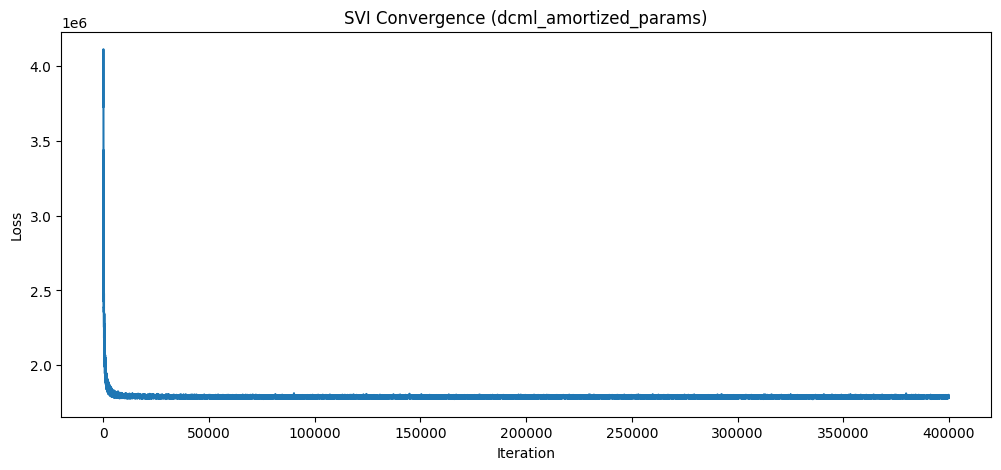

In [21]:
dcml_params, (alpha_h_history, alpha_phi_history) = infer_amortized_posteriors(npcs, len(dcml_chordtypes), dcml_obs,
                                                                              nsteps=400000, lr=0.01, plot_loss=True,
                                                                              save_as="dcml_amortized_params", collect_history=True
                                                                              )

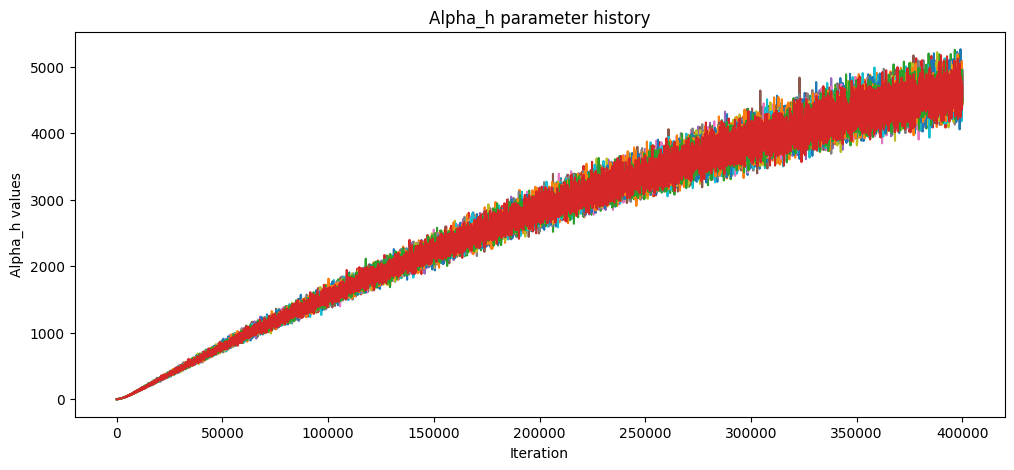

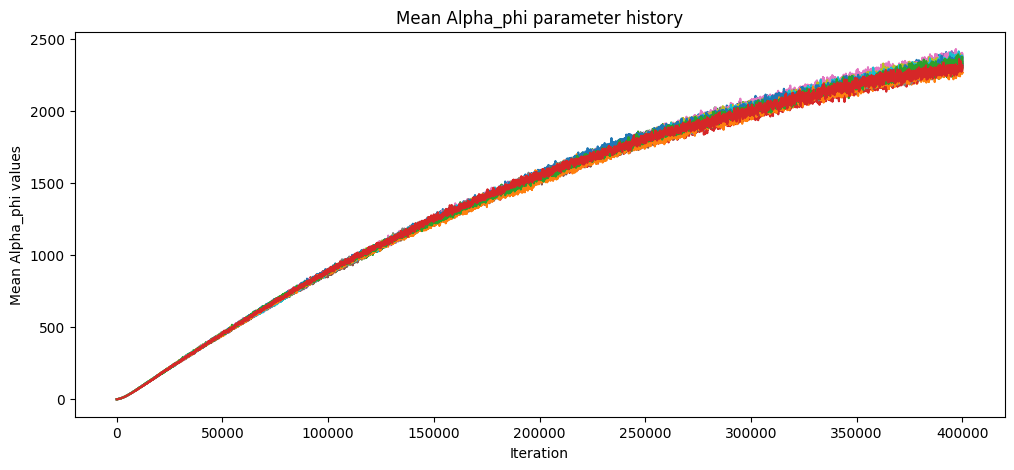

In [22]:
# Plot the parameter histories
plot_param_histories(alpha_h_history, alpha_phi_history)

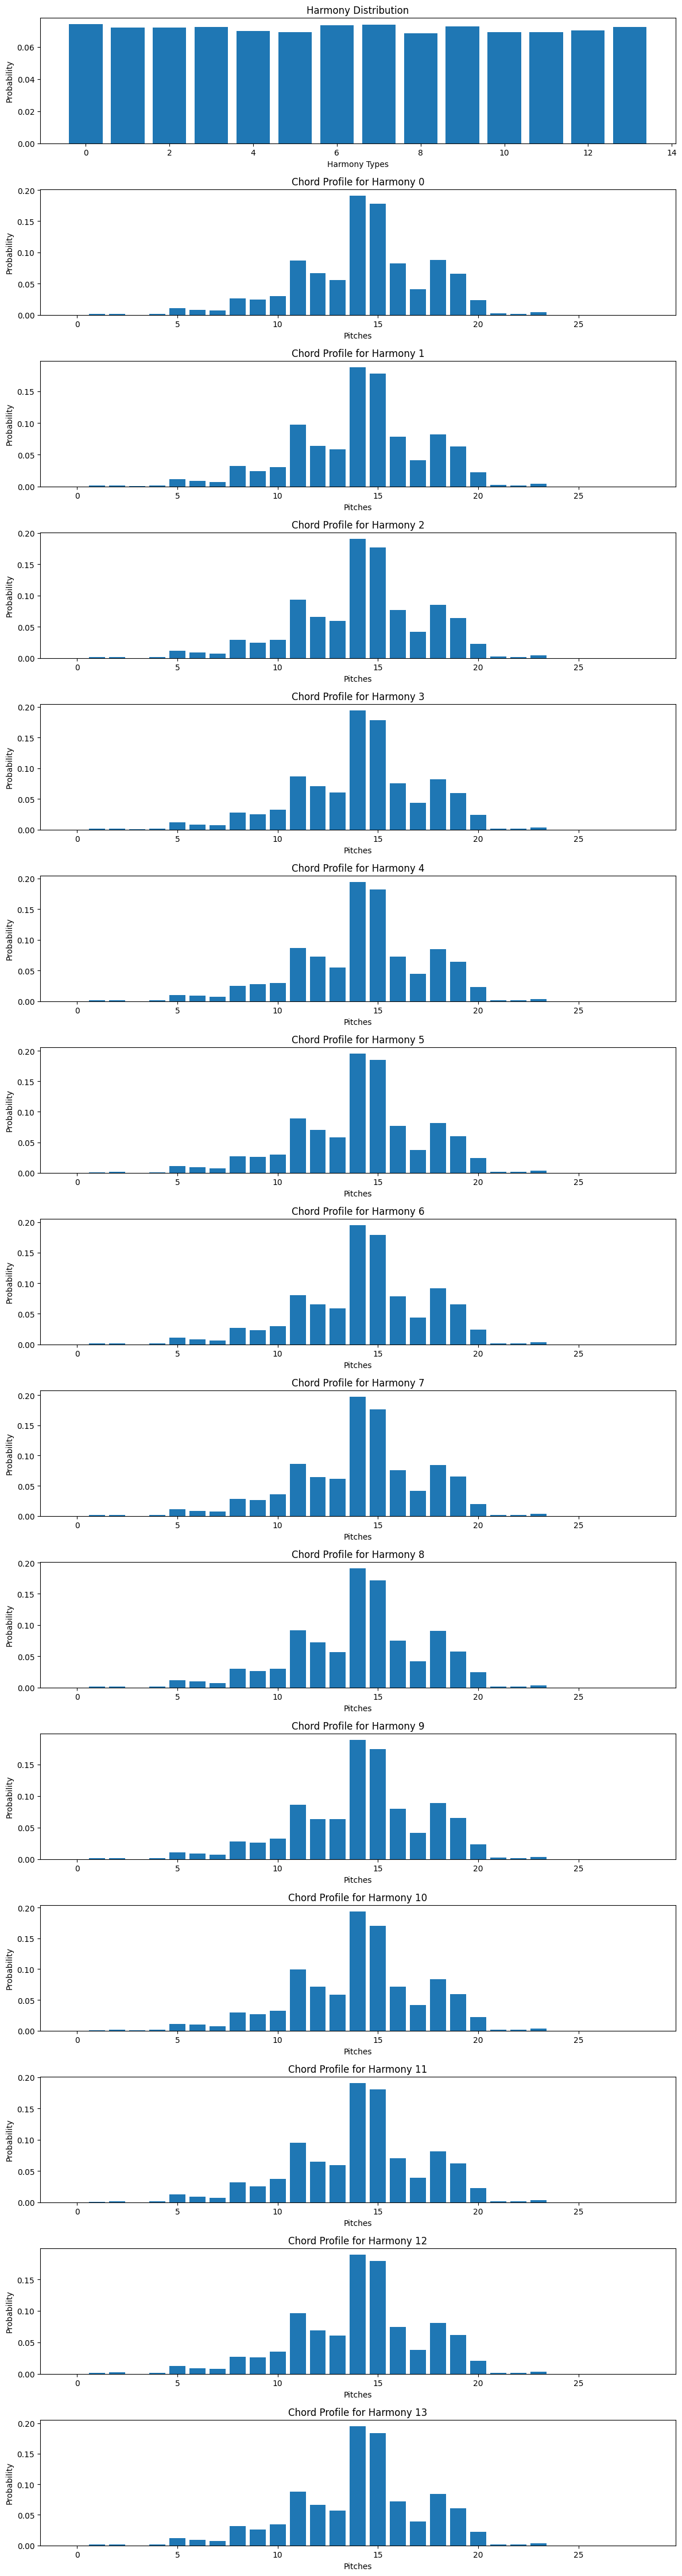

In [23]:
plot_amortized_inference_results(dcml_params, len(dcml_chordtypes), npcs, save_as="dcml_amortized_params")